In [ ]:
import gymnasium as gym
import safety_gymnasium

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

ENV_ID = "SafetyPointGoal1-v0"     # tâche simple, contrainte de collision

import gymnasium as gym
import safety_gymnasium
from safety_gymnasium.wrappers import SafetyGymnasium2Gymnasium

def make_env():
    safe_env = safety_gymnasium.make("SafetyPointGoal1-v0", render_mode=None)
    env = SafetyGymnasium2Gymnasium(safe_env)   # ⇨ API Gymnasium
    return env
if __name__ == "__main__":
    train_env = make_env()
    eval_env  = make_env()

    model = PPO(
        policy="MlpPolicy",
        env=train_env,
        verbose=1,
        tensorboard_log="./ppo/ppo_tb",
        batch_size=4096,
        n_steps=8192,
    )

    eval_cb = EvalCallback(
        eval_env,
        eval_freq=10_000,
        best_model_save_path="./ppo/ppo_best",
        log_path="./ppo/ppo_eval",
        deterministic=True,
    )

    model.learn(total_timesteps=1_000_000, callback=eval_cb)
    model.save("ppo_safety_point_goal1")

    train_env.close(); eval_env.close()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tb/PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -0.0361  |
| time/              |          |
|    fps             | 733      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 8192     |
---------------------------------


/home/chaos/miniconda3/envs/safe_rl/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-26.77 +/- 2.07
Episode length: 1000.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -26.8       |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.004337332 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -9.75       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00613     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00221    |
|    std                  | 0.996       |
|    value_loss           | 0.0478      |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     |

In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"           # or osmesa
os.environ["PYOPENGL_PLATFORM"] = "egl"

from stable_baselines3 import PPO
import safety_gymnasium
from safety_gymnasium.wrappers import SafetyGymnasium2Gymnasium
from gymnasium.wrappers import RecordVideo

# --- 1. 3rd‑person env ----------------------------------------------------
base_env = safety_gymnasium.make(
    "SafetyPointGoal1-v0",
    render_mode="rgb_array",
    camera_name="track",          # <‑‑ HERE: 3rd‑person chase camera
)
env = SafetyGymnasium2Gymnasium(base_env)

# --- 2. Record exactly one episode ---------------------------------------
env = RecordVideo(
    env,
    video_folder="/home/chaos/Desktop/Projet_Safe-RL",
    episode_trigger=lambda ep: ep == 0,
    name_prefix="ppo_rollout_3rd",
    disable_logger=True,
)

# --- 3. Load policy & roll ~30 s (900 steps) ------------------------------
model = PPO.load("ppo/ppo_best/best_model")   # best checkpoint

obs, _ = env.reset(seed=0)
for _ in range(900):                      # 30 s @ 30 FPS
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, truncated, _ = env.step(action)
    if done or truncated:
        break

env.close()
print("✅  saved → /home/chaos/Desktop/Projet_Safe-RL/ppo_rollout_3rd-episode-0.mp4")


/home/chaos/miniconda3/envs/safe_rl/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/chaos/Desktop/Projet_Safe-RL folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅  saved → /home/chaos/Desktop/Projet_Safe-RL/ppo_rollout_3rd-episode-0.mp4


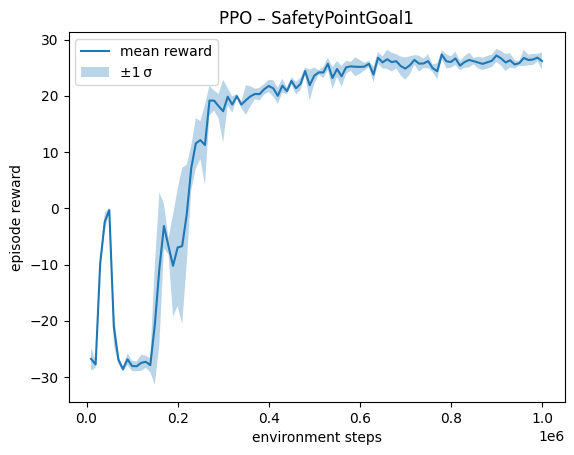

In [7]:
import numpy as np, matplotlib.pyplot as plt

data = np.load("ppo_eval/evaluations.npz")
timesteps      = data["timesteps"]          # shape (k,)
results        = data["results"]            # shape (k, n_eval_episodes)
mean_rewards   = results.mean(axis=1)
std_rewards    = results.std(axis=1)

plt.plot(timesteps, mean_rewards, label="mean reward")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.3,
    label="±1 σ",
)
plt.xlabel("environment steps")
plt.ylabel("episode reward")
plt.title("PPO – SafetyPointGoal1")
plt.legend()
plt.show()


## omnisafe train --algo CPO --env-id SafetyPointGoal1-v0 --total-steps 1000000 --vector-env-nums 1 --device cuda:0 --log-dir cpo_logs

In [ ]:
import os
import gymnasium as gym
import safety_gymnasium
from safety_gymnasium.wrappers import SafetyGymnasium2Gymnasium
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# -----------------------------------------------------------------------------
# Environment variables for headless rendering (if applicable)
os.environ["MUJOCO_GL"] = "egl"           # or "osmesa"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# -----------------------------------------------------------------------------
# Define the policy network architecture that matches OmniSafe's checkpoint.
class CPOPolicyNetwork(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_sizes=(64, 64)):
        super(CPOPolicyNetwork, self).__init__()
        layers = []
        last_dim = obs_dim
        # Build the network and assign it to self.mean so that the keys match.
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_dim, hidden_size))
            layers.append(nn.ReLU())
            last_dim = hidden_size
        layers.append(nn.Linear(last_dim, action_dim))
        self.mean = nn.Sequential(*layers)
        # Create a learnable log_std parameter (one per action dimension)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
    def forward(self, x):
        # Return the mean of the policy.
        return self.mean(x)

# -----------------------------------------------------------------------------
# Wrapper to provide a predict() method similar to Stable Baselines3.
class CPOModuleWrapper:
    def __init__(self, model: nn.Module):
        self.model = model
        self.model.eval()

    def predict(self, obs, deterministic=True):
        # Convert observation (NumPy array) to a torch tensor with a batch dimension.
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            # Use the model's forward method to get the mean action.
            action_tensor = self.model(obs_tensor)
        # Remove the batch dimension and convert the result to NumPy.
        action = action_tensor.squeeze(0).cpu().numpy()
        return action, None

# -----------------------------------------------------------------------------
# Function to load the OmniSafe CPO model checkpoint.
def load_cpo_model(checkpoint_path: str, obs_dim: int, action_dim: int) -> CPOModuleWrapper:
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(
            f"Checkpoint file was not found at: {checkpoint_path}. "
            "Please verify the file path and name, or check if the model was saved correctly."
        )
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    
    # If the checkpoint is a dictionary with key "pi", extract the policy state dict.
    if isinstance(checkpoint, dict) and "pi" in checkpoint:
        policy_state_dict = checkpoint["pi"]
    else:
        policy_state_dict = checkpoint

    # Print out the keys of the loaded state dictionary for inspection.
    print("Policy state dict keys:", list(policy_state_dict.keys()))
    
    # Instantiate the model with the new architecture.
    model = CPOPolicyNetwork(obs_dim, action_dim, hidden_sizes=(64, 64))
    
    # Load the state dictionary with strict=True now that the keys should match.
    load_info = model.load_state_dict(policy_state_dict, strict=False)
    print("Missing keys after loading:", load_info.missing_keys)
    print("Unexpected keys after loading:", load_info.unexpected_keys)
    
    return CPOModuleWrapper(model)

# -----------------------------------------------------------------------------
# Function to set up the environment with video recording.
def setup_video_env(video_folder: str):
    base_env = safety_gymnasium.make(
        "SafetyPointGoal1-v0",
        render_mode="rgb_array",
        camera_name="track",  # Third-person chase camera view
    )
    env = SafetyGymnasium2Gymnasium(base_env)
    env = RecordVideo(
        env,
        video_folder=video_folder,
        episode_trigger=lambda episode_id: episode_id == 0,  # Record only the first episode.
        name_prefix="cpo_rollout_3rd",
        disable_logger=True,
    )
    return env

# -----------------------------------------------------------------------------
# Main script: load model, run rollout, and plot evaluation results.
if __name__ == "__main__":
    # -----------------------------------------------------------------------------
    # Define the checkpoint path based on your directory structure.
    checkpoint_path = (
        "./cpo_logs/train/CPO-{SafetyPointGoal1-v0}/seed-000-2025-04-13-22-53-59/"
        "torch_save/epoch-50.pt"
    )
    
    # Print debug info: current working directory and checkpoint folder contents.
    print("Current working directory:", os.getcwd())
    ckpt_folder = os.path.dirname(checkpoint_path)
    if os.path.exists(ckpt_folder):
        print(f"Contents of '{ckpt_folder}':", os.listdir(ckpt_folder))
    else:
        print(f"Folder '{ckpt_folder}' does not exist.")

    # -----------------------------------------------------------------------------
    # Create a temporary environment to determine observation and action dimensions.
    temp_env = safety_gymnasium.make("SafetyPointGoal1-v0", render_mode=None)
    obs_space = temp_env.observation_space
    if hasattr(obs_space, 'shape'):
        obs_dim = obs_space.shape[0]
    else:
        # If the observation space is a dict, adjust accordingly (e.g., use obs_space['obs'])
        raise ValueError("Unexpected observation space format. Adjust the code accordingly.")
    action_dim = temp_env.action_space.shape[0]
    temp_env.close()
    print(f"Observation dimension: {obs_dim}, Action dimension: {action_dim}")

    # -----------------------------------------------------------------------------
    # Load the trained CPO model.
    model_wrapper = load_cpo_model(checkpoint_path, obs_dim, action_dim)
    print("✅ Successfully loaded the CPO model.")

    # -----------------------------------------------------------------------------
    # Set up the video environment.
    video_folder = "./cpo_logs/video"
    env = setup_video_env(video_folder)

    # -----------------------------------------------------------------------------
    # Run a rollout of approximately 30 seconds (900 steps at 30 FPS).
    obs, info = env.reset(seed=0)
    for step in range(900):
        action, _ = model_wrapper.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            print(f"Episode terminated at step {step + 1}.")
            break

    env.close()
    video_path = os.path.join(video_folder, "cpo_rollout_3rd-episode-0.mp4")
    print(f"✅ Video saved → {video_path}")

    # -----------------------------------------------------------------------------
    # Load evaluation data and plot the performance graph.
    eval_log_path = "./cpo_logs/evaluations.npz"
    if not os.path.exists(eval_log_path):
        print(f"Evaluation log file not found at {eval_log_path}. Skipping evaluation plot.")
    else:
        try:
            data = np.load(eval_log_path)
        except Exception as e:
            raise RuntimeError(f"Error loading evaluation logs: {e}")

        timesteps    = data["timesteps"]    # 1D array of timesteps.
        results      = data["results"]      # 2D array (evaluations x episodes)
        mean_rewards = results.mean(axis=1)
        std_rewards  = results.std(axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(timesteps, mean_rewards, label="Mean Reward")
        plt.fill_between(
            timesteps,
            mean_rewards - std_rewards,
            mean_rewards + std_rewards,
            alpha=0.3,
            label="±1 σ"
        )
        plt.xlabel("Environment Steps")
        plt.ylabel("Episode Reward")
        plt.title("CPO – SafetyPointGoal1 Evaluation")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Current working directory: /home/chaos/Desktop/Projet_Safe-RL
Contents of './cpo_logs/train/CPO-{SafetyPointGoal1-v0}/seed-000-2025-04-13-22-53-59/torch_save': ['epoch-0.pt', 'epoch-50.pt']
Observation dimension: 60, Action dimension: 2
Policy state dict keys: ['log_std', 'mean.0.weight', 'mean.0.bias', 'mean.2.weight', 'mean.2.bias', 'mean.4.weight', 'mean.4.bias']
Missing keys after loading: ['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.4.weight', 'net.4.bias']
Unexpected keys after loading: ['log_std', 'mean.0.weight', 'mean.0.bias', 'mean.2.weight', 'mean.2.bias', 'mean.4.weight', 'mean.4.bias']
✅ Successfully loaded the CPO model.
✅ Video saved → ./cpo_logs/video/cpo_rollout_3rd-episode-0.mp4
Evaluation log file not found at ./cpo_logs/evaluations.npz. Skipping evaluation plot.


# Test PPO et CPO par Omnisafe

In [5]:
import omnisafe
import safety_gymnasium
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configuration for training
custom_cfgs = {
    'train_cfgs': {
        'total_steps': 1024000,  # Total training steps
        'vector_env_nums': 1,    # Number of parallel environments
        'parallel': 1,           # Number of parallel processes
        'torch_threads': 1,      # Number of PyTorch threads
    },
    'algo_cfgs': {
        'steps_per_epoch': 2048, # Steps per epoch
        'update_iters': 10,      # Number of policy updates per epoch
    },
    'logger_cfgs': {
        'use_wandb': False,      # Disable Weights & Biases (use local logging)
        'save_model_freq': 10,   # Save model every 10 epochs
        'log_dir': './results/', # Directory for logs
    },
}

# Environment setup
env_id = 'SafetyPointGoal1-v0'

# Function to train an agent and collect metrics
def train_agent(algo_name, env_id, custom_cfgs):
    # Initialize agent
    agent = omnisafe.Agent(algo_name, env_id=env_id, custom_cfgs=custom_cfgs)
    
    # Train the agent
    agent.learn()
    
    # Access logged metrics (assuming logger stores metrics in results/)
    log_dir = custom_cfgs['logger_cfgs']['log_dir'] + f'{algo_name}_{env_id}'
    rewards = np.load(f'{log_dir}/Rewards.npy')  # Adjust based on actual log file
    costs = np.load(f'{log_dir}/Costs.npy')      # Adjust based on actual log file
    return rewards, costs

# Train PPO and CPO
ppo_rewards, ppo_costs = train_agent('PPO', env_id, custom_cfgs)
cpo_rewards, cpo_costs = train_agent('CPO', env_id, custom_cfgs)

# Plotting results
epochs = np.arange(len(ppo_rewards))  # Assuming rewards/costs are logged per epoch

plt.figure(figsize=(12, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(epochs, ppo_rewards, label='PPO Reward', color='blue')
plt.plot(epochs, cpo_rewards, label='CPO Reward', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Average Episodic Reward')
plt.title('Reward Comparison')
plt.legend()

# Plot costs
plt.subplot(1, 2, 2)
plt.plot(epochs, ppo_costs, label='PPO Cost', color='blue')
plt.plot(epochs, cpo_costs, label='CPO Cost', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Average Episodic Cost')
plt.title('Cost Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('results/ppo_vs_cpo_comparison.png')
plt.show()

Loading PPO.yaml from /home/napoleon/safe_RL/.venv/lib/python3.10/site-packages/omnisafe/utils/../configs/on-policy/PPO.yaml


Logging data to ./results/PPO-{SafetyPointGoal1-v0}/seed-000-2025-04-15-17-53-47/progress.csv

Save with config in config.json

INFO: Start training

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.5171959400177002    │
│ Metrics/EpCost                │ 160.0                  │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 0.0                    │
│ Train/Entropy                 │ 1.4186091423034668     │
│ Train/KL                      │ 0.01209575030952692    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9934464693069458     │
│ Train/PolicyRatio/Min         │ 0.9934464693069458     │
│ Train/PolicyRatio/Max         │ 0.9934464693069458     │
│ Train/PolicyRatio/Std         │ 0.016366688534617424   │
│ Train/LR                      │ 0.00029940000968053937 │
│ Train/PolicyStd               │ 0.9996857643127441     │
│ TotalEnvSteps                 │ 2048.0                 │
│ Loss/Loss_pi                  │ -0.01703210547566414   │
│ Loss/Loss_pi/Delta            │ -0.01703210547566414   │
│ Value/Adv                     │ 0.03242161497473717    │
│ Loss/Loss_reward_critic       │ 0.02977116033434868    │
│ Loss/Loss_reward_critic/Delta │ 0.02977116033434868    │
│ Value/reward                  │ -0.06652169674634933   │
│ Time/Total                    │ 13.945426940917969     │
│ Time/Rollout                  │ 12.141347885131836     │
│ Time/Update                   │ 1.8028321266174316     │
│ Time/Epoch                    │ 13.944226264953613     │
│ Time/FPS                      │ 146.87083435058594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.6963911056518555    │
│ Metrics/EpCost                │ 92.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 1.0                    │
│ Train/Entropy                 │ 1.413905143737793      │
│ Train/KL                      │ 0.012971781194210052   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0032873153686523     │
│ Train/PolicyRatio/Min         │ 1.0032873153686523     │
│ Train/PolicyRatio/Max         │ 1.0032873153686523     │
│ Train/PolicyRatio/Std         │ 0.01744179241359234    │
│ Train/LR                      │ 0.00029880000511184335 │
│ Train/PolicyStd               │ 0.9950898885726929     │
│ TotalEnvSteps                 │ 4096.0                 │
│ Loss/Loss_pi                  │ -0.0139822568744421    │
│ Loss/Loss_pi/Delta            │ 0.0030498486012220383  │
│ Value/Adv                     │ -0.18496325612068176   │
│ Loss/Loss_reward_critic       │ 0.010805997997522354   │
│ Loss/Loss_reward_critic/Delta │ -0.018965162336826324  │
│ Value/reward                  │ -0.03788800910115242   │
│ Time/Total                    │ 27.469860076904297     │
│ Time/Rollout                  │ 11.659074783325195     │
│ Time/Update                   │ 1.8522529602050781     │
│ Time/Epoch                    │ 13.511387825012207     │
│ Time/FPS                      │ 151.57586669921875     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.05475000664591789  │
│ Metrics/EpCost                │ 76.5                  │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 2.0                   │
│ Train/Entropy                 │ 1.412365198135376     │
│ Train/KL                      │ 0.014129296876490116  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9996505975723267    │
│ Train/PolicyRatio/Min         │ 0.9996505975723267    │
│ Train/PolicyRatio/Max         │ 0.9996505975723267    │
│ Train/PolicyRatio/Std         │ 0.01804918423295021   │
│ Train/LR                      │ 0.0002982000005431473 │
│ Train/PolicyStd               │ 0.9936186671257019    │
│ TotalEnvSteps                 │ 6144.0                │
│ Loss/Loss_pi                  │ -0.012836487963795662 │
│ Loss/Loss_pi/Delta            │ 0.0011457689106464386 │
│ Value/Adv                     │ 0.13867875933647156   │
│ Loss/Loss_reward_critic       │ 0.00532873161137104   │
│ Loss/Loss_reward_critic/Delta │ -0.005477266386151314 │
│ Value/reward                  │ -0.017279157415032387 │
│ Time/Total                    │ 40.84660339355469     │
│ Time/Rollout                  │ 11.567846298217773    │
│ Time/Update                   │ 1.7967455387115479    │
│ Time/Epoch                    │ 13.364631652832031    │
│ Time/FPS                      │ 153.24029541015625    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.09124717116355896    │
│ Metrics/EpCost                │ 74.375                 │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 3.0                    │
│ Train/Entropy                 │ 1.415527582168579      │
│ Train/KL                      │ 0.01189988013356924    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9990431070327759     │
│ Train/PolicyRatio/Min         │ 0.9990431070327759     │
│ Train/PolicyRatio/Max         │ 0.9990431070327759     │
│ Train/PolicyRatio/Std         │ 0.01719563640654087    │
│ Train/LR                      │ 0.0002975999959744513  │
│ Train/PolicyStd               │ 0.9968209266662598     │
│ TotalEnvSteps                 │ 8192.0                 │
│ Loss/Loss_pi                  │ -0.00920955277979374   │
│ Loss/Loss_pi/Delta            │ 0.0036269351840019226  │
│ Value/Adv                     │ -0.11947731673717499   │
│ Loss/Loss_reward_critic       │ 0.0036274201702326536  │
│ Loss/Loss_reward_critic/Delta │ -0.0017013114411383867 │
│ Value/reward                  │ 0.05267662927508354    │
│ Time/Total                    │ 54.34081268310547      │
│ Time/Rollout                  │ 11.615191459655762     │
│ Time/Update                   │ 1.866776704788208      │
│ Time/Epoch                    │ 13.48200798034668      │
│ Time/FPS                      │ 151.90615844726562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.48921042680740356   │
│ Metrics/EpCost                │ 69.19999694824219     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 4.0                   │
│ Train/Entropy                 │ 1.4115691184997559    │
│ Train/KL                      │ 0.014714842662215233  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9981666803359985    │
│ Train/PolicyRatio/Min         │ 0.9981666803359985    │
│ Train/PolicyRatio/Max         │ 0.9981666803359985    │
│ Train/PolicyRatio/Std         │ 0.01597432605922222   │
│ Train/LR                      │ 0.0002969999914057553 │
│ Train/PolicyStd               │ 0.9929086565971375    │
│ TotalEnvSteps                 │ 10240.0               │
│ Loss/Loss_pi                  │ -0.014692617580294609 │
│ Loss/Loss_pi/Delta            │ -0.00548306480050087  │
│ Value/Adv                     │ -0.0628545880317688   │
│ Loss/Loss_reward_critic       │ 0.004672312643378973  │
│ Loss/Loss_reward_critic/Delta │ 0.0010448924731463194 │
│ Value/reward                  │ 0.03953893482685089   │
│ Time/Total                    │ 67.88640594482422     │
│ Time/Rollout                  │ 11.686569213867188    │
│ Time/Update                   │ 1.8462793827056885    │
│ Time/Epoch                    │ 13.532892227172852    │
│ Time/FPS                      │ 151.33499145507812    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.5047287344932556     │
│ Metrics/EpCost                │ 69.41666412353516      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 5.0                    │
│ Train/Entropy                 │ 1.4093431234359741     │
│ Train/KL                      │ 0.014810450375080109   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9991062879562378     │
│ Train/PolicyRatio/Min         │ 0.9991062879562378     │
│ Train/PolicyRatio/Max         │ 0.9991062879562378     │
│ Train/PolicyRatio/Std         │ 0.01995469257235527    │
│ Train/LR                      │ 0.00029639998683705926 │
│ Train/PolicyStd               │ 0.9906789660453796     │
│ TotalEnvSteps                 │ 12288.0                │
│ Loss/Loss_pi                  │ -0.018977884203195572  │
│ Loss/Loss_pi/Delta            │ -0.004285266622900963  │
│ Value/Adv                     │ -0.023086896166205406  │
│ Loss/Loss_reward_critic       │ 0.0032594159711152315  │
│ Loss/Loss_reward_critic/Delta │ -0.0014128966722637415 │
│ Value/reward                  │ 0.12286173552274704    │
│ Time/Total                    │ 81.57026672363281      │
│ Time/Rollout                  │ 11.792122840881348     │
│ Time/Update                   │ 1.8793890476226807     │
│ Time/Epoch                    │ 13.67155647277832      │
│ Time/FPS                      │ 149.80006408691406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.7044267654418945     │
│ Metrics/EpCost                │ 95.64286041259766      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 6.0                    │
│ Train/Entropy                 │ 1.4085636138916016     │
│ Train/KL                      │ 0.010557910427451134   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0000907182693481     │
│ Train/PolicyRatio/Min         │ 1.0000907182693481     │
│ Train/PolicyRatio/Max         │ 1.0000907182693481     │
│ Train/PolicyRatio/Std         │ 0.0175543911755085     │
│ Train/LR                      │ 0.0002958000113721937  │
│ Train/PolicyStd               │ 0.9900562167167664     │
│ TotalEnvSteps                 │ 14336.0                │
│ Loss/Loss_pi                  │ -0.014173673465847969  │
│ Loss/Loss_pi/Delta            │ 0.004804210737347603   │
│ Value/Adv                     │ 0.29192686080932617    │
│ Loss/Loss_reward_critic       │ 0.0029880914371460676  │
│ Loss/Loss_reward_critic/Delta │ -0.0002713245339691639 │
│ Value/reward                  │ -0.005129016935825348  │
│ Time/Total                    │ 95.15318298339844      │
│ Time/Rollout                  │ 11.738980293273926     │
│ Time/Update                   │ 1.8297855854034424     │
│ Time/Epoch                    │ 13.568815231323242     │
│ Time/FPS                      │ 150.93434143066406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.729386031627655      │
│ Metrics/EpCost                │ 86.25                  │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 7.0                    │
│ Train/Entropy                 │ 1.400043249130249      │
│ Train/KL                      │ 0.014926786534488201   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9989246129989624     │
│ Train/PolicyRatio/Min         │ 0.9989246129989624     │
│ Train/PolicyRatio/Max         │ 0.9989246129989624     │
│ Train/PolicyRatio/Std         │ 0.020921384915709496   │
│ Train/LR                      │ 0.00029520000680349767 │
│ Train/PolicyStd               │ 0.9819475412368774     │
│ TotalEnvSteps                 │ 16384.0                │
│ Loss/Loss_pi                  │ -0.012963773682713509  │
│ Loss/Loss_pi/Delta            │ 0.0012098997831344604  │
│ Value/Adv                     │ -0.129231795668602     │
│ Loss/Loss_reward_critic       │ 0.004587588366121054   │
│ Loss/Loss_reward_critic/Delta │ 0.001599496928974986   │
│ Value/reward                  │ 0.058384135365486145   │
│ Time/Total                    │ 108.6556625366211      │
│ Time/Rollout                  │ 11.762680053710938     │
│ Time/Update                   │ 1.7262983322143555     │
│ Time/Epoch                    │ 13.489020347595215     │
│ Time/FPS                      │ 151.8271942138672      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.0196658372879028     │
│ Metrics/EpCost                │ 80.38888549804688      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 8.0                    │
│ Train/Entropy                 │ 1.385493516921997      │
│ Train/KL                      │ 0.01158205047249794    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985524415969849     │
│ Train/PolicyRatio/Min         │ 0.9985524415969849     │
│ Train/PolicyRatio/Max         │ 0.9985524415969849     │
│ Train/PolicyRatio/Std         │ 0.015402240678668022   │
│ Train/LR                      │ 0.00029460000223480165 │
│ Train/PolicyStd               │ 0.9678937792778015     │
│ TotalEnvSteps                 │ 18432.0                │
│ Loss/Loss_pi                  │ -0.012439721263945103  │
│ Loss/Loss_pi/Delta            │ 0.0005240524187684059  │
│ Value/Adv                     │ 0.20165421068668365    │
│ Loss/Loss_reward_critic       │ 0.004883102606981993   │
│ Loss/Loss_reward_critic/Delta │ 0.000295514240860939   │
│ Value/reward                  │ 0.10465170443058014    │
│ Time/Total                    │ 122.39946746826172     │
│ Time/Rollout                  │ 11.892988204956055     │
│ Time/Update                   │ 1.83864426612854       │
│ Time/Epoch                    │ 13.731674194335938     │
│ Time/FPS                      │ 149.1442413330078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.3415597677230835     │
│ Metrics/EpCost                │ 94.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 9.0                    │
│ Train/Entropy                 │ 1.3787281513214111     │
│ Train/KL                      │ 0.01174912415444851    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9976779818534851     │
│ Train/PolicyRatio/Min         │ 0.9976779818534851     │
│ Train/PolicyRatio/Max         │ 0.9976779818534851     │
│ Train/PolicyRatio/Std         │ 0.01921680010855198    │
│ Train/LR                      │ 0.00029399999766610563 │
│ Train/PolicyStd               │ 0.9614613652229309     │
│ TotalEnvSteps                 │ 20480.0                │
│ Loss/Loss_pi                  │ -0.015449238009750843  │
│ Loss/Loss_pi/Delta            │ -0.0030095167458057404 │
│ Value/Adv                     │ -0.17510564625263214   │
│ Loss/Loss_reward_critic       │ 0.004905871581286192   │
│ Loss/Loss_reward_critic/Delta │ 2.276897430419922e-05  │
│ Value/reward                  │ 0.1753077507019043     │
│ Time/Total                    │ 135.8899383544922      │
│ Time/Rollout                  │ 11.793667793273926     │
│ Time/Update                   │ 1.6837434768676758     │
│ Time/Epoch                    │ 13.477455139160156     │
│ Time/FPS                      │ 151.9574737548828      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.3176074028015137     │
│ Metrics/EpCost                │ 87.18181610107422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 10.0                   │
│ Train/Entropy                 │ 1.377897024154663      │
│ Train/KL                      │ 0.018271518871188164   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9980016946792603     │
│ Train/PolicyRatio/Min         │ 0.9980016946792603     │
│ Train/PolicyRatio/Max         │ 0.9980016946792603     │
│ Train/PolicyRatio/Std         │ 0.017799319699406624   │
│ Train/LR                      │ 0.0002933999930974096  │
│ Train/PolicyStd               │ 0.9607664346694946     │
│ TotalEnvSteps                 │ 22528.0                │
│ Loss/Loss_pi                  │ -0.014539000578224659  │
│ Loss/Loss_pi/Delta            │ 0.0009102374315261841  │
│ Value/Adv                     │ 0.09824410825967789    │
│ Loss/Loss_reward_critic       │ 0.0022674628999084234  │
│ Loss/Loss_reward_critic/Delta │ -0.0026384086813777685 │
│ Value/reward                  │ 0.004919549450278282   │
│ Time/Total                    │ 148.91213989257812     │
│ Time/Rollout                  │ 11.247808456420898     │
│ Time/Update                   │ 1.7612764835357666     │
│ Time/Epoch                    │ 13.00912857055664      │
│ Time/FPS                      │ 157.4279327392578      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.5186511278152466    │
│ Metrics/EpCost                │ 86.875                │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 11.0                  │
│ Train/Entropy                 │ 1.3731036186218262    │
│ Train/KL                      │ 0.013781437650322914  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9993082284927368    │
│ Train/PolicyRatio/Min         │ 0.9993082284927368    │
│ Train/PolicyRatio/Max         │ 0.9993082284927368    │
│ Train/PolicyRatio/Std         │ 0.01776096224784851   │
│ Train/LR                      │ 0.0002927999885287136 │
│ Train/PolicyStd               │ 0.9563396573066711    │
│ TotalEnvSteps                 │ 24576.0               │
│ Loss/Loss_pi                  │ -0.013973912224173546 │
│ Loss/Loss_pi/Delta            │ 0.0005650883540511131 │
│ Value/Adv                     │ 0.3161247968673706    │
│ Loss/Loss_reward_critic       │ 0.005021495744585991  │
│ Loss/Loss_reward_critic/Delta │ 0.0027540328446775675 │
│ Value/reward                  │ 0.12742848694324493   │
│ Time/Total                    │ 162.36880493164062    │
│ Time/Rollout                  │ 11.703651428222656    │
│ Time/Update                   │ 1.7413122653961182    │
│ Time/Epoch                    │ 13.445013046264648    │
│ Time/FPS                      │ 152.3241424560547     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.7877436876296997     │
│ Metrics/EpCost                │ 81.88461303710938      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 12.0                   │
│ Train/Entropy                 │ 1.3554935455322266     │
│ Train/KL                      │ 0.01249705720692873    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0031416416168213     │
│ Train/PolicyRatio/Min         │ 1.0031416416168213     │
│ Train/PolicyRatio/Max         │ 1.0031416416168213     │
│ Train/PolicyRatio/Std         │ 0.016242321580648422   │
│ Train/LR                      │ 0.000292200013063848   │
│ Train/PolicyStd               │ 0.9398989677429199     │
│ TotalEnvSteps                 │ 26624.0                │
│ Loss/Loss_pi                  │ -0.015062833204865456  │
│ Loss/Loss_pi/Delta            │ -0.0010889209806919098 │
│ Value/Adv                     │ -0.06089358404278755   │
│ Loss/Loss_reward_critic       │ 0.006445142440497875   │
│ Loss/Loss_reward_critic/Delta │ 0.0014236466959118843  │
│ Value/reward                  │ 0.3817744851112366     │
│ Time/Total                    │ 175.77059936523438     │
│ Time/Rollout                  │ 11.603917121887207     │
│ Time/Update                   │ 1.7855315208435059     │
│ Time/Epoch                    │ 13.38949203491211      │
│ Time/FPS                      │ 152.9557647705078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.7913495302200317     │
│ Metrics/EpCost                │ 78.57142639160156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 13.0                   │
│ Train/Entropy                 │ 1.342596411705017      │
│ Train/KL                      │ 0.010349536314606667   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.003564715385437      │
│ Train/PolicyRatio/Min         │ 1.003564715385437      │
│ Train/PolicyRatio/Max         │ 1.003564715385437      │
│ Train/PolicyRatio/Std         │ 0.018700791522860527   │
│ Train/LR                      │ 0.000291600008495152   │
│ Train/PolicyStd               │ 0.9282391667366028     │
│ TotalEnvSteps                 │ 28672.0                │
│ Loss/Loss_pi                  │ -0.011334501206874847  │
│ Loss/Loss_pi/Delta            │ 0.003728331997990608   │
│ Value/Adv                     │ 0.01741015911102295    │
│ Loss/Loss_reward_critic       │ 0.0035249176435172558  │
│ Loss/Loss_reward_critic/Delta │ -0.0029202247969806194 │
│ Value/reward                  │ 0.4037509858608246     │
│ Time/Total                    │ 188.41116333007812     │
│ Time/Rollout                  │ 10.997016906738281     │
│ Time/Update                   │ 1.6296911239624023     │
│ Time/Epoch                    │ 12.62675952911377      │
│ Time/FPS                      │ 162.19522094726562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.007957935333252     │
│ Metrics/EpCost                │ 73.5999984741211      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 14.0                  │
│ Train/Entropy                 │ 1.3326187133789062    │
│ Train/KL                      │ 0.011252653785049915  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9974700808525085    │
│ Train/PolicyRatio/Min         │ 0.9974700808525085    │
│ Train/PolicyRatio/Max         │ 0.9974700808525085    │
│ Train/PolicyRatio/Std         │ 0.017346715554594994  │
│ Train/LR                      │ 0.000291000003926456  │
│ Train/PolicyStd               │ 0.9196935892105103    │
│ TotalEnvSteps                 │ 30720.0               │
│ Loss/Loss_pi                  │ -0.016332462430000305 │
│ Loss/Loss_pi/Delta            │ -0.004997961223125458 │
│ Value/Adv                     │ 0.09197748452425003   │
│ Loss/Loss_reward_critic       │ 0.006386472377926111  │
│ Loss/Loss_reward_critic/Delta │ 0.0028615547344088554 │
│ Value/reward                  │ 0.41047316789627075   │
│ Time/Total                    │ 200.88058471679688    │
│ Time/Rollout                  │ 10.829486846923828    │
│ Time/Update                   │ 1.6282680034637451    │
│ Time/Epoch                    │ 12.457796096801758    │
│ Time/FPS                      │ 164.3950653076172     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.1461384296417236     │
│ Metrics/EpCost                │ 100.90625              │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 15.0                   │
│ Train/Entropy                 │ 1.3238402605056763     │
│ Train/KL                      │ 0.007756068371236324   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9999433755874634     │
│ Train/PolicyRatio/Min         │ 0.9999433755874634     │
│ Train/PolicyRatio/Max         │ 0.9999433755874634     │
│ Train/PolicyRatio/Std         │ 0.015446130186319351   │
│ Train/LR                      │ 0.00029039999935775995 │
│ Train/PolicyStd               │ 0.911481499671936      │
│ TotalEnvSteps                 │ 32768.0                │
│ Loss/Loss_pi                  │ -0.01001476775854826   │
│ Loss/Loss_pi/Delta            │ 0.0063176946714520454  │
│ Value/Adv                     │ -0.0015218481421470642 │
│ Loss/Loss_reward_critic       │ 0.00891166739165783    │
│ Loss/Loss_reward_critic/Delta │ 0.002525195013731718   │
│ Value/reward                  │ 0.5972390174865723     │
│ Time/Total                    │ 213.41851806640625     │
│ Time/Rollout                  │ 10.83740234375         │
│ Time/Update                   │ 1.6887166500091553     │
│ Time/Epoch                    │ 12.526166915893555     │
│ Time/FPS                      │ 163.4977569580078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.0474352836608887     │
│ Metrics/EpCost                │ 113.11764526367188     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 16.0                   │
│ Train/Entropy                 │ 1.3175256252288818     │
│ Train/KL                      │ 0.011838234029710293   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0003684759140015     │
│ Train/PolicyRatio/Min         │ 1.0003684759140015     │
│ Train/PolicyRatio/Max         │ 1.0003684759140015     │
│ Train/PolicyRatio/Std         │ 0.015788333490490913   │
│ Train/LR                      │ 0.00028979999478906393 │
│ Train/PolicyStd               │ 0.9058883786201477     │
│ TotalEnvSteps                 │ 34816.0                │
│ Loss/Loss_pi                  │ -0.010906119830906391  │
│ Loss/Loss_pi/Delta            │ -0.0008913520723581314 │
│ Value/Adv                     │ -0.10765761137008667   │
│ Loss/Loss_reward_critic       │ 0.0029322425834834576  │
│ Loss/Loss_reward_critic/Delta │ -0.005979424808174372  │
│ Value/reward                  │ 0.11421626806259155    │
│ Time/Total                    │ 225.93768310546875     │
│ Time/Rollout                  │ 10.856833457946777     │
│ Time/Update                   │ 1.6493782997131348     │
│ Time/Epoch                    │ 12.506254196166992     │
│ Time/FPS                      │ 163.75807189941406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.1372933387756348     │
│ Metrics/EpCost                │ 114.97222137451172     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 17.0                   │
│ Train/Entropy                 │ 1.3147146701812744     │
│ Train/KL                      │ 0.014716845005750656   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9959033131599426     │
│ Train/PolicyRatio/Min         │ 0.9959033131599426     │
│ Train/PolicyRatio/Max         │ 0.9959033131599426     │
│ Train/PolicyRatio/Std         │ 0.018605543300509453   │
│ Train/LR                      │ 0.0002891999902203679  │
│ Train/PolicyStd               │ 0.9038289785385132     │
│ TotalEnvSteps                 │ 36864.0                │
│ Loss/Loss_pi                  │ -0.012370146811008453  │
│ Loss/Loss_pi/Delta            │ -0.0014640269801020622 │
│ Value/Adv                     │ -0.14517056941986084   │
│ Loss/Loss_reward_critic       │ 0.005480041261762381   │
│ Loss/Loss_reward_critic/Delta │ 0.002547798678278923   │
│ Value/reward                  │ 0.23973581194877625    │
│ Time/Total                    │ 238.44737243652344     │
│ Time/Rollout                  │ 10.822912216186523     │
│ Time/Update                   │ 1.6751010417938232     │
│ Time/Epoch                    │ 12.49807071685791      │
│ Time/FPS                      │ 163.8653106689453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.513962507247925     │
│ Metrics/EpCost                │ 110.89473724365234    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 18.0                  │
│ Train/Entropy                 │ 1.306275725364685     │
│ Train/KL                      │ 0.009532337076961994  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0030806064605713    │
│ Train/PolicyRatio/Min         │ 1.0030806064605713    │
│ Train/PolicyRatio/Max         │ 1.0030806064605713    │
│ Train/PolicyRatio/Std         │ 0.01541789248585701   │
│ Train/LR                      │ 0.0002885999856516719 │
│ Train/PolicyStd               │ 0.8965600728988647    │
│ TotalEnvSteps                 │ 38912.0               │
│ Loss/Loss_pi                  │ -0.011811918579041958 │
│ Loss/Loss_pi/Delta            │ 0.0005582282319664955 │
│ Value/Adv                     │ 0.10761149227619171   │
│ Loss/Loss_reward_critic       │ 0.0076765986159443855 │
│ Loss/Loss_reward_critic/Delta │ 0.002196557354182005  │
│ Value/reward                  │ 0.571629524230957     │
│ Time/Total                    │ 250.8970184326172     │
│ Time/Rollout                  │ 10.791508674621582    │
│ Time/Update                   │ 1.6457633972167969    │
│ Time/Epoch                    │ 12.437313079833984    │
│ Time/FPS                      │ 164.66580200195312    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.5353500843048096     │
│ Metrics/EpCost                │ 109.32499694824219     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 19.0                   │
│ Train/Entropy                 │ 1.2952100038528442     │
│ Train/KL                      │ 0.02378733828663826    │
│ Train/StopIter                │ 6.0                    │
│ Train/PolicyRatio/Mean        │ 0.9978005290031433     │
│ Train/PolicyRatio/Min         │ 0.9978005290031433     │
│ Train/PolicyRatio/Max         │ 0.9978005290031433     │
│ Train/PolicyRatio/Std         │ 0.018239522352814674   │
│ Train/LR                      │ 0.0002880000101868063  │
│ Train/PolicyStd               │ 0.886580228805542      │
│ TotalEnvSteps                 │ 40960.0                │
│ Loss/Loss_pi                  │ -0.013015392236411572  │
│ Loss/Loss_pi/Delta            │ -0.0012034736573696136 │
│ Value/Adv                     │ 0.1151050552725792     │
│ Loss/Loss_reward_critic       │ 0.00413854094222188    │
│ Loss/Loss_reward_critic/Delta │ -0.0035380576737225056 │
│ Value/reward                  │ 0.5099475383758545     │
│ Time/Total                    │ 262.69781494140625     │
│ Time/Rollout                  │ 10.793395042419434     │
│ Time/Update                   │ 0.9921548366546631     │
│ Time/Epoch                    │ 11.785593032836914     │
│ Time/FPS                      │ 173.771484375          │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.6775612831115723     │
│ Metrics/EpCost                │ 107.80952453613281     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 20.0                   │
│ Train/Entropy                 │ 1.285111427307129      │
│ Train/KL                      │ 0.0118419723585248     │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961341619491577     │
│ Train/PolicyRatio/Min         │ 0.9961341619491577     │
│ Train/PolicyRatio/Max         │ 0.9961341619491577     │
│ Train/PolicyRatio/Std         │ 0.017856156453490257   │
│ Train/LR                      │ 0.0002874000056181103  │
│ Train/PolicyStd               │ 0.8770718574523926     │
│ TotalEnvSteps                 │ 43008.0                │
│ Loss/Loss_pi                  │ -0.015218352898955345  │
│ Loss/Loss_pi/Delta            │ -0.0022029606625437737 │
│ Value/Adv                     │ -0.03953581303358078   │
│ Loss/Loss_reward_critic       │ 0.006874066777527332   │
│ Loss/Loss_reward_critic/Delta │ 0.0027355258353054523  │
│ Value/reward                  │ 0.5713939666748047     │
│ Time/Total                    │ 275.2617492675781      │
│ Time/Rollout                  │ 10.85103988647461      │
│ Time/Update                   │ 1.6950793266296387     │
│ Time/Epoch                    │ 12.54616928100586      │
│ Time/FPS                      │ 163.23709106445312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.9890401363372803    │
│ Metrics/EpCost                │ 104.81818389892578    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 21.0                  │
│ Train/Entropy                 │ 1.2794538736343384    │
│ Train/KL                      │ 0.01524317730218172   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9969674348831177    │
│ Train/PolicyRatio/Min         │ 0.9969674348831177    │
│ Train/PolicyRatio/Max         │ 0.9969674348831177    │
│ Train/PolicyRatio/Std         │ 0.01806304045021534   │
│ Train/LR                      │ 0.0002868000010494143 │
│ Train/PolicyStd               │ 0.8719485402107239    │
│ TotalEnvSteps                 │ 45056.0               │
│ Loss/Loss_pi                  │ -0.013968393206596375 │
│ Loss/Loss_pi/Delta            │ 0.0012499596923589706 │
│ Value/Adv                     │ -0.06340079009532928  │
│ Loss/Loss_reward_critic       │ 0.012971781194210052  │
│ Loss/Loss_reward_critic/Delta │ 0.00609771441668272   │
│ Value/reward                  │ 0.7313148379325867    │
│ Time/Total                    │ 287.7486572265625     │
│ Time/Rollout                  │ 10.834623336791992    │
│ Time/Update                   │ 1.6395761966705322    │
│ Time/Epoch                    │ 12.474252700805664    │
│ Time/FPS                      │ 164.1781768798828     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.2256314754486084     │
│ Metrics/EpCost                │ 102.26087188720703     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 22.0                   │
│ Train/Entropy                 │ 1.2717134952545166     │
│ Train/KL                      │ 0.012571902014315128   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9984204173088074     │
│ Train/PolicyRatio/Min         │ 0.9984204173088074     │
│ Train/PolicyRatio/Max         │ 0.9984204173088074     │
│ Train/PolicyRatio/Std         │ 0.016271725296974182   │
│ Train/LR                      │ 0.00028619999648071826 │
│ Train/PolicyStd               │ 0.865044891834259      │
│ TotalEnvSteps                 │ 47104.0                │
│ Loss/Loss_pi                  │ -0.011981924995779991  │
│ Loss/Loss_pi/Delta            │ 0.0019864682108163834  │
│ Value/Adv                     │ 0.020689908415079117   │
│ Loss/Loss_reward_critic       │ 0.010418503545224667   │
│ Loss/Loss_reward_critic/Delta │ -0.002553277648985386  │
│ Value/reward                  │ 0.628012478351593      │
│ Time/Total                    │ 300.2572021484375      │
│ Time/Rollout                  │ 10.863105773925781     │
│ Time/Update                   │ 1.6339025497436523     │
│ Time/Epoch                    │ 12.497058868408203     │
│ Time/FPS                      │ 163.8785858154297      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.5272438526153564     │
│ Metrics/EpCost                │ 101.625                │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 23.0                   │
│ Train/Entropy                 │ 1.2609983682632446     │
│ Train/KL                      │ 0.012731032446026802   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9922804832458496     │
│ Train/PolicyRatio/Min         │ 0.9922804832458496     │
│ Train/PolicyRatio/Max         │ 0.9922804832458496     │
│ Train/PolicyRatio/Std         │ 0.01958245038986206    │
│ Train/LR                      │ 0.00028559999191202223 │
│ Train/PolicyStd               │ 0.855660617351532      │
│ TotalEnvSteps                 │ 49152.0                │
│ Loss/Loss_pi                  │ -0.012400567531585693  │
│ Loss/Loss_pi/Delta            │ -0.0004186425358057022 │
│ Value/Adv                     │ -0.26398786902427673   │
│ Loss/Loss_reward_critic       │ 0.02103988267481327    │
│ Loss/Loss_reward_critic/Delta │ 0.010621379129588604   │
│ Value/reward                  │ 0.7080803513526917     │
│ Time/Total                    │ 312.762939453125       │
│ Time/Rollout                  │ 10.854605674743652     │
│ Time/Update                   │ 1.6396760940551758     │
│ Time/Epoch                    │ 12.494321823120117     │
│ Time/FPS                      │ 163.91445922851562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.6008167266845703    │
│ Metrics/EpCost                │ 102.81999969482422    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 24.0                  │
│ Train/Entropy                 │ 1.2500824928283691    │
│ Train/KL                      │ 0.011539298109710217  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9978740811347961    │
│ Train/PolicyRatio/Min         │ 0.9978740811347961    │
│ Train/PolicyRatio/Max         │ 0.9978740811347961    │
│ Train/PolicyRatio/Std         │ 0.017308901995420456  │
│ Train/LR                      │ 0.0002849999873433262 │
│ Train/PolicyStd               │ 0.8461747169494629    │
│ TotalEnvSteps                 │ 51200.0               │
│ Loss/Loss_pi                  │ -0.009022600017488003 │
│ Loss/Loss_pi/Delta            │ 0.0033779675140976906 │
│ Value/Adv                     │ 0.17631319165229797   │
│ Loss/Loss_reward_critic       │ 0.005668063648045063  │
│ Loss/Loss_reward_critic/Delta │ -0.015371819026768208 │
│ Value/reward                  │ 0.7030925750732422    │
│ Time/Total                    │ 325.27557373046875    │
│ Time/Rollout                  │ 10.870344161987305    │
│ Time/Update                   │ 1.630389928817749     │
│ Time/Epoch                    │ 12.500788688659668    │
│ Time/FPS                      │ 163.82968139648438    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.021853446960449      │
│ Metrics/EpCost                │ 99.9800033569336       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 25.0                   │
│ Train/Entropy                 │ 1.2396085262298584     │
│ Train/KL                      │ 0.012300319969654083   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9967433214187622     │
│ Train/PolicyRatio/Min         │ 0.9967433214187622     │
│ Train/PolicyRatio/Max         │ 0.9967433214187622     │
│ Train/PolicyRatio/Std         │ 0.017164230346679688   │
│ Train/LR                      │ 0.00028440001187846065 │
│ Train/PolicyStd               │ 0.8370752334594727     │
│ TotalEnvSteps                 │ 53248.0                │
│ Loss/Loss_pi                  │ -0.010986581444740295  │
│ Loss/Loss_pi/Delta            │ -0.0019639814272522926 │
│ Value/Adv                     │ -0.19223250448703766   │
│ Loss/Loss_reward_critic       │ 0.013032296672463417   │
│ Loss/Loss_reward_critic/Delta │ 0.007364233024418354   │
│ Value/reward                  │ 0.9199461340904236     │
│ Time/Total                    │ 337.73919677734375     │
│ Time/Rollout                  │ 10.812210083007812     │
│ Time/Update                   │ 1.6395344734191895     │
│ Time/Epoch                    │ 12.451787948608398     │
│ Time/FPS                      │ 164.47438049316406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.37286376953125      │
│ Metrics/EpCost                │ 100.72000122070312    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 26.0                  │
│ Train/Entropy                 │ 1.2291760444641113    │
│ Train/KL                      │ 0.015130409970879555  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0014886856079102    │
│ Train/PolicyRatio/Min         │ 1.0014886856079102    │
│ Train/PolicyRatio/Max         │ 1.0014886856079102    │
│ Train/PolicyRatio/Std         │ 0.01836075820028782   │
│ Train/LR                      │ 0.0002838000073097646 │
│ Train/PolicyStd               │ 0.8283531069755554    │
│ TotalEnvSteps                 │ 55296.0               │
│ Loss/Loss_pi                  │ -0.017799407243728638 │
│ Loss/Loss_pi/Delta            │ -0.006812825798988342 │
│ Value/Adv                     │ 0.06338783353567123   │
│ Loss/Loss_reward_critic       │ 0.010493045672774315  │
│ Loss/Loss_reward_critic/Delta │ -0.002539250999689102 │
│ Value/reward                  │ 0.602063775062561     │
│ Time/Total                    │ 350.2785949707031     │
│ Time/Rollout                  │ 10.878436088562012    │
│ Time/Update                   │ 1.6492199897766113    │
│ Time/Epoch                    │ 12.52769660949707     │
│ Time/FPS                      │ 163.477783203125      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.780488967895508     │
│ Metrics/EpCost                │ 100.5                 │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 27.0                  │
│ Train/Entropy                 │ 1.2251722812652588    │
│ Train/KL                      │ 0.014993689954280853  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9963825345039368    │
│ Train/PolicyRatio/Min         │ 0.9963825345039368    │
│ Train/PolicyRatio/Max         │ 0.9963825345039368    │
│ Train/PolicyRatio/Std         │ 0.017235008999705315  │
│ Train/LR                      │ 0.0002832000027410686 │
│ Train/PolicyStd               │ 0.8252444267272949    │
│ TotalEnvSteps                 │ 57344.0               │
│ Loss/Loss_pi                  │ -0.015663612633943558 │
│ Loss/Loss_pi/Delta            │ 0.00213579460978508   │
│ Value/Adv                     │ 0.08570751547813416   │
│ Loss/Loss_reward_critic       │ 0.014171351678669453  │
│ Loss/Loss_reward_critic/Delta │ 0.003678306005895138  │
│ Value/reward                  │ 0.7380086183547974    │
│ Time/Total                    │ 362.79931640625       │
│ Time/Rollout                  │ 10.844100952148438    │
│ Time/Update                   │ 1.6641483306884766    │
│ Time/Epoch                    │ 12.508299827575684    │
│ Time/FPS                      │ 163.73129272460938    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.309787750244141      │
│ Metrics/EpCost                │ 99.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 28.0                   │
│ Train/Entropy                 │ 1.2273558378219604     │
│ Train/KL                      │ 0.014778688549995422   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9971588850021362     │
│ Train/PolicyRatio/Min         │ 0.9971588850021362     │
│ Train/PolicyRatio/Max         │ 0.9971588850021362     │
│ Train/PolicyRatio/Std         │ 0.016442129388451576   │
│ Train/LR                      │ 0.0002825999981723726  │
│ Train/PolicyStd               │ 0.8271816968917847     │
│ TotalEnvSteps                 │ 59392.0                │
│ Loss/Loss_pi                  │ -0.016080375760793686  │
│ Loss/Loss_pi/Delta            │ -0.0004167631268501282 │
│ Value/Adv                     │ 0.06395785510540009    │
│ Loss/Loss_reward_critic       │ 0.00882886815816164    │
│ Loss/Loss_reward_critic/Delta │ -0.0053424835205078125 │
│ Value/reward                  │ 0.939166784286499      │
│ Time/Total                    │ 376.5455627441406      │
│ Time/Rollout                  │ 11.417545318603516     │
│ Time/Update                   │ 2.3169777393341064     │
│ Time/Epoch                    │ 13.734567642211914     │
│ Time/FPS                      │ 149.11282348632812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.7572550773620605     │
│ Metrics/EpCost                │ 100.4000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 29.0                   │
│ Train/Entropy                 │ 1.2186681032180786     │
│ Train/KL                      │ 0.016731498762965202   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9950565099716187     │
│ Train/PolicyRatio/Min         │ 0.9950565099716187     │
│ Train/PolicyRatio/Max         │ 0.9950565099716187     │
│ Train/PolicyRatio/Std         │ 0.019142385572195053   │
│ Train/LR                      │ 0.00028199999360367656 │
│ Train/PolicyStd               │ 0.8196345567703247     │
│ TotalEnvSteps                 │ 61440.0                │
│ Loss/Loss_pi                  │ -0.01667034439742565   │
│ Loss/Loss_pi/Delta            │ -0.0005899686366319656 │
│ Value/Adv                     │ -0.04969638213515282   │
│ Loss/Loss_reward_critic       │ 0.018560990691184998   │
│ Loss/Loss_reward_critic/Delta │ 0.009732122533023357   │
│ Value/reward                  │ 1.0326039791107178     │
│ Time/Total                    │ 391.35491943359375     │
│ Time/Rollout                  │ 12.741903305053711     │
│ Time/Update                   │ 2.055511236190796      │
│ Time/Epoch                    │ 14.797460556030273     │
│ Time/FPS                      │ 138.40213012695312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.132941722869873      │
│ Metrics/EpCost                │ 99.16000366210938      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 30.0                   │
│ Train/Entropy                 │ 1.1984813213348389     │
│ Train/KL                      │ 0.0105051314458251     │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0053808689117432     │
│ Train/PolicyRatio/Min         │ 1.0053808689117432     │
│ Train/PolicyRatio/Max         │ 1.0053808689117432     │
│ Train/PolicyRatio/Std         │ 0.01577853038907051    │
│ Train/LR                      │ 0.00028139998903498054 │
│ Train/PolicyStd               │ 0.8027752041816711     │
│ TotalEnvSteps                 │ 63488.0                │
│ Loss/Loss_pi                  │ -0.012179319746792316  │
│ Loss/Loss_pi/Delta            │ 0.004491024650633335   │
│ Value/Adv                     │ 0.08440300822257996    │
│ Loss/Loss_reward_critic       │ 0.011558321304619312   │
│ Loss/Loss_reward_critic/Delta │ -0.007002669386565685  │
│ Value/reward                  │ 0.9794994592666626     │
│ Time/Total                    │ 404.73486328125        │
│ Time/Rollout                  │ 11.68137264251709      │
│ Time/Update                   │ 1.6842079162597656     │
│ Time/Epoch                    │ 13.365620613098145     │
│ Time/FPS                      │ 153.2289581298828      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.558402061462402      │
│ Metrics/EpCost                │ 91.66000366210938      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 31.0                   │
│ Train/Entropy                 │ 1.1817774772644043     │
│ Train/KL                      │ 0.013262389227747917   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0005052089691162     │
│ Train/PolicyRatio/Min         │ 1.0005052089691162     │
│ Train/PolicyRatio/Max         │ 1.0005052089691162     │
│ Train/PolicyRatio/Std         │ 0.01868259906768799    │
│ Train/LR                      │ 0.00028080001357011497 │
│ Train/PolicyStd               │ 0.7893442511558533     │
│ TotalEnvSteps                 │ 65536.0                │
│ Loss/Loss_pi                  │ -0.01589914783835411   │
│ Loss/Loss_pi/Delta            │ -0.0037198280915617943 │
│ Value/Adv                     │ 0.12132398039102554    │
│ Loss/Loss_reward_critic       │ 0.017515890300273895   │
│ Loss/Loss_reward_critic/Delta │ 0.005957568995654583   │
│ Value/reward                  │ 1.0039819478988647     │
│ Time/Total                    │ 417.2439880371094      │
│ Time/Rollout                  │ 10.856437683105469     │
│ Time/Update                   │ 1.6411726474761963     │
│ Time/Epoch                    │ 12.497661590576172     │
│ Time/FPS                      │ 163.8706817626953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.004364490509033      │
│ Metrics/EpCost                │ 92.37999725341797      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 32.0                   │
│ Train/Entropy                 │ 1.168886661529541      │
│ Train/KL                      │ 0.010483227670192719   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.000675082206726      │
│ Train/PolicyRatio/Min         │ 1.000675082206726      │
│ Train/PolicyRatio/Max         │ 1.000675082206726      │
│ Train/PolicyRatio/Std         │ 0.018290234729647636   │
│ Train/LR                      │ 0.00028020000900141895 │
│ Train/PolicyStd               │ 0.7792171835899353     │
│ TotalEnvSteps                 │ 67584.0                │
│ Loss/Loss_pi                  │ -0.014326108619570732  │
│ Loss/Loss_pi/Delta            │ 0.0015730392187833786  │
│ Value/Adv                     │ 0.158444344997406      │
│ Loss/Loss_reward_critic       │ 0.018380988389253616   │
│ Loss/Loss_reward_critic/Delta │ 0.0008650980889797211  │
│ Value/reward                  │ 1.0467336177825928     │
│ Time/Total                    │ 429.822021484375       │
│ Time/Rollout                  │ 10.905802726745605     │
│ Time/Update                   │ 1.6598122119903564     │
│ Time/Epoch                    │ 12.565667152404785     │
│ Time/FPS                      │ 162.98379516601562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.460451602935791     │
│ Metrics/EpCost                │ 91.94000244140625     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 33.0                  │
│ Train/Entropy                 │ 1.16200852394104      │
│ Train/KL                      │ 0.012332320213317871  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0002392530441284    │
│ Train/PolicyRatio/Min         │ 1.0002392530441284    │
│ Train/PolicyRatio/Max         │ 1.0002392530441284    │
│ Train/PolicyRatio/Std         │ 0.016118744388222694  │
│ Train/LR                      │ 0.0002796000044327229 │
│ Train/PolicyStd               │ 0.7738130688667297    │
│ TotalEnvSteps                 │ 69632.0               │
│ Loss/Loss_pi                  │ -0.007909417152404785 │
│ Loss/Loss_pi/Delta            │ 0.006416691467165947  │
│ Value/Adv                     │ 0.11063764989376068   │
│ Loss/Loss_reward_critic       │ 0.020124852657318115  │
│ Loss/Loss_reward_critic/Delta │ 0.001743864268064499  │
│ Value/reward                  │ 1.2008213996887207    │
│ Time/Total                    │ 442.3132629394531     │
│ Time/Rollout                  │ 10.811177253723145    │
│ Time/Update                   │ 1.6676898002624512    │
│ Time/Epoch                    │ 12.478910446166992    │
│ Time/FPS                      │ 164.11691284179688    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.906324863433838      │
│ Metrics/EpCost                │ 85.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 34.0                   │
│ Train/Entropy                 │ 1.15890634059906       │
│ Train/KL                      │ 0.01299281232059002    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9970641136169434     │
│ Train/PolicyRatio/Min         │ 0.9970641136169434     │
│ Train/PolicyRatio/Max         │ 0.9970641136169434     │
│ Train/PolicyRatio/Std         │ 0.0170939639210701     │
│ Train/LR                      │ 0.0002789999998640269  │
│ Train/PolicyStd               │ 0.771396279335022      │
│ TotalEnvSteps                 │ 71680.0                │
│ Loss/Loss_pi                  │ -0.012886963784694672  │
│ Loss/Loss_pi/Delta            │ -0.0049775466322898865 │
│ Value/Adv                     │ 0.07060789316892624    │
│ Loss/Loss_reward_critic       │ 0.01557566225528717    │
│ Loss/Loss_reward_critic/Delta │ -0.004549190402030945  │
│ Value/reward                  │ 1.3455082178115845     │
│ Time/Total                    │ 455.55450439453125     │
│ Time/Rollout                  │ 11.257814407348633     │
│ Time/Update                   │ 1.9717967510223389     │
│ Time/Epoch                    │ 13.229656219482422     │
│ Time/FPS                      │ 154.80372619628906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.375836372375488      │
│ Metrics/EpCost                │ 90.0199966430664       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 35.0                   │
│ Train/Entropy                 │ 1.1432294845581055     │
│ Train/KL                      │ 0.013505633920431137   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9977685809135437     │
│ Train/PolicyRatio/Min         │ 0.9977685809135437     │
│ Train/PolicyRatio/Max         │ 0.9977685809135437     │
│ Train/PolicyRatio/Std         │ 0.016789959743618965   │
│ Train/LR                      │ 0.0002783999952953309  │
│ Train/PolicyStd               │ 0.7594189047813416     │
│ TotalEnvSteps                 │ 73728.0                │
│ Loss/Loss_pi                  │ -0.014190047979354858  │
│ Loss/Loss_pi/Delta            │ -0.0013030841946601868 │
│ Value/Adv                     │ 0.08958993852138519    │
│ Loss/Loss_reward_critic       │ 0.014349980279803276   │
│ Loss/Loss_reward_critic/Delta │ -0.0012256819754838943 │
│ Value/reward                  │ 1.1438820362091064     │
│ Time/Total                    │ 469.2055969238281      │
│ Time/Rollout                  │ 11.743515014648438     │
│ Time/Update                   │ 1.8936638832092285     │
│ Time/Epoch                    │ 13.63724136352539      │
│ Time/FPS                      │ 150.177001953125       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.948758125305176      │
│ Metrics/EpCost                │ 90.76000213623047      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 36.0                   │
│ Train/Entropy                 │ 1.1323885917663574     │
│ Train/KL                      │ 0.013498956337571144   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9993711709976196     │
│ Train/PolicyRatio/Min         │ 0.9993711709976196     │
│ Train/PolicyRatio/Max         │ 0.9993711709976196     │
│ Train/PolicyRatio/Std         │ 0.017824852839112282   │
│ Train/LR                      │ 0.00027779999072663486 │
│ Train/PolicyStd               │ 0.7511469125747681     │
│ TotalEnvSteps                 │ 75776.0                │
│ Loss/Loss_pi                  │ -0.016291851177811623  │
│ Loss/Loss_pi/Delta            │ -0.0021018031984567642 │
│ Value/Adv                     │ -0.0006805360317230225 │
│ Loss/Loss_reward_critic       │ 0.017941657453775406   │
│ Loss/Loss_reward_critic/Delta │ 0.00359167717397213    │
│ Value/reward                  │ 1.3259936571121216     │
│ Time/Total                    │ 482.1116027832031      │
│ Time/Rollout                  │ 11.19875717163086      │
│ Time/Update                   │ 1.6936850547790527     │
│ Time/Epoch                    │ 12.892487525939941     │
│ Time/FPS                      │ 158.85220336914062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 9.23681926727295       │
│ Metrics/EpCost                │ 92.76000213623047      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 37.0                   │
│ Train/Entropy                 │ 1.1255080699920654     │
│ Train/KL                      │ 0.013289416208863258   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0066964626312256     │
│ Train/PolicyRatio/Min         │ 1.0066964626312256     │
│ Train/PolicyRatio/Max         │ 1.0066964626312256     │
│ Train/PolicyRatio/Std         │ 0.016671543940901756   │
│ Train/LR                      │ 0.00027719998615793884 │
│ Train/PolicyStd               │ 0.7459095120429993     │
│ TotalEnvSteps                 │ 77824.0                │
│ Loss/Loss_pi                  │ -0.010747266001999378  │
│ Loss/Loss_pi/Delta            │ 0.005544585175812244   │
│ Value/Adv                     │ -0.08960802853107452   │
│ Loss/Loss_reward_critic       │ 0.020648520439863205   │
│ Loss/Loss_reward_critic/Delta │ 0.002706862986087799   │
│ Value/reward                  │ 1.3779312372207642     │
│ Time/Total                    │ 494.6525573730469      │
│ Time/Rollout                  │ 10.848127365112305     │
│ Time/Update                   │ 1.6814548969268799     │
│ Time/Epoch                    │ 12.529623985290527     │
│ Time/FPS                      │ 163.45263671875        │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 9.577013969421387      │
│ Metrics/EpCost                │ 93.73999786376953      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 38.0                   │
│ Train/Entropy                 │ 1.1137317419052124     │
│ Train/KL                      │ 0.011997600086033344   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9979777336120605     │
│ Train/PolicyRatio/Min         │ 0.9979777336120605     │
│ Train/PolicyRatio/Max         │ 0.9979777336120605     │
│ Train/PolicyRatio/Std         │ 0.015639426186680794   │
│ Train/LR                      │ 0.00027660001069307327 │
│ Train/PolicyStd               │ 0.7371955513954163     │
│ TotalEnvSteps                 │ 79872.0                │
│ Loss/Loss_pi                  │ -0.011365659534931183  │
│ Loss/Loss_pi/Delta            │ -0.0006183935329318047 │
│ Value/Adv                     │ 0.012583564966917038   │
│ Loss/Loss_reward_critic       │ 0.010807998478412628   │
│ Loss/Loss_reward_critic/Delta │ -0.009840521961450577  │
│ Value/reward                  │ 1.0419210195541382     │
│ Time/Total                    │ 507.2038269042969      │
│ Time/Rollout                  │ 10.8665771484375       │
│ Time/Update                   │ 1.6725714206695557     │
│ Time/Epoch                    │ 12.539190292358398     │
│ Time/FPS                      │ 163.32794189453125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 10.065084457397461     │
│ Metrics/EpCost                │ 96.9000015258789       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 39.0                   │
│ Train/Entropy                 │ 1.1081969738006592     │
│ Train/KL                      │ 0.011175721883773804   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9993974566459656     │
│ Train/PolicyRatio/Min         │ 0.9993974566459656     │
│ Train/PolicyRatio/Max         │ 0.9993974566459656     │
│ Train/PolicyRatio/Std         │ 0.01616147719323635    │
│ Train/LR                      │ 0.00027600000612437725 │
│ Train/PolicyStd               │ 0.7331734895706177     │
│ TotalEnvSteps                 │ 81920.0                │
│ Loss/Loss_pi                  │ -0.012259961105883121  │
│ Loss/Loss_pi/Delta            │ -0.0008943015709519386 │
│ Value/Adv                     │ -0.028257101774215698  │
│ Loss/Loss_reward_critic       │ 0.017812173813581467   │
│ Loss/Loss_reward_critic/Delta │ 0.0070041753351688385  │
│ Value/reward                  │ 1.4508737325668335     │
│ Time/Total                    │ 519.9083862304688      │
│ Time/Rollout                  │ 10.974514961242676     │
│ Time/Update                   │ 1.718247652053833      │
│ Time/Epoch                    │ 12.692813873291016     │
│ Time/FPS                      │ 161.3511505126953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 10.568114280700684     │
│ Metrics/EpCost                │ 78.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 40.0                   │
│ Train/Entropy                 │ 1.093042016029358      │
│ Train/KL                      │ 0.012516036629676819   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.003492832183838      │
│ Train/PolicyRatio/Min         │ 1.003492832183838      │
│ Train/PolicyRatio/Max         │ 1.003492832183838      │
│ Train/PolicyRatio/Std         │ 0.016680225729942322   │
│ Train/LR                      │ 0.00027540000155568123 │
│ Train/PolicyStd               │ 0.7221487760543823     │
│ TotalEnvSteps                 │ 83968.0                │
│ Loss/Loss_pi                  │ -0.013169564306735992  │
│ Loss/Loss_pi/Delta            │ -0.0009096032008528709 │
│ Value/Adv                     │ -0.030091889202594757  │
│ Loss/Loss_reward_critic       │ 0.019808650016784668   │
│ Loss/Loss_reward_critic/Delta │ 0.0019964762032032013  │
│ Value/reward                  │ 1.4879902601242065     │
│ Time/Total                    │ 532.5955810546875      │
│ Time/Rollout                  │ 10.961446762084961     │
│ Time/Update                   │ 1.7052412033081055     │
│ Time/Epoch                    │ 12.666728973388672     │
│ Time/FPS                      │ 161.6834259033203      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 11.086913108825684     │
│ Metrics/EpCost                │ 68.81999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 41.0                   │
│ Train/Entropy                 │ 1.080776572227478      │
│ Train/KL                      │ 0.01364632323384285    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9969035983085632     │
│ Train/PolicyRatio/Min         │ 0.9969035983085632     │
│ Train/PolicyRatio/Max         │ 0.9969035983085632     │
│ Train/PolicyRatio/Std         │ 0.017586680129170418   │
│ Train/LR                      │ 0.0002747999969869852  │
│ Train/PolicyStd               │ 0.7134860157966614     │
│ TotalEnvSteps                 │ 86016.0                │
│ Loss/Loss_pi                  │ -0.015743672847747803  │
│ Loss/Loss_pi/Delta            │ -0.0025741085410118103 │
│ Value/Adv                     │ 0.014530189335346222   │
│ Loss/Loss_reward_critic       │ 0.01893770508468151    │
│ Loss/Loss_reward_critic/Delta │ -0.000870944932103157  │
│ Value/reward                  │ 1.3581645488739014     │
│ Time/Total                    │ 545.5452270507812      │
│ Time/Rollout                  │ 11.252584457397461     │
│ Time/Update                   │ 1.68532395362854       │
│ Time/Epoch                    │ 12.937949180603027     │
│ Time/FPS                      │ 158.29403686523438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 11.630180358886719     │
│ Metrics/EpCost                │ 65.55999755859375      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 42.0                   │
│ Train/Entropy                 │ 1.07451593875885       │
│ Train/KL                      │ 0.013651956804096699   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9989582896232605     │
│ Train/PolicyRatio/Min         │ 0.9989582896232605     │
│ Train/PolicyRatio/Max         │ 0.9989582896232605     │
│ Train/PolicyRatio/Std         │ 0.019283851608633995   │
│ Train/LR                      │ 0.0002741999924182892  │
│ Train/PolicyStd               │ 0.7090820670127869     │
│ TotalEnvSteps                 │ 88064.0                │
│ Loss/Loss_pi                  │ -0.017502453178167343  │
│ Loss/Loss_pi/Delta            │ -0.0017587803304195404 │
│ Value/Adv                     │ 0.03288343921303749    │
│ Loss/Loss_reward_critic       │ 0.018056955188512802   │
│ Loss/Loss_reward_critic/Delta │ -0.0008807498961687088 │
│ Value/reward                  │ 1.5158544778823853     │
│ Time/Total                    │ 558.8282470703125      │
│ Time/Rollout                  │ 11.402141571044922     │
│ Time/Update                   │ 1.869295358657837      │
│ Time/Epoch                    │ 13.271492004394531     │
│ Time/FPS                      │ 154.31573486328125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 11.936395645141602     │
│ Metrics/EpCost                │ 66.05999755859375      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 43.0                   │
│ Train/Entropy                 │ 1.0682512521743774     │
│ Train/KL                      │ 0.012758453376591206   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0020294189453125     │
│ Train/PolicyRatio/Min         │ 1.0020294189453125     │
│ Train/PolicyRatio/Max         │ 1.0020294189453125     │
│ Train/PolicyRatio/Std         │ 0.014985339716076851   │
│ Train/LR                      │ 0.00027359998784959316 │
│ Train/PolicyStd               │ 0.7045738697052002     │
│ TotalEnvSteps                 │ 90112.0                │
│ Loss/Loss_pi                  │ -0.012656206265091896  │
│ Loss/Loss_pi/Delta            │ 0.004846246913075447   │
│ Value/Adv                     │ -0.24156132340431213   │
│ Loss/Loss_reward_critic       │ 0.018557820469141006   │
│ Loss/Loss_reward_critic/Delta │ 0.0005008652806282043  │
│ Value/reward                  │ 1.5809597969055176     │
│ Time/Total                    │ 573.0437622070312      │
│ Time/Rollout                  │ 12.10049819946289      │
│ Time/Update                   │ 2.1018149852752686     │
│ Time/Epoch                    │ 14.202366828918457     │
│ Time/FPS                      │ 144.20132446289062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 12.36825942993164     │
│ Metrics/EpCost                │ 66.33999633789062     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 44.0                  │
│ Train/Entropy                 │ 1.0642130374908447    │
│ Train/KL                      │ 0.014875439926981926  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0012599229812622    │
│ Train/PolicyRatio/Min         │ 1.0012599229812622    │
│ Train/PolicyRatio/Max         │ 1.0012599229812622    │
│ Train/PolicyRatio/Std         │ 0.019737014546990395  │
│ Train/LR                      │ 0.0002730000123847276 │
│ Train/PolicyStd               │ 0.7018019556999207    │
│ TotalEnvSteps                 │ 92160.0               │
│ Loss/Loss_pi                  │ -0.013933887705206871 │
│ Loss/Loss_pi/Delta            │ -0.001277681440114975 │
│ Value/Adv                     │ 0.1604548990726471    │
│ Loss/Loss_reward_critic       │ 0.01465524174273014   │
│ Loss/Loss_reward_critic/Delta │ -0.003902578726410866 │
│ Value/reward                  │ 1.4406349658966064    │
│ Time/Total                    │ 587.2498168945312     │
│ Time/Rollout                  │ 12.224802017211914    │
│ Time/Update                   │ 1.9633862972259521    │
│ Time/Epoch                    │ 14.188230514526367    │
│ Time/FPS                      │ 144.34500122070312    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 12.759961128234863     │
│ Metrics/EpCost                │ 65.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 45.0                   │
│ Train/Entropy                 │ 1.0527112483978271     │
│ Train/KL                      │ 0.015405259095132351   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9983459711074829     │
│ Train/PolicyRatio/Min         │ 0.9983459711074829     │
│ Train/PolicyRatio/Max         │ 0.9983459711074829     │
│ Train/PolicyRatio/Std         │ 0.018104849383234978   │
│ Train/LR                      │ 0.0002724000078160316  │
│ Train/PolicyStd               │ 0.693715512752533      │
│ TotalEnvSteps                 │ 94208.0                │
│ Loss/Loss_pi                  │ -0.014590376988053322  │
│ Loss/Loss_pi/Delta            │ -0.0006564892828464508 │
│ Value/Adv                     │ 0.0181790292263031     │
│ Loss/Loss_reward_critic       │ 0.01189742423593998    │
│ Loss/Loss_reward_critic/Delta │ -0.002757817506790161  │
│ Value/reward                  │ 1.504820704460144      │
│ Time/Total                    │ 601.1436767578125      │
│ Time/Rollout                  │ 12.116755485534668     │
│ Time/Update                   │ 1.7642481327056885     │
│ Time/Epoch                    │ 13.881063461303711     │
│ Time/FPS                      │ 147.5391387939453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 12.9779052734375        │
│ Metrics/EpCost                │ 66.87999725341797       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 46.0                    │
│ Train/Entropy                 │ 1.040057897567749       │
│ Train/KL                      │ 0.014468350447714329    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9964259266853333      │
│ Train/PolicyRatio/Min         │ 0.9964259266853333      │
│ Train/PolicyRatio/Max         │ 0.9964259266853333      │
│ Train/PolicyRatio/Std         │ 0.017725111916661263    │
│ Train/LR                      │ 0.00027180000324733555  │
│ Train/PolicyStd               │ 0.6849635243415833      │
│ TotalEnvSteps                 │ 96256.0                 │
│ Loss/Loss_pi                  │ -0.015015947632491589   │
│ Loss/Loss_pi/Delta            │ -0.00042557064443826675 │
│ Value/Adv                     │ -0.06775099784135818    │
│ Loss/Loss_reward_critic       │ 0.015832412987947464    │
│ Loss/Loss_reward_critic/Delta │ 0.0039349887520074844   │
│ Value/reward                  │ 1.522848129272461       │
│ Time/Total                    │ 614.9683837890625       │
│ Time/Rollout                  │ 11.743977546691895      │
│ Time/Update                   │ 2.0682358741760254      │
│ Time/Epoch                    │ 13.812277793884277      │
│ Time/FPS                      │ 148.27389526367188      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 13.131991386413574     │
│ Metrics/EpCost                │ 76.73999786376953      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 47.0                   │
│ Train/Entropy                 │ 1.0367017984390259     │
│ Train/KL                      │ 0.01657191477715969    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9989644885063171     │
│ Train/PolicyRatio/Min         │ 0.9989644885063171     │
│ Train/PolicyRatio/Max         │ 0.9989644885063171     │
│ Train/PolicyRatio/Std         │ 0.01817929744720459    │
│ Train/LR                      │ 0.00027119999867863953 │
│ Train/PolicyStd               │ 0.6827009320259094     │
│ TotalEnvSteps                 │ 98304.0                │
│ Loss/Loss_pi                  │ -0.014218844473361969  │
│ Loss/Loss_pi/Delta            │ 0.0007971031591296196  │
│ Value/Adv                     │ -0.4159165024757385    │
│ Loss/Loss_reward_critic       │ 0.029867181554436684   │
│ Loss/Loss_reward_critic/Delta │ 0.01403476856648922    │
│ Value/reward                  │ 1.40346360206604       │
│ Time/Total                    │ 629.82763671875        │
│ Time/Rollout                  │ 12.852299690246582     │
│ Time/Update                   │ 1.9877889156341553     │
│ Time/Epoch                    │ 14.840131759643555     │
│ Time/FPS                      │ 138.00418090820312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 13.196819305419922    │
│ Metrics/EpCost                │ 89.16000366210938     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 48.0                  │
│ Train/Entropy                 │ 1.0346962213516235    │
│ Train/KL                      │ 0.012078030966222286  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0016435384750366    │
│ Train/PolicyRatio/Min         │ 1.0016435384750366    │
│ Train/PolicyRatio/Max         │ 1.0016435384750366    │
│ Train/PolicyRatio/Std         │ 0.01854526624083519   │
│ Train/LR                      │ 0.0002705999941099435 │
│ Train/PolicyStd               │ 0.6814566850662231    │
│ TotalEnvSteps                 │ 100352.0              │
│ Loss/Loss_pi                  │ -0.012715284712612629 │
│ Loss/Loss_pi/Delta            │ 0.00150355976074934   │
│ Value/Adv                     │ 0.028969094157218933  │
│ Loss/Loss_reward_critic       │ 0.018179094418883324  │
│ Loss/Loss_reward_critic/Delta │ -0.01168808713555336  │
│ Value/reward                  │ 1.299191951751709     │
│ Time/Total                    │ 642.963623046875      │
│ Time/Rollout                  │ 11.34113883972168     │
│ Time/Update                   │ 1.7833960056304932    │
│ Time/Epoch                    │ 13.124576568603516    │
│ Time/FPS                      │ 156.0431365966797     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 13.685890197753906     │
│ Metrics/EpCost                │ 84.95999908447266      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 49.0                   │
│ Train/Entropy                 │ 1.038081169128418      │
│ Train/KL                      │ 0.011187107302248478   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985081553459167     │
│ Train/PolicyRatio/Min         │ 0.9985081553459167     │
│ Train/PolicyRatio/Max         │ 0.9985081553459167     │
│ Train/PolicyRatio/Std         │ 0.017095398157835007   │
│ Train/LR                      │ 0.0002699999895412475  │
│ Train/PolicyStd               │ 0.6836327314376831     │
│ TotalEnvSteps                 │ 102400.0               │
│ Loss/Loss_pi                  │ -0.014417360536754131  │
│ Loss/Loss_pi/Delta            │ -0.0017020758241415024 │
│ Value/Adv                     │ 0.1716417670249939     │
│ Loss/Loss_reward_critic       │ 0.022906210273504257   │
│ Loss/Loss_reward_critic/Delta │ 0.0047271158546209335  │
│ Value/reward                  │ 1.5979337692260742     │
│ Time/Total                    │ 656.2119140625         │
│ Time/Rollout                  │ 11.411953926086426     │
│ Time/Update                   │ 1.8244361877441406     │
│ Time/Epoch                    │ 13.236449241638184     │
│ Time/FPS                      │ 154.7242889404297      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 13.804361343383789     │
│ Metrics/EpCost                │ 86.04000091552734      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 50.0                   │
│ Train/Entropy                 │ 1.0323489904403687     │
│ Train/KL                      │ 0.01851150579750538    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.001315712928772      │
│ Train/PolicyRatio/Min         │ 1.001315712928772      │
│ Train/PolicyRatio/Max         │ 1.001315712928772      │
│ Train/PolicyRatio/Std         │ 0.01966935582458973    │
│ Train/LR                      │ 0.0002694000140763819  │
│ Train/PolicyStd               │ 0.6797264814376831     │
│ TotalEnvSteps                 │ 104448.0               │
│ Loss/Loss_pi                  │ -0.018469447270035744  │
│ Loss/Loss_pi/Delta            │ -0.004052086733281612  │
│ Value/Adv                     │ -0.06881409138441086   │
│ Loss/Loss_reward_critic       │ 0.02112090215086937    │
│ Loss/Loss_reward_critic/Delta │ -0.0017853081226348877 │
│ Value/reward                  │ 1.439411997795105      │
│ Time/Total                    │ 668.9830932617188      │
│ Time/Rollout                  │ 11.060619354248047     │
│ Time/Update                   │ 1.6974005699157715     │
│ Time/Epoch                    │ 12.758062362670898     │
│ Time/FPS                      │ 160.5259552001953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 14.115431785583496    │
│ Metrics/EpCost                │ 86.63999938964844     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 51.0                  │
│ Train/Entropy                 │ 1.0152828693389893    │
│ Train/KL                      │ 0.017756281420588493  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9959007501602173    │
│ Train/PolicyRatio/Min         │ 0.9959007501602173    │
│ Train/PolicyRatio/Max         │ 0.9959007501602173    │
│ Train/PolicyRatio/Std         │ 0.01806734874844551   │
│ Train/LR                      │ 0.0002688000095076859 │
│ Train/PolicyStd               │ 0.6682130694389343    │
│ TotalEnvSteps                 │ 106496.0              │
│ Loss/Loss_pi                  │ -0.015637720003724098 │
│ Loss/Loss_pi/Delta            │ 0.0028317272663116455 │
│ Value/Adv                     │ -0.07196064293384552  │
│ Loss/Loss_reward_critic       │ 0.019659848883748055  │
│ Loss/Loss_reward_critic/Delta │ -0.001461053267121315 │
│ Value/reward                  │ 1.569015622138977     │
│ Time/Total                    │ 682.5105590820312     │
│ Time/Rollout                  │ 11.655033111572266    │
│ Time/Update                   │ 1.8605492115020752    │
│ Time/Epoch                    │ 13.515628814697266    │
│ Time/FPS                      │ 151.52828979492188    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 14.374032974243164    │
│ Metrics/EpCost                │ 87.63999938964844     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 52.0                  │
│ Train/Entropy                 │ 1.0081391334533691    │
│ Train/KL                      │ 0.014909300953149796  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9972494840621948    │
│ Train/PolicyRatio/Min         │ 0.9972494840621948    │
│ Train/PolicyRatio/Max         │ 0.9972494840621948    │
│ Train/PolicyRatio/Std         │ 0.018022676929831505  │
│ Train/LR                      │ 0.0002682000049389899 │
│ Train/PolicyStd               │ 0.6633588075637817    │
│ TotalEnvSteps                 │ 108544.0              │
│ Loss/Loss_pi                  │ -0.013608229346573353 │
│ Loss/Loss_pi/Delta            │ 0.0020294906571507454 │
│ Value/Adv                     │ 0.27918124198913574   │
│ Loss/Loss_reward_critic       │ 0.02076527662575245   │
│ Loss/Loss_reward_critic/Delta │ 0.0011054277420043945 │
│ Value/reward                  │ 1.6166372299194336    │
│ Time/Total                    │ 696.7015991210938     │
│ Time/Rollout                  │ 12.141953468322754    │
│ Time/Update                   │ 2.0367953777313232    │
│ Time/Epoch                    │ 14.178800582885742    │
│ Time/FPS                      │ 144.44100952148438    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 14.493683815002441     │
│ Metrics/EpCost                │ 88.4000015258789       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 53.0                   │
│ Train/Entropy                 │ 0.9989782571792603     │
│ Train/KL                      │ 0.023098314180970192   │
│ Train/StopIter                │ 8.0                    │
│ Train/PolicyRatio/Mean        │ 0.9969805479049683     │
│ Train/PolicyRatio/Min         │ 0.9969805479049683     │
│ Train/PolicyRatio/Max         │ 0.9969805479049683     │
│ Train/PolicyRatio/Std         │ 0.01862008310854435    │
│ Train/LR                      │ 0.00026760000037029386 │
│ Train/PolicyStd               │ 0.6574414968490601     │
│ TotalEnvSteps                 │ 110592.0               │
│ Loss/Loss_pi                  │ -0.014832821674644947  │
│ Loss/Loss_pi/Delta            │ -0.0012245923280715942 │
│ Value/Adv                     │ -0.033434540033340454  │
│ Loss/Loss_reward_critic       │ 0.018642235547304153   │
│ Loss/Loss_reward_critic/Delta │ -0.0021230410784482956 │
│ Value/reward                  │ 1.7074637413024902     │
│ Time/Total                    │ 710.309326171875       │
│ Time/Rollout                  │ 11.55910873413086      │
│ Time/Update                   │ 2.0346648693084717     │
│ Time/Epoch                    │ 13.593836784362793     │
│ Time/FPS                      │ 150.65652465820312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 14.620821952819824     │
│ Metrics/EpCost                │ 88.22000122070312      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 54.0                   │
│ Train/Entropy                 │ 0.9982650876045227     │
│ Train/KL                      │ 0.014934386126697063   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0017989873886108     │
│ Train/PolicyRatio/Min         │ 1.0017989873886108     │
│ Train/PolicyRatio/Max         │ 1.0017989873886108     │
│ Train/PolicyRatio/Std         │ 0.01844685710966587    │
│ Train/LR                      │ 0.00026699999580159783 │
│ Train/PolicyStd               │ 0.6570184230804443     │
│ TotalEnvSteps                 │ 112640.0               │
│ Loss/Loss_pi                  │ -0.013860614970326424  │
│ Loss/Loss_pi/Delta            │ 0.0009722067043185234  │
│ Value/Adv                     │ -0.05830931290984154   │
│ Loss/Loss_reward_critic       │ 0.022836316376924515   │
│ Loss/Loss_reward_critic/Delta │ 0.004194080829620361   │
│ Value/reward                  │ 1.5451139211654663     │
│ Time/Total                    │ 723.847900390625       │
│ Time/Rollout                  │ 11.742788314819336     │
│ Time/Update                   │ 1.7834784984588623     │
│ Time/Epoch                    │ 13.526310920715332     │
│ Time/FPS                      │ 151.4086151123047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 14.949728965759277     │
│ Metrics/EpCost                │ 90.69999694824219      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 55.0                   │
│ Train/Entropy                 │ 0.9962522387504578     │
│ Train/KL                      │ 0.012145187705755234   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0047917366027832     │
│ Train/PolicyRatio/Min         │ 1.0047917366027832     │
│ Train/PolicyRatio/Max         │ 1.0047917366027832     │
│ Train/PolicyRatio/Std         │ 0.01902313157916069    │
│ Train/LR                      │ 0.0002663999912329018  │
│ Train/PolicyStd               │ 0.6557746529579163     │
│ TotalEnvSteps                 │ 114688.0               │
│ Loss/Loss_pi                  │ -0.013536730781197548  │
│ Loss/Loss_pi/Delta            │ 0.00032388418912887573 │
│ Value/Adv                     │ 0.02277359738945961    │
│ Loss/Loss_reward_critic       │ 0.02068759873509407    │
│ Loss/Loss_reward_critic/Delta │ -0.0021487176418304443 │
│ Value/reward                  │ 1.5993318557739258     │
│ Time/Total                    │ 738.1427001953125      │
│ Time/Rollout                  │ 12.442704200744629     │
│ Time/Update                   │ 1.840146780014038      │
│ Time/Epoch                    │ 14.282898902893066     │
│ Time/FPS                      │ 143.38827514648438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.099296569824219    │
│ Metrics/EpCost                │ 90.86000061035156     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 56.0                  │
│ Train/Entropy                 │ 0.9973660707473755    │
│ Train/KL                      │ 0.0157554280012846    │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9930758476257324    │
│ Train/PolicyRatio/Min         │ 0.9930758476257324    │
│ Train/PolicyRatio/Max         │ 0.9930758476257324    │
│ Train/PolicyRatio/Std         │ 0.019974306225776672  │
│ Train/LR                      │ 0.0002657999866642058 │
│ Train/PolicyStd               │ 0.6567871570587158    │
│ TotalEnvSteps                 │ 116736.0              │
│ Loss/Loss_pi                  │ -0.018693974241614342 │
│ Loss/Loss_pi/Delta            │ -0.005157243460416794 │
│ Value/Adv                     │ -0.010569235309958458 │
│ Loss/Loss_reward_critic       │ 0.012530380859971046  │
│ Loss/Loss_reward_critic/Delta │ -0.008157217875123024 │
│ Value/reward                  │ 1.60565185546875      │
│ Time/Total                    │ 752.896240234375      │
│ Time/Rollout                  │ 12.062554359436035    │
│ Time/Update                   │ 2.678816318511963     │
│ Time/Epoch                    │ 14.741415977478027    │
│ Time/FPS                      │ 138.92831420898438    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.285223007202148    │
│ Metrics/EpCost                │ 90.37999725341797     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 57.0                  │
│ Train/Entropy                 │ 0.9919480085372925    │
│ Train/KL                      │ 0.013080701231956482  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.994803249835968     │
│ Train/PolicyRatio/Min         │ 0.994803249835968     │
│ Train/PolicyRatio/Max         │ 0.994803249835968     │
│ Train/PolicyRatio/Std         │ 0.017559172585606575  │
│ Train/LR                      │ 0.0002652000111993402 │
│ Train/PolicyStd               │ 0.6532487273216248    │
│ TotalEnvSteps                 │ 118784.0              │
│ Loss/Loss_pi                  │ -0.011762267909944057 │
│ Loss/Loss_pi/Delta            │ 0.006931706331670284  │
│ Value/Adv                     │ 0.348391592502594     │
│ Loss/Loss_reward_critic       │ 0.01980275847017765   │
│ Loss/Loss_reward_critic/Delta │ 0.007272377610206604  │
│ Value/reward                  │ 1.6636829376220703    │
│ Time/Total                    │ 767.4583740234375     │
│ Time/Rollout                  │ 12.431631088256836    │
│ Time/Update                   │ 2.116640329360962     │
│ Time/Epoch                    │ 14.548315048217773    │
│ Time/FPS                      │ 140.77232360839844    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.515790939331055     │
│ Metrics/EpCost                │ 91.27999877929688      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 58.0                   │
│ Train/Entropy                 │ 0.9876160621643066     │
│ Train/KL                      │ 0.014538551680743694   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9919880628585815     │
│ Train/PolicyRatio/Min         │ 0.9919880628585815     │
│ Train/PolicyRatio/Max         │ 0.9919880628585815     │
│ Train/PolicyRatio/Std         │ 0.019537849351763725   │
│ Train/LR                      │ 0.0002646000066306442  │
│ Train/PolicyStd               │ 0.6504493951797485     │
│ TotalEnvSteps                 │ 120832.0               │
│ Loss/Loss_pi                  │ -0.01317303441464901   │
│ Loss/Loss_pi/Delta            │ -0.0014107665047049522 │
│ Value/Adv                     │ 0.04217180982232094    │
│ Loss/Loss_reward_critic       │ 0.024758847430348396   │
│ Loss/Loss_reward_critic/Delta │ 0.004956088960170746   │
│ Value/reward                  │ 1.6416308879852295     │
│ Time/Total                    │ 782.92626953125        │
│ Time/Rollout                  │ 13.464704513549805     │
│ Time/Update                   │ 1.9906737804412842     │
│ Time/Epoch                    │ 15.455421447753906     │
│ Time/FPS                      │ 132.51014709472656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.636560440063477     │
│ Metrics/EpCost                │ 91.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 59.0                   │
│ Train/Entropy                 │ 0.985113799571991      │
│ Train/KL                      │ 0.0179480891674757     │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.997974693775177      │
│ Train/PolicyRatio/Min         │ 0.997974693775177      │
│ Train/PolicyRatio/Max         │ 0.997974693775177      │
│ Train/PolicyRatio/Std         │ 0.019347617402672768   │
│ Train/LR                      │ 0.0002640000020619482  │
│ Train/PolicyStd               │ 0.6488769054412842     │
│ TotalEnvSteps                 │ 122880.0               │
│ Loss/Loss_pi                  │ -0.015091490931808949  │
│ Loss/Loss_pi/Delta            │ -0.0019184565171599388 │
│ Value/Adv                     │ 0.012299053370952606   │
│ Loss/Loss_reward_critic       │ 0.019420508295297623   │
│ Loss/Loss_reward_critic/Delta │ -0.005338339135050774  │
│ Value/reward                  │ 1.7183481454849243     │
│ Time/Total                    │ 796.898193359375       │
│ Time/Rollout                  │ 12.059842109680176     │
│ Time/Update                   │ 1.8979783058166504     │
│ Time/Epoch                    │ 13.95787239074707      │
│ Time/FPS                      │ 146.7272491455078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.8530912399292       │
│ Metrics/EpCost                │ 88.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 60.0                   │
│ Train/Entropy                 │ 0.9740020036697388     │
│ Train/KL                      │ 0.018628941848874092   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.999679446220398      │
│ Train/PolicyRatio/Min         │ 0.999679446220398      │
│ Train/PolicyRatio/Max         │ 0.999679446220398      │
│ Train/PolicyRatio/Std         │ 0.017926353961229324   │
│ Train/LR                      │ 0.00026339999749325216 │
│ Train/PolicyStd               │ 0.6417204141616821     │
│ TotalEnvSteps                 │ 124928.0               │
│ Loss/Loss_pi                  │ -0.01767943985760212   │
│ Loss/Loss_pi/Delta            │ -0.002587948925793171  │
│ Value/Adv                     │ 0.09710410237312317    │
│ Loss/Loss_reward_critic       │ 0.01838359236717224    │
│ Loss/Loss_reward_critic/Delta │ -0.0010369159281253815 │
│ Value/reward                  │ 1.7826663255691528     │
│ Time/Total                    │ 811.803466796875       │
│ Time/Rollout                  │ 12.854068756103516     │
│ Time/Update                   │ 2.0364785194396973     │
│ Time/Epoch                    │ 14.890588760375977     │
│ Time/FPS                      │ 137.5365447998047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.742361068725586     │
│ Metrics/EpCost                │ 84.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 61.0                   │
│ Train/Entropy                 │ 0.9628693461418152     │
│ Train/KL                      │ 0.013276815414428711   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9991504549980164     │
│ Train/PolicyRatio/Min         │ 0.9991504549980164     │
│ Train/PolicyRatio/Max         │ 0.9991504549980164     │
│ Train/PolicyRatio/Std         │ 0.01770627312362194    │
│ Train/LR                      │ 0.00026279999292455614 │
│ Train/PolicyStd               │ 0.6346302628517151     │
│ TotalEnvSteps                 │ 126976.0               │
│ Loss/Loss_pi                  │ -0.01256243884563446   │
│ Loss/Loss_pi/Delta            │ 0.005117001011967659   │
│ Value/Adv                     │ 0.023190509527921677   │
│ Loss/Loss_reward_critic       │ 0.014070737175643444   │
│ Loss/Loss_reward_critic/Delta │ -0.004312855191528797  │
│ Value/reward                  │ 1.5992799997329712     │
│ Time/Total                    │ 826.6670532226562      │
│ Time/Rollout                  │ 12.986903190612793     │
│ Time/Update                   │ 1.863548994064331      │
│ Time/Epoch                    │ 14.850493431091309     │
│ Time/FPS                      │ 137.9078826904297      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.920323371887207     │
│ Metrics/EpCost                │ 85.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 62.0                   │
│ Train/Entropy                 │ 0.950259804725647      │
│ Train/KL                      │ 0.012904947623610497   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9978723526000977     │
│ Train/PolicyRatio/Min         │ 0.9978723526000977     │
│ Train/PolicyRatio/Max         │ 0.9978723526000977     │
│ Train/PolicyRatio/Std         │ 0.01666153594851494    │
│ Train/LR                      │ 0.0002621999883558601  │
│ Train/PolicyStd               │ 0.6266214847564697     │
│ TotalEnvSteps                 │ 129024.0               │
│ Loss/Loss_pi                  │ -0.014043515548110008  │
│ Loss/Loss_pi/Delta            │ -0.0014810767024755478 │
│ Value/Adv                     │ -0.039011768996715546  │
│ Loss/Loss_reward_critic       │ 0.02009524218738079    │
│ Loss/Loss_reward_critic/Delta │ 0.006024505011737347   │
│ Value/reward                  │ 1.767702341079712      │
│ Time/Total                    │ 840.1076049804688      │
│ Time/Rollout                  │ 11.734479904174805     │
│ Time/Update                   │ 1.6944565773010254     │
│ Time/Epoch                    │ 13.428985595703125     │
│ Time/FPS                      │ 152.5059356689453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.271085739135742     │
│ Metrics/EpCost                │ 84.55999755859375      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 63.0                   │
│ Train/Entropy                 │ 0.9434267282485962     │
│ Train/KL                      │ 0.015369814820587635   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958239793777466     │
│ Train/PolicyRatio/Min         │ 0.9958239793777466     │
│ Train/PolicyRatio/Max         │ 0.9958239793777466     │
│ Train/PolicyRatio/Std         │ 0.020469626411795616   │
│ Train/LR                      │ 0.00026160001289099455 │
│ Train/PolicyStd               │ 0.6222109794616699     │
│ TotalEnvSteps                 │ 131072.0               │
│ Loss/Loss_pi                  │ -0.016176695004105568  │
│ Loss/Loss_pi/Delta            │ -0.0021331794559955597 │
│ Value/Adv                     │ -0.07762309163808823   │
│ Loss/Loss_reward_critic       │ 0.01583273336291313    │
│ Loss/Loss_reward_critic/Delta │ -0.004262508824467659  │
│ Value/reward                  │ 1.7425988912582397     │
│ Time/Total                    │ 852.5528564453125      │
│ Time/Rollout                  │ 10.76010513305664      │
│ Time/Update                   │ 1.6725175380706787     │
│ Time/Epoch                    │ 12.432662963867188     │
│ Time/FPS                      │ 164.72738647460938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.059053421020508    │
│ Metrics/EpCost                │ 87.30000305175781     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 64.0                  │
│ Train/Entropy                 │ 0.9448186755180359    │
│ Train/KL                      │ 0.014194730669260025  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.000929355621338     │
│ Train/PolicyRatio/Min         │ 1.000929355621338     │
│ Train/PolicyRatio/Max         │ 1.000929355621338     │
│ Train/PolicyRatio/Std         │ 0.018798988312482834  │
│ Train/LR                      │ 0.0002610000083222985 │
│ Train/PolicyStd               │ 0.6230119466781616    │
│ TotalEnvSteps                 │ 133120.0              │
│ Loss/Loss_pi                  │ -0.014846136793494225 │
│ Loss/Loss_pi/Delta            │ 0.0013305582106113434 │
│ Value/Adv                     │ 0.005530616268515587  │
│ Loss/Loss_reward_critic       │ 0.017984328791499138  │
│ Loss/Loss_reward_critic/Delta │ 0.002151595428586006  │
│ Value/reward                  │ 1.4243427515029907    │
│ Time/Total                    │ 864.9937744140625     │
│ Time/Rollout                  │ 10.761810302734375    │
│ Time/Update                   │ 1.6663143634796143    │
│ Time/Epoch                    │ 12.428168296813965    │
│ Time/FPS                      │ 164.78695678710938    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.855874061584473     │
│ Metrics/EpCost                │ 86.45999908447266      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 65.0                   │
│ Train/Entropy                 │ 0.9495195150375366     │
│ Train/KL                      │ 0.012963785789906979   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9949833154678345     │
│ Train/PolicyRatio/Min         │ 0.9949833154678345     │
│ Train/PolicyRatio/Max         │ 0.9949833154678345     │
│ Train/PolicyRatio/Std         │ 0.017511781305074692   │
│ Train/LR                      │ 0.0002604000037536025  │
│ Train/PolicyStd               │ 0.6260048747062683     │
│ TotalEnvSteps                 │ 135168.0               │
│ Loss/Loss_pi                  │ -0.012119678780436516  │
│ Loss/Loss_pi/Delta            │ 0.0027264580130577087  │
│ Value/Adv                     │ -0.017028138041496277  │
│ Loss/Loss_reward_critic       │ 0.017749328166246414   │
│ Loss/Loss_reward_critic/Delta │ -0.0002350006252527237 │
│ Value/reward                  │ 1.4357742071151733     │
│ Time/Total                    │ 877.4857788085938      │
│ Time/Rollout                  │ 10.798261642456055     │
│ Time/Update                   │ 1.682138442993164      │
│ Time/Epoch                    │ 12.480443954467773     │
│ Time/FPS                      │ 164.09674072265625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.01962661743164      │
│ Metrics/EpCost                │ 85.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 66.0                   │
│ Train/Entropy                 │ 0.9403082132339478     │
│ Train/KL                      │ 0.016752896830439568   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9994057416915894     │
│ Train/PolicyRatio/Min         │ 0.9994057416915894     │
│ Train/PolicyRatio/Max         │ 0.9994057416915894     │
│ Train/PolicyRatio/Std         │ 0.02004297636449337    │
│ Train/LR                      │ 0.0002597999991849065  │
│ Train/PolicyStd               │ 0.6202121376991272     │
│ TotalEnvSteps                 │ 137216.0               │
│ Loss/Loss_pi                  │ -0.016237687319517136  │
│ Loss/Loss_pi/Delta            │ -0.00411800853908062   │
│ Value/Adv                     │ -0.08651819080114365   │
│ Loss/Loss_reward_critic       │ 0.015918206423521042   │
│ Loss/Loss_reward_critic/Delta │ -0.0018311217427253723 │
│ Value/reward                  │ 1.7455554008483887     │
│ Time/Total                    │ 890.0028076171875      │
│ Time/Rollout                  │ 10.858051300048828     │
│ Time/Update                   │ 1.646233081817627      │
│ Time/Epoch                    │ 12.504327774047852     │
│ Time/FPS                      │ 163.78329467773438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.068151473999023      │
│ Metrics/EpCost                │ 83.69999694824219       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 67.0                    │
│ Train/Entropy                 │ 0.9286020994186401      │
│ Train/KL                      │ 0.014057692140340805    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9989300966262817      │
│ Train/PolicyRatio/Min         │ 0.9989300966262817      │
│ Train/PolicyRatio/Max         │ 0.9989300966262817      │
│ Train/PolicyRatio/Std         │ 0.01824689842760563     │
│ Train/LR                      │ 0.00025919999461621046  │
│ Train/PolicyStd               │ 0.6129485368728638      │
│ TotalEnvSteps                 │ 139264.0                │
│ Loss/Loss_pi                  │ -0.014931226149201393   │
│ Loss/Loss_pi/Delta            │ 0.0013064611703157425   │
│ Value/Adv                     │ -0.15931737422943115    │
│ Loss/Loss_reward_critic       │ 0.015693040564656258    │
│ Loss/Loss_reward_critic/Delta │ -0.00022516585886478424 │
│ Value/reward                  │ 1.7811014652252197      │
│ Time/Total                    │ 902.4949340820312       │
│ Time/Rollout                  │ 10.813292503356934      │
│ Time/Update                   │ 1.6672656536102295      │
│ Time/Epoch                    │ 12.480600357055664      │
│ Time/FPS                      │ 164.0946807861328       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 15.938509941101074     │
│ Metrics/EpCost                │ 83.45999908447266      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 68.0                   │
│ Train/Entropy                 │ 0.927585780620575      │
│ Train/KL                      │ 0.014339634217321873   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0024083852767944     │
│ Train/PolicyRatio/Min         │ 1.0024083852767944     │
│ Train/PolicyRatio/Max         │ 1.0024083852767944     │
│ Train/PolicyRatio/Std         │ 0.018855098634958267   │
│ Train/LR                      │ 0.00025859999004751444 │
│ Train/PolicyStd               │ 0.6124087572097778     │
│ TotalEnvSteps                 │ 141312.0               │
│ Loss/Loss_pi                  │ -0.01403299905359745   │
│ Loss/Loss_pi/Delta            │ 0.0008982270956039429  │
│ Value/Adv                     │ -0.05440344661474228   │
│ Loss/Loss_reward_critic       │ 0.022272810339927673   │
│ Loss/Loss_reward_critic/Delta │ 0.006579769775271416   │
│ Value/reward                  │ 1.4772104024887085     │
│ Time/Total                    │ 914.9871826171875      │
│ Time/Rollout                  │ 10.810362815856934     │
│ Time/Update                   │ 1.6706929206848145     │
│ Time/Epoch                    │ 12.48110580444336      │
│ Time/FPS                      │ 164.08804321289062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.131427764892578     │
│ Metrics/EpCost                │ 85.22000122070312      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 69.0                   │
│ Train/Entropy                 │ 0.9251443147659302     │
│ Train/KL                      │ 0.015395496040582657   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9945186376571655     │
│ Train/PolicyRatio/Min         │ 0.9945186376571655     │
│ Train/PolicyRatio/Max         │ 0.9945186376571655     │
│ Train/PolicyRatio/Std         │ 0.019894151017069817   │
│ Train/LR                      │ 0.0002579999854788184  │
│ Train/PolicyStd               │ 0.6107996106147766     │
│ TotalEnvSteps                 │ 143360.0               │
│ Loss/Loss_pi                  │ -0.01192762702703476   │
│ Loss/Loss_pi/Delta            │ 0.0021053720265626907  │
│ Value/Adv                     │ -0.07951352745294571   │
│ Loss/Loss_reward_critic       │ 0.022311747074127197   │
│ Loss/Loss_reward_critic/Delta │ 3.8936734199523926e-05 │
│ Value/reward                  │ 1.711593508720398      │
│ Time/Total                    │ 927.6868896484375      │
│ Time/Rollout                  │ 10.837553024291992     │
│ Time/Update                   │ 1.8503332138061523     │
│ Time/Epoch                    │ 12.687929153442383     │
│ Time/FPS                      │ 161.41326904296875     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.25537872314453      │
│ Metrics/EpCost                │ 88.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 70.0                   │
│ Train/Entropy                 │ 0.9096148610115051     │
│ Train/KL                      │ 0.015820631757378578   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9962002038955688     │
│ Train/PolicyRatio/Min         │ 0.9962002038955688     │
│ Train/PolicyRatio/Max         │ 0.9962002038955688     │
│ Train/PolicyRatio/Std         │ 0.01904575154185295    │
│ Train/LR                      │ 0.00025740001001395285 │
│ Train/PolicyStd               │ 0.6012347340583801     │
│ TotalEnvSteps                 │ 145408.0               │
│ Loss/Loss_pi                  │ -0.014892654493451118  │
│ Loss/Loss_pi/Delta            │ -0.002965027466416359  │
│ Value/Adv                     │ 0.12209313362836838    │
│ Loss/Loss_reward_critic       │ 0.021699903532862663   │
│ Loss/Loss_reward_critic/Delta │ -0.000611843541264534  │
│ Value/reward                  │ 1.7020848989486694     │
│ Time/Total                    │ 941.5755615234375      │
│ Time/Rollout                  │ 11.933064460754395     │
│ Time/Update                   │ 1.937283992767334      │
│ Time/Epoch                    │ 13.870392799377441     │
│ Time/FPS                      │ 147.65264892578125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.30995750427246      │
│ Metrics/EpCost                │ 89.91999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 71.0                   │
│ Train/Entropy                 │ 0.9024173021316528     │
│ Train/KL                      │ 0.013815094716846943   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982234239578247     │
│ Train/PolicyRatio/Min         │ 0.9982234239578247     │
│ Train/PolicyRatio/Max         │ 0.9982234239578247     │
│ Train/PolicyRatio/Std         │ 0.01818549819290638    │
│ Train/LR                      │ 0.00025680000544525683 │
│ Train/PolicyStd               │ 0.5968813896179199     │
│ TotalEnvSteps                 │ 147456.0               │
│ Loss/Loss_pi                  │ -0.012594548054039478  │
│ Loss/Loss_pi/Delta            │ 0.00229810643941164    │
│ Value/Adv                     │ -0.1050243228673935    │
│ Loss/Loss_reward_critic       │ 0.023668568581342697   │
│ Loss/Loss_reward_critic/Delta │ 0.001968665048480034   │
│ Value/reward                  │ 1.6072335243225098     │
│ Time/Total                    │ 955.2323608398438      │
│ Time/Rollout                  │ 11.714543342590332     │
│ Time/Update                   │ 1.9263203144073486     │
│ Time/Epoch                    │ 13.640908241271973     │
│ Time/FPS                      │ 150.1366424560547      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.438032150268555    │
│ Metrics/EpCost                │ 81.27999877929688     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 72.0                  │
│ Train/Entropy                 │ 0.907873272895813     │
│ Train/KL                      │ 0.014685911126434803  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9998676180839539    │
│ Train/PolicyRatio/Min         │ 0.9998676180839539    │
│ Train/PolicyRatio/Max         │ 0.9998676180839539    │
│ Train/PolicyRatio/Std         │ 0.01846371404826641   │
│ Train/LR                      │ 0.0002562000008765608 │
│ Train/PolicyStd               │ 0.6002025604248047    │
│ TotalEnvSteps                 │ 149504.0              │
│ Loss/Loss_pi                  │ -0.00867602787911892  │
│ Loss/Loss_pi/Delta            │ 0.003918520174920559  │
│ Value/Adv                     │ 0.029492877423763275  │
│ Loss/Loss_reward_critic       │ 0.025392305105924606  │
│ Loss/Loss_reward_critic/Delta │ 0.0017237365245819092 │
│ Value/reward                  │ 1.7605197429656982    │
│ Time/Total                    │ 968.8073120117188     │
│ Time/Rollout                  │ 11.649007797241211    │
│ Time/Update                   │ 1.9128189086914062    │
│ Time/Epoch                    │ 13.561885833740234    │
│ Time/FPS                      │ 151.01145935058594    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.754724502563477     │
│ Metrics/EpCost                │ 66.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 73.0                   │
│ Train/Entropy                 │ 0.9077247381210327     │
│ Train/KL                      │ 0.013695375062525272   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9970608949661255     │
│ Train/PolicyRatio/Min         │ 0.9970608949661255     │
│ Train/PolicyRatio/Max         │ 0.9970608949661255     │
│ Train/PolicyRatio/Std         │ 0.018864266574382782   │
│ Train/LR                      │ 0.0002555999963078648  │
│ Train/PolicyStd               │ 0.6001017689704895     │
│ TotalEnvSteps                 │ 151552.0               │
│ Loss/Loss_pi                  │ -0.012072376906871796  │
│ Loss/Loss_pi/Delta            │ -0.0033963490277528763 │
│ Value/Adv                     │ 0.05802043154835701    │
│ Loss/Loss_reward_critic       │ 0.026412809267640114   │
│ Loss/Loss_reward_critic/Delta │ 0.0010205041617155075  │
│ Value/reward                  │ 1.732674241065979      │
│ Time/Total                    │ 982.4086303710938      │
│ Time/Rollout                  │ 11.63929557800293      │
│ Time/Update                   │ 1.948193073272705      │
│ Time/Epoch                    │ 13.587542533874512     │
│ Time/FPS                      │ 150.72630310058594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.84410858154297      │
│ Metrics/EpCost                │ 67.72000122070312      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 74.0                   │
│ Train/Entropy                 │ 0.8996365666389465     │
│ Train/KL                      │ 0.017283199355006218   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0001447200775146     │
│ Train/PolicyRatio/Min         │ 1.0001447200775146     │
│ Train/PolicyRatio/Max         │ 1.0001447200775146     │
│ Train/PolicyRatio/Std         │ 0.020493799820542336   │
│ Train/LR                      │ 0.00025499999173916876 │
│ Train/PolicyStd               │ 0.5952633023262024     │
│ TotalEnvSteps                 │ 153600.0               │
│ Loss/Loss_pi                  │ -0.018022160977125168  │
│ Loss/Loss_pi/Delta            │ -0.005949784070253372  │
│ Value/Adv                     │ -0.036398597061634064  │
│ Loss/Loss_reward_critic       │ 0.017513690516352654   │
│ Loss/Loss_reward_critic/Delta │ -0.00889911875128746   │
│ Value/reward                  │ 1.7677686214447021     │
│ Time/Total                    │ 996.0494384765625      │
│ Time/Rollout                  │ 11.640284538269043     │
│ Time/Update                   │ 1.986450433731079      │
│ Time/Epoch                    │ 13.626777648925781     │
│ Time/FPS                      │ 150.29232788085938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.138641357421875     │
│ Metrics/EpCost                │ 65.69999694824219      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 75.0                   │
│ Train/Entropy                 │ 0.8923923373222351     │
│ Train/KL                      │ 0.01666031777858734    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0001561641693115     │
│ Train/PolicyRatio/Min         │ 1.0001561641693115     │
│ Train/PolicyRatio/Max         │ 1.0001561641693115     │
│ Train/PolicyRatio/Std         │ 0.019449429586529732   │
│ Train/LR                      │ 0.00025439998717047274 │
│ Train/PolicyStd               │ 0.5909516215324402     │
│ TotalEnvSteps                 │ 155648.0               │
│ Loss/Loss_pi                  │ -0.014970177784562111  │
│ Loss/Loss_pi/Delta            │ 0.003051983192563057   │
│ Value/Adv                     │ -0.10776729881763458   │
│ Loss/Loss_reward_critic       │ 0.022470882162451744   │
│ Loss/Loss_reward_critic/Delta │ 0.004957191646099091   │
│ Value/reward                  │ 1.7577511072158813     │
│ Time/Total                    │ 1009.933349609375      │
│ Time/Rollout                  │ 11.839343070983887     │
│ Time/Update                   │ 2.0323638916015625     │
│ Time/Epoch                    │ 13.871767044067383     │
│ Time/FPS                      │ 147.6380157470703      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.252765655517578     │
│ Metrics/EpCost                │ 66.16000366210938      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 76.0                   │
│ Train/Entropy                 │ 0.8876852989196777     │
│ Train/KL                      │ 0.023505760356783867   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.99897700548172       │
│ Train/PolicyRatio/Min         │ 0.99897700548172       │
│ Train/PolicyRatio/Max         │ 0.99897700548172       │
│ Train/PolicyRatio/Std         │ 0.017981914803385735   │
│ Train/LR                      │ 0.0002538000117056072  │
│ Train/PolicyStd               │ 0.5881659388542175     │
│ TotalEnvSteps                 │ 157696.0               │
│ Loss/Loss_pi                  │ -0.012937006540596485  │
│ Loss/Loss_pi/Delta            │ 0.0020331712439656258  │
│ Value/Adv                     │ 0.024811826646327972   │
│ Loss/Loss_reward_critic       │ 0.019472196698188782   │
│ Loss/Loss_reward_critic/Delta │ -0.0029986854642629623 │
│ Value/reward                  │ 1.805392861366272      │
│ Time/Total                    │ 1023.688232421875      │
│ Time/Rollout                  │ 11.874425888061523     │
│ Time/Update                   │ 1.8671388626098633     │
│ Time/Epoch                    │ 13.741616249084473     │
│ Time/FPS                      │ 149.0363311767578      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.288349151611328     │
│ Metrics/EpCost                │ 65.9000015258789       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 77.0                   │
│ Train/Entropy                 │ 0.8821762204170227     │
│ Train/KL                      │ 0.0168501827865839     │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9947148561477661     │
│ Train/PolicyRatio/Min         │ 0.9947148561477661     │
│ Train/PolicyRatio/Max         │ 0.9947148561477661     │
│ Train/PolicyRatio/Std         │ 0.017898615449666977   │
│ Train/LR                      │ 0.00025320000713691115 │
│ Train/PolicyStd               │ 0.5850629806518555     │
│ TotalEnvSteps                 │ 159744.0               │
│ Loss/Loss_pi                  │ -0.011290987022221088  │
│ Loss/Loss_pi/Delta            │ 0.0016460195183753967  │
│ Value/Adv                     │ -0.08430234342813492   │
│ Loss/Loss_reward_critic       │ 0.02630377933382988    │
│ Loss/Loss_reward_critic/Delta │ 0.006831582635641098   │
│ Value/reward                  │ 1.7312283515930176     │
│ Time/Total                    │ 1037.3929443359375     │
│ Time/Rollout                  │ 11.743803024291992     │
│ Time/Update                   │ 1.947310447692871      │
│ Time/Epoch                    │ 13.69115161895752      │
│ Time/FPS                      │ 149.58566284179688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.379758834838867     │
│ Metrics/EpCost                │ 66.76000213623047      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 78.0                   │
│ Train/Entropy                 │ 0.8762257695198059     │
│ Train/KL                      │ 0.01329985074698925    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0010292530059814     │
│ Train/PolicyRatio/Min         │ 1.0010292530059814     │
│ Train/PolicyRatio/Max         │ 1.0010292530059814     │
│ Train/PolicyRatio/Std         │ 0.01799745112657547    │
│ Train/LR                      │ 0.00025260000256821513 │
│ Train/PolicyStd               │ 0.5816408395767212     │
│ TotalEnvSteps                 │ 161792.0               │
│ Loss/Loss_pi                  │ -0.017212379723787308  │
│ Loss/Loss_pi/Delta            │ -0.005921392701566219  │
│ Value/Adv                     │ -0.16649241745471954   │
│ Loss/Loss_reward_critic       │ 0.02030462585389614    │
│ Loss/Loss_reward_critic/Delta │ -0.005999153479933739  │
│ Value/reward                  │ 1.8171703815460205     │
│ Time/Total                    │ 1051.21044921875       │
│ Time/Rollout                  │ 11.839359283447266     │
│ Time/Update                   │ 1.966196060180664      │
│ Time/Epoch                    │ 13.805609703063965     │
│ Time/FPS                      │ 148.3455047607422      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.418540954589844     │
│ Metrics/EpCost                │ 67.23999786376953      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 79.0                   │
│ Train/Entropy                 │ 0.8709584474563599     │
│ Train/KL                      │ 0.01193082146346569    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9956115484237671     │
│ Train/PolicyRatio/Min         │ 0.9956115484237671     │
│ Train/PolicyRatio/Max         │ 0.9956115484237671     │
│ Train/PolicyRatio/Std         │ 0.017801081761717796   │
│ Train/LR                      │ 0.0002519999979995191  │
│ Train/PolicyStd               │ 0.5785784125328064     │
│ TotalEnvSteps                 │ 163840.0               │
│ Loss/Loss_pi                  │ -0.011156288906931877  │
│ Loss/Loss_pi/Delta            │ 0.006056090816855431   │
│ Value/Adv                     │ 0.20762419700622559    │
│ Loss/Loss_reward_critic       │ 0.019554805010557175   │
│ Loss/Loss_reward_critic/Delta │ -0.0007498208433389664 │
│ Value/reward                  │ 1.7475810050964355     │
│ Time/Total                    │ 1065.037109375         │
│ Time/Rollout                  │ 11.879753112792969     │
│ Time/Update                   │ 1.9325695037841797     │
│ Time/Epoch                    │ 13.812363624572754     │
│ Time/FPS                      │ 148.27296447753906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.39502716064453      │
│ Metrics/EpCost                │ 65.26000213623047      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 80.0                   │
│ Train/Entropy                 │ 0.8585892915725708     │
│ Train/KL                      │ 0.013541056774556637   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0002422332763672     │
│ Train/PolicyRatio/Min         │ 1.0002422332763672     │
│ Train/PolicyRatio/Max         │ 1.0002422332763672     │
│ Train/PolicyRatio/Std         │ 0.01789243333041668    │
│ Train/LR                      │ 0.0002513999934308231  │
│ Train/PolicyStd               │ 0.5714655518531799     │
│ TotalEnvSteps                 │ 165888.0               │
│ Loss/Loss_pi                  │ -0.012439553625881672  │
│ Loss/Loss_pi/Delta            │ -0.0012832647189497948 │
│ Value/Adv                     │ -0.09593985229730606   │
│ Loss/Loss_reward_critic       │ 0.015595917589962482   │
│ Loss/Loss_reward_critic/Delta │ -0.003958887420594692  │
│ Value/reward                  │ 1.6294013261795044     │
│ Time/Total                    │ 1078.863525390625      │
│ Time/Rollout                  │ 11.890117645263672     │
│ Time/Update                   │ 1.9194579124450684     │
│ Time/Epoch                    │ 13.809624671936035     │
│ Time/FPS                      │ 148.30238342285156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.462125778198242     │
│ Metrics/EpCost                │ 65.87999725341797      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 81.0                   │
│ Train/Entropy                 │ 0.8543075323104858     │
│ Train/KL                      │ 0.015876658260822296   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9977947473526001     │
│ Train/PolicyRatio/Min         │ 0.9977947473526001     │
│ Train/PolicyRatio/Max         │ 0.9977947473526001     │
│ Train/PolicyRatio/Std         │ 0.019206052646040916   │
│ Train/LR                      │ 0.00025079998886212707 │
│ Train/PolicyStd               │ 0.5689066648483276     │
│ TotalEnvSteps                 │ 167936.0               │
│ Loss/Loss_pi                  │ -0.011074315756559372  │
│ Loss/Loss_pi/Delta            │ 0.0013652378693223     │
│ Value/Adv                     │ -0.00855809822678566   │
│ Loss/Loss_reward_critic       │ 0.022629404440522194   │
│ Loss/Loss_reward_critic/Delta │ 0.0070334868505597115  │
│ Value/reward                  │ 1.6344181299209595     │
│ Time/Total                    │ 1092.5653076171875     │
│ Time/Rollout                  │ 11.738299369812012     │
│ Time/Update                   │ 1.9515464305877686     │
│ Time/Epoch                    │ 13.689897537231445     │
│ Time/FPS                      │ 149.59938049316406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.422752380371094     │
│ Metrics/EpCost                │ 67.27999877929688      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 82.0                   │
│ Train/Entropy                 │ 0.8505913019180298     │
│ Train/KL                      │ 0.011737596243619919   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0002726316452026     │
│ Train/PolicyRatio/Min         │ 1.0002726316452026     │
│ Train/PolicyRatio/Max         │ 1.0002726316452026     │
│ Train/PolicyRatio/Std         │ 0.01739358715713024    │
│ Train/LR                      │ 0.0002502000133972615  │
│ Train/PolicyStd               │ 0.5667952299118042     │
│ TotalEnvSteps                 │ 169984.0               │
│ Loss/Loss_pi                  │ -0.012101306580007076  │
│ Loss/Loss_pi/Delta            │ -0.0010269908234477043 │
│ Value/Adv                     │ -0.2197362184524536    │
│ Loss/Loss_reward_critic       │ 0.017454011365771294   │
│ Loss/Loss_reward_critic/Delta │ -0.0051753930747509    │
│ Value/reward                  │ 1.7153534889221191     │
│ Time/Total                    │ 1106.4222412109375     │
│ Time/Rollout                  │ 11.870107650756836     │
│ Time/Update                   │ 1.9724392890930176     │
│ Time/Epoch                    │ 13.8425874710083       │
│ Time/FPS                      │ 147.94923400878906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.43960189819336     │
│ Metrics/EpCost                │ 69.44000244140625     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 83.0                  │
│ Train/Entropy                 │ 0.8434100151062012    │
│ Train/KL                      │ 0.020464148372411728  │
│ Train/StopIter                │ 8.0                   │
│ Train/PolicyRatio/Mean        │ 0.9997352361679077    │
│ Train/PolicyRatio/Min         │ 0.9997352361679077    │
│ Train/PolicyRatio/Max         │ 0.9997352361679077    │
│ Train/PolicyRatio/Std         │ 0.02117196097970009   │
│ Train/LR                      │ 0.0002496000088285655 │
│ Train/PolicyStd               │ 0.562727153301239     │
│ TotalEnvSteps                 │ 172032.0              │
│ Loss/Loss_pi                  │ -0.01348151732236147  │
│ Loss/Loss_pi/Delta            │ -0.001380210742354393 │
│ Value/Adv                     │ -0.08556703478097916  │
│ Loss/Loss_reward_critic       │ 0.021660353988409042  │
│ Loss/Loss_reward_critic/Delta │ 0.004206342622637749  │
│ Value/reward                  │ 1.8295842409133911    │
│ Time/Total                    │ 1119.828125           │
│ Time/Rollout                  │ 11.800275802612305    │
│ Time/Update                   │ 1.5928151607513428    │
│ Time/Epoch                    │ 13.393139839172363    │
│ Time/FPS                      │ 152.9141082763672     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.160507202148438      │
│ Metrics/EpCost                │ 69.91999816894531       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 84.0                    │
│ Train/Entropy                 │ 0.8408852815628052      │
│ Train/KL                      │ 0.015625998377799988    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9989660978317261      │
│ Train/PolicyRatio/Min         │ 0.9989660978317261      │
│ Train/PolicyRatio/Max         │ 0.9989660978317261      │
│ Train/PolicyRatio/Std         │ 0.017375078052282333    │
│ Train/LR                      │ 0.00024900000425986946  │
│ Train/PolicyStd               │ 0.5612961649894714      │
│ TotalEnvSteps                 │ 174080.0                │
│ Loss/Loss_pi                  │ -0.013584142550826073   │
│ Loss/Loss_pi/Delta            │ -0.00010262522846460342 │
│ Value/Adv                     │ 0.17343579232692719     │
│ Loss/Loss_reward_critic       │ 0.012839806266129017    │
│ Loss/Loss_reward_critic/Delta │ -0.008820547722280025   │
│ Value/reward                  │ 1.5837534666061401      │
│ Time/Total                    │ 1133.5386962890625      │
│ Time/Rollout                  │ 11.733736991882324      │
│ Time/Update                   │ 1.9622938632965088      │
│ Time/Epoch                    │ 13.696087837219238      │
│ Time/FPS                      │ 149.53175354003906      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.91824722290039      │
│ Metrics/EpCost                │ 70.05999755859375      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 85.0                   │
│ Train/Entropy                 │ 0.830104649066925      │
│ Train/KL                      │ 0.014415784738957882   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9995112419128418     │
│ Train/PolicyRatio/Min         │ 0.9995112419128418     │
│ Train/PolicyRatio/Max         │ 0.9995112419128418     │
│ Train/PolicyRatio/Std         │ 0.018154285848140717   │
│ Train/LR                      │ 0.00024839999969117343 │
│ Train/PolicyStd               │ 0.5552718043327332     │
│ TotalEnvSteps                 │ 176128.0               │
│ Loss/Loss_pi                  │ -0.015228064730763435  │
│ Loss/Loss_pi/Delta            │ -0.0016439221799373627 │
│ Value/Adv                     │ -0.04587790369987488   │
│ Loss/Loss_reward_critic       │ 0.0161574799567461     │
│ Loss/Loss_reward_critic/Delta │ 0.0033176736906170845  │
│ Value/reward                  │ 1.4355998039245605     │
│ Time/Total                    │ 1147.3426513671875     │
│ Time/Rollout                  │ 11.795886039733887     │
│ Time/Update                   │ 1.995776653289795      │
│ Time/Epoch                    │ 13.791704177856445     │
│ Time/FPS                      │ 148.4950714111328      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.073348999023438     │
│ Metrics/EpCost                │ 71.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 86.0                   │
│ Train/Entropy                 │ 0.8134179711341858     │
│ Train/KL                      │ 0.022588655352592468   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9994841814041138     │
│ Train/PolicyRatio/Min         │ 0.9994841814041138     │
│ Train/PolicyRatio/Max         │ 0.9994841814041138     │
│ Train/PolicyRatio/Std         │ 0.01999610848724842    │
│ Train/LR                      │ 0.0002477999951224774  │
│ Train/PolicyStd               │ 0.5462018847465515     │
│ TotalEnvSteps                 │ 178176.0               │
│ Loss/Loss_pi                  │ -0.01720019243657589   │
│ Loss/Loss_pi/Delta            │ -0.0019721277058124542 │
│ Value/Adv                     │ -0.05442396551370621   │
│ Loss/Loss_reward_critic       │ 0.02056988887488842    │
│ Loss/Loss_reward_critic/Delta │ 0.004412408918142319   │
│ Value/reward                  │ 1.7174197435379028     │
│ Time/Total                    │ 1160.801513671875      │
│ Time/Rollout                  │ 11.69246768951416      │
│ Time/Update                   │ 1.7542223930358887     │
│ Time/Epoch                    │ 13.446751594543457     │
│ Time/FPS                      │ 152.30445861816406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.24656105041504      │
│ Metrics/EpCost                │ 69.94000244140625      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 87.0                   │
│ Train/Entropy                 │ 0.8070275187492371     │
│ Train/KL                      │ 0.019635837525129318   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0001417398452759     │
│ Train/PolicyRatio/Min         │ 1.0001417398452759     │
│ Train/PolicyRatio/Max         │ 1.0001417398452759     │
│ Train/PolicyRatio/Std         │ 0.020693765953183174   │
│ Train/LR                      │ 0.0002471999905537814  │
│ Train/PolicyStd               │ 0.5428225994110107     │
│ TotalEnvSteps                 │ 180224.0               │
│ Loss/Loss_pi                  │ -0.02014831453561783   │
│ Loss/Loss_pi/Delta            │ -0.0029481220990419388 │
│ Value/Adv                     │ 0.024902556091547012   │
│ Loss/Loss_reward_critic       │ 0.01945810206234455    │
│ Loss/Loss_reward_critic/Delta │ -0.001111786812543869  │
│ Value/reward                  │ 1.847535490989685      │
│ Time/Total                    │ 1174.5595703125        │
│ Time/Rollout                  │ 11.810443878173828     │
│ Time/Update                   │ 1.9347412586212158     │
│ Time/Epoch                    │ 13.74522876739502      │
│ Time/FPS                      │ 148.99716186523438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.328449249267578     │
│ Metrics/EpCost                │ 72.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 88.0                   │
│ Train/Entropy                 │ 0.8015047907829285     │
│ Train/KL                      │ 0.015971491113305092   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9952491521835327     │
│ Train/PolicyRatio/Min         │ 0.9952491521835327     │
│ Train/PolicyRatio/Max         │ 0.9952491521835327     │
│ Train/PolicyRatio/Std         │ 0.019411658868193626   │
│ Train/LR                      │ 0.00024659998598508537 │
│ Train/PolicyStd               │ 0.5398327708244324     │
│ TotalEnvSteps                 │ 182272.0               │
│ Loss/Loss_pi                  │ -0.01439146138727665   │
│ Loss/Loss_pi/Delta            │ 0.005756853148341179   │
│ Value/Adv                     │ 0.09378009289503098    │
│ Loss/Loss_reward_critic       │ 0.016120191663503647   │
│ Loss/Loss_reward_critic/Delta │ -0.0033379103988409042 │
│ Value/reward                  │ 1.8803074359893799     │
│ Time/Total                    │ 1188.7261962890625     │
│ Time/Rollout                  │ 12.053279876708984     │
│ Time/Update                   │ 2.1005170345306396     │
│ Time/Epoch                    │ 14.153844833374023     │
│ Time/FPS                      │ 144.6956787109375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.4134464263916       │
│ Metrics/EpCost                │ 67.5199966430664       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 89.0                   │
│ Train/Entropy                 │ 0.7996311187744141     │
│ Train/KL                      │ 0.01530982181429863    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0070265531539917     │
│ Train/PolicyRatio/Min         │ 1.0070265531539917     │
│ Train/PolicyRatio/Max         │ 1.0070265531539917     │
│ Train/PolicyRatio/Std         │ 0.02112075872719288    │
│ Train/LR                      │ 0.0002460000105202198  │
│ Train/PolicyStd               │ 0.5388572812080383     │
│ TotalEnvSteps                 │ 184320.0               │
│ Loss/Loss_pi                  │ -0.014939242973923683  │
│ Loss/Loss_pi/Delta            │ -0.0005477815866470337 │
│ Value/Adv                     │ -0.3642367124557495    │
│ Loss/Loss_reward_critic       │ 0.023209944367408752   │
│ Loss/Loss_reward_critic/Delta │ 0.007089752703905106   │
│ Value/reward                  │ 1.7451019287109375     │
│ Time/Total                    │ 1202.5623779296875     │
│ Time/Rollout                  │ 11.89341926574707      │
│ Time/Update                   │ 1.9293317794799805     │
│ Time/Epoch                    │ 13.822832107543945     │
│ Time/FPS                      │ 148.1606903076172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.711650848388672    │
│ Metrics/EpCost                │ 69.44000244140625     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 90.0                  │
│ Train/Entropy                 │ 0.8014852404594421    │
│ Train/KL                      │ 0.013111591339111328  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0033689737319946    │
│ Train/PolicyRatio/Min         │ 1.0033689737319946    │
│ Train/PolicyRatio/Max         │ 1.0033689737319946    │
│ Train/PolicyRatio/Std         │ 0.01841992326080799   │
│ Train/LR                      │ 0.0002454000059515238 │
│ Train/PolicyStd               │ 0.5399802327156067    │
│ TotalEnvSteps                 │ 186368.0              │
│ Loss/Loss_pi                  │ -0.009812982752919197 │
│ Loss/Loss_pi/Delta            │ 0.005126260221004486  │
│ Value/Adv                     │ -0.01001318171620369  │
│ Loss/Loss_reward_critic       │ 0.02096041850745678   │
│ Loss/Loss_reward_critic/Delta │ -0.002249525859951973 │
│ Value/reward                  │ 1.9073069095611572    │
│ Time/Total                    │ 1216.3262939453125    │
│ Time/Rollout                  │ 11.783048629760742    │
│ Time/Update                   │ 1.9649765491485596    │
│ Time/Epoch                    │ 13.748077392578125    │
│ Time/FPS                      │ 148.96630859375       │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.72015380859375       │
│ Metrics/EpCost                │ 71.55999755859375       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 91.0                    │
│ Train/Entropy                 │ 0.8087409734725952      │
│ Train/KL                      │ 0.013974816538393497    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9918176531791687      │
│ Train/PolicyRatio/Min         │ 0.9918176531791687      │
│ Train/PolicyRatio/Max         │ 0.9918176531791687      │
│ Train/PolicyRatio/Std         │ 0.01794528029859066     │
│ Train/LR                      │ 0.00024480000138282776  │
│ Train/PolicyStd               │ 0.5438401103019714      │
│ TotalEnvSteps                 │ 188416.0                │
│ Loss/Loss_pi                  │ -0.01402824092656374    │
│ Loss/Loss_pi/Delta            │ -0.004215258173644543   │
│ Value/Adv                     │ -0.016301795840263367   │
│ Loss/Loss_reward_critic       │ 0.02090887352824211     │
│ Loss/Loss_reward_critic/Delta │ -5.1544979214668274e-05 │
│ Value/reward                  │ 1.876617670059204       │
│ Time/Total                    │ 1230.17822265625        │
│ Time/Rollout                  │ 11.880732536315918      │
│ Time/Update                   │ 1.9582300186157227      │
│ Time/Epoch                    │ 13.839014053344727      │
│ Time/FPS                      │ 147.9874267578125       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.709644317626953     │
│ Metrics/EpCost                │ 72.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 92.0                   │
│ Train/Entropy                 │ 0.8163688778877258     │
│ Train/KL                      │ 0.013668913394212723   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.00303053855896       │
│ Train/PolicyRatio/Min         │ 1.00303053855896       │
│ Train/PolicyRatio/Max         │ 1.00303053855896       │
│ Train/PolicyRatio/Std         │ 0.01756235584616661    │
│ Train/LR                      │ 0.00024419999681413174 │
│ Train/PolicyStd               │ 0.5478532314300537     │
│ TotalEnvSteps                 │ 190464.0               │
│ Loss/Loss_pi                  │ -0.013140050694346428  │
│ Loss/Loss_pi/Delta            │ 0.0008881902322173119  │
│ Value/Adv                     │ 0.09603887796401978    │
│ Loss/Loss_reward_critic       │ 0.01606714352965355    │
│ Loss/Loss_reward_critic/Delta │ -0.004841729998588562  │
│ Value/reward                  │ 1.8205057382583618     │
│ Time/Total                    │ 1244.2437744140625     │
│ Time/Rollout                  │ 12.044509887695312     │
│ Time/Update                   │ 2.0078816413879395     │
│ Time/Epoch                    │ 14.052453994750977     │
│ Time/FPS                      │ 145.73968505859375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.862018585205078     │
│ Metrics/EpCost                │ 72.91999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 93.0                   │
│ Train/Entropy                 │ 0.8136598467826843     │
│ Train/KL                      │ 0.01707383431494236    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9975738525390625     │
│ Train/PolicyRatio/Min         │ 0.9975738525390625     │
│ Train/PolicyRatio/Max         │ 0.9975738525390625     │
│ Train/PolicyRatio/Std         │ 0.021184006705880165   │
│ Train/LR                      │ 0.00024360000679735094 │
│ Train/PolicyStd               │ 0.5464242696762085     │
│ TotalEnvSteps                 │ 192512.0               │
│ Loss/Loss_pi                  │ -0.017280761152505875  │
│ Loss/Loss_pi/Delta            │ -0.004140710458159447  │
│ Value/Adv                     │ -0.013513896614313126  │
│ Loss/Loss_reward_critic       │ 0.024193570017814636   │
│ Loss/Loss_reward_critic/Delta │ 0.008126426488161087   │
│ Value/reward                  │ 1.9404594898223877     │
│ Time/Total                    │ 1258.2435302734375     │
│ Time/Rollout                  │ 11.995329856872559     │
│ Time/Update                   │ 1.9905586242675781     │
│ Time/Epoch                    │ 13.985933303833008     │
│ Time/FPS                      │ 146.43284606933594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.92530059814453      │
│ Metrics/EpCost                │ 68.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 94.0                   │
│ Train/Entropy                 │ 0.8166645765304565     │
│ Train/KL                      │ 0.01953181065618992    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9943777322769165     │
│ Train/PolicyRatio/Min         │ 0.9943777322769165     │
│ Train/PolicyRatio/Max         │ 0.9943777322769165     │
│ Train/PolicyRatio/Std         │ 0.02026933990418911    │
│ Train/LR                      │ 0.00024300000222865492 │
│ Train/PolicyStd               │ 0.5479821562767029     │
│ TotalEnvSteps                 │ 194560.0               │
│ Loss/Loss_pi                  │ -0.017072688788175583  │
│ Loss/Loss_pi/Delta            │ 0.00020807236433029175 │
│ Value/Adv                     │ 0.08592667430639267    │
│ Loss/Loss_reward_critic       │ 0.017670495435595512   │
│ Loss/Loss_reward_critic/Delta │ -0.006523074582219124  │
│ Value/reward                  │ 1.884033203125         │
│ Time/Total                    │ 1272.22119140625       │
│ Time/Rollout                  │ 11.873546600341797     │
│ Time/Update                   │ 2.0922117233276367     │
│ Time/Epoch                    │ 13.96580982208252      │
│ Time/FPS                      │ 146.64385986328125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.940336227416992    │
│ Metrics/EpCost                │ 65.31999969482422     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 95.0                  │
│ Train/Entropy                 │ 0.8167423009872437    │
│ Train/KL                      │ 0.012697872705757618  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0001330375671387    │
│ Train/PolicyRatio/Min         │ 1.0001330375671387    │
│ Train/PolicyRatio/Max         │ 1.0001330375671387    │
│ Train/PolicyRatio/Std         │ 0.01720532774925232   │
│ Train/LR                      │ 0.0002423999976599589 │
│ Train/PolicyStd               │ 0.547961413860321     │
│ TotalEnvSteps                 │ 196608.0              │
│ Loss/Loss_pi                  │ -0.0149935781955719   │
│ Loss/Loss_pi/Delta            │ 0.0020791105926036835 │
│ Value/Adv                     │ 0.07981887459754944   │
│ Loss/Loss_reward_critic       │ 0.020963409915566444  │
│ Loss/Loss_reward_critic/Delta │ 0.003292914479970932  │
│ Value/reward                  │ 1.7938448190689087    │
│ Time/Total                    │ 1286.1173095703125    │
│ Time/Rollout                  │ 11.893877983093262    │
│ Time/Update                   │ 1.9897596836090088    │
│ Time/Epoch                    │ 13.883687973022461    │
│ Time/FPS                      │ 147.51124572753906    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.934057235717773     │
│ Metrics/EpCost                │ 63.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 96.0                   │
│ Train/Entropy                 │ 0.8064786195755005     │
│ Train/KL                      │ 0.012999966740608215   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9984827041625977     │
│ Train/PolicyRatio/Min         │ 0.9984827041625977     │
│ Train/PolicyRatio/Max         │ 0.9984827041625977     │
│ Train/PolicyRatio/Std         │ 0.019355161115527153   │
│ Train/LR                      │ 0.00024179999309126288 │
│ Train/PolicyStd               │ 0.5424669981002808     │
│ TotalEnvSteps                 │ 198656.0               │
│ Loss/Loss_pi                  │ -0.012875896878540516  │
│ Loss/Loss_pi/Delta            │ 0.0021176813170313835  │
│ Value/Adv                     │ -0.16031818091869354   │
│ Loss/Loss_reward_critic       │ 0.016286160796880722   │
│ Loss/Loss_reward_critic/Delta │ -0.004677249118685722  │
│ Value/reward                  │ 1.7611324787139893     │
│ Time/Total                    │ 1299.99609375          │
│ Time/Rollout                  │ 11.873342514038086     │
│ Time/Update                   │ 1.9933502674102783     │
│ Time/Epoch                    │ 13.866737365722656     │
│ Time/FPS                      │ 147.69155883789062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.02783966064453      │
│ Metrics/EpCost                │ 61.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 97.0                   │
│ Train/Entropy                 │ 0.8029506802558899     │
│ Train/KL                      │ 0.015039773657917976   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9998389482498169     │
│ Train/PolicyRatio/Min         │ 0.9998389482498169     │
│ Train/PolicyRatio/Max         │ 0.9998389482498169     │
│ Train/PolicyRatio/Std         │ 0.01892031356692314    │
│ Train/LR                      │ 0.00024120000307448208 │
│ Train/PolicyStd               │ 0.5405932664871216     │
│ TotalEnvSteps                 │ 200704.0               │
│ Loss/Loss_pi                  │ -0.012345886789262295  │
│ Loss/Loss_pi/Delta            │ 0.0005300100892782211  │
│ Value/Adv                     │ -0.19985303282737732   │
│ Loss/Loss_reward_critic       │ 0.02013160102069378    │
│ Loss/Loss_reward_critic/Delta │ 0.003845440223813057   │
│ Value/reward                  │ 1.7788053750991821     │
│ Time/Total                    │ 1313.914306640625      │
│ Time/Rollout                  │ 11.892117500305176     │
│ Time/Update                   │ 2.0124101638793945     │
│ Time/Epoch                    │ 13.904580116271973     │
│ Time/FPS                      │ 147.28961181640625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.9819393157959       │
│ Metrics/EpCost                │ 62.099998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 98.0                   │
│ Train/Entropy                 │ 0.8004316091537476     │
│ Train/KL                      │ 0.018433719873428345   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9942039251327515     │
│ Train/PolicyRatio/Min         │ 0.9942039251327515     │
│ Train/PolicyRatio/Max         │ 0.9942039251327515     │
│ Train/PolicyRatio/Std         │ 0.018349353224039078   │
│ Train/LR                      │ 0.00024059999850578606 │
│ Train/PolicyStd               │ 0.5391644239425659     │
│ TotalEnvSteps                 │ 202752.0               │
│ Loss/Loss_pi                  │ -0.014834791421890259  │
│ Loss/Loss_pi/Delta            │ -0.002488904632627964  │
│ Value/Adv                     │ -0.08836537599563599   │
│ Loss/Loss_reward_critic       │ 0.018325937911868095   │
│ Loss/Loss_reward_critic/Delta │ -0.0018056631088256836 │
│ Value/reward                  │ 1.8142133951187134     │
│ Time/Total                    │ 1327.851806640625      │
│ Time/Rollout                  │ 11.849214553833008     │
│ Time/Update                   │ 2.0748023986816406     │
│ Time/Epoch                    │ 13.924072265625        │
│ Time/FPS                      │ 147.0834197998047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.935400009155273      │
│ Metrics/EpCost                │ 61.29999923706055       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 99.0                    │
│ Train/Entropy                 │ 0.7961795330047607      │
│ Train/KL                      │ 0.016387853771448135    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9973539113998413      │
│ Train/PolicyRatio/Min         │ 0.9973539113998413      │
│ Train/PolicyRatio/Max         │ 0.9973539113998413      │
│ Train/PolicyRatio/Std         │ 0.019538316875696182    │
│ Train/LR                      │ 0.00023999999393709004  │
│ Train/PolicyStd               │ 0.5368081331253052      │
│ TotalEnvSteps                 │ 204800.0                │
│ Loss/Loss_pi                  │ -0.018709028139710426   │
│ Loss/Loss_pi/Delta            │ -0.0038742367178201675  │
│ Value/Adv                     │ -0.15076559782028198    │
│ Loss/Loss_reward_critic       │ 0.018214616924524307    │
│ Loss/Loss_reward_critic/Delta │ -0.00011132098734378815 │
│ Value/reward                  │ 1.8138480186462402      │
│ Time/Total                    │ 1341.762939453125       │
│ Time/Rollout                  │ 11.952917098999023      │
│ Time/Update                   │ 1.9462015628814697      │
│ Time/Epoch                    │ 13.89918327331543       │
│ Time/FPS                      │ 147.3468017578125       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.97832679748535       │
│ Metrics/EpCost                │ 62.20000076293945       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 100.0                   │
│ Train/Entropy                 │ 0.789296567440033       │
│ Train/KL                      │ 0.016389993950724602    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9939757585525513      │
│ Train/PolicyRatio/Min         │ 0.9939757585525513      │
│ Train/PolicyRatio/Max         │ 0.9939757585525513      │
│ Train/PolicyRatio/Std         │ 0.019390497356653214    │
│ Train/LR                      │ 0.00023940000392030925  │
│ Train/PolicyStd               │ 0.533048152923584       │
│ TotalEnvSteps                 │ 206848.0                │
│ Loss/Loss_pi                  │ -0.019121211022138596   │
│ Loss/Loss_pi/Delta            │ -0.00041218288242816925 │
│ Value/Adv                     │ 0.2923023998737335      │
│ Loss/Loss_reward_critic       │ 0.02088838256895542     │
│ Loss/Loss_reward_critic/Delta │ 0.002673765644431114    │
│ Value/reward                  │ 1.8285577297210693      │
│ Time/Total                    │ 1355.6112060546875      │
│ Time/Rollout                  │ 11.790379524230957      │
│ Time/Update                   │ 2.042149543762207       │
│ Time/Epoch                    │ 13.832578659057617      │
│ Time/FPS                      │ 148.0562744140625       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.064834594726562     │
│ Metrics/EpCost                │ 62.15999984741211      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 101.0                  │
│ Train/Entropy                 │ 0.7826721668243408     │
│ Train/KL                      │ 0.017135363072156906   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9946228265762329     │
│ Train/PolicyRatio/Min         │ 0.9946228265762329     │
│ Train/PolicyRatio/Max         │ 0.9946228265762329     │
│ Train/PolicyRatio/Std         │ 0.018816575407981873   │
│ Train/LR                      │ 0.00023879999935161322 │
│ Train/PolicyStd               │ 0.529510498046875      │
│ TotalEnvSteps                 │ 208896.0               │
│ Loss/Loss_pi                  │ -0.018329184502363205  │
│ Loss/Loss_pi/Delta            │ 0.0007920265197753906  │
│ Value/Adv                     │ -0.12946230173110962   │
│ Loss/Loss_reward_critic       │ 0.022179078310728073   │
│ Loss/Loss_reward_critic/Delta │ 0.0012906957417726517  │
│ Value/reward                  │ 1.920216679573059      │
│ Time/Total                    │ 1369.7291259765625     │
│ Time/Rollout                  │ 12.02120590209961      │
│ Time/Update                   │ 2.0821354389190674     │
│ Time/Epoch                    │ 14.10340404510498      │
│ Time/FPS                      │ 145.2131805419922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.060426712036133     │
│ Metrics/EpCost                │ 62.15999984741211      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 102.0                  │
│ Train/Entropy                 │ 0.7761983871459961     │
│ Train/KL                      │ 0.017216481268405914   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0064513683319092     │
│ Train/PolicyRatio/Min         │ 1.0064513683319092     │
│ Train/PolicyRatio/Max         │ 1.0064513683319092     │
│ Train/PolicyRatio/Std         │ 0.02048484981060028    │
│ Train/LR                      │ 0.0002381999947829172  │
│ Train/PolicyStd               │ 0.52614825963974       │
│ TotalEnvSteps                 │ 210944.0               │
│ Loss/Loss_pi                  │ -0.01572575978934765   │
│ Loss/Loss_pi/Delta            │ 0.0026034247130155563  │
│ Value/Adv                     │ -0.04260643199086189   │
│ Loss/Loss_reward_critic       │ 0.020256707444787025   │
│ Loss/Loss_reward_critic/Delta │ -0.0019223708659410477 │
│ Value/reward                  │ 1.8898500204086304     │
│ Time/Total                    │ 1383.6033935546875     │
│ Time/Rollout                  │ 11.909393310546875     │
│ Time/Update                   │ 1.9479751586914062     │
│ Time/Epoch                    │ 13.857409477233887     │
│ Time/FPS                      │ 147.7909698486328      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.9741268157959       │
│ Metrics/EpCost                │ 62.63999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 103.0                  │
│ Train/Entropy                 │ 0.7680607438087463     │
│ Train/KL                      │ 0.015208340249955654   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0017001628875732     │
│ Train/PolicyRatio/Min         │ 1.0017001628875732     │
│ Train/PolicyRatio/Max         │ 1.0017001628875732     │
│ Train/PolicyRatio/Std         │ 0.019755754619836807   │
│ Train/LR                      │ 0.0002376000047661364  │
│ Train/PolicyStd               │ 0.5219103097915649     │
│ TotalEnvSteps                 │ 212992.0               │
│ Loss/Loss_pi                  │ -0.01540183275938034   │
│ Loss/Loss_pi/Delta            │ 0.00032392702996730804 │
│ Value/Adv                     │ -0.015953509137034416  │
│ Loss/Loss_reward_critic       │ 0.017834540456533432   │
│ Loss/Loss_reward_critic/Delta │ -0.0024221669882535934 │
│ Value/reward                  │ 1.842680811882019      │
│ Time/Total                    │ 1397.5018310546875     │
│ Time/Rollout                  │ 11.864477157592773     │
│ Time/Update                   │ 2.0212771892547607     │
│ Time/Epoch                    │ 13.885795593261719     │
│ Time/FPS                      │ 147.48886108398438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.075054168701172     │
│ Metrics/EpCost                │ 61.41999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 104.0                  │
│ Train/Entropy                 │ 0.7573044300079346     │
│ Train/KL                      │ 0.014589672908186913   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0028293132781982     │
│ Train/PolicyRatio/Min         │ 1.0028293132781982     │
│ Train/PolicyRatio/Max         │ 1.0028293132781982     │
│ Train/PolicyRatio/Std         │ 0.01853768341243267    │
│ Train/LR                      │ 0.00023700000019744039 │
│ Train/PolicyStd               │ 0.516219973564148      │
│ TotalEnvSteps                 │ 215040.0               │
│ Loss/Loss_pi                  │ -0.010793980211019516  │
│ Loss/Loss_pi/Delta            │ 0.004607852548360825   │
│ Value/Adv                     │ -0.032621704041957855  │
│ Loss/Loss_reward_critic       │ 0.02801099419593811    │
│ Loss/Loss_reward_critic/Delta │ 0.010176453739404678   │
│ Value/reward                  │ 1.8383378982543945     │
│ Time/Total                    │ 1411.36572265625       │
│ Time/Rollout                  │ 11.837252616882324     │
│ Time/Update                   │ 2.014035701751709      │
│ Time/Epoch                    │ 13.851327896118164     │
│ Time/FPS                      │ 147.85586547851562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.876934051513672     │
│ Metrics/EpCost                │ 60.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 105.0                  │
│ Train/Entropy                 │ 0.7422171235084534     │
│ Train/KL                      │ 0.011567792855203152   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9994419813156128     │
│ Train/PolicyRatio/Min         │ 0.9994419813156128     │
│ Train/PolicyRatio/Max         │ 0.9994419813156128     │
│ Train/PolicyRatio/Std         │ 0.018126271665096283   │
│ Train/LR                      │ 0.00023639999562874436 │
│ Train/PolicyStd               │ 0.5083816051483154     │
│ TotalEnvSteps                 │ 217088.0               │
│ Loss/Loss_pi                  │ -0.007771342992782593  │
│ Loss/Loss_pi/Delta            │ 0.0030226372182369232  │
│ Value/Adv                     │ 0.0378870815038681     │
│ Loss/Loss_reward_critic       │ 0.01758621446788311    │
│ Loss/Loss_reward_critic/Delta │ -0.010424779728055     │
│ Value/reward                  │ 1.6826398372650146     │
│ Time/Total                    │ 1425.2069091796875     │
│ Time/Rollout                  │ 11.87356185913086      │
│ Time/Update                   │ 1.9537403583526611     │
│ Time/Epoch                    │ 13.827350616455078     │
│ Time/FPS                      │ 148.1122589111328      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.864727020263672     │
│ Metrics/EpCost                │ 59.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 106.0                  │
│ Train/Entropy                 │ 0.7356224060058594     │
│ Train/KL                      │ 0.013349456712603569   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9996172785758972     │
│ Train/PolicyRatio/Min         │ 0.9996172785758972     │
│ Train/PolicyRatio/Max         │ 0.9996172785758972     │
│ Train/PolicyRatio/Std         │ 0.019231807440519333   │
│ Train/LR                      │ 0.00023580000561196357 │
│ Train/PolicyStd               │ 0.5050121545791626     │
│ TotalEnvSteps                 │ 219136.0               │
│ Loss/Loss_pi                  │ -0.012514986097812653  │
│ Loss/Loss_pi/Delta            │ -0.00474364310503006   │
│ Value/Adv                     │ -0.14003051817417145   │
│ Loss/Loss_reward_critic       │ 0.018926482647657394   │
│ Loss/Loss_reward_critic/Delta │ 0.0013402681797742844  │
│ Value/reward                  │ 1.6884980201721191     │
│ Time/Total                    │ 1439.098388671875      │
│ Time/Rollout                  │ 11.884199142456055     │
│ Time/Update                   │ 1.995603084564209      │
│ Time/Epoch                    │ 13.879844665527344     │
│ Time/FPS                      │ 147.5520782470703      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.086917877197266     │
│ Metrics/EpCost                │ 58.720001220703125     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 107.0                  │
│ Train/Entropy                 │ 0.7265002727508545     │
│ Train/KL                      │ 0.015834562480449677   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9997608065605164     │
│ Train/PolicyRatio/Min         │ 0.9997608065605164     │
│ Train/PolicyRatio/Max         │ 0.9997608065605164     │
│ Train/PolicyRatio/Std         │ 0.019136719405651093   │
│ Train/LR                      │ 0.00023520000104326755 │
│ Train/PolicyStd               │ 0.5004085898399353     │
│ TotalEnvSteps                 │ 221184.0               │
│ Loss/Loss_pi                  │ -0.01561050396412611   │
│ Loss/Loss_pi/Delta            │ -0.0030955178663134575 │
│ Value/Adv                     │ -0.1754292994737625    │
│ Loss/Loss_reward_critic       │ 0.02661687135696411    │
│ Loss/Loss_reward_critic/Delta │ 0.007690388709306717   │
│ Value/reward                  │ 1.9071601629257202     │
│ Time/Total                    │ 1453.0401611328125     │
│ Time/Rollout                  │ 11.886845588684082     │
│ Time/Update                   │ 2.042208194732666      │
│ Time/Epoch                    │ 13.929101943969727     │
│ Time/FPS                      │ 147.0303192138672      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.589927673339844     │
│ Metrics/EpCost                │ 56.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 108.0                  │
│ Train/Entropy                 │ 0.7147151231765747     │
│ Train/KL                      │ 0.013479012995958328   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0058962106704712     │
│ Train/PolicyRatio/Min         │ 1.0058962106704712     │
│ Train/PolicyRatio/Max         │ 1.0058962106704712     │
│ Train/PolicyRatio/Std         │ 0.019175464287400246   │
│ Train/LR                      │ 0.00023459999647457153 │
│ Train/PolicyStd               │ 0.49455952644348145    │
│ TotalEnvSteps                 │ 223232.0               │
│ Loss/Loss_pi                  │ -0.012070782482624054  │
│ Loss/Loss_pi/Delta            │ 0.003539721481502056   │
│ Value/Adv                     │ -0.17526733875274658   │
│ Loss/Loss_reward_critic       │ 0.017252497375011444   │
│ Loss/Loss_reward_critic/Delta │ -0.009364373981952667  │
│ Value/reward                  │ 1.613182783126831      │
│ Time/Total                    │ 1466.967529296875      │
│ Time/Rollout                  │ 11.854301452636719     │
│ Time/Update                   │ 2.0605716705322266     │
│ Time/Epoch                    │ 13.914922714233398     │
│ Time/FPS                      │ 147.1801300048828      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.56922149658203      │
│ Metrics/EpCost                │ 60.65999984741211      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 109.0                  │
│ Train/Entropy                 │ 0.7097935676574707     │
│ Train/KL                      │ 0.016984283924102783   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0004587173461914     │
│ Train/PolicyRatio/Min         │ 1.0004587173461914     │
│ Train/PolicyRatio/Max         │ 1.0004587173461914     │
│ Train/PolicyRatio/Std         │ 0.02060035802423954    │
│ Train/LR                      │ 0.00023400000645779073 │
│ Train/PolicyStd               │ 0.4921661913394928     │
│ TotalEnvSteps                 │ 225280.0               │
│ Loss/Loss_pi                  │ -0.011901499703526497  │
│ Loss/Loss_pi/Delta            │ 0.00016928277909755707 │
│ Value/Adv                     │ -0.05698048323392868   │
│ Loss/Loss_reward_critic       │ 0.018327955156564713   │
│ Loss/Loss_reward_critic/Delta │ 0.0010754577815532684  │
│ Value/reward                  │ 1.7461193799972534     │
│ Time/Total                    │ 1481.054931640625      │
│ Time/Rollout                  │ 12.013480186462402     │
│ Time/Update                   │ 2.060695171356201      │
│ Time/Epoch                    │ 14.074214935302734     │
│ Time/FPS                      │ 145.51434326171875     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.781009674072266      │
│ Metrics/EpCost                │ 59.86000061035156       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 110.0                   │
│ Train/Entropy                 │ 0.7069821953773499      │
│ Train/KL                      │ 0.013639459386467934    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.0027416944503784      │
│ Train/PolicyRatio/Min         │ 1.0027416944503784      │
│ Train/PolicyRatio/Max         │ 1.0027416944503784      │
│ Train/PolicyRatio/Std         │ 0.0176052488386631      │
│ Train/LR                      │ 0.0002334000018890947   │
│ Train/PolicyStd               │ 0.49082255363464355     │
│ TotalEnvSteps                 │ 227328.0                │
│ Loss/Loss_pi                  │ -0.01202234998345375    │
│ Loss/Loss_pi/Delta            │ -0.00012085027992725372 │
│ Value/Adv                     │ 0.2000351846218109      │
│ Loss/Loss_reward_critic       │ 0.01992296427488327     │
│ Loss/Loss_reward_critic/Delta │ 0.0015950091183185577   │
│ Value/reward                  │ 1.8485548496246338      │
│ Time/Total                    │ 1494.9853515625         │
│ Time/Rollout                  │ 11.834282875061035      │
│ Time/Update                   │ 2.080585479736328       │
│ Time/Epoch                    │ 13.914922714233398      │
│ Time/FPS                      │ 147.18014526367188      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.737781524658203    │
│ Metrics/EpCost                │ 58.779998779296875    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 111.0                 │
│ Train/Entropy                 │ 0.7035563588142395    │
│ Train/KL                      │ 0.01754407398402691   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9957584142684937    │
│ Train/PolicyRatio/Min         │ 0.9957584142684937    │
│ Train/PolicyRatio/Max         │ 0.9957584142684937    │
│ Train/PolicyRatio/Std         │ 0.02068319544196129   │
│ Train/LR                      │ 0.0002327999973203987 │
│ Train/PolicyStd               │ 0.489239364862442     │
│ TotalEnvSteps                 │ 229376.0              │
│ Loss/Loss_pi                  │ -0.017198210582137108 │
│ Loss/Loss_pi/Delta            │ -0.005175860598683357 │
│ Value/Adv                     │ -0.1013450101017952   │
│ Loss/Loss_reward_critic       │ 0.023030295968055725  │
│ Loss/Loss_reward_critic/Delta │ 0.003107331693172455  │
│ Value/reward                  │ 1.7685437202453613    │
│ Time/Total                    │ 1509.0657958984375    │
│ Time/Rollout                  │ 11.928648948669434    │
│ Time/Update                   │ 2.1377859115600586    │
│ Time/Epoch                    │ 14.066497802734375    │
│ Time/FPS                      │ 145.59417724609375    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.558534622192383     │
│ Metrics/EpCost                │ 58.439998626708984     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 112.0                  │
│ Train/Entropy                 │ 0.6976739764213562     │
│ Train/KL                      │ 0.012659493833780289   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0044997930526733     │
│ Train/PolicyRatio/Min         │ 1.0044997930526733     │
│ Train/PolicyRatio/Max         │ 1.0044997930526733     │
│ Train/PolicyRatio/Std         │ 0.018870137631893158   │
│ Train/LR                      │ 0.00023219999275170267 │
│ Train/PolicyStd               │ 0.48641854524612427    │
│ TotalEnvSteps                 │ 231424.0               │
│ Loss/Loss_pi                  │ -0.014953821897506714  │
│ Loss/Loss_pi/Delta            │ 0.002244388684630394   │
│ Value/Adv                     │ 0.09322656691074371    │
│ Loss/Loss_reward_critic       │ 0.0157681442797184     │
│ Loss/Loss_reward_critic/Delta │ -0.007262151688337326  │
│ Value/reward                  │ 1.7689496278762817     │
│ Time/Total                    │ 1523.2236328125        │
│ Time/Rollout                  │ 12.04690933227539      │
│ Time/Update                   │ 2.0953025817871094     │
│ Time/Epoch                    │ 14.142260551452637     │
│ Time/FPS                      │ 144.81419372558594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.5628604888916       │
│ Metrics/EpCost                │ 56.040000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 113.0                  │
│ Train/Entropy                 │ 0.691694438457489      │
│ Train/KL                      │ 0.018595609813928604   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9952573776245117     │
│ Train/PolicyRatio/Min         │ 0.9952573776245117     │
│ Train/PolicyRatio/Max         │ 0.9952573776245117     │
│ Train/PolicyRatio/Std         │ 0.02253548987209797    │
│ Train/LR                      │ 0.00023160000273492187 │
│ Train/PolicyStd               │ 0.48350849747657776    │
│ TotalEnvSteps                 │ 233472.0               │
│ Loss/Loss_pi                  │ -0.014562586322426796  │
│ Loss/Loss_pi/Delta            │ 0.0003912355750799179  │
│ Value/Adv                     │ 0.21807608008384705    │
│ Loss/Loss_reward_critic       │ 0.0279233418405056     │
│ Loss/Loss_reward_critic/Delta │ 0.012155197560787201   │
│ Value/reward                  │ 1.7559822797775269     │
│ Time/Total                    │ 1537.3883056640625     │
│ Time/Rollout                  │ 12.101066589355469     │
│ Time/Update                   │ 2.050642490386963      │
│ Time/Epoch                    │ 14.151754379272461     │
│ Time/FPS                      │ 144.717041015625       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.472156524658203     │
│ Metrics/EpCost                │ 56.7599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 114.0                  │
│ Train/Entropy                 │ 0.6916016340255737     │
│ Train/KL                      │ 0.012228209525346756   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985052347183228     │
│ Train/PolicyRatio/Min         │ 0.9985052347183228     │
│ Train/PolicyRatio/Max         │ 0.9985052347183228     │
│ Train/PolicyRatio/Std         │ 0.02078608050942421    │
│ Train/LR                      │ 0.00023099999816622585 │
│ Train/PolicyStd               │ 0.4834810793399811     │
│ TotalEnvSteps                 │ 235520.0               │
│ Loss/Loss_pi                  │ -0.011452840641140938  │
│ Loss/Loss_pi/Delta            │ 0.003109745681285858   │
│ Value/Adv                     │ -0.10627405345439911   │
│ Loss/Loss_reward_critic       │ 0.01581602171063423    │
│ Loss/Loss_reward_critic/Delta │ -0.012107320129871368  │
│ Value/reward                  │ 1.7588472366333008     │
│ Time/Total                    │ 1551.2523193359375     │
│ Time/Rollout                  │ 11.822126388549805     │
│ Time/Update                   │ 2.0282511711120605     │
│ Time/Epoch                    │ 13.85042953491211      │
│ Time/FPS                      │ 147.86546325683594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.46682357788086      │
│ Metrics/EpCost                │ 56.41999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 115.0                  │
│ Train/Entropy                 │ 0.694756805896759      │
│ Train/KL                      │ 0.014411019161343575   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9936180114746094     │
│ Train/PolicyRatio/Min         │ 0.9936180114746094     │
│ Train/PolicyRatio/Max         │ 0.9936180114746094     │
│ Train/PolicyRatio/Std         │ 0.018528563901782036   │
│ Train/LR                      │ 0.00023039999359752983 │
│ Train/PolicyStd               │ 0.4850315451622009     │
│ TotalEnvSteps                 │ 237568.0               │
│ Loss/Loss_pi                  │ -0.014515196904540062  │
│ Loss/Loss_pi/Delta            │ -0.003062356263399124  │
│ Value/Adv                     │ 0.20062828063964844    │
│ Loss/Loss_reward_critic       │ 0.015839897096157074   │
│ Loss/Loss_reward_critic/Delta │ 2.3875385522842407e-05 │
│ Value/reward                  │ 1.7582348585128784     │
│ Time/Total                    │ 1565.5269775390625     │
│ Time/Rollout                  │ 12.180461883544922     │
│ Time/Update                   │ 2.0807857513427734     │
│ Time/Epoch                    │ 14.261292457580566     │
│ Time/FPS                      │ 143.6055145263672      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.54027557373047      │
│ Metrics/EpCost                │ 56.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 116.0                  │
│ Train/Entropy                 │ 0.6919997334480286     │
│ Train/KL                      │ 0.015098001807928085   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9981949925422668     │
│ Train/PolicyRatio/Min         │ 0.9981949925422668     │
│ Train/PolicyRatio/Max         │ 0.9981949925422668     │
│ Train/PolicyRatio/Std         │ 0.01814328506588936    │
│ Train/LR                      │ 0.00022980000358074903 │
│ Train/PolicyStd               │ 0.4838160574436188     │
│ TotalEnvSteps                 │ 239616.0               │
│ Loss/Loss_pi                  │ -0.013748598285019398  │
│ Loss/Loss_pi/Delta            │ 0.0007665986195206642  │
│ Value/Adv                     │ -0.02125987783074379   │
│ Loss/Loss_reward_critic       │ 0.026423180475831032   │
│ Loss/Loss_reward_critic/Delta │ 0.010583283379673958   │
│ Value/reward                  │ 1.7229307889938354     │
│ Time/Total                    │ 1579.3507080078125     │
│ Time/Rollout                  │ 11.752731323242188     │
│ Time/Update                   │ 2.0580546855926514     │
│ Time/Epoch                    │ 13.810839653015137     │
│ Time/FPS                      │ 148.28932189941406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.630382537841797     │
│ Metrics/EpCost                │ 57.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 117.0                  │
│ Train/Entropy                 │ 0.6899481415748596     │
│ Train/KL                      │ 0.010654900223016739   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9978370666503906     │
│ Train/PolicyRatio/Min         │ 0.9978370666503906     │
│ Train/PolicyRatio/Max         │ 0.9978370666503906     │
│ Train/PolicyRatio/Std         │ 0.017754318192601204   │
│ Train/LR                      │ 0.000229199999012053   │
│ Train/PolicyStd               │ 0.482893705368042      │
│ TotalEnvSteps                 │ 241664.0               │
│ Loss/Loss_pi                  │ -0.01395735889673233   │
│ Loss/Loss_pi/Delta            │ -0.0002087606117129326 │
│ Value/Adv                     │ -0.07971429079771042   │
│ Loss/Loss_reward_critic       │ 0.02801460400223732    │
│ Loss/Loss_reward_critic/Delta │ 0.0015914235264062881  │
│ Value/reward                  │ 1.9043244123458862     │
│ Time/Total                    │ 1593.44677734375       │
│ Time/Rollout                  │ 11.986543655395508     │
│ Time/Update                   │ 2.096400022506714      │
│ Time/Epoch                    │ 14.082986831665039     │
│ Time/FPS                      │ 145.4237060546875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.52549934387207       │
│ Metrics/EpCost                │ 57.5                    │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 118.0                   │
│ Train/Entropy                 │ 0.6850554347038269      │
│ Train/KL                      │ 0.015239126980304718    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9990876317024231      │
│ Train/PolicyRatio/Min         │ 0.9990876317024231      │
│ Train/PolicyRatio/Max         │ 0.9990876317024231      │
│ Train/PolicyRatio/Std         │ 0.02061626873910427     │
│ Train/LR                      │ 0.000228599994443357    │
│ Train/PolicyStd               │ 0.4804565906524658      │
│ TotalEnvSteps                 │ 243712.0                │
│ Loss/Loss_pi                  │ -0.014433180913329124   │
│ Loss/Loss_pi/Delta            │ -0.00047582201659679413 │
│ Value/Adv                     │ 0.13525018095970154     │
│ Loss/Loss_reward_critic       │ 0.018293267115950584    │
│ Loss/Loss_reward_critic/Delta │ -0.009721336886286736   │
│ Value/reward                  │ 1.721212387084961       │
│ Time/Total                    │ 1607.6732177734375      │
│ Time/Rollout                  │ 12.02726936340332       │
│ Time/Update                   │ 2.1845626831054688      │
│ Time/Epoch                    │ 14.211881637573242      │
│ Time/FPS                      │ 144.1047821044922       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.389738082885742    │
│ Metrics/EpCost                │ 60.2400016784668      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 119.0                 │
│ Train/Entropy                 │ 0.6760562658309937    │
│ Train/KL                      │ 0.014417598955333233  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9933478236198425    │
│ Train/PolicyRatio/Min         │ 0.9933478236198425    │
│ Train/PolicyRatio/Max         │ 0.9933478236198425    │
│ Train/PolicyRatio/Std         │ 0.01667560450732708   │
│ Train/LR                      │ 0.0002280000044265762 │
│ Train/PolicyStd               │ 0.4760185778141022    │
│ TotalEnvSteps                 │ 245760.0              │
│ Loss/Loss_pi                  │ -0.012842255644500256 │
│ Loss/Loss_pi/Delta            │ 0.0015909252688288689 │
│ Value/Adv                     │ 0.08473499864339828   │
│ Loss/Loss_reward_critic       │ 0.01633806899189949   │
│ Loss/Loss_reward_critic/Delta │ -0.001955198124051094 │
│ Value/reward                  │ 1.7250561714172363    │
│ Time/Total                    │ 1622.5096435546875    │
│ Time/Rollout                  │ 12.719024658203125    │
│ Time/Update                   │ 2.1038873195648193    │
│ Time/Epoch                    │ 14.822956085205078    │
│ Time/FPS                      │ 138.16407775878906    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.14672088623047      │
│ Metrics/EpCost                │ 59.459999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 120.0                  │
│ Train/Entropy                 │ 0.6745284199714661     │
│ Train/KL                      │ 0.015352010726928711   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9992559552192688     │
│ Train/PolicyRatio/Min         │ 0.9992559552192688     │
│ Train/PolicyRatio/Max         │ 0.9992559552192688     │
│ Train/PolicyRatio/Std         │ 0.018582982942461967   │
│ Train/LR                      │ 0.00022739999985788018 │
│ Train/PolicyStd               │ 0.4752573072910309     │
│ TotalEnvSteps                 │ 247808.0               │
│ Loss/Loss_pi                  │ -0.014353608712553978  │
│ Loss/Loss_pi/Delta            │ -0.0015113530680537224 │
│ Value/Adv                     │ 0.03664481267333031    │
│ Loss/Loss_reward_critic       │ 0.014769608154892921   │
│ Loss/Loss_reward_critic/Delta │ -0.001568460837006569  │
│ Value/reward                  │ 1.4429389238357544     │
│ Time/Total                    │ 1636.947021484375      │
│ Time/Rollout                  │ 12.270009994506836     │
│ Time/Update                   │ 2.152702569961548      │
│ Time/Epoch                    │ 14.422782897949219     │
│ Time/FPS                      │ 141.99757385253906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.168149948120117     │
│ Metrics/EpCost                │ 58.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 121.0                  │
│ Train/Entropy                 │ 0.6702300906181335     │
│ Train/KL                      │ 0.014834855683147907   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.00038743019104       │
│ Train/PolicyRatio/Min         │ 1.00038743019104       │
│ Train/PolicyRatio/Max         │ 1.00038743019104       │
│ Train/PolicyRatio/Std         │ 0.01804042048752308    │
│ Train/LR                      │ 0.00022679999528918415 │
│ Train/PolicyStd               │ 0.4732294976711273     │
│ TotalEnvSteps                 │ 249856.0               │
│ Loss/Loss_pi                  │ -0.018153518438339233  │
│ Loss/Loss_pi/Delta            │ -0.0037999097257852554 │
│ Value/Adv                     │ -0.07750695943832397   │
│ Loss/Loss_reward_critic       │ 0.02189689502120018    │
│ Loss/Loss_reward_critic/Delta │ 0.007127286866307259   │
│ Value/reward                  │ 1.8456685543060303     │
│ Time/Total                    │ 1651.3106689453125     │
│ Time/Rollout                  │ 12.292346954345703     │
│ Time/Update                   │ 2.057866096496582      │
│ Time/Epoch                    │ 14.350284576416016     │
│ Time/FPS                      │ 142.71495056152344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.098487854003906      │
│ Metrics/EpCost                │ 62.34000015258789       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 122.0                   │
│ Train/Entropy                 │ 0.6656293869018555      │
│ Train/KL                      │ 0.020760567858815193    │
│ Train/StopIter                │ 7.0                     │
│ Train/PolicyRatio/Mean        │ 0.9962785840034485      │
│ Train/PolicyRatio/Min         │ 0.9962785840034485      │
│ Train/PolicyRatio/Max         │ 0.9962785840034485      │
│ Train/PolicyRatio/Std         │ 0.020789850503206253    │
│ Train/LR                      │ 0.00022620000527240336  │
│ Train/PolicyStd               │ 0.4710374176502228      │
│ TotalEnvSteps                 │ 251904.0                │
│ Loss/Loss_pi                  │ -0.013514800928533077   │
│ Loss/Loss_pi/Delta            │ 0.004638717509806156    │
│ Value/Adv                     │ 0.09362676739692688     │
│ Loss/Loss_reward_critic       │ 0.021446367725729942    │
│ Loss/Loss_reward_critic/Delta │ -0.00045052729547023773 │
│ Value/reward                  │ 1.6824613809585571      │
│ Time/Total                    │ 1666.151123046875       │
│ Time/Rollout                  │ 13.286410331726074      │
│ Time/Update                   │ 1.5409479141235352      │
│ Time/Epoch                    │ 14.827410697937012      │
│ Time/FPS                      │ 138.12257385253906      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.999547958374023     │
│ Metrics/EpCost                │ 62.720001220703125     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 123.0                  │
│ Train/Entropy                 │ 0.6599856019020081     │
│ Train/KL                      │ 0.012978038750588894   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9954879879951477     │
│ Train/PolicyRatio/Min         │ 0.9954879879951477     │
│ Train/PolicyRatio/Max         │ 0.9954879879951477     │
│ Train/PolicyRatio/Std         │ 0.016954367980360985   │
│ Train/LR                      │ 0.00022560000070370734 │
│ Train/PolicyStd               │ 0.4684561789035797     │
│ TotalEnvSteps                 │ 253952.0               │
│ Loss/Loss_pi                  │ -0.01584884151816368   │
│ Loss/Loss_pi/Delta            │ -0.002334040589630604  │
│ Value/Adv                     │ 0.08190900087356567    │
│ Loss/Loss_reward_critic       │ 0.02426939085125923    │
│ Loss/Loss_reward_critic/Delta │ 0.0028230231255292892  │
│ Value/reward                  │ 1.8104052543640137     │
│ Time/Total                    │ 1683.050537109375      │
│ Time/Rollout                  │ 14.282734870910645     │
│ Time/Update                   │ 2.5997707843780518     │
│ Time/Epoch                    │ 16.882583618164062     │
│ Time/FPS                      │ 121.30846405029297     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.0583553314209       │
│ Metrics/EpCost                │ 67.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 124.0                  │
│ Train/Entropy                 │ 0.6554757356643677     │
│ Train/KL                      │ 0.014516577124595642   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961276054382324     │
│ Train/PolicyRatio/Min         │ 0.9961276054382324     │
│ Train/PolicyRatio/Max         │ 0.9961276054382324     │
│ Train/PolicyRatio/Std         │ 0.019338520243763924   │
│ Train/LR                      │ 0.00022499999613501132 │
│ Train/PolicyStd               │ 0.46637171506881714    │
│ TotalEnvSteps                 │ 256000.0               │
│ Loss/Loss_pi                  │ -0.01708275079727173   │
│ Loss/Loss_pi/Delta            │ -0.0012339092791080475 │
│ Value/Adv                     │ 0.05997828021645546    │
│ Loss/Loss_reward_critic       │ 0.03325330838561058    │
│ Loss/Loss_reward_critic/Delta │ 0.008983917534351349   │
│ Value/reward                  │ 1.9659446477890015     │
│ Time/Total                    │ 1699.527587890625      │
│ Time/Rollout                  │ 13.842150688171387     │
│ Time/Update                   │ 2.612628698348999      │
│ Time/Epoch                    │ 16.454833984375        │
│ Time/FPS                      │ 124.46190643310547     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.10559844970703      │
│ Metrics/EpCost                │ 68.37999725341797      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 125.0                  │
│ Train/Entropy                 │ 0.6477245688438416     │
│ Train/KL                      │ 0.009332980029284954   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0039151906967163     │
│ Train/PolicyRatio/Min         │ 1.0039151906967163     │
│ Train/PolicyRatio/Max         │ 1.0039151906967163     │
│ Train/PolicyRatio/Std         │ 0.01692866161465645    │
│ Train/LR                      │ 0.00022440000611823052 │
│ Train/PolicyStd               │ 0.46281856298446655    │
│ TotalEnvSteps                 │ 258048.0               │
│ Loss/Loss_pi                  │ -0.014979643747210503  │
│ Loss/Loss_pi/Delta            │ 0.002103107050061226   │
│ Value/Adv                     │ -0.15570136904716492   │
│ Loss/Loss_reward_critic       │ 0.01748357154428959    │
│ Loss/Loss_reward_critic/Delta │ -0.01576973684132099   │
│ Value/reward                  │ 2.0134212970733643     │
│ Time/Total                    │ 1713.4619140625        │
│ Time/Rollout                  │ 11.999917984008789     │
│ Time/Update                   │ 1.9182722568511963     │
│ Time/Epoch                    │ 13.918235778808594     │
│ Time/FPS                      │ 147.1450958251953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.20108413696289      │
│ Metrics/EpCost                │ 67.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 126.0                  │
│ Train/Entropy                 │ 0.6398928165435791     │
│ Train/KL                      │ 0.017576567828655243   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0004067420959473     │
│ Train/PolicyRatio/Min         │ 1.0004067420959473     │
│ Train/PolicyRatio/Max         │ 1.0004067420959473     │
│ Train/PolicyRatio/Std         │ 0.01992315612733364    │
│ Train/LR                      │ 0.0002238000015495345  │
│ Train/PolicyStd               │ 0.4592202603816986     │
│ TotalEnvSteps                 │ 260096.0               │
│ Loss/Loss_pi                  │ -0.01454752217978239   │
│ Loss/Loss_pi/Delta            │ 0.00043212156742811203 │
│ Value/Adv                     │ -0.031453996896743774  │
│ Loss/Loss_reward_critic       │ 0.026274260133504868   │
│ Loss/Loss_reward_critic/Delta │ 0.008790688589215279   │
│ Value/reward                  │ 1.9854413270950317     │
│ Time/Total                    │ 1727.0816650390625     │
│ Time/Rollout                  │ 11.773080825805664     │
│ Time/Update                   │ 1.8327293395996094     │
│ Time/Epoch                    │ 13.60584831237793      │
│ Time/FPS                      │ 150.5235137939453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 16.991594314575195     │
│ Metrics/EpCost                │ 67.37999725341797      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 127.0                  │
│ Train/Entropy                 │ 0.6379390954971313     │
│ Train/KL                      │ 0.011673197150230408   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0013740062713623     │
│ Train/PolicyRatio/Min         │ 1.0013740062713623     │
│ Train/PolicyRatio/Max         │ 1.0013740062713623     │
│ Train/PolicyRatio/Std         │ 0.01759949140250683    │
│ Train/LR                      │ 0.00022319999698083848 │
│ Train/PolicyStd               │ 0.4582439064979553     │
│ TotalEnvSteps                 │ 262144.0               │
│ Loss/Loss_pi                  │ -0.014466394670307636  │
│ Loss/Loss_pi/Delta            │ 8.112750947475433e-05  │
│ Value/Adv                     │ -0.10478959232568741   │
│ Loss/Loss_reward_critic       │ 0.023955807089805603   │
│ Loss/Loss_reward_critic/Delta │ -0.0023184530436992645 │
│ Value/reward                  │ 1.8359211683273315     │
│ Time/Total                    │ 1740.55126953125       │
│ Time/Rollout                  │ 11.570034980773926     │
│ Time/Update                   │ 1.8803410530090332     │
│ Time/Epoch                    │ 13.450431823730469     │
│ Time/FPS                      │ 152.26278686523438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.159910202026367     │
│ Metrics/EpCost                │ 65.22000122070312      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 128.0                  │
│ Train/Entropy                 │ 0.6357096433639526     │
│ Train/KL                      │ 0.014550000429153442   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9967061281204224     │
│ Train/PolicyRatio/Min         │ 0.9967061281204224     │
│ Train/PolicyRatio/Max         │ 0.9967061281204224     │
│ Train/PolicyRatio/Std         │ 0.018695680424571037   │
│ Train/LR                      │ 0.00022260000696405768 │
│ Train/PolicyStd               │ 0.45722341537475586    │
│ TotalEnvSteps                 │ 264192.0               │
│ Loss/Loss_pi                  │ -0.01646791771054268   │
│ Loss/Loss_pi/Delta            │ -0.0020015230402350426 │
│ Value/Adv                     │ -0.04504765197634697   │
│ Loss/Loss_reward_critic       │ 0.02154570259153843    │
│ Loss/Loss_reward_critic/Delta │ -0.0024101044982671738 │
│ Value/reward                  │ 1.973125696182251      │
│ Time/Total                    │ 1753.87841796875       │
│ Time/Rollout                  │ 11.51521110534668      │
│ Time/Update                   │ 1.7992498874664307     │
│ Time/Epoch                    │ 13.31450080871582      │
│ Time/FPS                      │ 153.8172607421875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.22285270690918      │
│ Metrics/EpCost                │ 67.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 129.0                  │
│ Train/Entropy                 │ 0.6349121332168579     │
│ Train/KL                      │ 0.012670536525547504   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9962223768234253     │
│ Train/PolicyRatio/Min         │ 0.9962223768234253     │
│ Train/PolicyRatio/Max         │ 0.9962223768234253     │
│ Train/PolicyRatio/Std         │ 0.020633786916732788   │
│ Train/LR                      │ 0.00022200000239536166 │
│ Train/PolicyStd               │ 0.4570086896419525     │
│ TotalEnvSteps                 │ 266240.0               │
│ Loss/Loss_pi                  │ -0.014382216148078442  │
│ Loss/Loss_pi/Delta            │ 0.002085701562464237   │
│ Value/Adv                     │ 0.08596248924732208    │
│ Loss/Loss_reward_critic       │ 0.01645563170313835    │
│ Loss/Loss_reward_critic/Delta │ -0.005090070888400078  │
│ Value/reward                  │ 1.9347363710403442     │
│ Time/Total                    │ 1767.14111328125       │
│ Time/Rollout                  │ 11.409719467163086     │
│ Time/Update                   │ 1.838592290878296      │
│ Time/Epoch                    │ 13.248350143432617     │
│ Time/FPS                      │ 154.58529663085938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.529138565063477     │
│ Metrics/EpCost                │ 69.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 130.0                  │
│ Train/Entropy                 │ 0.6328586339950562     │
│ Train/KL                      │ 0.01809418760240078    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9936920404434204     │
│ Train/PolicyRatio/Min         │ 0.9936920404434204     │
│ Train/PolicyRatio/Max         │ 0.9936920404434204     │
│ Train/PolicyRatio/Std         │ 0.021338680759072304   │
│ Train/LR                      │ 0.00022139999782666564 │
│ Train/PolicyStd               │ 0.4561921954154968     │
│ TotalEnvSteps                 │ 268288.0               │
│ Loss/Loss_pi                  │ -0.0170811228454113    │
│ Loss/Loss_pi/Delta            │ -0.002698906697332859  │
│ Value/Adv                     │ -0.1086292564868927    │
│ Loss/Loss_reward_critic       │ 0.02316642552614212    │
│ Loss/Loss_reward_critic/Delta │ 0.006710793823003769   │
│ Value/reward                  │ 2.0038366317749023     │
│ Time/Total                    │ 1780.4339599609375     │
│ Time/Rollout                  │ 11.441228866577148     │
│ Time/Update                   │ 1.8366138935089111     │
│ Time/Epoch                    │ 13.277886390686035     │
│ Time/FPS                      │ 154.24142456054688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.399097442626953     │
│ Metrics/EpCost                │ 69.26000213623047      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 131.0                  │
│ Train/Entropy                 │ 0.6284653544425964     │
│ Train/KL                      │ 0.01642158254981041    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0057605504989624     │
│ Train/PolicyRatio/Min         │ 1.0057605504989624     │
│ Train/PolicyRatio/Max         │ 1.0057605504989624     │
│ Train/PolicyRatio/Std         │ 0.019870245829224586   │
│ Train/LR                      │ 0.00022079999325796962 │
│ Train/PolicyStd               │ 0.45426616072654724    │
│ TotalEnvSteps                 │ 270336.0               │
│ Loss/Loss_pi                  │ -0.013652145862579346  │
│ Loss/Loss_pi/Delta            │ 0.003428976982831955   │
│ Value/Adv                     │ 0.02163616754114628    │
│ Loss/Loss_reward_critic       │ 0.015871018171310425   │
│ Loss/Loss_reward_critic/Delta │ -0.0072954073548316956 │
│ Value/reward                  │ 1.8250056505203247     │
│ Time/Total                    │ 1793.7508544921875     │
│ Time/Rollout                  │ 11.392130851745605     │
│ Time/Update                   │ 1.9111602306365967     │
│ Time/Epoch                    │ 13.303345680236816     │
│ Time/FPS                      │ 153.9462432861328      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.409940719604492     │
│ Metrics/EpCost                │ 69.94000244140625      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 132.0                  │
│ Train/Entropy                 │ 0.6268116235733032     │
│ Train/KL                      │ 0.01903105527162552    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9947335124015808     │
│ Train/PolicyRatio/Min         │ 0.9947335124015808     │
│ Train/PolicyRatio/Max         │ 0.9947335124015808     │
│ Train/PolicyRatio/Std         │ 0.01954921893775463    │
│ Train/LR                      │ 0.00022020000324118882 │
│ Train/PolicyStd               │ 0.45346203446388245    │
│ TotalEnvSteps                 │ 272384.0               │
│ Loss/Loss_pi                  │ -0.016308587044477463  │
│ Loss/Loss_pi/Delta            │ -0.002656441181898117  │
│ Value/Adv                     │ 0.033555347472429276   │
│ Loss/Loss_reward_critic       │ 0.020759334787726402   │
│ Loss/Loss_reward_critic/Delta │ 0.0048883166164159775  │
│ Value/reward                  │ 2.0306873321533203     │
│ Time/Total                    │ 1807.1473388671875     │
│ Time/Rollout                  │ 11.494400024414062     │
│ Time/Update                   │ 1.8871173858642578     │
│ Time/Epoch                    │ 13.381569862365723     │
│ Time/FPS                      │ 153.04632568359375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.908235549926758    │
│ Metrics/EpCost                │ 70.36000061035156     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 133.0                 │
│ Train/Entropy                 │ 0.6201797723770142    │
│ Train/KL                      │ 0.01693412847816944   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9961006045341492    │
│ Train/PolicyRatio/Min         │ 0.9961006045341492    │
│ Train/PolicyRatio/Max         │ 0.9961006045341492    │
│ Train/PolicyRatio/Std         │ 0.018720116466283798  │
│ Train/LR                      │ 0.0002195999986724928 │
│ Train/PolicyStd               │ 0.4504028856754303    │
│ TotalEnvSteps                 │ 274432.0              │
│ Loss/Loss_pi                  │ -0.013507435098290443 │
│ Loss/Loss_pi/Delta            │ 0.0028011519461870193 │
│ Value/Adv                     │ -0.03462864086031914  │
│ Loss/Loss_reward_critic       │ 0.02162705920636654   │
│ Loss/Loss_reward_critic/Delta │ 0.0008677244186401367 │
│ Value/reward                  │ 2.0421054363250732    │
│ Time/Total                    │ 1820.6944580078125    │
│ Time/Rollout                  │ 11.615823745727539    │
│ Time/Update                   │ 1.9186429977416992    │
│ Time/Epoch                    │ 13.534516334533691    │
│ Time/FPS                      │ 151.31683349609375    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.137788772583008     │
│ Metrics/EpCost                │ 65.77999877929688      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 134.0                  │
│ Train/Entropy                 │ 0.6110047101974487     │
│ Train/KL                      │ 0.017619330435991287   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9998227953910828     │
│ Train/PolicyRatio/Min         │ 0.9998227953910828     │
│ Train/PolicyRatio/Max         │ 0.9998227953910828     │
│ Train/PolicyRatio/Std         │ 0.020147033035755157   │
│ Train/LR                      │ 0.00021899999410379678 │
│ Train/PolicyStd               │ 0.4461939334869385     │
│ TotalEnvSteps                 │ 276480.0               │
│ Loss/Loss_pi                  │ -0.014809605665504932  │
│ Loss/Loss_pi/Delta            │ -0.001302170567214489  │
│ Value/Adv                     │ 0.07498457282781601    │
│ Loss/Loss_reward_critic       │ 0.017201222479343414   │
│ Loss/Loss_reward_critic/Delta │ -0.004425836727023125  │
│ Value/reward                  │ 1.9028711318969727     │
│ Time/Total                    │ 1834.0318603515625     │
│ Time/Rollout                  │ 11.446495056152344     │
│ Time/Update                   │ 1.8788166046142578     │
│ Time/Epoch                    │ 13.325353622436523     │
│ Time/FPS                      │ 153.69198608398438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.34160804748535      │
│ Metrics/EpCost                │ 67.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 135.0                  │
│ Train/Entropy                 │ 0.6084364652633667     │
│ Train/KL                      │ 0.012975713238120079   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958868026733398     │
│ Train/PolicyRatio/Min         │ 0.9958868026733398     │
│ Train/PolicyRatio/Max         │ 0.9958868026733398     │
│ Train/PolicyRatio/Std         │ 0.01718137413263321    │
│ Train/LR                      │ 0.00021840000408701599 │
│ Train/PolicyStd               │ 0.444922536611557      │
│ TotalEnvSteps                 │ 278528.0               │
│ Loss/Loss_pi                  │ -0.009727710857987404  │
│ Loss/Loss_pi/Delta            │ 0.0050818948075175285  │
│ Value/Adv                     │ 0.11365509778261185    │
│ Loss/Loss_reward_critic       │ 0.02198074385523796    │
│ Loss/Loss_reward_critic/Delta │ 0.0047795213758945465  │
│ Value/reward                  │ 2.0411553382873535     │
│ Time/Total                    │ 1847.262939453125      │
│ Time/Rollout                  │ 11.433769226074219     │
│ Time/Update                   │ 1.7825202941894531     │
│ Time/Epoch                    │ 13.216336250305176     │
│ Time/FPS                      │ 154.95974731445312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.363313674926758     │
│ Metrics/EpCost                │ 68.45999908447266      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 136.0                  │
│ Train/Entropy                 │ 0.6082474589347839     │
│ Train/KL                      │ 0.02107522264122963    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.000759482383728      │
│ Train/PolicyRatio/Min         │ 1.000759482383728      │
│ Train/PolicyRatio/Max         │ 1.000759482383728      │
│ Train/PolicyRatio/Std         │ 0.020915541797876358   │
│ Train/LR                      │ 0.00021779999951831996 │
│ Train/PolicyStd               │ 0.4448612630367279     │
│ TotalEnvSteps                 │ 280576.0               │
│ Loss/Loss_pi                  │ -0.02084929123520851   │
│ Loss/Loss_pi/Delta            │ -0.011121580377221107  │
│ Value/Adv                     │ -0.09014773368835449   │
│ Loss/Loss_reward_critic       │ 0.018587084487080574   │
│ Loss/Loss_reward_critic/Delta │ -0.0033936593681573868 │
│ Value/reward                  │ 2.020836353302002      │
│ Time/Total                    │ 1860.6226806640625     │
│ Time/Rollout                  │ 11.414900779724121     │
│ Time/Update                   │ 1.9322142601013184     │
│ Time/Epoch                    │ 13.347162246704102     │
│ Time/FPS                      │ 153.44085693359375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.160118103027344     │
│ Metrics/EpCost                │ 67.80000305175781      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 137.0                  │
│ Train/Entropy                 │ 0.6040491461753845     │
│ Train/KL                      │ 0.014188362285494804   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0037773847579956     │
│ Train/PolicyRatio/Min         │ 1.0037773847579956     │
│ Train/PolicyRatio/Max         │ 1.0037773847579956     │
│ Train/PolicyRatio/Std         │ 0.01779170148074627    │
│ Train/LR                      │ 0.00021719999494962394 │
│ Train/PolicyStd               │ 0.4430467486381531     │
│ TotalEnvSteps                 │ 282624.0               │
│ Loss/Loss_pi                  │ -0.006293301470577717  │
│ Loss/Loss_pi/Delta            │ 0.014555989764630795   │
│ Value/Adv                     │ 0.014581257477402687   │
│ Loss/Loss_reward_critic       │ 0.015197774395346642   │
│ Loss/Loss_reward_critic/Delta │ -0.0033893100917339325 │
│ Value/reward                  │ 1.7925786972045898     │
│ Time/Total                    │ 1874.294189453125      │
│ Time/Rollout                  │ 11.830872535705566     │
│ Time/Update                   │ 1.828676462173462      │
│ Time/Epoch                    │ 13.65959644317627      │
│ Time/FPS                      │ 149.9312286376953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.720863342285156     │
│ Metrics/EpCost                │ 67.26000213623047      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 138.0                  │
│ Train/Entropy                 │ 0.5965093970298767     │
│ Train/KL                      │ 0.012085783295333385   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0025389194488525     │
│ Train/PolicyRatio/Min         │ 1.0025389194488525     │
│ Train/PolicyRatio/Max         │ 1.0025389194488525     │
│ Train/PolicyRatio/Std         │ 0.01724790222942829    │
│ Train/LR                      │ 0.00021660000493284315 │
│ Train/PolicyStd               │ 0.43960970640182495    │
│ TotalEnvSteps                 │ 284672.0               │
│ Loss/Loss_pi                  │ -0.01018744707107544   │
│ Loss/Loss_pi/Delta            │ -0.0038941456004977226 │
│ Value/Adv                     │ -0.04116412624716759   │
│ Loss/Loss_reward_critic       │ 0.014136604964733124   │
│ Loss/Loss_reward_critic/Delta │ -0.0010611694306135178 │
│ Value/reward                  │ 1.7336111068725586     │
│ Time/Total                    │ 1887.6524658203125     │
│ Time/Rollout                  │ 11.457813262939453     │
│ Time/Update                   │ 1.886836290359497      │
│ Time/Epoch                    │ 13.34469223022461      │
│ Time/FPS                      │ 153.46925354003906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.048568725585938     │
│ Metrics/EpCost                │ 67.16000366210938      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 139.0                  │
│ Train/Entropy                 │ 0.5891808271408081     │
│ Train/KL                      │ 0.01430469285696745    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.996738076210022      │
│ Train/PolicyRatio/Min         │ 0.996738076210022      │
│ Train/PolicyRatio/Max         │ 0.996738076210022      │
│ Train/PolicyRatio/Std         │ 0.017172524705529213   │
│ Train/LR                      │ 0.00021600000036414713 │
│ Train/PolicyStd               │ 0.43631333112716675    │
│ TotalEnvSteps                 │ 286720.0               │
│ Loss/Loss_pi                  │ -0.014150785282254219  │
│ Loss/Loss_pi/Delta            │ -0.00396333821117878   │
│ Value/Adv                     │ -0.0009895432740449905 │
│ Loss/Loss_reward_critic       │ 0.019504345953464508   │
│ Loss/Loss_reward_critic/Delta │ 0.005367740988731384   │
│ Value/reward                  │ 1.9618642330169678     │
│ Time/Total                    │ 1900.8662109375        │
│ Time/Rollout                  │ 11.36313533782959      │
│ Time/Update                   │ 1.838679313659668      │
│ Time/Epoch                    │ 13.201859474182129     │
│ Time/FPS                      │ 155.12966918945312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.078033447265625    │
│ Metrics/EpCost                │ 66.69999694824219     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 140.0                 │
│ Train/Entropy                 │ 0.5831502079963684    │
│ Train/KL                      │ 0.014318006113171577  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.997027575969696     │
│ Train/PolicyRatio/Min         │ 0.997027575969696     │
│ Train/PolicyRatio/Max         │ 0.997027575969696     │
│ Train/PolicyRatio/Std         │ 0.01928856037557125   │
│ Train/LR                      │ 0.0002153999957954511 │
│ Train/PolicyStd               │ 0.4336826205253601    │
│ TotalEnvSteps                 │ 288768.0              │
│ Loss/Loss_pi                  │ -0.015732182189822197 │
│ Loss/Loss_pi/Delta            │ -0.001581396907567978 │
│ Value/Adv                     │ -0.2725774049758911   │
│ Loss/Loss_reward_critic       │ 0.026473695412278175  │
│ Loss/Loss_reward_critic/Delta │ 0.006969349458813667  │
│ Value/reward                  │ 1.9109117984771729    │
│ Time/Total                    │ 1914.34228515625      │
│ Time/Rollout                  │ 11.454773902893066    │
│ Time/Update                   │ 2.0064761638641357    │
│ Time/Epoch                    │ 13.461294174194336    │
│ Time/FPS                      │ 152.13992309570312    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.07758140563965      │
│ Metrics/EpCost                │ 65.30000305175781      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 141.0                  │
│ Train/Entropy                 │ 0.5828713178634644     │
│ Train/KL                      │ 0.014651362784206867   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.006103277206421      │
│ Train/PolicyRatio/Min         │ 1.006103277206421      │
│ Train/PolicyRatio/Max         │ 1.006103277206421      │
│ Train/PolicyRatio/Std         │ 0.019480012357234955   │
│ Train/LR                      │ 0.0002148000057786703  │
│ Train/PolicyStd               │ 0.4335496425628662     │
│ TotalEnvSteps                 │ 290816.0               │
│ Loss/Loss_pi                  │ -0.014849573373794556  │
│ Loss/Loss_pi/Delta            │ 0.0008826088160276413  │
│ Value/Adv                     │ -0.03236571326851845   │
│ Loss/Loss_reward_critic       │ 0.023612940683960915   │
│ Loss/Loss_reward_critic/Delta │ -0.0028607547283172607 │
│ Value/reward                  │ 1.885518193244934      │
│ Time/Total                    │ 1927.65625             │
│ Time/Rollout                  │ 11.48678207397461      │
│ Time/Update                   │ 1.8144583702087402     │
│ Time/Epoch                    │ 13.301288604736328     │
│ Time/FPS                      │ 153.97006225585938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.795372009277344     │
│ Metrics/EpCost                │ 62.880001068115234     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 142.0                  │
│ Train/Entropy                 │ 0.5864899754524231     │
│ Train/KL                      │ 0.025762053206562996   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 1.001594066619873      │
│ Train/PolicyRatio/Min         │ 1.001594066619873      │
│ Train/PolicyRatio/Max         │ 1.001594066619873      │
│ Train/PolicyRatio/Std         │ 0.01723429001867771    │
│ Train/LR                      │ 0.0002142000012099743  │
│ Train/PolicyStd               │ 0.4350900948047638     │
│ TotalEnvSteps                 │ 292864.0               │
│ Loss/Loss_pi                  │ -0.012072456069290638  │
│ Loss/Loss_pi/Delta            │ 0.0027771173045039177  │
│ Value/Adv                     │ 0.004789412021636963   │
│ Loss/Loss_reward_critic       │ 0.022348513826727867   │
│ Loss/Loss_reward_critic/Delta │ -0.0012644268572330475 │
│ Value/reward                  │ 1.7024681568145752     │
│ Time/Total                    │ 1940.8314208984375     │
│ Time/Rollout                  │ 11.50299072265625      │
│ Time/Update                   │ 1.6582391262054443     │
│ Time/Epoch                    │ 13.161275863647461     │
│ Time/FPS                      │ 155.60801696777344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.050539016723633     │
│ Metrics/EpCost                │ 64.23999786376953      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 143.0                  │
│ Train/Entropy                 │ 0.5796761512756348     │
│ Train/KL                      │ 0.01605699583888054    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987983703613281     │
│ Train/PolicyRatio/Min         │ 0.9987983703613281     │
│ Train/PolicyRatio/Max         │ 0.9987983703613281     │
│ Train/PolicyRatio/Std         │ 0.018415067344903946   │
│ Train/LR                      │ 0.00021359999664127827 │
│ Train/PolicyStd               │ 0.4321507513523102     │
│ TotalEnvSteps                 │ 294912.0               │
│ Loss/Loss_pi                  │ -0.014600366353988647  │
│ Loss/Loss_pi/Delta            │ -0.0025279102846980095 │
│ Value/Adv                     │ 0.1223837360739708     │
│ Loss/Loss_reward_critic       │ 0.015784624963998795   │
│ Loss/Loss_reward_critic/Delta │ -0.006563888862729073  │
│ Value/reward                  │ 2.0406618118286133     │
│ Time/Total                    │ 1954.21484375          │
│ Time/Rollout                  │ 11.487136840820312     │
│ Time/Update                   │ 1.873518943786621      │
│ Time/Epoch                    │ 13.360706329345703     │
│ Time/FPS                      │ 153.28530883789062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.9464168548584       │
│ Metrics/EpCost                │ 62.439998626708984     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 144.0                  │
│ Train/Entropy                 │ 0.5671707391738892     │
│ Train/KL                      │ 0.013225782662630081   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0038870573043823     │
│ Train/PolicyRatio/Min         │ 1.0038870573043823     │
│ Train/PolicyRatio/Max         │ 1.0038870573043823     │
│ Train/PolicyRatio/Std         │ 0.01762065850198269    │
│ Train/LR                      │ 0.00021300000662449747 │
│ Train/PolicyStd               │ 0.42679375410079956    │
│ TotalEnvSteps                 │ 296960.0               │
│ Loss/Loss_pi                  │ -0.013425740413367748  │
│ Loss/Loss_pi/Delta            │ 0.0011746259406208992  │
│ Value/Adv                     │ -0.10561167448759079   │
│ Loss/Loss_reward_critic       │ 0.02544679306447506    │
│ Loss/Loss_reward_critic/Delta │ 0.009662168100476265   │
│ Value/reward                  │ 1.7138820886611938     │
│ Time/Total                    │ 1967.62158203125       │
│ Time/Rollout                  │ 11.583822250366211     │
│ Time/Update                   │ 1.8059744834899902     │
│ Time/Epoch                    │ 13.389850616455078     │
│ Time/FPS                      │ 152.95167541503906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.99594497680664      │
│ Metrics/EpCost                │ 63.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 145.0                  │
│ Train/Entropy                 │ 0.557096540927887      │
│ Train/KL                      │ 0.013407330960035324   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0035579204559326     │
│ Train/PolicyRatio/Min         │ 1.0035579204559326     │
│ Train/PolicyRatio/Max         │ 1.0035579204559326     │
│ Train/PolicyRatio/Std         │ 0.017790326848626137   │
│ Train/LR                      │ 0.00021240000205580145 │
│ Train/PolicyStd               │ 0.42255502939224243    │
│ TotalEnvSteps                 │ 299008.0               │
│ Loss/Loss_pi                  │ -0.012755215167999268  │
│ Loss/Loss_pi/Delta            │ 0.0006705252453684807  │
│ Value/Adv                     │ -0.029176633805036545  │
│ Loss/Loss_reward_critic       │ 0.01890691928565502    │
│ Loss/Loss_reward_critic/Delta │ -0.006539873778820038  │
│ Value/reward                  │ 1.7112045288085938     │
│ Time/Total                    │ 1980.9893798828125     │
│ Time/Rollout                  │ 11.438615798950195     │
│ Time/Update                   │ 1.9169549942016602     │
│ Time/Epoch                    │ 13.355622291564941     │
│ Time/FPS                      │ 153.34365844726562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.11875343322754      │
│ Metrics/EpCost                │ 65.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 146.0                  │
│ Train/Entropy                 │ 0.5543957352638245     │
│ Train/KL                      │ 0.01362374983727932    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9996353983879089     │
│ Train/PolicyRatio/Min         │ 0.9996353983879089     │
│ Train/PolicyRatio/Max         │ 0.9996353983879089     │
│ Train/PolicyRatio/Std         │ 0.018310798332095146   │
│ Train/LR                      │ 0.00021179999748710543 │
│ Train/PolicyStd               │ 0.42147302627563477    │
│ TotalEnvSteps                 │ 301056.0               │
│ Loss/Loss_pi                  │ -0.01485377550125122   │
│ Loss/Loss_pi/Delta            │ -0.002098560333251953  │
│ Value/Adv                     │ -0.17369048297405243   │
│ Loss/Loss_reward_critic       │ 0.02891685627400875    │
│ Loss/Loss_reward_critic/Delta │ 0.01000993698835373    │
│ Value/reward                  │ 2.008396625518799      │
│ Time/Total                    │ 1994.3724365234375     │
│ Time/Rollout                  │ 11.451234817504883     │
│ Time/Update                   │ 1.920057773590088      │
│ Time/Epoch                    │ 13.371343612670898     │
│ Time/FPS                      │ 153.1633758544922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.255306243896484    │
│ Metrics/EpCost                │ 61.18000030517578     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 147.0                 │
│ Train/Entropy                 │ 0.5543419718742371    │
│ Train/KL                      │ 0.015577162615954876  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.00244140625         │
│ Train/PolicyRatio/Min         │ 1.00244140625         │
│ Train/PolicyRatio/Max         │ 1.00244140625         │
│ Train/PolicyRatio/Std         │ 0.018318355083465576  │
│ Train/LR                      │ 0.0002111999929184094 │
│ Train/PolicyStd               │ 0.42160043120384216   │
│ TotalEnvSteps                 │ 303104.0              │
│ Loss/Loss_pi                  │ -0.01422479934990406  │
│ Loss/Loss_pi/Delta            │ 0.0006289761513471603 │
│ Value/Adv                     │ -0.04658437892794609  │
│ Loss/Loss_reward_critic       │ 0.02281380631029606   │
│ Loss/Loss_reward_critic/Delta │ -0.006103049963712692 │
│ Value/reward                  │ 1.9420835971832275    │
│ Time/Total                    │ 2007.753173828125     │
│ Time/Rollout                  │ 11.504678726196289    │
│ Time/Update                   │ 1.8643012046813965    │
│ Time/Epoch                    │ 13.369047164916992    │
│ Time/FPS                      │ 153.189697265625      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.14847183227539     │
│ Metrics/EpCost                │ 60.7400016784668      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 148.0                 │
│ Train/Entropy                 │ 0.5488902926445007    │
│ Train/KL                      │ 0.010162122547626495  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0031511783599854    │
│ Train/PolicyRatio/Min         │ 1.0031511783599854    │
│ Train/PolicyRatio/Max         │ 1.0031511783599854    │
│ Train/PolicyRatio/Std         │ 0.017970019951462746  │
│ Train/LR                      │ 0.0002106000029016286 │
│ Train/PolicyStd               │ 0.4194123148918152    │
│ TotalEnvSteps                 │ 305152.0              │
│ Loss/Loss_pi                  │ -0.010576439090073109 │
│ Loss/Loss_pi/Delta            │ 0.0036483602598309517 │
│ Value/Adv                     │ -0.06449967622756958  │
│ Loss/Loss_reward_critic       │ 0.014643870294094086  │
│ Loss/Loss_reward_critic/Delta │ -0.008169936016201973 │
│ Value/reward                  │ 1.7188904285430908    │
│ Time/Total                    │ 2021.202392578125     │
│ Time/Rollout                  │ 11.592252731323242    │
│ Time/Update                   │ 1.8448209762573242    │
│ Time/Epoch                    │ 13.437134742736816    │
│ Time/FPS                      │ 152.4134521484375     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.160011291503906    │
│ Metrics/EpCost                │ 57.119998931884766    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 149.0                 │
│ Train/Entropy                 │ 0.5410277247428894    │
│ Train/KL                      │ 0.021023737266659737  │
│ Train/StopIter                │ 9.0                   │
│ Train/PolicyRatio/Mean        │ 0.9926798343658447    │
│ Train/PolicyRatio/Min         │ 0.9926798343658447    │
│ Train/PolicyRatio/Max         │ 0.9926798343658447    │
│ Train/PolicyRatio/Std         │ 0.018503908067941666  │
│ Train/LR                      │ 0.0002099999983329326 │
│ Train/PolicyStd               │ 0.4160052537918091    │
│ TotalEnvSteps                 │ 307200.0              │
│ Loss/Loss_pi                  │ -0.01850864291191101  │
│ Loss/Loss_pi/Delta            │ -0.007932203821837902 │
│ Value/Adv                     │ -0.11066828668117523  │
│ Loss/Loss_reward_critic       │ 0.018842486664652824  │
│ Loss/Loss_reward_critic/Delta │ 0.004198616370558739  │
│ Value/reward                  │ 1.8395894765853882    │
│ Time/Total                    │ 2034.3822021484375    │
│ Time/Rollout                  │ 11.509532928466797    │
│ Time/Update                   │ 1.6580657958984375    │
│ Time/Epoch                    │ 13.167652130126953    │
│ Time/FPS                      │ 155.53268432617188    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.973772048950195     │
│ Metrics/EpCost                │ 53.720001220703125     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 150.0                  │
│ Train/Entropy                 │ 0.539934515953064      │
│ Train/KL                      │ 0.015063748694956303   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985224008560181     │
│ Train/PolicyRatio/Min         │ 0.9985224008560181     │
│ Train/PolicyRatio/Max         │ 0.9985224008560181     │
│ Train/PolicyRatio/Std         │ 0.019903048872947693   │
│ Train/LR                      │ 0.00020939999376423657 │
│ Train/PolicyStd               │ 0.41544824838638306    │
│ TotalEnvSteps                 │ 309248.0               │
│ Loss/Loss_pi                  │ -0.015424815937876701  │
│ Loss/Loss_pi/Delta            │ 0.0030838269740343094  │
│ Value/Adv                     │ -0.1416008472442627    │
│ Loss/Loss_reward_critic       │ 0.012182448990643024   │
│ Loss/Loss_reward_critic/Delta │ -0.0066600376740098    │
│ Value/reward                  │ 1.908064603805542      │
│ Time/Total                    │ 2047.73876953125       │
│ Time/Rollout                  │ 11.500344276428223     │
│ Time/Update                   │ 1.8361632823944092     │
│ Time/Epoch                    │ 13.336546897888184     │
│ Time/FPS                      │ 153.56298828125        │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.639110565185547     │
│ Metrics/EpCost                │ 54.47999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 151.0                  │
│ Train/Entropy                 │ 0.5380093455314636     │
│ Train/KL                      │ 0.013259093277156353   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0047343969345093     │
│ Train/PolicyRatio/Min         │ 1.0047343969345093     │
│ Train/PolicyRatio/Max         │ 1.0047343969345093     │
│ Train/PolicyRatio/Std         │ 0.018895383924245834   │
│ Train/LR                      │ 0.00020880000374745578 │
│ Train/PolicyStd               │ 0.41472020745277405    │
│ TotalEnvSteps                 │ 311296.0               │
│ Loss/Loss_pi                  │ -0.010488664731383324  │
│ Loss/Loss_pi/Delta            │ 0.004936151206493378   │
│ Value/Adv                     │ -0.07478544116020203   │
│ Loss/Loss_reward_critic       │ 0.019549023360013962   │
│ Loss/Loss_reward_critic/Delta │ 0.007366574369370937   │
│ Value/reward                  │ 1.7841929197311401     │
│ Time/Total                    │ 2060.995849609375      │
│ Time/Rollout                  │ 11.404979705810547     │
│ Time/Update                   │ 1.8398244380950928     │
│ Time/Epoch                    │ 13.244871139526367     │
│ Time/FPS                      │ 154.6259002685547      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.942853927612305     │
│ Metrics/EpCost                │ 54.040000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 152.0                  │
│ Train/Entropy                 │ 0.5329976081848145     │
│ Train/KL                      │ 0.014563878066837788   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9945231676101685     │
│ Train/PolicyRatio/Min         │ 0.9945231676101685     │
│ Train/PolicyRatio/Max         │ 0.9945231676101685     │
│ Train/PolicyRatio/Std         │ 0.018034640699625015   │
│ Train/LR                      │ 0.00020819999917875975 │
│ Train/PolicyStd               │ 0.4127437472343445     │
│ TotalEnvSteps                 │ 313344.0               │
│ Loss/Loss_pi                  │ -0.013470808044075966  │
│ Loss/Loss_pi/Delta            │ -0.002982143312692642  │
│ Value/Adv                     │ 0.28433647751808167    │
│ Loss/Loss_reward_critic       │ 0.018844367936253548   │
│ Loss/Loss_reward_critic/Delta │ -0.0007046554237604141 │
│ Value/reward                  │ 2.0602452754974365     │
│ Time/Total                    │ 2074.223876953125      │
│ Time/Rollout                  │ 11.401192665100098     │
│ Time/Update                   │ 1.8149714469909668     │
│ Time/Epoch                    │ 13.216209411621094     │
│ Time/FPS                      │ 154.96124267578125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.843273162841797     │
│ Metrics/EpCost                │ 54.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 153.0                  │
│ Train/Entropy                 │ 0.525346040725708      │
│ Train/KL                      │ 0.02130207046866417    │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9938120245933533     │
│ Train/PolicyRatio/Min         │ 0.9938120245933533     │
│ Train/PolicyRatio/Max         │ 0.9938120245933533     │
│ Train/PolicyRatio/Std         │ 0.018091553822159767   │
│ Train/LR                      │ 0.00020759999461006373 │
│ Train/PolicyStd               │ 0.40956664085388184    │
│ TotalEnvSteps                 │ 315392.0               │
│ Loss/Loss_pi                  │ -0.01959611289203167   │
│ Loss/Loss_pi/Delta            │ -0.006125304847955704  │
│ Value/Adv                     │ -0.026099251583218575  │
│ Loss/Loss_reward_critic       │ 0.019212739542126656   │
│ Loss/Loss_reward_critic/Delta │ 0.0003683716058731079  │
│ Value/reward                  │ 1.9693679809570312     │
│ Time/Total                    │ 2087.3974609375        │
│ Time/Rollout                  │ 11.468612670898438     │
│ Time/Update                   │ 1.6927096843719482     │
│ Time/Epoch                    │ 13.161367416381836     │
│ Time/FPS                      │ 155.60694885253906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.693735122680664     │
│ Metrics/EpCost                │ 51.91999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 154.0                  │
│ Train/Entropy                 │ 0.5157352685928345     │
│ Train/KL                      │ 0.01632021740078926    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.003095269203186      │
│ Train/PolicyRatio/Min         │ 1.003095269203186      │
│ Train/PolicyRatio/Max         │ 1.003095269203186      │
│ Train/PolicyRatio/Std         │ 0.020830705761909485   │
│ Train/LR                      │ 0.00020700000459328294 │
│ Train/PolicyStd               │ 0.4055953621864319     │
│ TotalEnvSteps                 │ 317440.0               │
│ Loss/Loss_pi                  │ -0.01430791150778532   │
│ Loss/Loss_pi/Delta            │ 0.005288201384246349   │
│ Value/Adv                     │ 0.024333864450454712   │
│ Loss/Loss_reward_critic       │ 0.01914997026324272    │
│ Loss/Loss_reward_critic/Delta │ -6.276927888393402e-05 │
│ Value/reward                  │ 1.966091275215149      │
│ Time/Total                    │ 2100.874755859375      │
│ Time/Rollout                  │ 11.596150398254395     │
│ Time/Update                   │ 1.867903470993042      │
│ Time/Epoch                    │ 13.464103698730469     │
│ Time/FPS                      │ 152.10816955566406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.830089569091797     │
│ Metrics/EpCost                │ 51.939998626708984     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 155.0                  │
│ Train/Entropy                 │ 0.5095537900924683     │
│ Train/KL                      │ 0.014016378670930862   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.999393105506897      │
│ Train/PolicyRatio/Min         │ 0.999393105506897      │
│ Train/PolicyRatio/Max         │ 0.999393105506897      │
│ Train/PolicyRatio/Std         │ 0.020007535815238953   │
│ Train/LR                      │ 0.00020640000002458692 │
│ Train/PolicyStd               │ 0.40307265520095825    │
│ TotalEnvSteps                 │ 319488.0               │
│ Loss/Loss_pi                  │ -0.016272658482193947  │
│ Loss/Loss_pi/Delta            │ -0.0019647469744086266 │
│ Value/Adv                     │ 0.07164334505796432    │
│ Loss/Loss_reward_critic       │ 0.028845753520727158   │
│ Loss/Loss_reward_critic/Delta │ 0.009695783257484436   │
│ Value/reward                  │ 1.9789268970489502     │
│ Time/Total                    │ 2114.423583984375      │
│ Time/Rollout                  │ 11.631306648254395     │
│ Time/Update                   │ 1.905714750289917      │
│ Time/Epoch                    │ 13.537069320678711     │
│ Time/FPS                      │ 151.2882843017578      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.102067947387695    │
│ Metrics/EpCost                │ 50.7400016784668      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 156.0                 │
│ Train/Entropy                 │ 0.5075693726539612    │
│ Train/KL                      │ 0.020677901804447174  │
│ Train/StopIter                │ 8.0                   │
│ Train/PolicyRatio/Mean        │ 0.9973412752151489    │
│ Train/PolicyRatio/Min         │ 0.9973412752151489    │
│ Train/PolicyRatio/Max         │ 0.9973412752151489    │
│ Train/PolicyRatio/Std         │ 0.020143214613199234  │
│ Train/LR                      │ 0.0002057999954558909 │
│ Train/PolicyStd               │ 0.4022830128669739    │
│ TotalEnvSteps                 │ 321536.0              │
│ Loss/Loss_pi                  │ -0.012033068574965    │
│ Loss/Loss_pi/Delta            │ 0.004239589907228947  │
│ Value/Adv                     │ 0.36047887802124023   │
│ Loss/Loss_reward_critic       │ 0.023467207327485085  │
│ Loss/Loss_reward_critic/Delta │ -0.005378546193242073 │
│ Value/reward                  │ 2.0080504417419434    │
│ Time/Total                    │ 2127.399169921875     │
│ Time/Rollout                  │ 11.463948249816895    │
│ Time/Update                   │ 1.499770164489746     │
│ Time/Epoch                    │ 12.963759422302246    │
│ Time/FPS                      │ 157.9788818359375     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.000885009765625     │
│ Metrics/EpCost                │ 51.2400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 157.0                  │
│ Train/Entropy                 │ 0.5034661293029785     │
│ Train/KL                      │ 0.01571262814104557    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961692690849304     │
│ Train/PolicyRatio/Min         │ 0.9961692690849304     │
│ Train/PolicyRatio/Max         │ 0.9961692690849304     │
│ Train/PolicyRatio/Std         │ 0.01861441321671009    │
│ Train/LR                      │ 0.0002052000054391101  │
│ Train/PolicyStd               │ 0.40061283111572266    │
│ TotalEnvSteps                 │ 323584.0               │
│ Loss/Loss_pi                  │ -0.015019910410046577  │
│ Loss/Loss_pi/Delta            │ -0.0029868418350815773 │
│ Value/Adv                     │ -0.05105223134160042   │
│ Loss/Loss_reward_critic       │ 0.020645374432206154   │
│ Loss/Loss_reward_critic/Delta │ -0.0028218328952789307 │
│ Value/reward                  │ 1.983039379119873      │
│ Time/Total                    │ 2140.77978515625       │
│ Time/Rollout                  │ 11.466901779174805     │
│ Time/Update                   │ 1.8912837505340576     │
│ Time/Epoch                    │ 13.358233451843262     │
│ Time/FPS                      │ 153.31369018554688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.949071884155273     │
│ Metrics/EpCost                │ 50.7599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 158.0                  │
│ Train/Entropy                 │ 0.4990275800228119     │
│ Train/KL                      │ 0.015694202855229378   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0024360418319702     │
│ Train/PolicyRatio/Min         │ 1.0024360418319702     │
│ Train/PolicyRatio/Max         │ 1.0024360418319702     │
│ Train/PolicyRatio/Std         │ 0.01847369223833084    │
│ Train/LR                      │ 0.00020460000087041408 │
│ Train/PolicyStd               │ 0.39876794815063477    │
│ TotalEnvSteps                 │ 325632.0               │
│ Loss/Loss_pi                  │ -0.01337957102805376   │
│ Loss/Loss_pi/Delta            │ 0.001640339381992817   │
│ Value/Adv                     │ 0.17398937046527863    │
│ Loss/Loss_reward_critic       │ 0.01731865108013153    │
│ Loss/Loss_reward_critic/Delta │ -0.003326723352074623  │
│ Value/reward                  │ 1.8804707527160645     │
│ Time/Total                    │ 2154.164306640625      │
│ Time/Rollout                  │ 11.489815711975098     │
│ Time/Update                   │ 1.8812267780303955     │
│ Time/Epoch                    │ 13.371106147766113     │
│ Time/FPS                      │ 153.16610717773438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.88535499572754      │
│ Metrics/EpCost                │ 50.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 159.0                  │
│ Train/Entropy                 │ 0.4971369802951813     │
│ Train/KL                      │ 0.008958103135228157   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9986268281936646     │
│ Train/PolicyRatio/Min         │ 0.9986268281936646     │
│ Train/PolicyRatio/Max         │ 0.9986268281936646     │
│ Train/PolicyRatio/Std         │ 0.016153134405612946   │
│ Train/LR                      │ 0.00020399999630171806 │
│ Train/PolicyStd               │ 0.3979721665382385     │
│ TotalEnvSteps                 │ 327680.0               │
│ Loss/Loss_pi                  │ -0.011164173483848572  │
│ Loss/Loss_pi/Delta            │ 0.0022153975442051888  │
│ Value/Adv                     │ -0.009338505566120148  │
│ Loss/Loss_reward_critic       │ 0.02341323345899582    │
│ Loss/Loss_reward_critic/Delta │ 0.006094582378864288   │
│ Value/reward                  │ 1.7426824569702148     │
│ Time/Total                    │ 2167.42822265625       │
│ Time/Rollout                  │ 11.41504955291748      │
│ Time/Update                   │ 1.8362655639648438     │
│ Time/Epoch                    │ 13.25135612487793      │
│ Time/FPS                      │ 154.5502166748047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.756671905517578     │
│ Metrics/EpCost                │ 51.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 160.0                  │
│ Train/Entropy                 │ 0.49724310636520386    │
│ Train/KL                      │ 0.018868310377001762   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9927434921264648     │
│ Train/PolicyRatio/Min         │ 0.9927434921264648     │
│ Train/PolicyRatio/Max         │ 0.9927434921264648     │
│ Train/PolicyRatio/Std         │ 0.02085532434284687    │
│ Train/LR                      │ 0.00020340000628493726 │
│ Train/PolicyStd               │ 0.39799705147743225    │
│ TotalEnvSteps                 │ 329728.0               │
│ Loss/Loss_pi                  │ -0.013561832718551159  │
│ Loss/Loss_pi/Delta            │ -0.002397659234702587  │
│ Value/Adv                     │ 0.1079578548669815     │
│ Loss/Loss_reward_critic       │ 0.020268548280000687   │
│ Loss/Loss_reward_critic/Delta │ -0.0031446851789951324 │
│ Value/reward                  │ 1.8661983013153076     │
│ Time/Total                    │ 2180.6806640625        │
│ Time/Rollout                  │ 11.362811088562012     │
│ Time/Update                   │ 1.8745677471160889     │
│ Time/Epoch                    │ 13.237441062927246     │
│ Time/FPS                      │ 154.71270751953125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.51041603088379      │
│ Metrics/EpCost                │ 53.060001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 161.0                  │
│ Train/Entropy                 │ 0.492304265499115      │
│ Train/KL                      │ 0.012832407839596272   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0037202835083008     │
│ Train/PolicyRatio/Min         │ 1.0037202835083008     │
│ Train/PolicyRatio/Max         │ 1.0037202835083008     │
│ Train/PolicyRatio/Std         │ 0.01780265010893345    │
│ Train/LR                      │ 0.00020280000171624124 │
│ Train/PolicyStd               │ 0.39603742957115173    │
│ TotalEnvSteps                 │ 331776.0               │
│ Loss/Loss_pi                  │ -0.012269946746528149  │
│ Loss/Loss_pi/Delta            │ 0.0012918859720230103  │
│ Value/Adv                     │ -0.09310837090015411   │
│ Loss/Loss_reward_critic       │ 0.019108757376670837   │
│ Loss/Loss_reward_critic/Delta │ -0.0011597909033298492 │
│ Value/reward                  │ 1.7030961513519287     │
│ Time/Total                    │ 2193.94677734375       │
│ Time/Rollout                  │ 11.429208755493164     │
│ Time/Update                   │ 1.822859287261963      │
│ Time/Epoch                    │ 13.25211238861084      │
│ Time/FPS                      │ 154.54141235351562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 17.836286544799805     │
│ Metrics/EpCost                │ 53.79999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 162.0                  │
│ Train/Entropy                 │ 0.4820510745048523     │
│ Train/KL                      │ 0.015645870938897133   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0003849267959595     │
│ Train/PolicyRatio/Min         │ 1.0003849267959595     │
│ Train/PolicyRatio/Max         │ 1.0003849267959595     │
│ Train/PolicyRatio/Std         │ 0.017352797091007233   │
│ Train/LR                      │ 0.00020219999714754522 │
│ Train/PolicyStd               │ 0.3920220732688904     │
│ TotalEnvSteps                 │ 333824.0               │
│ Loss/Loss_pi                  │ -0.014650669880211353  │
│ Loss/Loss_pi/Delta            │ -0.0023807231336832047 │
│ Value/Adv                     │ 0.1707012802362442     │
│ Loss/Loss_reward_critic       │ 0.01956234499812126    │
│ Loss/Loss_reward_critic/Delta │ 0.0004535876214504242  │
│ Value/reward                  │ 1.8897156715393066     │
│ Time/Total                    │ 2207.171630859375      │
│ Time/Rollout                  │ 11.409956932067871     │
│ Time/Update                   │ 1.803359031677246      │
│ Time/Epoch                    │ 13.213363647460938     │
│ Time/FPS                      │ 154.99459838867188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.263221740722656     │
│ Metrics/EpCost                │ 56.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 163.0                  │
│ Train/Entropy                 │ 0.4746752679347992     │
│ Train/KL                      │ 0.012927482835948467   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9978847503662109     │
│ Train/PolicyRatio/Min         │ 0.9978847503662109     │
│ Train/PolicyRatio/Max         │ 0.9978847503662109     │
│ Train/PolicyRatio/Std         │ 0.01843065209686756    │
│ Train/LR                      │ 0.00020160000713076442 │
│ Train/PolicyStd               │ 0.3891220986843109     │
│ TotalEnvSteps                 │ 335872.0               │
│ Loss/Loss_pi                  │ -0.013679233379662037  │
│ Loss/Loss_pi/Delta            │ 0.0009714365005493164  │
│ Value/Adv                     │ -0.020721031352877617  │
│ Loss/Loss_reward_critic       │ 0.01229835208505392    │
│ Loss/Loss_reward_critic/Delta │ -0.007263992913067341  │
│ Value/reward                  │ 1.8680616617202759     │
│ Time/Total                    │ 2220.575439453125      │
│ Time/Rollout                  │ 11.530540466308594     │
│ Time/Update                   │ 1.8608973026275635     │
│ Time/Epoch                    │ 13.3914794921875       │
│ Time/FPS                      │ 152.93307495117188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.273042678833008     │
│ Metrics/EpCost                │ 56.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 164.0                  │
│ Train/Entropy                 │ 0.4685536324977875     │
│ Train/KL                      │ 0.014269341714680195   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9959703683853149     │
│ Train/PolicyRatio/Min         │ 0.9959703683853149     │
│ Train/PolicyRatio/Max         │ 0.9959703683853149     │
│ Train/PolicyRatio/Std         │ 0.019432801753282547   │
│ Train/LR                      │ 0.0002010000025620684  │
│ Train/PolicyStd               │ 0.38670507073402405    │
│ TotalEnvSteps                 │ 337920.0               │
│ Loss/Loss_pi                  │ -0.014020277187228203  │
│ Loss/Loss_pi/Delta            │ -0.0003410438075661659 │
│ Value/Adv                     │ 0.08146075904369354    │
│ Loss/Loss_reward_critic       │ 0.020013678818941116   │
│ Loss/Loss_reward_critic/Delta │ 0.007715326733887196   │
│ Value/reward                  │ 1.869613528251648      │
│ Time/Total                    │ 2233.98388671875       │
│ Time/Rollout                  │ 11.492347717285156     │
│ Time/Update                   │ 1.9038727283477783     │
│ Time/Epoch                    │ 13.396263122558594     │
│ Time/FPS                      │ 152.8784637451172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.304506301879883     │
│ Metrics/EpCost                │ 56.86000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 165.0                  │
│ Train/Entropy                 │ 0.4580457806587219     │
│ Train/KL                      │ 0.01831471174955368    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9930264353752136     │
│ Train/PolicyRatio/Min         │ 0.9930264353752136     │
│ Train/PolicyRatio/Max         │ 0.9930264353752136     │
│ Train/PolicyRatio/Std         │ 0.01933787390589714    │
│ Train/LR                      │ 0.00020039999799337238 │
│ Train/PolicyStd               │ 0.3826407790184021     │
│ TotalEnvSteps                 │ 339968.0               │
│ Loss/Loss_pi                  │ -0.01737167313694954   │
│ Loss/Loss_pi/Delta            │ -0.0033513959497213364 │
│ Value/Adv                     │ -0.1421160101890564    │
│ Loss/Loss_reward_critic       │ 0.028622597455978394   │
│ Loss/Loss_reward_critic/Delta │ 0.008608918637037277   │
│ Value/reward                  │ 1.8757117986679077     │
│ Time/Total                    │ 2247.361083984375      │
│ Time/Rollout                  │ 11.49216365814209      │
│ Time/Update                   │ 1.872211217880249      │
│ Time/Epoch                    │ 13.364418983459473     │
│ Time/FPS                      │ 153.24273681640625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.36690330505371      │
│ Metrics/EpCost                │ 56.84000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 166.0                  │
│ Train/Entropy                 │ 0.44713348150253296    │
│ Train/KL                      │ 0.014866264536976814   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957817792892456     │
│ Train/PolicyRatio/Min         │ 0.9957817792892456     │
│ Train/PolicyRatio/Max         │ 0.9957817792892456     │
│ Train/PolicyRatio/Std         │ 0.018227344378829002   │
│ Train/LR                      │ 0.00019979999342467636 │
│ Train/PolicyStd               │ 0.37850135564804077    │
│ TotalEnvSteps                 │ 342016.0               │
│ Loss/Loss_pi                  │ -0.016247982159256935  │
│ Loss/Loss_pi/Delta            │ 0.001123690977692604   │
│ Value/Adv                     │ 0.020742354914546013   │
│ Loss/Loss_reward_critic       │ 0.030372893437743187   │
│ Loss/Loss_reward_critic/Delta │ 0.0017502959817647934  │
│ Value/reward                  │ 1.971024513244629      │
│ Time/Total                    │ 2260.62255859375       │
│ Time/Rollout                  │ 11.370828628540039     │
│ Time/Update                   │ 1.8791418075561523     │
│ Time/Epoch                    │ 13.250030517578125     │
│ Time/FPS                      │ 154.56570434570312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.6259765625          │
│ Metrics/EpCost                │ 59.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 167.0                  │
│ Train/Entropy                 │ 0.43982449173927307    │
│ Train/KL                      │ 0.01390005461871624    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985545873641968     │
│ Train/PolicyRatio/Min         │ 0.9985545873641968     │
│ Train/PolicyRatio/Max         │ 0.9985545873641968     │
│ Train/PolicyRatio/Std         │ 0.01944698579609394    │
│ Train/LR                      │ 0.00019920000340789557 │
│ Train/PolicyStd               │ 0.37573543190956116    │
│ TotalEnvSteps                 │ 344064.0               │
│ Loss/Loss_pi                  │ -0.015369229018688202  │
│ Loss/Loss_pi/Delta            │ 0.0008787531405687332  │
│ Value/Adv                     │ -0.1435500532388687    │
│ Loss/Loss_reward_critic       │ 0.015847207978367805   │
│ Loss/Loss_reward_critic/Delta │ -0.014525685459375381  │
│ Value/reward                  │ 2.024244785308838      │
│ Time/Total                    │ 2273.939208984375      │
│ Time/Rollout                  │ 11.445534706115723     │
│ Time/Update                   │ 1.8590497970581055     │
│ Time/Epoch                    │ 13.304628372192383     │
│ Time/FPS                      │ 153.93141174316406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.18518829345703      │
│ Metrics/EpCost                │ 58.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 168.0                  │
│ Train/Entropy                 │ 0.4339565634727478     │
│ Train/KL                      │ 0.014709590934216976   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.003981351852417      │
│ Train/PolicyRatio/Min         │ 1.003981351852417      │
│ Train/PolicyRatio/Max         │ 1.003981351852417      │
│ Train/PolicyRatio/Std         │ 0.020356465131044388   │
│ Train/LR                      │ 0.00019859999883919954 │
│ Train/PolicyStd               │ 0.3735838532447815     │
│ TotalEnvSteps                 │ 346112.0               │
│ Loss/Loss_pi                  │ -0.013234123587608337  │
│ Loss/Loss_pi/Delta            │ 0.0021351054310798645  │
│ Value/Adv                     │ -0.11263389885425568   │
│ Loss/Loss_reward_critic       │ 0.01243954710662365    │
│ Loss/Loss_reward_critic/Delta │ -0.003407660871744156  │
│ Value/reward                  │ 1.6577937602996826     │
│ Time/Total                    │ 2287.615478515625      │
│ Time/Rollout                  │ 11.711243629455566     │
│ Time/Update                   │ 1.9533355236053467     │
│ Time/Epoch                    │ 13.66462230682373      │
│ Time/FPS                      │ 149.87608337402344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.4982967376709       │
│ Metrics/EpCost                │ 58.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 169.0                  │
│ Train/Entropy                 │ 0.42880386114120483    │
│ Train/KL                      │ 0.020679647102952003   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9946008324623108     │
│ Train/PolicyRatio/Min         │ 0.9946008324623108     │
│ Train/PolicyRatio/Max         │ 0.9946008324623108     │
│ Train/PolicyRatio/Std         │ 0.017323464155197144   │
│ Train/LR                      │ 0.00019799999427050352 │
│ Train/PolicyStd               │ 0.3717367351055145     │
│ TotalEnvSteps                 │ 348160.0               │
│ Loss/Loss_pi                  │ -0.011334138922393322  │
│ Loss/Loss_pi/Delta            │ 0.0018999846652150154  │
│ Value/Adv                     │ 0.009098701179027557   │
│ Loss/Loss_reward_critic       │ 0.01473574060946703    │
│ Loss/Loss_reward_critic/Delta │ 0.00229619350284338    │
│ Value/reward                  │ 2.011284112930298      │
│ Time/Total                    │ 2300.616455078125      │
│ Time/Rollout                  │ 11.640806198120117     │
│ Time/Update                   │ 1.34785795211792       │
│ Time/Epoch                    │ 12.988714218139648     │
│ Time/FPS                      │ 157.67535400390625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.762094497680664     │
│ Metrics/EpCost                │ 58.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 170.0                  │
│ Train/Entropy                 │ 0.42376285791397095    │
│ Train/KL                      │ 0.01616710051894188    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9998670816421509     │
│ Train/PolicyRatio/Min         │ 0.9998670816421509     │
│ Train/PolicyRatio/Max         │ 0.9998670816421509     │
│ Train/PolicyRatio/Std         │ 0.018816038966178894   │
│ Train/LR                      │ 0.00019740000425372273 │
│ Train/PolicyStd               │ 0.36989158391952515    │
│ TotalEnvSteps                 │ 350208.0               │
│ Loss/Loss_pi                  │ -0.014348332770168781  │
│ Loss/Loss_pi/Delta            │ -0.0030141938477754593 │
│ Value/Adv                     │ -0.045058347284793854  │
│ Loss/Loss_reward_critic       │ 0.021330583840608597   │
│ Loss/Loss_reward_critic/Delta │ 0.006594843231141567   │
│ Value/reward                  │ 2.0612874031066895     │
│ Time/Total                    │ 2314.097412109375      │
│ Time/Rollout                  │ 11.603473663330078     │
│ Time/Update                   │ 1.8543057441711426     │
│ Time/Epoch                    │ 13.45782470703125      │
│ Time/FPS                      │ 152.1791229248047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.736377716064453      │
│ Metrics/EpCost                │ 60.52000045776367       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 171.0                   │
│ Train/Entropy                 │ 0.41732773184776306     │
│ Train/KL                      │ 0.01643546111881733     │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.000343680381775       │
│ Train/PolicyRatio/Min         │ 1.000343680381775       │
│ Train/PolicyRatio/Max         │ 1.000343680381775       │
│ Train/PolicyRatio/Std         │ 0.019862808287143707    │
│ Train/LR                      │ 0.0001967999996850267   │
│ Train/PolicyStd               │ 0.3675881028175354      │
│ TotalEnvSteps                 │ 352256.0                │
│ Loss/Loss_pi                  │ -0.014571502804756165   │
│ Loss/Loss_pi/Delta            │ -0.00022317003458738327 │
│ Value/Adv                     │ 0.06430712342262268     │
│ Loss/Loss_reward_critic       │ 0.016115467995405197    │
│ Loss/Loss_reward_critic/Delta │ -0.0052151158452034     │
│ Value/reward                  │ 1.9870103597640991      │
│ Time/Total                    │ 2327.371337890625       │
│ Time/Rollout                  │ 11.411931991577148      │
│ Time/Update                   │ 1.849914312362671       │
│ Time/Epoch                    │ 13.261895179748535      │
│ Time/FPS                      │ 154.42739868164062      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.76001739501953      │
│ Metrics/EpCost                │ 62.060001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 172.0                  │
│ Train/Entropy                 │ 0.41371726989746094    │
│ Train/KL                      │ 0.020298682153224945   │
│ Train/StopIter                │ 2.0                    │
│ Train/PolicyRatio/Mean        │ 0.9969263076782227     │
│ Train/PolicyRatio/Min         │ 0.9969263076782227     │
│ Train/PolicyRatio/Max         │ 0.9969263076782227     │
│ Train/PolicyRatio/Std         │ 0.01735246181488037    │
│ Train/LR                      │ 0.00019619999511633068 │
│ Train/PolicyStd               │ 0.3663220703601837     │
│ TotalEnvSteps                 │ 354304.0               │
│ Loss/Loss_pi                  │ -0.008645014837384224  │
│ Loss/Loss_pi/Delta            │ 0.005926487967371941   │
│ Value/Adv                     │ 0.05358356982469559    │
│ Loss/Loss_reward_critic       │ 0.01841726154088974    │
│ Loss/Loss_reward_critic/Delta │ 0.002301793545484543   │
│ Value/reward                  │ 2.02655291557312       │
│ Time/Total                    │ 2339.267822265625      │
│ Time/Rollout                  │ 11.473101615905762     │
│ Time/Update                   │ 0.4095313549041748     │
│ Time/Epoch                    │ 11.882678985595703     │
│ Time/FPS                      │ 172.3517303466797      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.94708824157715      │
│ Metrics/EpCost                │ 64.04000091552734      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 173.0                  │
│ Train/Entropy                 │ 0.4117113947868347     │
│ Train/KL                      │ 0.016871260479092598   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9970195889472961     │
│ Train/PolicyRatio/Min         │ 0.9970195889472961     │
│ Train/PolicyRatio/Max         │ 0.9970195889472961     │
│ Train/PolicyRatio/Std         │ 0.018895799294114113   │
│ Train/LR                      │ 0.0001956000050995499  │
│ Train/PolicyStd               │ 0.36549681425094604    │
│ TotalEnvSteps                 │ 356352.0               │
│ Loss/Loss_pi                  │ -0.016872873529791832  │
│ Loss/Loss_pi/Delta            │ -0.008227858692407608  │
│ Value/Adv                     │ 0.24546538293361664    │
│ Loss/Loss_reward_critic       │ 0.017235441133379936   │
│ Loss/Loss_reward_critic/Delta │ -0.0011818204075098038 │
│ Value/reward                  │ 1.892032265663147      │
│ Time/Total                    │ 2352.750244140625      │
│ Time/Rollout                  │ 11.527533531188965     │
│ Time/Update                   │ 1.9421744346618652     │
│ Time/Epoch                    │ 13.469747543334961     │
│ Time/FPS                      │ 152.04443359375        │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.963834762573242     │
│ Metrics/EpCost                │ 63.900001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 174.0                  │
│ Train/Entropy                 │ 0.40821418166160583    │
│ Train/KL                      │ 0.01497822068631649    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9968472719192505     │
│ Train/PolicyRatio/Min         │ 0.9968472719192505     │
│ Train/PolicyRatio/Max         │ 0.9968472719192505     │
│ Train/PolicyRatio/Std         │ 0.019438480958342552   │
│ Train/LR                      │ 0.00019500000053085387 │
│ Train/PolicyStd               │ 0.3641461730003357     │
│ TotalEnvSteps                 │ 358400.0               │
│ Loss/Loss_pi                  │ -0.014540845528244972  │
│ Loss/Loss_pi/Delta            │ 0.0023320280015468597  │
│ Value/Adv                     │ -0.06924748420715332   │
│ Loss/Loss_reward_critic       │ 0.018844377249479294   │
│ Loss/Loss_reward_critic/Delta │ 0.0016089361160993576  │
│ Value/reward                  │ 2.0603675842285156     │
│ Time/Total                    │ 2366.053955078125      │
│ Time/Rollout                  │ 11.432784080505371     │
│ Time/Update                   │ 1.858428716659546      │
│ Time/Epoch                    │ 13.291254997253418     │
│ Time/FPS                      │ 154.08628845214844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.0550479888916       │
│ Metrics/EpCost                │ 63.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 175.0                  │
│ Train/Entropy                 │ 0.4048083424568176     │
│ Train/KL                      │ 0.014458490535616875   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0005637407302856     │
│ Train/PolicyRatio/Min         │ 1.0005637407302856     │
│ Train/PolicyRatio/Max         │ 1.0005637407302856     │
│ Train/PolicyRatio/Std         │ 0.018652917817234993   │
│ Train/LR                      │ 0.00019439999596215785 │
│ Train/PolicyStd               │ 0.3629475235939026     │
│ TotalEnvSteps                 │ 360448.0               │
│ Loss/Loss_pi                  │ -0.01578253135085106   │
│ Loss/Loss_pi/Delta            │ -0.0012416858226060867 │
│ Value/Adv                     │ 0.024771826341748238   │
│ Loss/Loss_reward_critic       │ 0.020412085577845573   │
│ Loss/Loss_reward_critic/Delta │ 0.0015677083283662796  │
│ Value/reward                  │ 1.9784412384033203     │
│ Time/Total                    │ 2379.509765625         │
│ Time/Rollout                  │ 11.535928726196289     │
│ Time/Update                   │ 1.9012212753295898     │
│ Time/Epoch                    │ 13.437196731567383     │
│ Time/FPS                      │ 152.41275024414062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.306442260742188     │
│ Metrics/EpCost                │ 62.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 176.0                  │
│ Train/Entropy                 │ 0.40581029653549194    │
│ Train/KL                      │ 0.01929229125380516    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9963699579238892     │
│ Train/PolicyRatio/Min         │ 0.9963699579238892     │
│ Train/PolicyRatio/Max         │ 0.9963699579238892     │
│ Train/PolicyRatio/Std         │ 0.020892014726996422   │
│ Train/LR                      │ 0.00019380000594537705 │
│ Train/PolicyStd               │ 0.36329227685928345    │
│ TotalEnvSteps                 │ 362496.0               │
│ Loss/Loss_pi                  │ -0.01869499310851097   │
│ Loss/Loss_pi/Delta            │ -0.002912461757659912  │
│ Value/Adv                     │ -0.059398241341114044  │
│ Loss/Loss_reward_critic       │ 0.021223310381174088   │
│ Loss/Loss_reward_critic/Delta │ 0.0008112248033285141  │
│ Value/reward                  │ 2.0172016620635986     │
│ Time/Total                    │ 2392.896484375         │
│ Time/Rollout                  │ 11.482941627502441     │
│ Time/Update                   │ 1.8916115760803223     │
│ Time/Epoch                    │ 13.374595642089844     │
│ Time/FPS                      │ 153.12612915039062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.24296760559082      │
│ Metrics/EpCost                │ 61.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 177.0                  │
│ Train/Entropy                 │ 0.40525197982788086    │
│ Train/KL                      │ 0.015068728476762772   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9991361498832703     │
│ Train/PolicyRatio/Min         │ 0.9991361498832703     │
│ Train/PolicyRatio/Max         │ 0.9991361498832703     │
│ Train/PolicyRatio/Std         │ 0.017353350296616554   │
│ Train/LR                      │ 0.00019320000137668103 │
│ Train/PolicyStd               │ 0.36303383111953735    │
│ TotalEnvSteps                 │ 364544.0               │
│ Loss/Loss_pi                  │ -0.017044711858034134  │
│ Loss/Loss_pi/Delta            │ 0.0016502812504768372  │
│ Value/Adv                     │ 0.11594418436288834    │
│ Loss/Loss_reward_critic       │ 0.01882275566458702    │
│ Loss/Loss_reward_critic/Delta │ -0.0024005547165870667 │
│ Value/reward                  │ 2.0127806663513184     │
│ Time/Total                    │ 2406.140625            │
│ Time/Rollout                  │ 11.392684936523438     │
│ Time/Update                   │ 1.8383047580718994     │
│ Time/Epoch                    │ 13.231046676635742     │
│ Time/FPS                      │ 154.7874755859375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.334096908569336    │
│ Metrics/EpCost                │ 60.41999816894531     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 178.0                 │
│ Train/Entropy                 │ 0.40060505270957947   │
│ Train/KL                      │ 0.02023918367922306   │
│ Train/StopIter                │ 8.0                   │
│ Train/PolicyRatio/Mean        │ 0.9909249544143677    │
│ Train/PolicyRatio/Min         │ 0.9909249544143677    │
│ Train/PolicyRatio/Max         │ 0.9909249544143677    │
│ Train/PolicyRatio/Std         │ 0.019394217059016228  │
│ Train/LR                      │ 0.000192599996807985  │
│ Train/PolicyStd               │ 0.36133331060409546   │
│ TotalEnvSteps                 │ 366592.0              │
│ Loss/Loss_pi                  │ -0.016965573653578758 │
│ Loss/Loss_pi/Delta            │ 7.913820445537567e-05 │
│ Value/Adv                     │ 0.004965383559465408  │
│ Loss/Loss_reward_critic       │ 0.024851106107234955  │
│ Loss/Loss_reward_critic/Delta │ 0.006028350442647934  │
│ Value/reward                  │ 1.9963340759277344    │
│ Time/Total                    │ 2419.177734375        │
│ Time/Rollout                  │ 11.477864265441895    │
│ Time/Update                   │ 1.544386863708496     │
│ Time/Epoch                    │ 13.022317886352539    │
│ Time/FPS                      │ 157.26849365234375    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.483484268188477     │
│ Metrics/EpCost                │ 64.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 179.0                  │
│ Train/Entropy                 │ 0.4000362455844879     │
│ Train/KL                      │ 0.013477976433932781   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0020461082458496     │
│ Train/PolicyRatio/Min         │ 1.0020461082458496     │
│ Train/PolicyRatio/Max         │ 1.0020461082458496     │
│ Train/PolicyRatio/Std         │ 0.018669286742806435   │
│ Train/LR                      │ 0.00019200000679120421 │
│ Train/PolicyStd               │ 0.36113080382347107    │
│ TotalEnvSteps                 │ 368640.0               │
│ Loss/Loss_pi                  │ -0.016697006300091743  │
│ Loss/Loss_pi/Delta            │ 0.00026856735348701477 │
│ Value/Adv                     │ 0.01802820712327957    │
│ Loss/Loss_reward_critic       │ 0.02111959271132946    │
│ Loss/Loss_reward_critic/Delta │ -0.0037315133959054947 │
│ Value/reward                  │ 2.008730888366699      │
│ Time/Total                    │ 2432.8076171875        │
│ Time/Rollout                  │ 11.654391288757324     │
│ Time/Update                   │ 1.959177017211914      │
│ Time/Epoch                    │ 13.613615036010742     │
│ Time/FPS                      │ 150.43763732910156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.094558715820312    │
│ Metrics/EpCost                │ 63.18000030517578     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 180.0                 │
│ Train/Entropy                 │ 0.3983564078807831    │
│ Train/KL                      │ 0.012643290683627129  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0089186429977417    │
│ Train/PolicyRatio/Min         │ 1.0089186429977417    │
│ Train/PolicyRatio/Max         │ 1.0089186429977417    │
│ Train/PolicyRatio/Std         │ 0.020132526755332947  │
│ Train/LR                      │ 0.0001914000022225082 │
│ Train/PolicyStd               │ 0.3605108857154846    │
│ TotalEnvSteps                 │ 370688.0              │
│ Loss/Loss_pi                  │ -0.009436091408133507 │
│ Loss/Loss_pi/Delta            │ 0.007260914891958237  │
│ Value/Adv                     │ 0.1641632467508316    │
│ Loss/Loss_reward_critic       │ 0.011795328930020332  │
│ Loss/Loss_reward_critic/Delta │ -0.009324263781309128 │
│ Value/reward                  │ 1.8077775239944458    │
│ Time/Total                    │ 2445.354736328125     │
│ Time/Rollout                  │ 10.843795776367188    │
│ Time/Update                   │ 1.6892306804656982    │
│ Time/Epoch                    │ 12.53306770324707     │
│ Time/FPS                      │ 163.40773010253906    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.036802291870117     │
│ Metrics/EpCost                │ 64.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 181.0                  │
│ Train/Entropy                 │ 0.3922256827354431     │
│ Train/KL                      │ 0.01588415540754795    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.002852201461792      │
│ Train/PolicyRatio/Min         │ 1.002852201461792      │
│ Train/PolicyRatio/Max         │ 1.002852201461792      │
│ Train/PolicyRatio/Std         │ 0.01887936145067215    │
│ Train/LR                      │ 0.00019079999765381217 │
│ Train/PolicyStd               │ 0.3582810163497925     │
│ TotalEnvSteps                 │ 372736.0               │
│ Loss/Loss_pi                  │ -0.01410492043942213   │
│ Loss/Loss_pi/Delta            │ -0.004668829031288624  │
│ Value/Adv                     │ 0.06277504563331604    │
│ Loss/Loss_reward_critic       │ 0.014861921779811382   │
│ Loss/Loss_reward_critic/Delta │ 0.00306659284979105    │
│ Value/reward                  │ 1.9261449575424194     │
│ Time/Total                    │ 2457.773681640625      │
│ Time/Rollout                  │ 10.721071243286133     │
│ Time/Update                   │ 1.6864190101623535     │
│ Time/Epoch                    │ 12.407533645629883     │
│ Time/FPS                      │ 165.06101989746094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.996356964111328     │
│ Metrics/EpCost                │ 65.23999786376953      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 182.0                  │
│ Train/Entropy                 │ 0.38577818870544434    │
│ Train/KL                      │ 0.02073834091424942    │
│ Train/StopIter                │ 8.0                    │
│ Train/PolicyRatio/Mean        │ 0.9942731857299805     │
│ Train/PolicyRatio/Min         │ 0.9942731857299805     │
│ Train/PolicyRatio/Max         │ 0.9942731857299805     │
│ Train/PolicyRatio/Std         │ 0.019760116934776306   │
│ Train/LR                      │ 0.00019019999308511615 │
│ Train/PolicyStd               │ 0.3559686243534088     │
│ TotalEnvSteps                 │ 374784.0               │
│ Loss/Loss_pi                  │ -0.017188785597682     │
│ Loss/Loss_pi/Delta            │ -0.0030838651582598686 │
│ Value/Adv                     │ 0.11114269495010376    │
│ Loss/Loss_reward_critic       │ 0.016094990074634552   │
│ Loss/Loss_reward_critic/Delta │ 0.0012330682948231697  │
│ Value/reward                  │ 1.8906713724136353     │
│ Time/Total                    │ 2469.892578125         │
│ Time/Rollout                  │ 10.784565925598145     │
│ Time/Update                   │ 1.3228299617767334     │
│ Time/Epoch                    │ 12.10744571685791      │
│ Time/FPS                      │ 169.15213012695312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.809898376464844     │
│ Metrics/EpCost                │ 65.05999755859375      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 183.0                  │
│ Train/Entropy                 │ 0.3842668831348419     │
│ Train/KL                      │ 0.01177377812564373    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957334399223328     │
│ Train/PolicyRatio/Min         │ 0.9957334399223328     │
│ Train/PolicyRatio/Max         │ 0.9957334399223328     │
│ Train/PolicyRatio/Std         │ 0.01870904117822647    │
│ Train/LR                      │ 0.00018960000306833535 │
│ Train/PolicyStd               │ 0.3554709553718567     │
│ TotalEnvSteps                 │ 376832.0               │
│ Loss/Loss_pi                  │ -0.010045749135315418  │
│ Loss/Loss_pi/Delta            │ 0.007143036462366581   │
│ Value/Adv                     │ -0.07469336688518524   │
│ Loss/Loss_reward_critic       │ 0.014617906883358955   │
│ Loss/Loss_reward_critic/Delta │ -0.0014770831912755966 │
│ Value/reward                  │ 1.6943161487579346     │
│ Time/Total                    │ 2482.42236328125       │
│ Time/Rollout                  │ 10.841630935668945     │
│ Time/Update                   │ 1.6757688522338867     │
│ Time/Epoch                    │ 12.517452239990234     │
│ Time/FPS                      │ 163.611572265625       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.846925735473633     │
│ Metrics/EpCost                │ 65.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 184.0                  │
│ Train/Entropy                 │ 0.38231077790260315    │
│ Train/KL                      │ 0.014847616665065289   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.998776912689209      │
│ Train/PolicyRatio/Min         │ 0.998776912689209      │
│ Train/PolicyRatio/Max         │ 0.998776912689209      │
│ Train/PolicyRatio/Std         │ 0.018215954303741455   │
│ Train/LR                      │ 0.00018899999849963933 │
│ Train/PolicyStd               │ 0.35479074716567993    │
│ TotalEnvSteps                 │ 378880.0               │
│ Loss/Loss_pi                  │ -0.014033274725079536  │
│ Loss/Loss_pi/Delta            │ -0.003987525589764118  │
│ Value/Adv                     │ 0.10575798898935318    │
│ Loss/Loss_reward_critic       │ 0.015438690781593323   │
│ Loss/Loss_reward_critic/Delta │ 0.0008207838982343674  │
│ Value/reward                  │ 1.74810791015625       │
│ Time/Total                    │ 2494.897705078125      │
│ Time/Rollout                  │ 10.731721878051758     │
│ Time/Update                   │ 1.7321889400482178     │
│ Time/Epoch                    │ 12.463953018188477     │
│ Time/FPS                      │ 164.31385803222656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 18.917512893676758     │
│ Metrics/EpCost                │ 63.29999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 185.0                  │
│ Train/Entropy                 │ 0.3768491744995117     │
│ Train/KL                      │ 0.014816505834460258   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9999017715454102     │
│ Train/PolicyRatio/Min         │ 0.9999017715454102     │
│ Train/PolicyRatio/Max         │ 0.9999017715454102     │
│ Train/PolicyRatio/Std         │ 0.020054765045642853   │
│ Train/LR                      │ 0.0001883999939309433  │
│ Train/PolicyStd               │ 0.3528251051902771     │
│ TotalEnvSteps                 │ 380928.0               │
│ Loss/Loss_pi                  │ -0.016073724254965782  │
│ Loss/Loss_pi/Delta            │ -0.0020404495298862457 │
│ Value/Adv                     │ 0.08953915536403656    │
│ Loss/Loss_reward_critic       │ 0.02187911793589592    │
│ Loss/Loss_reward_critic/Delta │ 0.006440427154302597   │
│ Value/reward                  │ 1.9515395164489746     │
│ Time/Total                    │ 2507.3310546875        │
│ Time/Rollout                  │ 10.766372680664062     │
│ Time/Update                   │ 1.6553337574005127     │
│ Time/Epoch                    │ 12.421754837036133     │
│ Time/FPS                      │ 164.87203979492188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.24421501159668      │
│ Metrics/EpCost                │ 61.81999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 186.0                  │
│ Train/Entropy                 │ 0.37258267402648926    │
│ Train/KL                      │ 0.01368868537247181    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0020779371261597     │
│ Train/PolicyRatio/Min         │ 1.0020779371261597     │
│ Train/PolicyRatio/Max         │ 1.0020779371261597     │
│ Train/PolicyRatio/Std         │ 0.01918935589492321    │
│ Train/LR                      │ 0.00018780000391416252 │
│ Train/PolicyStd               │ 0.3512951731681824     │
│ TotalEnvSteps                 │ 382976.0               │
│ Loss/Loss_pi                  │ -0.013731533661484718  │
│ Loss/Loss_pi/Delta            │ 0.002342190593481064   │
│ Value/Adv                     │ -0.14222240447998047   │
│ Loss/Loss_reward_critic       │ 0.019542310386896133   │
│ Loss/Loss_reward_critic/Delta │ -0.0023368075489997864 │
│ Value/reward                  │ 2.1137583255767822     │
│ Time/Total                    │ 2519.83544921875       │
│ Time/Rollout                  │ 10.838275909423828     │
│ Time/Update                   │ 1.654144048690796      │
│ Time/Epoch                    │ 12.492469787597656     │
│ Time/FPS                      │ 163.93878173828125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.278831481933594     │
│ Metrics/EpCost                │ 61.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 187.0                  │
│ Train/Entropy                 │ 0.36651962995529175    │
│ Train/KL                      │ 0.013220313936471939   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9990077018737793     │
│ Train/PolicyRatio/Min         │ 0.9990077018737793     │
│ Train/PolicyRatio/Max         │ 0.9990077018737793     │
│ Train/PolicyRatio/Std         │ 0.01829148270189762    │
│ Train/LR                      │ 0.0001871999993454665  │
│ Train/PolicyStd               │ 0.3491443693637848     │
│ TotalEnvSteps                 │ 385024.0               │
│ Loss/Loss_pi                  │ -0.013823133893311024  │
│ Loss/Loss_pi/Delta            │ -9.160023182630539e-05 │
│ Value/Adv                     │ 0.02123156748712063    │
│ Loss/Loss_reward_critic       │ 0.01809949427843094    │
│ Loss/Loss_reward_critic/Delta │ -0.0014428161084651947 │
│ Value/reward                  │ 2.0480904579162598     │
│ Time/Total                    │ 2532.373779296875      │
│ Time/Rollout                  │ 10.816712379455566     │
│ Time/Update                   │ 1.709892749786377      │
│ Time/Epoch                    │ 12.526647567749023     │
│ Time/FPS                      │ 163.49147033691406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.224712371826172     │
│ Metrics/EpCost                │ 60.099998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 188.0                  │
│ Train/Entropy                 │ 0.3553312122821808     │
│ Train/KL                      │ 0.011845656670629978   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987077713012695     │
│ Train/PolicyRatio/Min         │ 0.9987077713012695     │
│ Train/PolicyRatio/Max         │ 0.9987077713012695     │
│ Train/PolicyRatio/Std         │ 0.017274118959903717   │
│ Train/LR                      │ 0.00018659999477677047 │
│ Train/PolicyStd               │ 0.34524276852607727    │
│ TotalEnvSteps                 │ 387072.0               │
│ Loss/Loss_pi                  │ -0.01583067700266838   │
│ Loss/Loss_pi/Delta            │ -0.002007543109357357  │
│ Value/Adv                     │ -0.031306080520153046  │
│ Loss/Loss_reward_critic       │ 0.013685139827430248   │
│ Loss/Loss_reward_critic/Delta │ -0.0044143544510006905 │
│ Value/reward                  │ 2.0367181301116943     │
│ Time/Total                    │ 2544.810302734375      │
│ Time/Rollout                  │ 10.755857467651367     │
│ Time/Update                   │ 1.6692421436309814     │
│ Time/Epoch                    │ 12.42514419555664      │
│ Time/FPS                      │ 164.8270721435547      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.319135665893555     │
│ Metrics/EpCost                │ 59.900001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 189.0                  │
│ Train/Entropy                 │ 0.34646931290626526    │
│ Train/KL                      │ 0.016413036733865738   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958537220954895     │
│ Train/PolicyRatio/Min         │ 0.9958537220954895     │
│ Train/PolicyRatio/Max         │ 0.9958537220954895     │
│ Train/PolicyRatio/Std         │ 0.018218809738755226   │
│ Train/LR                      │ 0.00018600000475998968 │
│ Train/PolicyStd               │ 0.3422123193740845     │
│ TotalEnvSteps                 │ 389120.0               │
│ Loss/Loss_pi                  │ -0.014295436441898346  │
│ Loss/Loss_pi/Delta            │ 0.0015352405607700348  │
│ Value/Adv                     │ 0.1751924753189087     │
│ Loss/Loss_reward_critic       │ 0.01942424103617668    │
│ Loss/Loss_reward_critic/Delta │ 0.005739101208746433   │
│ Value/reward                  │ 2.101694107055664      │
│ Time/Total                    │ 2557.302978515625      │
│ Time/Rollout                  │ 10.77690601348877      │
│ Time/Update                   │ 1.7039520740509033     │
│ Time/Epoch                    │ 12.480899810791016     │
│ Time/FPS                      │ 164.0907440185547      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.384872436523438     │
│ Metrics/EpCost                │ 58.380001068115234     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 190.0                  │
│ Train/Entropy                 │ 0.3407679796218872     │
│ Train/KL                      │ 0.015041520819067955   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9955713152885437     │
│ Train/PolicyRatio/Min         │ 0.9955713152885437     │
│ Train/PolicyRatio/Max         │ 0.9955713152885437     │
│ Train/PolicyRatio/Std         │ 0.019722197204828262   │
│ Train/LR                      │ 0.00018540000019129366 │
│ Train/PolicyStd               │ 0.3402829170227051     │
│ TotalEnvSteps                 │ 391168.0               │
│ Loss/Loss_pi                  │ -0.01372529100626707   │
│ Loss/Loss_pi/Delta            │ 0.0005701454356312752  │
│ Value/Adv                     │ -0.02259369194507599   │
│ Loss/Loss_reward_critic       │ 0.021371325477957726   │
│ Loss/Loss_reward_critic/Delta │ 0.001947084441781044   │
│ Value/reward                  │ 2.1095635890960693     │
│ Time/Total                    │ 2569.72216796875       │
│ Time/Rollout                  │ 10.759881973266602     │
│ Time/Update                   │ 1.646533727645874      │
│ Time/Epoch                    │ 12.40645980834961      │
│ Time/FPS                      │ 165.07530212402344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.40802001953125      │
│ Metrics/EpCost                │ 57.380001068115234     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 191.0                  │
│ Train/Entropy                 │ 0.33381155133247375    │
│ Train/KL                      │ 0.0207130778580904     │
│ Train/StopIter                │ 8.0                    │
│ Train/PolicyRatio/Mean        │ 0.9957500696182251     │
│ Train/PolicyRatio/Min         │ 0.9957500696182251     │
│ Train/PolicyRatio/Max         │ 0.9957500696182251     │
│ Train/PolicyRatio/Std         │ 0.020156417042016983   │
│ Train/LR                      │ 0.00018479999562259763 │
│ Train/PolicyStd               │ 0.33793607354164124    │
│ TotalEnvSteps                 │ 393216.0               │
│ Loss/Loss_pi                  │ -0.012740099802613258  │
│ Loss/Loss_pi/Delta            │ 0.0009851912036538124  │
│ Value/Adv                     │ -0.09592238068580627   │
│ Loss/Loss_reward_critic       │ 0.028638241812586784   │
│ Loss/Loss_reward_critic/Delta │ 0.007266916334629059   │
│ Value/reward                  │ 2.0308339595794678     │
│ Time/Total                    │ 2581.9052734375        │
│ Time/Rollout                  │ 10.797100067138672     │
│ Time/Update                   │ 1.3744194507598877     │
│ Time/Epoch                    │ 12.171579360961914     │
│ Time/FPS                      │ 168.26084899902344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.10619354248047      │
│ Metrics/EpCost                │ 54.900001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 192.0                  │
│ Train/Entropy                 │ 0.32330071926116943    │
│ Train/KL                      │ 0.01610976830124855    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0044915676116943     │
│ Train/PolicyRatio/Min         │ 1.0044915676116943     │
│ Train/PolicyRatio/Max         │ 1.0044915676116943     │
│ Train/PolicyRatio/Std         │ 0.018754376098513603   │
│ Train/LR                      │ 0.00018420000560581684 │
│ Train/PolicyStd               │ 0.33441033959388733    │
│ TotalEnvSteps                 │ 395264.0               │
│ Loss/Loss_pi                  │ -0.008801104500889778  │
│ Loss/Loss_pi/Delta            │ 0.00393899530172348    │
│ Value/Adv                     │ 0.10371644794940948    │
│ Loss/Loss_reward_critic       │ 0.016544250771403313   │
│ Loss/Loss_reward_critic/Delta │ -0.012093991041183472  │
│ Value/reward                  │ 1.7684885263442993     │
│ Time/Total                    │ 2594.3291015625        │
│ Time/Rollout                  │ 10.774240493774414     │
│ Time/Update                   │ 1.637364387512207      │
│ Time/Epoch                    │ 12.411648750305176     │
│ Time/FPS                      │ 165.00628662109375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.48880386352539      │
│ Metrics/EpCost                │ 54.619998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 193.0                  │
│ Train/Entropy                 │ 0.3158549666404724     │
│ Train/KL                      │ 0.018276169896125793   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0038821697235107     │
│ Train/PolicyRatio/Min         │ 1.0038821697235107     │
│ Train/PolicyRatio/Max         │ 1.0038821697235107     │
│ Train/PolicyRatio/Std         │ 0.020341869443655014   │
│ Train/LR                      │ 0.00018360000103712082 │
│ Train/PolicyStd               │ 0.33189600706100464    │
│ TotalEnvSteps                 │ 397312.0               │
│ Loss/Loss_pi                  │ -0.016072146594524384  │
│ Loss/Loss_pi/Delta            │ -0.007271042093634605  │
│ Value/Adv                     │ -0.06809203326702118   │
│ Loss/Loss_reward_critic       │ 0.017739316448569298   │
│ Loss/Loss_reward_critic/Delta │ 0.001195065677165985   │
│ Value/reward                  │ 2.0860342979431152     │
│ Time/Total                    │ 2606.742919921875      │
│ Time/Rollout                  │ 10.736291885375977     │
│ Time/Update                   │ 1.6660182476043701     │
│ Time/Epoch                    │ 12.40235424041748      │
│ Time/FPS                      │ 165.1299591064453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.355682373046875     │
│ Metrics/EpCost                │ 52.84000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 194.0                  │
│ Train/Entropy                 │ 0.31331655383110046    │
│ Train/KL                      │ 0.010501500219106674   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0042023658752441     │
│ Train/PolicyRatio/Min         │ 1.0042023658752441     │
│ Train/PolicyRatio/Max         │ 1.0042023658752441     │
│ Train/PolicyRatio/Std         │ 0.01603005640208721    │
│ Train/LR                      │ 0.0001829999964684248  │
│ Train/PolicyStd               │ 0.33102908730506897    │
│ TotalEnvSteps                 │ 399360.0               │
│ Loss/Loss_pi                  │ -0.010940153151750565  │
│ Loss/Loss_pi/Delta            │ 0.005131993442773819   │
│ Value/Adv                     │ -0.12539242208003998   │
│ Loss/Loss_reward_critic       │ 0.016859937459230423   │
│ Loss/Loss_reward_critic/Delta │ -0.0008793789893388748 │
│ Value/reward                  │ 1.908819317817688      │
│ Time/Total                    │ 2619.18798828125       │
│ Time/Rollout                  │ 10.785877227783203     │
│ Time/Update                   │ 1.64750075340271       │
│ Time/Epoch                    │ 12.433430671691895     │
│ Time/FPS                      │ 164.71722412109375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.486099243164062    │
│ Metrics/EpCost                │ 54.08000183105469     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 195.0                 │
│ Train/Entropy                 │ 0.31061798334121704   │
│ Train/KL                      │ 0.01701204665005207   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9988853335380554    │
│ Train/PolicyRatio/Min         │ 0.9988853335380554    │
│ Train/PolicyRatio/Max         │ 0.9988853335380554    │
│ Train/PolicyRatio/Std         │ 0.01966492272913456   │
│ Train/LR                      │ 0.000182400006451644  │
│ Train/PolicyStd               │ 0.3301277756690979    │
│ TotalEnvSteps                 │ 401408.0              │
│ Loss/Loss_pi                  │ -0.02022797241806984  │
│ Loss/Loss_pi/Delta            │ -0.009287819266319275 │
│ Value/Adv                     │ 0.1484183967113495    │
│ Loss/Loss_reward_critic       │ 0.022399717941880226  │
│ Loss/Loss_reward_critic/Delta │ 0.005539780482649803  │
│ Value/reward                  │ 2.172093391418457     │
│ Time/Total                    │ 2631.7119140625       │
│ Time/Rollout                  │ 10.810405731201172    │
│ Time/Update                   │ 1.7013511657714844    │
│ Time/Epoch                    │ 12.511807441711426    │
│ Time/FPS                      │ 163.68539428710938    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.67613983154297      │
│ Metrics/EpCost                │ 51.79999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 196.0                  │
│ Train/Entropy                 │ 0.30703410506248474    │
│ Train/KL                      │ 0.01201079972088337    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9924005270004272     │
│ Train/PolicyRatio/Min         │ 0.9924005270004272     │
│ Train/PolicyRatio/Max         │ 0.9924005270004272     │
│ Train/PolicyRatio/Std         │ 0.018574513494968414   │
│ Train/LR                      │ 0.00018180000188294798 │
│ Train/PolicyStd               │ 0.3289436399936676     │
│ TotalEnvSteps                 │ 403456.0               │
│ Loss/Loss_pi                  │ -0.014656019397079945  │
│ Loss/Loss_pi/Delta            │ 0.005571953020989895   │
│ Value/Adv                     │ -0.029067134484648705  │
│ Loss/Loss_reward_critic       │ 0.02627946436405182    │
│ Loss/Loss_reward_critic/Delta │ 0.0038797464221715927  │
│ Value/reward                  │ 2.1099865436553955     │
│ Time/Total                    │ 2644.20556640625       │
│ Time/Rollout                  │ 10.800329208374023     │
│ Time/Update                   │ 1.6816864013671875     │
│ Time/Epoch                    │ 12.482060432434082     │
│ Time/FPS                      │ 164.0754852294922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.64557456970215      │
│ Metrics/EpCost                │ 51.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 197.0                  │
│ Train/Entropy                 │ 0.30247998237609863    │
│ Train/KL                      │ 0.021430421620607376   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9983137249946594     │
│ Train/PolicyRatio/Min         │ 0.9983137249946594     │
│ Train/PolicyRatio/Max         │ 0.9983137249946594     │
│ Train/PolicyRatio/Std         │ 0.021159294992685318   │
│ Train/LR                      │ 0.00018119999731425196 │
│ Train/PolicyStd               │ 0.3274456858634949     │
│ TotalEnvSteps                 │ 405504.0               │
│ Loss/Loss_pi                  │ -0.019602397456765175  │
│ Loss/Loss_pi/Delta            │ -0.00494637805968523   │
│ Value/Adv                     │ -0.08071155101060867   │
│ Loss/Loss_reward_critic       │ 0.019061703234910965   │
│ Loss/Loss_reward_critic/Delta │ -0.007217761129140854  │
│ Value/reward                  │ 1.9846735000610352     │
│ Time/Total                    │ 2656.72802734375       │
│ Time/Rollout                  │ 10.787137985229492     │
│ Time/Update                   │ 1.723968505859375      │
│ Time/Epoch                    │ 12.511157989501953     │
│ Time/FPS                      │ 163.6938934326172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.61943817138672      │
│ Metrics/EpCost                │ 50.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 198.0                  │
│ Train/Entropy                 │ 0.29841119050979614    │
│ Train/KL                      │ 0.01655735820531845    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9975816607475281     │
│ Train/PolicyRatio/Min         │ 0.9975816607475281     │
│ Train/PolicyRatio/Max         │ 0.9975816607475281     │
│ Train/PolicyRatio/Std         │ 0.020837871357798576   │
│ Train/LR                      │ 0.00018059999274555594 │
│ Train/PolicyStd               │ 0.3261181712150574     │
│ TotalEnvSteps                 │ 407552.0               │
│ Loss/Loss_pi                  │ -0.017419494688510895  │
│ Loss/Loss_pi/Delta            │ 0.00218290276825428    │
│ Value/Adv                     │ 0.12891122698783875    │
│ Loss/Loss_reward_critic       │ 0.020447243005037308   │
│ Loss/Loss_reward_critic/Delta │ 0.0013855397701263428  │
│ Value/reward                  │ 2.0368592739105225     │
│ Time/Total                    │ 2669.20751953125       │
│ Time/Rollout                  │ 10.767175674438477     │
│ Time/Update                   │ 1.700483798980713      │
│ Time/Epoch                    │ 12.467700004577637     │
│ Time/FPS                      │ 164.26446533203125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.591381072998047     │
│ Metrics/EpCost                │ 49.7599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 199.0                  │
│ Train/Entropy                 │ 0.29468366503715515    │
│ Train/KL                      │ 0.020515330135822296   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 1.0023647546768188     │
│ Train/PolicyRatio/Min         │ 1.0023647546768188     │
│ Train/PolicyRatio/Max         │ 1.0023647546768188     │
│ Train/PolicyRatio/Std         │ 0.01902404986321926    │
│ Train/LR                      │ 0.00018000000272877514 │
│ Train/PolicyStd               │ 0.3249020278453827     │
│ TotalEnvSteps                 │ 409600.0               │
│ Loss/Loss_pi                  │ -0.01747705042362213   │
│ Loss/Loss_pi/Delta            │ -5.755573511123657e-05 │
│ Value/Adv                     │ 0.1699518859386444     │
│ Loss/Loss_reward_critic       │ 0.02778124436736107    │
│ Loss/Loss_reward_critic/Delta │ 0.007334001362323761   │
│ Value/reward                  │ 2.0048604011535645     │
│ Time/Total                    │ 2681.2412109375        │
│ Time/Rollout                  │ 10.819677352905273     │
│ Time/Update                   │ 1.2023146152496338     │
│ Time/Epoch                    │ 12.022038459777832     │
│ Time/FPS                      │ 170.3538055419922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.5792293548584       │
│ Metrics/EpCost                │ 51.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 200.0                  │
│ Train/Entropy                 │ 0.29659873247146606    │
│ Train/KL                      │ 0.015075244009494781   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0001753568649292     │
│ Train/PolicyRatio/Min         │ 1.0001753568649292     │
│ Train/PolicyRatio/Max         │ 1.0001753568649292     │
│ Train/PolicyRatio/Std         │ 0.02087402157485485    │
│ Train/LR                      │ 0.00017939999816007912 │
│ Train/PolicyStd               │ 0.32553988695144653    │
│ TotalEnvSteps                 │ 411648.0               │
│ Loss/Loss_pi                  │ -0.01976529136300087   │
│ Loss/Loss_pi/Delta            │ -0.0022882409393787384 │
│ Value/Adv                     │ 0.0019770218059420586  │
│ Loss/Loss_reward_critic       │ 0.016374070197343826   │
│ Loss/Loss_reward_critic/Delta │ -0.011407174170017242  │
│ Value/reward                  │ 2.0187885761260986     │
│ Time/Total                    │ 2693.7958984375        │
│ Time/Rollout                  │ 10.854434967041016     │
│ Time/Update                   │ 1.6854698657989502     │
│ Time/Epoch                    │ 12.539958953857422     │
│ Time/FPS                      │ 163.31793212890625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.61906623840332     │
│ Metrics/EpCost                │ 52.58000183105469     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 201.0                 │
│ Train/Entropy                 │ 0.2987266182899475    │
│ Train/KL                      │ 0.014751089736819267  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9965066909790039    │
│ Train/PolicyRatio/Min         │ 0.9965066909790039    │
│ Train/PolicyRatio/Max         │ 0.9965066909790039    │
│ Train/PolicyRatio/Std         │ 0.01752871833741665   │
│ Train/LR                      │ 0.0001787999935913831 │
│ Train/PolicyStd               │ 0.3262496590614319    │
│ TotalEnvSteps                 │ 413696.0              │
│ Loss/Loss_pi                  │ -0.014199048280715942 │
│ Loss/Loss_pi/Delta            │ 0.005566243082284927  │
│ Value/Adv                     │ -0.008740939199924469 │
│ Loss/Loss_reward_critic       │ 0.019425759091973305  │
│ Loss/Loss_reward_critic/Delta │ 0.0030516888946294785 │
│ Value/reward                  │ 2.0640790462493896    │
│ Time/Total                    │ 2706.266845703125     │
│ Time/Rollout                  │ 10.766844749450684    │
│ Time/Update                   │ 1.692577600479126     │
│ Time/Epoch                    │ 12.459463119506836    │
│ Time/FPS                      │ 164.373046875         │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.7514591217041      │
│ Metrics/EpCost                │ 52.599998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 202.0                 │
│ Train/Entropy                 │ 0.2958003580570221    │
│ Train/KL                      │ 0.016141118481755257  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.003258228302002     │
│ Train/PolicyRatio/Min         │ 1.003258228302002     │
│ Train/PolicyRatio/Max         │ 1.003258228302002     │
│ Train/PolicyRatio/Std         │ 0.017317337915301323  │
│ Train/LR                      │ 0.0001782000035746023 │
│ Train/PolicyStd               │ 0.325300931930542     │
│ TotalEnvSteps                 │ 415744.0              │
│ Loss/Loss_pi                  │ -0.01495759654790163  │
│ Loss/Loss_pi/Delta            │ -0.000758548267185688 │
│ Value/Adv                     │ 0.02716078609228134   │
│ Loss/Loss_reward_critic       │ 0.02554594911634922   │
│ Loss/Loss_reward_critic/Delta │ 0.0061201900243759155 │
│ Value/reward                  │ 2.1452765464782715    │
│ Time/Total                    │ 2718.7333984375       │
│ Time/Rollout                  │ 10.74613094329834     │
│ Time/Update                   │ 1.707458257675171     │
│ Time/Epoch                    │ 12.45363998413086     │
│ Time/FPS                      │ 164.44992065429688    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.767271041870117     │
│ Metrics/EpCost                │ 53.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 203.0                  │
│ Train/Entropy                 │ 0.2903361916542053     │
│ Train/KL                      │ 0.015369296073913574   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9967617988586426     │
│ Train/PolicyRatio/Min         │ 0.9967617988586426     │
│ Train/PolicyRatio/Max         │ 0.9967617988586426     │
│ Train/PolicyRatio/Std         │ 0.018000144511461258   │
│ Train/LR                      │ 0.00017759999900590628 │
│ Train/PolicyStd               │ 0.32352107763290405    │
│ TotalEnvSteps                 │ 417792.0               │
│ Loss/Loss_pi                  │ -0.013904553838074207  │
│ Loss/Loss_pi/Delta            │ 0.001053042709827423   │
│ Value/Adv                     │ 0.16120916604995728    │
│ Loss/Loss_reward_critic       │ 0.017541173845529556   │
│ Loss/Loss_reward_critic/Delta │ -0.008004775270819664  │
│ Value/reward                  │ 2.124561309814453      │
│ Time/Total                    │ 2731.153564453125      │
│ Time/Rollout                  │ 10.745349884033203     │
│ Time/Update                   │ 1.6634840965270996     │
│ Time/Epoch                    │ 12.408876419067383     │
│ Time/FPS                      │ 165.04315185546875     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.812664031982422     │
│ Metrics/EpCost                │ 50.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 204.0                  │
│ Train/Entropy                 │ 0.28448304533958435    │
│ Train/KL                      │ 0.020220870152115822   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9923658967018127     │
│ Train/PolicyRatio/Min         │ 0.9923658967018127     │
│ Train/PolicyRatio/Max         │ 0.9923658967018127     │
│ Train/PolicyRatio/Std         │ 0.018332134932279587   │
│ Train/LR                      │ 0.00017699999443721026 │
│ Train/PolicyStd               │ 0.3216250240802765     │
│ TotalEnvSteps                 │ 419840.0               │
│ Loss/Loss_pi                  │ -0.013473876751959324  │
│ Loss/Loss_pi/Delta            │ 0.0004306770861148834  │
│ Value/Adv                     │ -0.12313845753669739   │
│ Loss/Loss_reward_critic       │ 0.02890821173787117    │
│ Loss/Loss_reward_critic/Delta │ 0.011367037892341614   │
│ Value/reward                  │ 2.1593070030212402     │
│ Time/Total                    │ 2743.170166015625      │
│ Time/Rollout                  │ 10.843024253845215     │
│ Time/Update                   │ 1.1621332168579102     │
│ Time/Epoch                    │ 12.005205154418945     │
│ Time/FPS                      │ 170.59268188476562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.084253311157227     │
│ Metrics/EpCost                │ 51.2400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 205.0                  │
│ Train/Entropy                 │ 0.27942395210266113    │
│ Train/KL                      │ 0.016319015994668007   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9938225746154785     │
│ Train/PolicyRatio/Min         │ 0.9938225746154785     │
│ Train/PolicyRatio/Max         │ 0.9938225746154785     │
│ Train/PolicyRatio/Std         │ 0.01884150505065918    │
│ Train/LR                      │ 0.00017640000442042947 │
│ Train/PolicyStd               │ 0.3200276494026184     │
│ TotalEnvSteps                 │ 421888.0               │
│ Loss/Loss_pi                  │ -0.017256874591112137  │
│ Loss/Loss_pi/Delta            │ -0.003782997839152813  │
│ Value/Adv                     │ -0.20829367637634277   │
│ Loss/Loss_reward_critic       │ 0.022084031254053116   │
│ Loss/Loss_reward_critic/Delta │ -0.006824180483818054  │
│ Value/reward                  │ 2.130647659301758      │
│ Time/Total                    │ 2755.7001953125        │
│ Time/Rollout                  │ 10.74392318725586      │
│ Time/Update                   │ 1.7694001197814941     │
│ Time/Epoch                    │ 12.513374328613281     │
│ Time/FPS                      │ 163.66490173339844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.13660430908203      │
│ Metrics/EpCost                │ 50.959999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 206.0                  │
│ Train/Entropy                 │ 0.2841242849826813     │
│ Train/KL                      │ 0.02304399013519287    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9984270334243774     │
│ Train/PolicyRatio/Min         │ 0.9984270334243774     │
│ Train/PolicyRatio/Max         │ 0.9984270334243774     │
│ Train/PolicyRatio/Std         │ 0.02237573079764843    │
│ Train/LR                      │ 0.00017579999985173345 │
│ Train/PolicyStd               │ 0.3215706944465637     │
│ TotalEnvSteps                 │ 423936.0               │
│ Loss/Loss_pi                  │ -0.017548348754644394  │
│ Loss/Loss_pi/Delta            │ -0.0002914741635322571 │
│ Value/Adv                     │ 0.055432431399822235   │
│ Loss/Loss_reward_critic       │ 0.022727522999048233   │
│ Loss/Loss_reward_critic/Delta │ 0.0006434917449951172  │
│ Value/reward                  │ 2.0613315105438232     │
│ Time/Total                    │ 2768.150634765625      │
│ Time/Rollout                  │ 10.793753623962402     │
│ Time/Update                   │ 1.6424145698547363     │
│ Time/Epoch                    │ 12.436212539672852     │
│ Time/FPS                      │ 164.6803741455078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 1 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.7919864654541       │
│ Metrics/EpCost                │ 49.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 207.0                  │
│ Train/Entropy                 │ 0.2896682620048523     │
│ Train/KL                      │ 0.030891483649611473   │
│ Train/StopIter                │ 1.0                    │
│ Train/PolicyRatio/Mean        │ 1.0035209655761719     │
│ Train/PolicyRatio/Min         │ 1.0035209655761719     │
│ Train/PolicyRatio/Max         │ 1.0035209655761719     │
│ Train/PolicyRatio/Std         │ 0.017973938956856728   │
│ Train/LR                      │ 0.00017519999528303742 │
│ Train/PolicyStd               │ 0.32336872816085815    │
│ TotalEnvSteps                 │ 425984.0               │
│ Loss/Loss_pi                  │ 0.003137586871162057   │
│ Loss/Loss_pi/Delta            │ 0.02068593562580645    │
│ Value/Adv                     │ -0.06796836853027344   │
│ Loss/Loss_reward_critic       │ 0.03608482703566551    │
│ Loss/Loss_reward_critic/Delta │ 0.013357304036617279   │
│ Value/reward                  │ 1.7708361148834229     │
│ Time/Total                    │ 2779.2294921875        │
│ Time/Rollout                  │ 10.896768569946289     │
│ Time/Update                   │ 0.17089009284973145    │
│ Time/Epoch                    │ 11.067716598510742     │
│ Time/FPS                      │ 185.04270935058594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.08538818359375      │
│ Metrics/EpCost                │ 49.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 208.0                  │
│ Train/Entropy                 │ 0.2890589237213135     │
│ Train/KL                      │ 0.016904819756746292   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9946300387382507     │
│ Train/PolicyRatio/Min         │ 0.9946300387382507     │
│ Train/PolicyRatio/Max         │ 0.9946300387382507     │
│ Train/PolicyRatio/Std         │ 0.02012350596487522    │
│ Train/LR                      │ 0.00017460000526625663 │
│ Train/PolicyStd               │ 0.3231675624847412     │
│ TotalEnvSteps                 │ 428032.0               │
│ Loss/Loss_pi                  │ -0.01576867513358593   │
│ Loss/Loss_pi/Delta            │ -0.018906262004747987  │
│ Value/Adv                     │ 0.10428688675165176    │
│ Loss/Loss_reward_critic       │ 0.022648394107818604   │
│ Loss/Loss_reward_critic/Delta │ -0.013436432927846909  │
│ Value/reward                  │ 1.9805269241333008     │
│ Time/Total                    │ 2791.715576171875      │
│ Time/Rollout                  │ 10.799722671508789     │
│ Time/Update                   │ 1.6740779876708984     │
│ Time/Epoch                    │ 12.47384262084961      │
│ Time/FPS                      │ 164.18357849121094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.319644927978516     │
│ Metrics/EpCost                │ 51.47999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 209.0                  │
│ Train/Entropy                 │ 0.28619062900543213    │
│ Train/KL                      │ 0.01637491025030613    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9959872961044312     │
│ Train/PolicyRatio/Min         │ 0.9959872961044312     │
│ Train/PolicyRatio/Max         │ 0.9959872961044312     │
│ Train/PolicyRatio/Std         │ 0.018911587074398994   │
│ Train/LR                      │ 0.0001740000006975606  │
│ Train/PolicyStd               │ 0.3222716450691223     │
│ TotalEnvSteps                 │ 430080.0               │
│ Loss/Loss_pi                  │ -0.015671512112021446  │
│ Loss/Loss_pi/Delta            │ 9.716302156448364e-05  │
│ Value/Adv                     │ 0.14092999696731567    │
│ Loss/Loss_reward_critic       │ 0.020621076226234436   │
│ Loss/Loss_reward_critic/Delta │ -0.0020273178815841675 │
│ Value/reward                  │ 2.001138687133789      │
│ Time/Total                    │ 2804.13427734375       │
│ Time/Rollout                  │ 10.76694107055664      │
│ Time/Update                   │ 1.6402406692504883     │
│ Time/Epoch                    │ 12.407234191894531     │
│ Time/FPS                      │ 165.0650177001953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.393840789794922     │
│ Metrics/EpCost                │ 52.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 210.0                  │
│ Train/Entropy                 │ 0.2844748795032501     │
│ Train/KL                      │ 0.015725446864962578   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9971103668212891     │
│ Train/PolicyRatio/Min         │ 0.9971103668212891     │
│ Train/PolicyRatio/Max         │ 0.9971103668212891     │
│ Train/PolicyRatio/Std         │ 0.01872284710407257    │
│ Train/LR                      │ 0.00017339999612886459 │
│ Train/PolicyStd               │ 0.3217466473579407     │
│ TotalEnvSteps                 │ 432128.0               │
│ Loss/Loss_pi                  │ -0.01376565732061863   │
│ Loss/Loss_pi/Delta            │ 0.0019058547914028168  │
│ Value/Adv                     │ 0.0458267517387867     │
│ Loss/Loss_reward_critic       │ 0.021503768861293793   │
│ Loss/Loss_reward_critic/Delta │ 0.0008826926350593567  │
│ Value/reward                  │ 2.0520308017730713     │
│ Time/Total                    │ 2816.626708984375      │
│ Time/Rollout                  │ 10.838512420654297     │
│ Time/Update                   │ 1.6401433944702148     │
│ Time/Epoch                    │ 12.478699684143066     │
│ Time/FPS                      │ 164.1196746826172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.47372055053711     │
│ Metrics/EpCost                │ 53.34000015258789     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 211.0                 │
│ Train/Entropy                 │ 0.2802085280418396    │
│ Train/KL                      │ 0.016813354566693306  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9892412424087524    │
│ Train/PolicyRatio/Min         │ 0.9892412424087524    │
│ Train/PolicyRatio/Max         │ 0.9892412424087524    │
│ Train/PolicyRatio/Std         │ 0.02007688768208027   │
│ Train/LR                      │ 0.0001728000061120838 │
│ Train/PolicyStd               │ 0.3203350007534027    │
│ TotalEnvSteps                 │ 434176.0              │
│ Loss/Loss_pi                  │ -0.021845931187272072 │
│ Loss/Loss_pi/Delta            │ -0.008080273866653442 │
│ Value/Adv                     │ -0.12824603915214539  │
│ Loss/Loss_reward_critic       │ 0.014757704921066761  │
│ Loss/Loss_reward_critic/Delta │ -0.006746063940227032 │
│ Value/reward                  │ 2.0471725463867188    │
│ Time/Total                    │ 2829.11767578125      │
│ Time/Rollout                  │ 10.845612525939941    │
│ Time/Update                   │ 1.633880615234375     │
│ Time/Epoch                    │ 12.479548454284668    │
│ Time/FPS                      │ 164.1085205078125     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.55431365966797      │
│ Metrics/EpCost                │ 52.099998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 212.0                  │
│ Train/Entropy                 │ 0.2711852192878723     │
│ Train/KL                      │ 0.0181159395724535     │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.990268886089325      │
│ Train/PolicyRatio/Min         │ 0.990268886089325      │
│ Train/PolicyRatio/Max         │ 0.990268886089325      │
│ Train/PolicyRatio/Std         │ 0.020097138360142708   │
│ Train/LR                      │ 0.00017220000154338777 │
│ Train/PolicyStd               │ 0.31743523478507996    │
│ TotalEnvSteps                 │ 436224.0               │
│ Loss/Loss_pi                  │ -0.01568807102739811   │
│ Loss/Loss_pi/Delta            │ 0.006157860159873962   │
│ Value/Adv                     │ 0.08228933066129684    │
│ Loss/Loss_reward_critic       │ 0.024413203820586205   │
│ Loss/Loss_reward_critic/Delta │ 0.009655498899519444   │
│ Value/reward                  │ 2.1237971782684326     │
│ Time/Total                    │ 2841.554931640625      │
│ Time/Rollout                  │ 10.777984619140625     │
│ Time/Update                   │ 1.6475534439086914     │
│ Time/Epoch                    │ 12.425580024719238     │
│ Time/FPS                      │ 164.8212890625         │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.663013458251953     │
│ Metrics/EpCost                │ 52.880001068115234     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 213.0                  │
│ Train/Entropy                 │ 0.2715422511100769     │
│ Train/KL                      │ 0.018714558333158493   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9949474334716797     │
│ Train/PolicyRatio/Min         │ 0.9949474334716797     │
│ Train/PolicyRatio/Max         │ 0.9949474334716797     │
│ Train/PolicyRatio/Std         │ 0.020415721461176872   │
│ Train/LR                      │ 0.00017159999697469175 │
│ Train/PolicyStd               │ 0.3175331950187683     │
│ TotalEnvSteps                 │ 438272.0               │
│ Loss/Loss_pi                  │ -0.017483031377196312  │
│ Loss/Loss_pi/Delta            │ -0.0017949603497982025 │
│ Value/Adv                     │ 0.06114790588617325    │
│ Loss/Loss_reward_critic       │ 0.02218082919716835    │
│ Loss/Loss_reward_critic/Delta │ -0.0022323746234178543 │
│ Value/reward                  │ 2.1294100284576416     │
│ Time/Total                    │ 2854.039794921875      │
│ Time/Rollout                  │ 10.822896957397461     │
│ Time/Update                   │ 1.6500890254974365     │
│ Time/Epoch                    │ 12.473033905029297     │
│ Time/FPS                      │ 164.19422912597656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.573240280151367     │
│ Metrics/EpCost                │ 52.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 214.0                  │
│ Train/Entropy                 │ 0.2727474570274353     │
│ Train/KL                      │ 0.016917578876018524   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9971214532852173     │
│ Train/PolicyRatio/Min         │ 0.9971214532852173     │
│ Train/PolicyRatio/Max         │ 0.9971214532852173     │
│ Train/PolicyRatio/Std         │ 0.018284788355231285   │
│ Train/LR                      │ 0.00017100000695791095 │
│ Train/PolicyStd               │ 0.3178860545158386     │
│ TotalEnvSteps                 │ 440320.0               │
│ Loss/Loss_pi                  │ -0.018188878893852234  │
│ Loss/Loss_pi/Delta            │ -0.0007058475166559219 │
│ Value/Adv                     │ -0.15182512998580933   │
│ Loss/Loss_reward_critic       │ 0.013126472942531109   │
│ Loss/Loss_reward_critic/Delta │ -0.009054356254637241  │
│ Value/reward                  │ 2.0915169715881348     │
│ Time/Total                    │ 2866.456787109375      │
│ Time/Rollout                  │ 10.77495002746582      │
│ Time/Update                   │ 1.630561113357544      │
│ Time/Epoch                    │ 12.405555725097656     │
│ Time/FPS                      │ 165.0873260498047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.686634063720703     │
│ Metrics/EpCost                │ 53.41999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 215.0                  │
│ Train/Entropy                 │ 0.270620733499527      │
│ Train/KL                      │ 0.020633574575185776   │
│ Train/StopIter                │ 6.0                    │
│ Train/PolicyRatio/Mean        │ 1.0008395910263062     │
│ Train/PolicyRatio/Min         │ 1.0008395910263062     │
│ Train/PolicyRatio/Max         │ 1.0008395910263062     │
│ Train/PolicyRatio/Std         │ 0.019153261557221413   │
│ Train/LR                      │ 0.00017040000238921493 │
│ Train/PolicyStd               │ 0.3172006607055664     │
│ TotalEnvSteps                 │ 442368.0               │
│ Loss/Loss_pi                  │ -0.016998978331685066  │
│ Loss/Loss_pi/Delta            │ 0.0011899005621671677  │
│ Value/Adv                     │ -0.14486834406852722   │
│ Loss/Loss_reward_critic       │ 0.025590451434254646   │
│ Loss/Loss_reward_critic/Delta │ 0.012463978491723537   │
│ Value/reward                  │ 2.1627535820007324     │
│ Time/Total                    │ 2878.318603515625      │
│ Time/Rollout                  │ 10.82517147064209      │
│ Time/Update                   │ 1.0251507759094238     │
│ Time/Epoch                    │ 11.850364685058594     │
│ Time/FPS                      │ 172.8217010498047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.654834747314453    │
│ Metrics/EpCost                │ 53.84000015258789     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 216.0                 │
│ Train/Entropy                 │ 0.27262505888938904   │
│ Train/KL                      │ 0.01680854521691799   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0014699697494507    │
│ Train/PolicyRatio/Min         │ 1.0014699697494507    │
│ Train/PolicyRatio/Max         │ 1.0014699697494507    │
│ Train/PolicyRatio/Std         │ 0.018623394891619682  │
│ Train/LR                      │ 0.0001697999978205189 │
│ Train/PolicyStd               │ 0.31782570481300354   │
│ TotalEnvSteps                 │ 444416.0              │
│ Loss/Loss_pi                  │ -0.014416342601180077 │
│ Loss/Loss_pi/Delta            │ 0.0025826357305049896 │
│ Value/Adv                     │ 0.10579845309257507   │
│ Loss/Loss_reward_critic       │ 0.015811501070857048  │
│ Loss/Loss_reward_critic/Delta │ -0.009778950363397598 │
│ Value/reward                  │ 2.131563186645508     │
│ Time/Total                    │ 2890.851806640625     │
│ Time/Rollout                  │ 10.876891136169434    │
│ Time/Update                   │ 1.6447713375091553    │
│ Time/Epoch                    │ 12.52170467376709     │
│ Time/FPS                      │ 163.55601501464844    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.919879913330078     │
│ Metrics/EpCost                │ 53.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 217.0                  │
│ Train/Entropy                 │ 0.2755546569824219     │
│ Train/KL                      │ 0.013310825452208519   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957454800605774     │
│ Train/PolicyRatio/Min         │ 0.9957454800605774     │
│ Train/PolicyRatio/Max         │ 0.9957454800605774     │
│ Train/PolicyRatio/Std         │ 0.01938316598534584    │
│ Train/LR                      │ 0.0001691999932518229  │
│ Train/PolicyStd               │ 0.31875792145729065    │
│ TotalEnvSteps                 │ 446464.0               │
│ Loss/Loss_pi                  │ -0.016278410330414772  │
│ Loss/Loss_pi/Delta            │ -0.0018620677292346954 │
│ Value/Adv                     │ 0.054721299558877945   │
│ Loss/Loss_reward_critic       │ 0.02027684450149536    │
│ Loss/Loss_reward_critic/Delta │ 0.004465343430638313   │
│ Value/reward                  │ 2.0939860343933105     │
│ Time/Total                    │ 2903.344482421875      │
│ Time/Rollout                  │ 10.821554183959961     │
│ Time/Update                   │ 1.6530859470367432     │
│ Time/Epoch                    │ 12.47468376159668      │
│ Time/FPS                      │ 164.17250061035156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.042831420898438     │
│ Metrics/EpCost                │ 54.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 218.0                  │
│ Train/Entropy                 │ 0.27328163385391235    │
│ Train/KL                      │ 0.015318583697080612   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9975360631942749     │
│ Train/PolicyRatio/Min         │ 0.9975360631942749     │
│ Train/PolicyRatio/Max         │ 0.9975360631942749     │
│ Train/PolicyRatio/Std         │ 0.017952358350157738   │
│ Train/LR                      │ 0.0001686000032350421  │
│ Train/PolicyStd               │ 0.3180353045463562     │
│ TotalEnvSteps                 │ 448512.0               │
│ Loss/Loss_pi                  │ -0.01608855649828911   │
│ Loss/Loss_pi/Delta            │ 0.00018985383212566376 │
│ Value/Adv                     │ -0.10464711487293243   │
│ Loss/Loss_reward_critic       │ 0.02142031490802765    │
│ Loss/Loss_reward_critic/Delta │ 0.0011434704065322876  │
│ Value/reward                  │ 2.192387819290161      │
│ Time/Total                    │ 2915.776611328125      │
│ Time/Rollout                  │ 10.781147003173828     │
│ Time/Update                   │ 1.6391410827636719     │
│ Time/Epoch                    │ 12.420329093933105     │
│ Time/FPS                      │ 164.89096069335938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.935712814331055     │
│ Metrics/EpCost                │ 54.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 219.0                  │
│ Train/Entropy                 │ 0.27183905243873596    │
│ Train/KL                      │ 0.013941612094640732   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9976094961166382     │
│ Train/PolicyRatio/Min         │ 0.9976094961166382     │
│ Train/PolicyRatio/Max         │ 0.9976094961166382     │
│ Train/PolicyRatio/Std         │ 0.01800999790430069    │
│ Train/LR                      │ 0.00016799999866634607 │
│ Train/PolicyStd               │ 0.3175749182701111     │
│ TotalEnvSteps                 │ 450560.0               │
│ Loss/Loss_pi                  │ -0.013358211144804955  │
│ Loss/Loss_pi/Delta            │ 0.0027303453534841537  │
│ Value/Adv                     │ 0.07004492729902267    │
│ Loss/Loss_reward_critic       │ 0.017727749422192574   │
│ Loss/Loss_reward_critic/Delta │ -0.0036925654858350754 │
│ Value/reward                  │ 2.0292649269104004     │
│ Time/Total                    │ 2928.24755859375       │
│ Time/Rollout                  │ 10.790398597717285     │
│ Time/Update                   │ 1.6685359477996826     │
│ Time/Epoch                    │ 12.458978652954102     │
│ Time/FPS                      │ 164.37945556640625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.777982711791992     │
│ Metrics/EpCost                │ 54.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 220.0                  │
│ Train/Entropy                 │ 0.26736992597579956    │
│ Train/KL                      │ 0.015391292981803417   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0042518377304077     │
│ Train/PolicyRatio/Min         │ 1.0042518377304077     │
│ Train/PolicyRatio/Max         │ 1.0042518377304077     │
│ Train/PolicyRatio/Std         │ 0.01754787750542164    │
│ Train/LR                      │ 0.00016739999409765005 │
│ Train/PolicyStd               │ 0.3161599040031433     │
│ TotalEnvSteps                 │ 452608.0               │
│ Loss/Loss_pi                  │ -0.017262045294046402  │
│ Loss/Loss_pi/Delta            │ -0.0039038341492414474 │
│ Value/Adv                     │ -0.03203805163502693   │
│ Loss/Loss_reward_critic       │ 0.019568149000406265   │
│ Loss/Loss_reward_critic/Delta │ 0.0018403995782136917  │
│ Value/reward                  │ 2.0347530841827393     │
│ Time/Total                    │ 2940.726318359375      │
│ Time/Rollout                  │ 10.729938507080078     │
│ Time/Update                   │ 1.7355875968933105     │
│ Time/Epoch                    │ 12.465577125549316     │
│ Time/FPS                      │ 164.29244995117188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.68731689453125      │
│ Metrics/EpCost                │ 53.52000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 221.0                  │
│ Train/Entropy                 │ 0.25956305861473083    │
│ Train/KL                      │ 0.01290361862629652    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958494305610657     │
│ Train/PolicyRatio/Min         │ 0.9958494305610657     │
│ Train/PolicyRatio/Max         │ 0.9958494305610657     │
│ Train/PolicyRatio/Std         │ 0.017083145678043365   │
│ Train/LR                      │ 0.00016680000408086926 │
│ Train/PolicyStd               │ 0.3136926293373108     │
│ TotalEnvSteps                 │ 454656.0               │
│ Loss/Loss_pi                  │ -0.01816364750266075   │
│ Loss/Loss_pi/Delta            │ -0.0009016022086143494 │
│ Value/Adv                     │ -0.05635731667280197   │
│ Loss/Loss_reward_critic       │ 0.02656935714185238    │
│ Loss/Loss_reward_critic/Delta │ 0.007001208141446114   │
│ Value/reward                  │ 2.019620895385742      │
│ Time/Total                    │ 2953.38134765625       │
│ Time/Rollout                  │ 10.880830764770508     │
│ Time/Update                   │ 1.7623989582061768     │
│ Time/Epoch                    │ 12.643289566040039     │
│ Time/FPS                      │ 161.98316955566406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.739849090576172     │
│ Metrics/EpCost                │ 53.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 222.0                  │
│ Train/Entropy                 │ 0.2526366710662842     │
│ Train/KL                      │ 0.01424887590110302    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9939811825752258     │
│ Train/PolicyRatio/Min         │ 0.9939811825752258     │
│ Train/PolicyRatio/Max         │ 0.9939811825752258     │
│ Train/PolicyRatio/Std         │ 0.01792255975306034    │
│ Train/LR                      │ 0.00016619999951217324 │
│ Train/PolicyStd               │ 0.31151920557022095    │
│ TotalEnvSteps                 │ 456704.0               │
│ Loss/Loss_pi                  │ -0.015945373103022575  │
│ Loss/Loss_pi/Delta            │ 0.002218274399638176   │
│ Value/Adv                     │ 0.014799038879573345   │
│ Loss/Loss_reward_critic       │ 0.018821433186531067   │
│ Loss/Loss_reward_critic/Delta │ -0.007747923955321312  │
│ Value/reward                  │ 2.0498294830322266     │
│ Time/Total                    │ 2965.865478515625      │
│ Time/Rollout                  │ 10.822810173034668     │
│ Time/Update                   │ 1.6498003005981445     │
│ Time/Epoch                    │ 12.472655296325684     │
│ Time/FPS                      │ 164.19920349121094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.894319534301758     │
│ Metrics/EpCost                │ 52.47999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 223.0                  │
│ Train/Entropy                 │ 0.2547972500324249     │
│ Train/KL                      │ 0.016816120594739914   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9907233119010925     │
│ Train/PolicyRatio/Min         │ 0.9907233119010925     │
│ Train/PolicyRatio/Max         │ 0.9907233119010925     │
│ Train/PolicyRatio/Std         │ 0.019655032083392143   │
│ Train/LR                      │ 0.0001655999949434772  │
│ Train/PolicyStd               │ 0.3121931552886963     │
│ TotalEnvSteps                 │ 458752.0               │
│ Loss/Loss_pi                  │ -0.017551634460687637  │
│ Loss/Loss_pi/Delta            │ -0.001606261357665062  │
│ Value/Adv                     │ -0.01634007692337036   │
│ Loss/Loss_reward_critic       │ 0.018511943519115448   │
│ Loss/Loss_reward_critic/Delta │ -0.0003094896674156189 │
│ Value/reward                  │ 2.049278974533081      │
│ Time/Total                    │ 2978.361083984375      │
│ Time/Rollout                  │ 10.811626434326172     │
│ Time/Update                   │ 1.672450304031372      │
│ Time/Epoch                    │ 12.484122276306152     │
│ Time/FPS                      │ 164.0483856201172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.807870864868164     │
│ Metrics/EpCost                │ 53.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 224.0                  │
│ Train/Entropy                 │ 0.25821954011917114    │
│ Train/KL                      │ 0.012229615822434425   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0024794340133667     │
│ Train/PolicyRatio/Min         │ 1.0024794340133667     │
│ Train/PolicyRatio/Max         │ 1.0024794340133667     │
│ Train/PolicyRatio/Std         │ 0.016684364527463913   │
│ Train/LR                      │ 0.00016500000492669642 │
│ Train/PolicyStd               │ 0.3132625222206116     │
│ TotalEnvSteps                 │ 460800.0               │
│ Loss/Loss_pi                  │ -0.016829514876008034  │
│ Loss/Loss_pi/Delta            │ 0.0007221195846796036  │
│ Value/Adv                     │ 0.022603102028369904   │
│ Loss/Loss_reward_critic       │ 0.013350510969758034   │
│ Loss/Loss_reward_critic/Delta │ -0.005161432549357414  │
│ Value/reward                  │ 2.0124738216400146     │
│ Time/Total                    │ 2990.941162109375      │
│ Time/Rollout                  │ 10.849188804626465     │
│ Time/Update                   │ 1.7195188999176025     │
│ Time/Epoch                    │ 12.568753242492676     │
│ Time/FPS                      │ 162.9437713623047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.812021255493164    │
│ Metrics/EpCost                │ 52.68000030517578     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 225.0                 │
│ Train/Entropy                 │ 0.2534489333629608    │
│ Train/KL                      │ 0.015140218660235405  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9938721656799316    │
│ Train/PolicyRatio/Min         │ 0.9938721656799316    │
│ Train/PolicyRatio/Max         │ 0.9938721656799316    │
│ Train/PolicyRatio/Std         │ 0.01751362904906273   │
│ Train/LR                      │ 0.0001644000003580004 │
│ Train/PolicyStd               │ 0.31177228689193726   │
│ TotalEnvSteps                 │ 462848.0              │
│ Loss/Loss_pi                  │ -0.014649292454123497 │
│ Loss/Loss_pi/Delta            │ 0.0021802224218845367 │
│ Value/Adv                     │ 0.11698134988546371   │
│ Loss/Loss_reward_critic       │ 0.02115868404507637   │
│ Loss/Loss_reward_critic/Delta │ 0.0078081730753183365 │
│ Value/reward                  │ 2.0280861854553223    │
│ Time/Total                    │ 3004.72216796875      │
│ Time/Rollout                  │ 11.814021110534668    │
│ Time/Update                   │ 1.9553136825561523    │
│ Time/Epoch                    │ 13.76937484741211     │
│ Time/FPS                      │ 148.7358856201172     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.61871910095215      │
│ Metrics/EpCost                │ 52.040000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 226.0                  │
│ Train/Entropy                 │ 0.2431090772151947     │
│ Train/KL                      │ 0.01424249168485403    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0013855695724487     │
│ Train/PolicyRatio/Min         │ 1.0013855695724487     │
│ Train/PolicyRatio/Max         │ 1.0013855695724487     │
│ Train/PolicyRatio/Std         │ 0.018486952409148216   │
│ Train/LR                      │ 0.00016379999578930438 │
│ Train/PolicyStd               │ 0.3085686266422272     │
│ TotalEnvSteps                 │ 464896.0               │
│ Loss/Loss_pi                  │ -0.018696900457143784  │
│ Loss/Loss_pi/Delta            │ -0.0040476080030202866 │
│ Value/Adv                     │ -0.07983780652284622   │
│ Loss/Loss_reward_critic       │ 0.01604675129055977    │
│ Loss/Loss_reward_critic/Delta │ -0.0051119327545166016 │
│ Value/reward                  │ 2.01237416267395       │
│ Time/Total                    │ 3019.16259765625       │
│ Time/Rollout                  │ 12.486763954162598     │
│ Time/Update                   │ 1.9386775493621826     │
│ Time/Epoch                    │ 14.425491333007812     │
│ Time/FPS                      │ 141.9709014892578      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.50403594970703      │
│ Metrics/EpCost                │ 51.7599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 227.0                  │
│ Train/Entropy                 │ 0.23575444519519806    │
│ Train/KL                      │ 0.019711006432771683   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9927259683609009     │
│ Train/PolicyRatio/Min         │ 0.9927259683609009     │
│ Train/PolicyRatio/Max         │ 0.9927259683609009     │
│ Train/PolicyRatio/Std         │ 0.018766799941658974   │
│ Train/LR                      │ 0.00016320000577252358 │
│ Train/PolicyStd               │ 0.3063090741634369     │
│ TotalEnvSteps                 │ 466944.0               │
│ Loss/Loss_pi                  │ -0.01806889846920967   │
│ Loss/Loss_pi/Delta            │ 0.0006280019879341125  │
│ Value/Adv                     │ -0.05880887061357498   │
│ Loss/Loss_reward_critic       │ 0.0141192227602005     │
│ Loss/Loss_reward_critic/Delta │ -0.0019275285303592682 │
│ Value/reward                  │ 2.1263864040374756     │
│ Time/Total                    │ 3033.185791015625      │
│ Time/Rollout                  │ 11.976218223571777     │
│ Time/Update                   │ 2.0302369594573975     │
│ Time/Epoch                    │ 14.00650405883789      │
│ Time/FPS                      │ 146.21778869628906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.46763038635254      │
│ Metrics/EpCost                │ 51.220001220703125     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 228.0                  │
│ Train/Entropy                 │ 0.23387710750102997    │
│ Train/KL                      │ 0.01709853857755661    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9963696599006653     │
│ Train/PolicyRatio/Min         │ 0.9963696599006653     │
│ Train/PolicyRatio/Max         │ 0.9963696599006653     │
│ Train/PolicyRatio/Std         │ 0.019531473517417908   │
│ Train/LR                      │ 0.00016260000120382756 │
│ Train/PolicyStd               │ 0.3057289123535156     │
│ TotalEnvSteps                 │ 468992.0               │
│ Loss/Loss_pi                  │ -0.017856048420071602  │
│ Loss/Loss_pi/Delta            │ 0.00021285004913806915 │
│ Value/Adv                     │ 0.23998618125915527    │
│ Loss/Loss_reward_critic       │ 0.01860160566866398    │
│ Loss/Loss_reward_critic/Delta │ 0.004482382908463478   │
│ Value/reward                  │ 2.065798759460449      │
│ Time/Total                    │ 3047.119140625         │
│ Time/Rollout                  │ 11.844614028930664     │
│ Time/Update                   │ 2.0757999420166016     │
│ Time/Epoch                    │ 13.920458793640137     │
│ Time/FPS                      │ 147.12159729003906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.368083953857422     │
│ Metrics/EpCost                │ 50.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 229.0                  │
│ Train/Entropy                 │ 0.2257588803768158     │
│ Train/KL                      │ 0.019426127895712852   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9944143295288086     │
│ Train/PolicyRatio/Min         │ 0.9944143295288086     │
│ Train/PolicyRatio/Max         │ 0.9944143295288086     │
│ Train/PolicyRatio/Std         │ 0.01886126585304737    │
│ Train/LR                      │ 0.00016199999663513154 │
│ Train/PolicyStd               │ 0.3032602369785309     │
│ TotalEnvSteps                 │ 471040.0               │
│ Loss/Loss_pi                  │ -0.02208070084452629   │
│ Loss/Loss_pi/Delta            │ -0.004224652424454689  │
│ Value/Adv                     │ -0.06487186253070831   │
│ Loss/Loss_reward_critic       │ 0.01921454444527626    │
│ Loss/Loss_reward_critic/Delta │ 0.0006129387766122818  │
│ Value/reward                  │ 2.0168395042419434     │
│ Time/Total                    │ 3060.647705078125      │
│ Time/Rollout                  │ 11.621933937072754     │
│ Time/Update                   │ 1.891979455947876      │
│ Time/Epoch                    │ 13.51396369934082      │
│ Time/FPS                      │ 151.54696655273438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.362892150878906     │
│ Metrics/EpCost                │ 49.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 230.0                  │
│ Train/Entropy                 │ 0.2143324315547943     │
│ Train/KL                      │ 0.017576182261109352   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957389831542969     │
│ Train/PolicyRatio/Min         │ 0.9957389831542969     │
│ Train/PolicyRatio/Max         │ 0.9957389831542969     │
│ Train/PolicyRatio/Std         │ 0.020726125687360764   │
│ Train/LR                      │ 0.00016140000661835074 │
│ Train/PolicyStd               │ 0.29982128739356995    │
│ TotalEnvSteps                 │ 473088.0               │
│ Loss/Loss_pi                  │ -0.01551691722124815   │
│ Loss/Loss_pi/Delta            │ 0.006563783623278141   │
│ Value/Adv                     │ 0.03997278958559036    │
│ Loss/Loss_reward_critic       │ 0.015957649797201157   │
│ Loss/Loss_reward_critic/Delta │ -0.0032568946480751038 │
│ Value/reward                  │ 2.01137113571167       │
│ Time/Total                    │ 3074.449951171875      │
│ Time/Rollout                  │ 11.754156112670898     │
│ Time/Update                   │ 2.0332460403442383     │
│ Time/Epoch                    │ 13.787449836730957     │
│ Time/FPS                      │ 148.5408935546875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.26770782470703      │
│ Metrics/EpCost                │ 51.65999984741211      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 231.0                  │
│ Train/Entropy                 │ 0.21132846176624298    │
│ Train/KL                      │ 0.016326123848557472   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.995406985282898      │
│ Train/PolicyRatio/Min         │ 0.995406985282898      │
│ Train/PolicyRatio/Max         │ 0.995406985282898      │
│ Train/PolicyRatio/Std         │ 0.02029580809175968    │
│ Train/LR                      │ 0.00016080000204965472 │
│ Train/PolicyStd               │ 0.2989233434200287     │
│ TotalEnvSteps                 │ 475136.0               │
│ Loss/Loss_pi                  │ -0.016746152192354202  │
│ Loss/Loss_pi/Delta            │ -0.0012292349711060524 │
│ Value/Adv                     │ 0.1799018681049347     │
│ Loss/Loss_reward_critic       │ 0.01229005679488182    │
│ Loss/Loss_reward_critic/Delta │ -0.003667593002319336  │
│ Value/reward                  │ 1.9492363929748535     │
│ Time/Total                    │ 3088.308349609375      │
│ Time/Rollout                  │ 11.843162536621094     │
│ Time/Update                   │ 2.0012052059173584     │
│ Time/Epoch                    │ 13.8444185256958       │
│ Time/FPS                      │ 147.92965698242188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 4 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.382789611816406    │
│ Metrics/EpCost                │ 56.880001068115234    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 232.0                 │
│ Train/Entropy                 │ 0.21312196552753448   │
│ Train/KL                      │ 0.027673393487930298  │
│ Train/StopIter                │ 4.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982839822769165    │
│ Train/PolicyRatio/Min         │ 0.9982839822769165    │
│ Train/PolicyRatio/Max         │ 0.9982839822769165    │
│ Train/PolicyRatio/Std         │ 0.01860964484512806   │
│ Train/LR                      │ 0.0001601999974809587 │
│ Train/PolicyStd               │ 0.2994617223739624    │
│ TotalEnvSteps                 │ 477184.0              │
│ Loss/Loss_pi                  │ -0.003399861743673682 │
│ Loss/Loss_pi/Delta            │ 0.01334629044868052   │
│ Value/Adv                     │ 0.23086309432983398   │
│ Loss/Loss_reward_critic       │ 0.01740121841430664   │
│ Loss/Loss_reward_critic/Delta │ 0.00511116161942482   │
│ Value/reward                  │ 1.8726654052734375    │
│ Time/Total                    │ 3101.019775390625     │
│ Time/Rollout                  │ 11.935789108276367    │
│ Time/Update                   │ 0.7620103359222412    │
│ Time/Epoch                    │ 12.697843551635742    │
│ Time/FPS                      │ 161.2872314453125     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.368894577026367      │
│ Metrics/EpCost                │ 58.0                    │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 233.0                   │
│ Train/Entropy                 │ 0.21011118590831757     │
│ Train/KL                      │ 0.014956144616007805    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.0017621517181396      │
│ Train/PolicyRatio/Min         │ 1.0017621517181396      │
│ Train/PolicyRatio/Max         │ 1.0017621517181396      │
│ Train/PolicyRatio/Std         │ 0.01935848593711853     │
│ Train/LR                      │ 0.00015959999291226268  │
│ Train/PolicyStd               │ 0.29858332872390747     │
│ TotalEnvSteps                 │ 479232.0                │
│ Loss/Loss_pi                  │ -0.019799966365098953   │
│ Loss/Loss_pi/Delta            │ -0.01640010462142527    │
│ Value/Adv                     │ 0.005661822855472565    │
│ Loss/Loss_reward_critic       │ 0.017390744760632515    │
│ Loss/Loss_reward_critic/Delta │ -1.0473653674125671e-05 │
│ Value/reward                  │ 2.0090250968933105      │
│ Time/Total                    │ 3114.648193359375       │
│ Time/Rollout                  │ 11.71420955657959       │
│ Time/Update                   │ 1.9016156196594238      │
│ Time/Epoch                    │ 13.615877151489258      │
│ Time/FPS                      │ 150.4126434326172       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.35805320739746       │
│ Metrics/EpCost                │ 55.2599983215332        │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 234.0                   │
│ Train/Entropy                 │ 0.20085899531841278     │
│ Train/KL                      │ 0.020751995965838432    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9966635704040527      │
│ Train/PolicyRatio/Min         │ 0.9966635704040527      │
│ Train/PolicyRatio/Max         │ 0.9966635704040527      │
│ Train/PolicyRatio/Std         │ 0.020103827118873596    │
│ Train/LR                      │ 0.00015900000289548188  │
│ Train/PolicyStd               │ 0.29583796858787537     │
│ TotalEnvSteps                 │ 481280.0                │
│ Loss/Loss_pi                  │ -0.020009920001029968   │
│ Loss/Loss_pi/Delta            │ -0.00020995363593101501 │
│ Value/Adv                     │ 0.07838398218154907     │
│ Loss/Loss_reward_critic       │ 0.018977701663970947    │
│ Loss/Loss_reward_critic/Delta │ 0.0015869569033384323   │
│ Value/reward                  │ 2.004882574081421       │
│ Time/Total                    │ 3128.367431640625       │
│ Time/Rollout                  │ 11.814070701599121      │
│ Time/Update                   │ 1.893296718597412       │
│ Time/Epoch                    │ 13.70742416381836       │
│ Time/FPS                      │ 149.40809631347656      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.300477981567383     │
│ Metrics/EpCost                │ 54.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 235.0                  │
│ Train/Entropy                 │ 0.1907619684934616     │
│ Train/KL                      │ 0.020383324474096298   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9937504529953003     │
│ Train/PolicyRatio/Min         │ 0.9937504529953003     │
│ Train/PolicyRatio/Max         │ 0.9937504529953003     │
│ Train/PolicyRatio/Std         │ 0.02163758873939514    │
│ Train/LR                      │ 0.00015839999832678586 │
│ Train/PolicyStd               │ 0.29285433888435364    │
│ TotalEnvSteps                 │ 483328.0               │
│ Loss/Loss_pi                  │ -0.017258159816265106  │
│ Loss/Loss_pi/Delta            │ 0.002751760184764862   │
│ Value/Adv                     │ 0.08055125921964645    │
│ Loss/Loss_reward_critic       │ 0.01957804150879383    │
│ Loss/Loss_reward_critic/Delta │ 0.0006003398448228836  │
│ Value/reward                  │ 2.011756658554077      │
│ Time/Total                    │ 3141.915771484375      │
│ Time/Rollout                  │ 11.766983032226562     │
│ Time/Update                   │ 1.7687840461730957     │
│ Time/Epoch                    │ 13.535810470581055     │
│ Time/FPS                      │ 151.30235290527344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.223106384277344     │
│ Metrics/EpCost                │ 53.52000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 236.0                  │
│ Train/Entropy                 │ 0.1846400499343872     │
│ Train/KL                      │ 0.018571900203824043   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9949361085891724     │
│ Train/PolicyRatio/Min         │ 0.9949361085891724     │
│ Train/PolicyRatio/Max         │ 0.9949361085891724     │
│ Train/PolicyRatio/Std         │ 0.020432069897651672   │
│ Train/LR                      │ 0.00015779999375808984 │
│ Train/PolicyStd               │ 0.2910621464252472     │
│ TotalEnvSteps                 │ 485376.0               │
│ Loss/Loss_pi                  │ -0.017306853085756302  │
│ Loss/Loss_pi/Delta            │ -4.869326949119568e-05 │
│ Value/Adv                     │ 0.1665731817483902     │
│ Loss/Loss_reward_critic       │ 0.014401140622794628   │
│ Loss/Loss_reward_critic/Delta │ -0.005176900885999203  │
│ Value/reward                  │ 2.073594093322754      │
│ Time/Total                    │ 3155.74267578125       │
│ Time/Rollout                  │ 11.768065452575684     │
│ Time/Update                   │ 2.046992063522339      │
│ Time/Epoch                    │ 13.815105438232422     │
│ Time/FPS                      │ 148.24354553222656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.138568878173828     │
│ Metrics/EpCost                │ 54.459999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 237.0                  │
│ Train/Entropy                 │ 0.1840246617794037     │
│ Train/KL                      │ 0.01615522988140583    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0046436786651611     │
│ Train/PolicyRatio/Min         │ 1.0046436786651611     │
│ Train/PolicyRatio/Max         │ 1.0046436786651611     │
│ Train/PolicyRatio/Std         │ 0.019044263288378716   │
│ Train/LR                      │ 0.00015720000374130905 │
│ Train/PolicyStd               │ 0.2908697724342346     │
│ TotalEnvSteps                 │ 487424.0               │
│ Loss/Loss_pi                  │ -0.015698730945587158  │
│ Loss/Loss_pi/Delta            │ 0.0016081221401691437  │
│ Value/Adv                     │ -0.08998434990644455   │
│ Loss/Loss_reward_critic       │ 0.016177702695131302   │
│ Loss/Loss_reward_critic/Delta │ 0.0017765620723366737  │
│ Value/reward                  │ 2.048372745513916      │
│ Time/Total                    │ 3169.77001953125       │
│ Time/Rollout                  │ 11.951253890991211     │
│ Time/Update                   │ 2.0640838146209717     │
│ Time/Epoch                    │ 14.01537799835205      │
│ Time/FPS                      │ 146.12521362304688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.983356475830078     │
│ Metrics/EpCost                │ 52.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 238.0                  │
│ Train/Entropy                 │ 0.1817598193883896     │
│ Train/KL                      │ 0.015362675301730633   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0020129680633545     │
│ Train/PolicyRatio/Min         │ 1.0020129680633545     │
│ Train/PolicyRatio/Max         │ 1.0020129680633545     │
│ Train/PolicyRatio/Std         │ 0.019179627299308777   │
│ Train/LR                      │ 0.00015659999917261302 │
│ Train/PolicyStd               │ 0.2902107238769531     │
│ TotalEnvSteps                 │ 489472.0               │
│ Loss/Loss_pi                  │ -0.015784788876771927  │
│ Loss/Loss_pi/Delta            │ -8.605793118476868e-05 │
│ Value/Adv                     │ -0.07805538922548294   │
│ Loss/Loss_reward_critic       │ 0.010723980143666267   │
│ Loss/Loss_reward_critic/Delta │ -0.0054537225514650345 │
│ Value/reward                  │ 2.0046308040618896     │
│ Time/Total                    │ 3183.774658203125      │
│ Time/Rollout                  │ 11.966649055480957     │
│ Time/Update                   │ 2.022681713104248      │
│ Time/Epoch                    │ 13.989377975463867     │
│ Time/FPS                      │ 146.39678955078125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.022106170654297     │
│ Metrics/EpCost                │ 53.84000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 239.0                  │
│ Train/Entropy                 │ 0.17762720584869385    │
│ Train/KL                      │ 0.01507378090173006    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9956563711166382     │
│ Train/PolicyRatio/Min         │ 0.9956563711166382     │
│ Train/PolicyRatio/Max         │ 0.9956563711166382     │
│ Train/PolicyRatio/Std         │ 0.019392596557736397   │
│ Train/LR                      │ 0.000155999994603917   │
│ Train/PolicyStd               │ 0.28902509808540344    │
│ TotalEnvSteps                 │ 491520.0               │
│ Loss/Loss_pi                  │ -0.015640782192349434  │
│ Loss/Loss_pi/Delta            │ 0.00014400668442249298 │
│ Value/Adv                     │ -0.17378893494606018   │
│ Loss/Loss_reward_critic       │ 0.020923873409628868   │
│ Loss/Loss_reward_critic/Delta │ 0.0101998932659626     │
│ Value/reward                  │ 1.98408043384552       │
│ Time/Total                    │ 3197.400390625         │
│ Time/Rollout                  │ 11.686654090881348     │
│ Time/Update                   │ 1.9267373085021973     │
│ Time/Epoch                    │ 13.613443374633789     │
│ Time/FPS                      │ 150.4395294189453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.892560958862305     │
│ Metrics/EpCost                │ 53.459999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 240.0                  │
│ Train/Entropy                 │ 0.1708422750234604     │
│ Train/KL                      │ 0.015550017356872559   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958151578903198     │
│ Train/PolicyRatio/Min         │ 0.9958151578903198     │
│ Train/PolicyRatio/Max         │ 0.9958151578903198     │
│ Train/PolicyRatio/Std         │ 0.019259799271821976   │
│ Train/LR                      │ 0.0001554000045871362  │
│ Train/PolicyStd               │ 0.28709179162979126    │
│ TotalEnvSteps                 │ 493568.0               │
│ Loss/Loss_pi                  │ -0.017866134643554688  │
│ Loss/Loss_pi/Delta            │ -0.0022253524512052536 │
│ Value/Adv                     │ -0.028961103409528732  │
│ Loss/Loss_reward_critic       │ 0.022602416574954987   │
│ Loss/Loss_reward_critic/Delta │ 0.0016785431653261185  │
│ Value/reward                  │ 1.9947540760040283     │
│ Time/Total                    │ 3211.150146484375      │
│ Time/Rollout                  │ 11.72791862487793      │
│ Time/Update                   │ 2.006394624710083      │
│ Time/Epoch                    │ 13.734356880187988     │
│ Time/FPS                      │ 149.1151123046875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.939424514770508    │
│ Metrics/EpCost                │ 52.599998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 241.0                 │
│ Train/Entropy                 │ 0.16466449201107025   │
│ Train/KL                      │ 0.0187143012881279    │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9985498189926147    │
│ Train/PolicyRatio/Min         │ 0.9985498189926147    │
│ Train/PolicyRatio/Max         │ 0.9985498189926147    │
│ Train/PolicyRatio/Std         │ 0.019798850640654564  │
│ Train/LR                      │ 0.0001548000000184402 │
│ Train/PolicyStd               │ 0.2853401303291321    │
│ TotalEnvSteps                 │ 495616.0              │
│ Loss/Loss_pi                  │ -0.01751004531979561  │
│ Loss/Loss_pi/Delta            │ 0.000356089323759079  │
│ Value/Adv                     │ 0.09868720918893814   │
│ Loss/Loss_reward_critic       │ 0.017587080597877502  │
│ Loss/Loss_reward_critic/Delta │ -0.005015335977077484 │
│ Value/reward                  │ 1.9929556846618652    │
│ Time/Total                    │ 3225.447509765625     │
│ Time/Rollout                  │ 12.225329399108887    │
│ Time/Update                   │ 2.0598206520080566    │
│ Time/Epoch                    │ 14.285192489624023    │
│ Time/FPS                      │ 143.36524963378906    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.056652069091797     │
│ Metrics/EpCost                │ 55.52000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 242.0                  │
│ Train/Entropy                 │ 0.16350461542606354    │
│ Train/KL                      │ 0.014342177659273148   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982021450996399     │
│ Train/PolicyRatio/Min         │ 0.9982021450996399     │
│ Train/PolicyRatio/Max         │ 0.9982021450996399     │
│ Train/PolicyRatio/Std         │ 0.01885802671313286    │
│ Train/LR                      │ 0.00015419999544974416 │
│ Train/PolicyStd               │ 0.2850244343280792     │
│ TotalEnvSteps                 │ 497664.0               │
│ Loss/Loss_pi                  │ -0.01878475956618786   │
│ Loss/Loss_pi/Delta            │ -0.00127471424639225   │
│ Value/Adv                     │ -0.036154862493276596  │
│ Loss/Loss_reward_critic       │ 0.018899571150541306   │
│ Loss/Loss_reward_critic/Delta │ 0.001312490552663803   │
│ Value/reward                  │ 2.035726547241211      │
│ Time/Total                    │ 3239.46044921875       │
│ Time/Rollout                  │ 12.046368598937988     │
│ Time/Update                   │ 1.9534282684326172     │
│ Time/Epoch                    │ 13.999850273132324     │
│ Time/FPS                      │ 146.2872772216797      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.008872985839844     │
│ Metrics/EpCost                │ 54.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 243.0                  │
│ Train/Entropy                 │ 0.1626308411359787     │
│ Train/KL                      │ 0.01624317280948162    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982026815414429     │
│ Train/PolicyRatio/Min         │ 0.9982026815414429     │
│ Train/PolicyRatio/Max         │ 0.9982026815414429     │
│ Train/PolicyRatio/Std         │ 0.018170969560742378   │
│ Train/LR                      │ 0.00015360000543296337 │
│ Train/PolicyStd               │ 0.284776508808136      │
│ TotalEnvSteps                 │ 499712.0               │
│ Loss/Loss_pi                  │ -0.016872618347406387  │
│ Loss/Loss_pi/Delta            │ 0.0019121412187814713  │
│ Value/Adv                     │ 0.20251810550689697    │
│ Loss/Loss_reward_critic       │ 0.027375802397727966   │
│ Loss/Loss_reward_critic/Delta │ 0.00847623124718666    │
│ Value/reward                  │ 2.0175328254699707     │
│ Time/Total                    │ 3253.088134765625      │
│ Time/Rollout                  │ 11.690143585205078     │
│ Time/Update                   │ 1.925408124923706      │
│ Time/Epoch                    │ 13.615608215332031     │
│ Time/FPS                      │ 150.41561889648438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.171218872070312     │
│ Metrics/EpCost                │ 56.459999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 244.0                  │
│ Train/Entropy                 │ 0.16121025383472443    │
│ Train/KL                      │ 0.01564723625779152    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9973985552787781     │
│ Train/PolicyRatio/Min         │ 0.9973985552787781     │
│ Train/PolicyRatio/Max         │ 0.9973985552787781     │
│ Train/PolicyRatio/Std         │ 0.018444307148456573   │
│ Train/LR                      │ 0.00015300000086426735 │
│ Train/PolicyStd               │ 0.2843535840511322     │
│ TotalEnvSteps                 │ 501760.0               │
│ Loss/Loss_pi                  │ -0.018668808043003082  │
│ Loss/Loss_pi/Delta            │ -0.001796189695596695  │
│ Value/Adv                     │ -0.023889265954494476  │
│ Loss/Loss_reward_critic       │ 0.014993628486990929   │
│ Loss/Loss_reward_critic/Delta │ -0.012382173910737038  │
│ Value/reward                  │ 2.0256006717681885     │
│ Time/Total                    │ 3266.70947265625       │
│ Time/Rollout                  │ 11.668111801147461     │
│ Time/Update                   │ 1.9393727779388428     │
│ Time/Epoch                    │ 13.607540130615234     │
│ Time/FPS                      │ 150.5048065185547      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.26462173461914      │
│ Metrics/EpCost                │ 55.84000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 245.0                  │
│ Train/Entropy                 │ 0.1611207127571106     │
│ Train/KL                      │ 0.014456464909017086   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961438179016113     │
│ Train/PolicyRatio/Min         │ 0.9961438179016113     │
│ Train/PolicyRatio/Max         │ 0.9961438179016113     │
│ Train/PolicyRatio/Std         │ 0.01945783570408821    │
│ Train/LR                      │ 0.00015239999629557133 │
│ Train/PolicyStd               │ 0.28433170914649963    │
│ TotalEnvSteps                 │ 503808.0               │
│ Loss/Loss_pi                  │ -0.017236003652215004  │
│ Loss/Loss_pi/Delta            │ 0.0014328043907880783  │
│ Value/Adv                     │ -0.15443070232868195   │
│ Loss/Loss_reward_critic       │ 0.021253827959299088   │
│ Loss/Loss_reward_critic/Delta │ 0.006260199472308159   │
│ Value/reward                  │ 2.080773115158081      │
│ Time/Total                    │ 3280.474609375         │
│ Time/Rollout                  │ 11.813361167907715     │
│ Time/Update                   │ 1.938718318939209      │
│ Time/Epoch                    │ 13.752124786376953     │
│ Time/FPS                      │ 148.92245483398438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.2612361907959       │
│ Metrics/EpCost                │ 56.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 246.0                  │
│ Train/Entropy                 │ 0.16001486778259277    │
│ Train/KL                      │ 0.01632261462509632    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9976250529289246     │
│ Train/PolicyRatio/Min         │ 0.9976250529289246     │
│ Train/PolicyRatio/Max         │ 0.9976250529289246     │
│ Train/PolicyRatio/Std         │ 0.021399151533842087   │
│ Train/LR                      │ 0.00015180000627879053 │
│ Train/PolicyStd               │ 0.28402408957481384    │
│ TotalEnvSteps                 │ 505856.0               │
│ Loss/Loss_pi                  │ -0.01582896150648594   │
│ Loss/Loss_pi/Delta            │ 0.001407042145729065   │
│ Value/Adv                     │ 0.1990731805562973     │
│ Loss/Loss_reward_critic       │ 0.024858638644218445   │
│ Loss/Loss_reward_critic/Delta │ 0.0036048106849193573  │
│ Value/reward                  │ 2.007652997970581      │
│ Time/Total                    │ 3294.05029296875       │
│ Time/Rollout                  │ 11.656152725219727     │
│ Time/Update                   │ 1.9053313732147217     │
│ Time/Epoch                    │ 13.561527252197266     │
│ Time/FPS                      │ 151.0154571533203      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.264280319213867     │
│ Metrics/EpCost                │ 58.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 247.0                  │
│ Train/Entropy                 │ 0.16103613376617432    │
│ Train/KL                      │ 0.01631406508386135    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9991737604141235     │
│ Train/PolicyRatio/Min         │ 0.9991737604141235     │
│ Train/PolicyRatio/Max         │ 0.9991737604141235     │
│ Train/PolicyRatio/Std         │ 0.02018406242132187    │
│ Train/LR                      │ 0.0001512000017100945  │
│ Train/PolicyStd               │ 0.28430259227752686    │
│ TotalEnvSteps                 │ 507904.0               │
│ Loss/Loss_pi                  │ -0.0183012206107378    │
│ Loss/Loss_pi/Delta            │ -0.0024722591042518616 │
│ Value/Adv                     │ -0.04179408401250839   │
│ Loss/Loss_reward_critic       │ 0.015185150317847729   │
│ Loss/Loss_reward_critic/Delta │ -0.009673488326370716  │
│ Value/reward                  │ 1.9736626148223877     │
│ Time/Total                    │ 3307.961669921875      │
│ Time/Rollout                  │ 11.883896827697754     │
│ Time/Update                   │ 2.0149972438812256     │
│ Time/Epoch                    │ 13.898950576782227     │
│ Time/FPS                      │ 147.34925842285156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.271120071411133     │
│ Metrics/EpCost                │ 57.97999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 248.0                  │
│ Train/Entropy                 │ 0.1575789898633957     │
│ Train/KL                      │ 0.015814222395420074   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.995276153087616      │
│ Train/PolicyRatio/Min         │ 0.995276153087616      │
│ Train/PolicyRatio/Max         │ 0.995276153087616      │
│ Train/PolicyRatio/Std         │ 0.01921479031443596    │
│ Train/LR                      │ 0.0001505999971413985  │
│ Train/PolicyStd               │ 0.28332647681236267    │
│ TotalEnvSteps                 │ 509952.0               │
│ Loss/Loss_pi                  │ -0.018093790858983994  │
│ Loss/Loss_pi/Delta            │ 0.00020742975175380707 │
│ Value/Adv                     │ -0.07498415559530258   │
│ Loss/Loss_reward_critic       │ 0.025035079568624496   │
│ Loss/Loss_reward_critic/Delta │ 0.009849929250776768   │
│ Value/reward                  │ 1.9878826141357422     │
│ Time/Total                    │ 3321.800537109375      │
│ Time/Rollout                  │ 11.84042739868164      │
│ Time/Update                   │ 1.984485149383545      │
│ Time/Epoch                    │ 13.824960708618164     │
│ Time/FPS                      │ 148.1378631591797      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.327123641967773    │
│ Metrics/EpCost                │ 56.79999923706055     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 249.0                 │
│ Train/Entropy                 │ 0.15636539459228516   │
│ Train/KL                      │ 0.011632101610302925  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9956966638565063    │
│ Train/PolicyRatio/Min         │ 0.9956966638565063    │
│ Train/PolicyRatio/Max         │ 0.9956966638565063    │
│ Train/PolicyRatio/Std         │ 0.018004683777689934  │
│ Train/LR                      │ 0.0001500000071246177 │
│ Train/PolicyStd               │ 0.28299424052238464   │
│ TotalEnvSteps                 │ 512000.0              │
│ Loss/Loss_pi                  │ -0.013119635172188282 │
│ Loss/Loss_pi/Delta            │ 0.0049741556867957115 │
│ Value/Adv                     │ 0.09198183566331863   │
│ Loss/Loss_reward_critic       │ 0.026988890022039413  │
│ Loss/Loss_reward_critic/Delta │ 0.001953810453414917  │
│ Value/reward                  │ 1.980126142501831     │
│ Time/Total                    │ 3335.654296875        │
│ Time/Rollout                  │ 11.77003002166748     │
│ Time/Update                   │ 2.0704915523529053    │
│ Time/Epoch                    │ 13.840568542480469    │
│ Time/FPS                      │ 147.97080993652344    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.432641983032227     │
│ Metrics/EpCost                │ 58.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 250.0                  │
│ Train/Entropy                 │ 0.15649309754371643    │
│ Train/KL                      │ 0.013988844119012356   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987514615058899     │
│ Train/PolicyRatio/Min         │ 0.9987514615058899     │
│ Train/PolicyRatio/Max         │ 0.9987514615058899     │
│ Train/PolicyRatio/Std         │ 0.01842888444662094    │
│ Train/LR                      │ 0.00014940000255592167 │
│ Train/PolicyStd               │ 0.2830139696598053     │
│ TotalEnvSteps                 │ 514048.0               │
│ Loss/Loss_pi                  │ -0.017747724428772926  │
│ Loss/Loss_pi/Delta            │ -0.004628089256584644  │
│ Value/Adv                     │ 0.20053353905677795    │
│ Loss/Loss_reward_critic       │ 0.02067035809159279    │
│ Loss/Loss_reward_critic/Delta │ -0.006318531930446625  │
│ Value/reward                  │ 1.9954040050506592     │
│ Time/Total                    │ 3349.4384765625        │
│ Time/Rollout                  │ 11.817193984985352     │
│ Time/Update                   │ 1.9518942832946777     │
│ Time/Epoch                    │ 13.769132614135742     │
│ Time/FPS                      │ 148.73849487304688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.595741271972656     │
│ Metrics/EpCost                │ 59.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 251.0                  │
│ Train/Entropy                 │ 0.15527279675006866    │
│ Train/KL                      │ 0.01535567082464695    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0014749765396118     │
│ Train/PolicyRatio/Min         │ 1.0014749765396118     │
│ Train/PolicyRatio/Max         │ 1.0014749765396118     │
│ Train/PolicyRatio/Std         │ 0.018720615655183792   │
│ Train/LR                      │ 0.00014879999798722565 │
│ Train/PolicyStd               │ 0.28264862298965454    │
│ TotalEnvSteps                 │ 516096.0               │
│ Loss/Loss_pi                  │ -0.01699739880859852   │
│ Loss/Loss_pi/Delta            │ 0.000750325620174408   │
│ Value/Adv                     │ 0.2557271420955658     │
│ Loss/Loss_reward_critic       │ 0.021708156913518906   │
│ Loss/Loss_reward_critic/Delta │ 0.001037798821926117   │
│ Value/reward                  │ 2.1103031635284424     │
│ Time/Total                    │ 3363.45751953125       │
│ Time/Rollout                  │ 11.948498725891113     │
│ Time/Update                   │ 2.0593936443328857     │
│ Time/Epoch                    │ 14.007935523986816     │
│ Time/FPS                      │ 146.20285034179688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.244081497192383     │
│ Metrics/EpCost                │ 59.63999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 252.0                  │
│ Train/Entropy                 │ 0.1533614844083786     │
│ Train/KL                      │ 0.011424913071095943   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0068705081939697     │
│ Train/PolicyRatio/Min         │ 1.0068705081939697     │
│ Train/PolicyRatio/Max         │ 1.0068705081939697     │
│ Train/PolicyRatio/Std         │ 0.01821019873023033    │
│ Train/LR                      │ 0.00014819999341852963 │
│ Train/PolicyStd               │ 0.2821318507194519     │
│ TotalEnvSteps                 │ 518144.0               │
│ Loss/Loss_pi                  │ -0.008473601192235947  │
│ Loss/Loss_pi/Delta            │ 0.008523797616362572   │
│ Value/Adv                     │ -0.21152688562870026   │
│ Loss/Loss_reward_critic       │ 0.01761362887918949    │
│ Loss/Loss_reward_critic/Delta │ -0.004094528034329414  │
│ Value/reward                  │ 1.737111210823059      │
│ Time/Total                    │ 3377.44873046875       │
│ Time/Rollout                  │ 11.996548652648926     │
│ Time/Update                   │ 1.981112003326416      │
│ Time/Epoch                    │ 13.97770881652832      │
│ Time/FPS                      │ 146.51902770996094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.29804039001465      │
│ Metrics/EpCost                │ 61.47999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 253.0                  │
│ Train/Entropy                 │ 0.14708900451660156    │
│ Train/KL                      │ 0.015296676196157932   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.001802682876587      │
│ Train/PolicyRatio/Min         │ 1.001802682876587      │
│ Train/PolicyRatio/Max         │ 1.001802682876587      │
│ Train/PolicyRatio/Std         │ 0.019668621942400932   │
│ Train/LR                      │ 0.00014760000340174884 │
│ Train/PolicyStd               │ 0.28039079904556274    │
│ TotalEnvSteps                 │ 520192.0               │
│ Loss/Loss_pi                  │ -0.019502852112054825  │
│ Loss/Loss_pi/Delta            │ -0.011029250919818878  │
│ Value/Adv                     │ -0.06827608495950699   │
│ Loss/Loss_reward_critic       │ 0.01726948842406273    │
│ Loss/Loss_reward_critic/Delta │ -0.0003441404551267624 │
│ Value/reward                  │ 2.0549821853637695     │
│ Time/Total                    │ 3391.183837890625      │
│ Time/Rollout                  │ 11.665081977844238     │
│ Time/Update                   │ 2.05761456489563       │
│ Time/Epoch                    │ 13.722762107849121     │
│ Time/FPS                      │ 149.24111938476562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.44449806213379      │
│ Metrics/EpCost                │ 63.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 254.0                  │
│ Train/Entropy                 │ 0.14091706275939941    │
│ Train/KL                      │ 0.01604665070772171    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.000062346458435      │
│ Train/PolicyRatio/Min         │ 1.000062346458435      │
│ Train/PolicyRatio/Max         │ 1.000062346458435      │
│ Train/PolicyRatio/Std         │ 0.017987947911024094   │
│ Train/LR                      │ 0.00014699999883305281 │
│ Train/PolicyStd               │ 0.2787020206451416     │
│ TotalEnvSteps                 │ 522240.0               │
│ Loss/Loss_pi                  │ -0.018795780837535858  │
│ Loss/Loss_pi/Delta            │ 0.0007070712745189667  │
│ Value/Adv                     │ 0.07651615142822266    │
│ Loss/Loss_reward_critic       │ 0.020993322134017944   │
│ Loss/Loss_reward_critic/Delta │ 0.0037238337099552155  │
│ Value/reward                  │ 2.084459066390991      │
│ Time/Total                    │ 3404.806640625         │
│ Time/Rollout                  │ 11.60053539276123      │
│ Time/Update                   │ 2.007904529571533      │
│ Time/Epoch                    │ 13.608484268188477     │
│ Time/FPS                      │ 150.49435424804688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 4 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.178159713745117    │
│ Metrics/EpCost                │ 62.959999084472656    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 255.0                 │
│ Train/Entropy                 │ 0.1396135687828064    │
│ Train/KL                      │ 0.021272506564855576  │
│ Train/StopIter                │ 4.0                   │
│ Train/PolicyRatio/Mean        │ 1.0039469003677368    │
│ Train/PolicyRatio/Min         │ 1.0039469003677368    │
│ Train/PolicyRatio/Max         │ 1.0039469003677368    │
│ Train/PolicyRatio/Std         │ 0.021881073713302612  │
│ Train/LR                      │ 0.0001463999942643568 │
│ Train/PolicyStd               │ 0.2783770263195038    │
│ TotalEnvSteps                 │ 524288.0              │
│ Loss/Loss_pi                  │ -0.008601095527410507 │
│ Loss/Loss_pi/Delta            │ 0.010194685310125351  │
│ Value/Adv                     │ -0.16860544681549072  │
│ Loss/Loss_reward_critic       │ 0.02331845462322235   │
│ Loss/Loss_reward_critic/Delta │ 0.0023251324892044067 │
│ Value/reward                  │ 1.626102328300476     │
│ Time/Total                    │ 3417.4150390625       │
│ Time/Rollout                  │ 11.821724891662598    │
│ Time/Update                   │ 0.7746129035949707    │
│ Time/Epoch                    │ 12.596390724182129    │
│ Time/FPS                      │ 162.58627319335938    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.223302841186523    │
│ Metrics/EpCost                │ 61.15999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 256.0                 │
│ Train/Entropy                 │ 0.1397833526134491    │
│ Train/KL                      │ 0.0168919637799263    │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9947622418403625    │
│ Train/PolicyRatio/Min         │ 0.9947622418403625    │
│ Train/PolicyRatio/Max         │ 0.9947622418403625    │
│ Train/PolicyRatio/Std         │ 0.01921401172876358   │
│ Train/LR                      │ 0.000145800004247576  │
│ Train/PolicyStd               │ 0.27842456102371216   │
│ TotalEnvSteps                 │ 526336.0              │
│ Loss/Loss_pi                  │ -0.018092414364218712 │
│ Loss/Loss_pi/Delta            │ -0.009491318836808205 │
│ Value/Adv                     │ -0.0885692685842514   │
│ Loss/Loss_reward_critic       │ 0.025118136778473854  │
│ Loss/Loss_reward_critic/Delta │ 0.001799682155251503  │
│ Value/reward                  │ 1.994968056678772     │
│ Time/Total                    │ 3430.945068359375     │
│ Time/Rollout                  │ 11.58442211151123     │
│ Time/Update                   │ 1.928572177886963     │
│ Time/Epoch                    │ 13.51305866241455     │
│ Time/FPS                      │ 151.55711364746094    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.625377655029297     │
│ Metrics/EpCost                │ 56.959999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 257.0                  │
│ Train/Entropy                 │ 0.13806214928627014    │
│ Train/KL                      │ 0.019449107348918915   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9975289106369019     │
│ Train/PolicyRatio/Min         │ 0.9975289106369019     │
│ Train/PolicyRatio/Max         │ 0.9975289106369019     │
│ Train/PolicyRatio/Std         │ 0.018954306840896606   │
│ Train/LR                      │ 0.00014519999967887998 │
│ Train/PolicyStd               │ 0.27801114320755005    │
│ TotalEnvSteps                 │ 528384.0               │
│ Loss/Loss_pi                  │ -0.01787574216723442   │
│ Loss/Loss_pi/Delta            │ 0.00021667219698429108 │
│ Value/Adv                     │ -0.1072479709982872    │
│ Loss/Loss_reward_critic       │ 0.021520007401704788   │
│ Loss/Loss_reward_critic/Delta │ -0.003598129376769066  │
│ Value/reward                  │ 2.0983810424804688     │
│ Time/Total                    │ 3444.705322265625      │
│ Time/Rollout                  │ 11.724532127380371     │
│ Time/Update                   │ 2.021210193634033      │
│ Time/Epoch                    │ 13.745790481567383     │
│ Time/FPS                      │ 148.99107360839844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.589815139770508     │
│ Metrics/EpCost                │ 55.900001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 258.0                  │
│ Train/Entropy                 │ 0.13722674548625946    │
│ Train/KL                      │ 0.014892793260514736   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985570907592773     │
│ Train/PolicyRatio/Min         │ 0.9985570907592773     │
│ Train/PolicyRatio/Max         │ 0.9985570907592773     │
│ Train/PolicyRatio/Std         │ 0.018130119889974594   │
│ Train/LR                      │ 0.00014459999511018395 │
│ Train/PolicyStd               │ 0.27784934639930725    │
│ TotalEnvSteps                 │ 530432.0               │
│ Loss/Loss_pi                  │ -0.013496140018105507  │
│ Loss/Loss_pi/Delta            │ 0.004379602149128914   │
│ Value/Adv                     │ -0.22545647621154785   │
│ Loss/Loss_reward_critic       │ 0.022389698773622513   │
│ Loss/Loss_reward_critic/Delta │ 0.0008696913719177246  │
│ Value/reward                  │ 2.1139299869537354     │
│ Time/Total                    │ 3458.923828125         │
│ Time/Rollout                  │ 12.205147743225098     │
│ Time/Update                   │ 2.0002331733703613     │
│ Time/Epoch                    │ 14.205451965332031     │
│ Time/FPS                      │ 144.17001342773438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.685867309570312     │
│ Metrics/EpCost                │ 57.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 259.0                  │
│ Train/Entropy                 │ 0.1357363760471344     │
│ Train/KL                      │ 0.014149008318781853   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.992432713508606      │
│ Train/PolicyRatio/Min         │ 0.992432713508606      │
│ Train/PolicyRatio/Max         │ 0.992432713508606      │
│ Train/PolicyRatio/Std         │ 0.0177021361887455     │
│ Train/LR                      │ 0.00014400000509340316 │
│ Train/PolicyStd               │ 0.2774132490158081     │
│ TotalEnvSteps                 │ 532480.0               │
│ Loss/Loss_pi                  │ -0.018478697165846825  │
│ Loss/Loss_pi/Delta            │ -0.004982557147741318  │
│ Value/Adv                     │ -0.10052065551280975   │
│ Loss/Loss_reward_critic       │ 0.021260013803839684   │
│ Loss/Loss_reward_critic/Delta │ -0.0011296849697828293 │
│ Value/reward                  │ 2.1516833305358887     │
│ Time/Total                    │ 3472.652099609375      │
│ Time/Rollout                  │ 11.774486541748047     │
│ Time/Update                   │ 1.941983938217163      │
│ Time/Epoch                    │ 13.716519355773926     │
│ Time/FPS                      │ 149.30902099609375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.76165199279785      │
│ Metrics/EpCost                │ 57.380001068115234     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 260.0                  │
│ Train/Entropy                 │ 0.13546837866306305    │
│ Train/KL                      │ 0.014725033193826675   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0001440048217773     │
│ Train/PolicyRatio/Min         │ 1.0001440048217773     │
│ Train/PolicyRatio/Max         │ 1.0001440048217773     │
│ Train/PolicyRatio/Std         │ 0.018914803862571716   │
│ Train/LR                      │ 0.00014340000052470714 │
│ Train/PolicyStd               │ 0.2773185968399048     │
│ TotalEnvSteps                 │ 534528.0               │
│ Loss/Loss_pi                  │ -0.017495693638920784  │
│ Loss/Loss_pi/Delta            │ 0.0009830035269260406  │
│ Value/Adv                     │ -0.1521661877632141    │
│ Loss/Loss_reward_critic       │ 0.016484733670949936   │
│ Loss/Loss_reward_critic/Delta │ -0.004775280132889748  │
│ Value/reward                  │ 2.1785922050476074     │
│ Time/Total                    │ 3486.340087890625      │
│ Time/Rollout                  │ 11.751041412353516     │
│ Time/Update                   │ 1.9230163097381592     │
│ Time/Epoch                    │ 13.674125671386719     │
│ Time/FPS                      │ 149.7719268798828      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.743366241455078     │
│ Metrics/EpCost                │ 58.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 261.0                  │
│ Train/Entropy                 │ 0.13074420392513275    │
│ Train/KL                      │ 0.013913200236856937   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9992769956588745     │
│ Train/PolicyRatio/Min         │ 0.9992769956588745     │
│ Train/PolicyRatio/Max         │ 0.9992769956588745     │
│ Train/PolicyRatio/Std         │ 0.02388775907456875    │
│ Train/LR                      │ 0.00014279999595601112 │
│ Train/PolicyStd               │ 0.27601227164268494    │
│ TotalEnvSteps                 │ 536576.0               │
│ Loss/Loss_pi                  │ -0.017345452681183815  │
│ Loss/Loss_pi/Delta            │ 0.000150240957736969   │
│ Value/Adv                     │ -0.17154553532600403   │
│ Loss/Loss_reward_critic       │ 0.013358796946704388   │
│ Loss/Loss_reward_critic/Delta │ -0.0031259367242455482 │
│ Value/reward                  │ 2.16302490234375       │
│ Time/Total                    │ 3500.124267578125      │
│ Time/Rollout                  │ 11.799355506896973     │
│ Time/Update                   │ 1.9716663360595703     │
│ Time/Epoch                    │ 13.771074295043945     │
│ Time/FPS                      │ 148.717529296875       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.8494873046875       │
│ Metrics/EpCost                │ 58.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 262.0                  │
│ Train/Entropy                 │ 0.12362391501665115    │
│ Train/KL                      │ 0.020094778388738632   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9944930672645569     │
│ Train/PolicyRatio/Min         │ 0.9944930672645569     │
│ Train/PolicyRatio/Max         │ 0.9944930672645569     │
│ Train/PolicyRatio/Std         │ 0.021100997924804688   │
│ Train/LR                      │ 0.00014220000593923032 │
│ Train/PolicyStd               │ 0.274059534072876      │
│ TotalEnvSteps                 │ 538624.0               │
│ Loss/Loss_pi                  │ -0.017786584794521332  │
│ Loss/Loss_pi/Delta            │ -0.0004411321133375168 │
│ Value/Adv                     │ -0.1568305343389511    │
│ Loss/Loss_reward_critic       │ 0.020524896681308746   │
│ Loss/Loss_reward_critic/Delta │ 0.007166099734604359   │
│ Value/reward                  │ 2.180894374847412      │
│ Time/Total                    │ 3514.052490234375      │
│ Time/Rollout                  │ 12.108366012573242     │
│ Time/Update                   │ 1.8069438934326172     │
│ Time/Epoch                    │ 13.915353775024414     │
│ Time/FPS                      │ 147.17556762695312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.988847732543945    │
│ Metrics/EpCost                │ 60.18000030517578     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 263.0                 │
│ Train/Entropy                 │ 0.11901520192623138   │
│ Train/KL                      │ 0.014371243305504322  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.002841591835022     │
│ Train/PolicyRatio/Min         │ 1.002841591835022     │
│ Train/PolicyRatio/Max         │ 1.002841591835022     │
│ Train/PolicyRatio/Std         │ 0.017574574798345566  │
│ Train/LR                      │ 0.0001416000013705343 │
│ Train/PolicyStd               │ 0.27279776334762573   │
│ TotalEnvSteps                 │ 540672.0              │
│ Loss/Loss_pi                  │ -0.015621316619217396 │
│ Loss/Loss_pi/Delta            │ 0.002165268175303936  │
│ Value/Adv                     │ -0.03802880644798279  │
│ Loss/Loss_reward_critic       │ 0.022403160110116005  │
│ Loss/Loss_reward_critic/Delta │ 0.0018782634288072586 │
│ Value/reward                  │ 2.1431705951690674    │
│ Time/Total                    │ 3527.964599609375     │
│ Time/Rollout                  │ 11.904356956481934    │
│ Time/Update                   │ 1.9942502975463867    │
│ Time/Epoch                    │ 13.898658752441406    │
│ Time/FPS                      │ 147.35235595703125    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.632064819335938     │
│ Metrics/EpCost                │ 59.060001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 264.0                  │
│ Train/Entropy                 │ 0.11533980816602707    │
│ Train/KL                      │ 0.028639407828450203   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9978411793708801     │
│ Train/PolicyRatio/Min         │ 0.9978411793708801     │
│ Train/PolicyRatio/Max         │ 0.9978411793708801     │
│ Train/PolicyRatio/Std         │ 0.020841069519519806   │
│ Train/LR                      │ 0.00014099999680183828 │
│ Train/PolicyStd               │ 0.2717544436454773     │
│ TotalEnvSteps                 │ 542720.0               │
│ Loss/Loss_pi                  │ -0.011659136041998863  │
│ Loss/Loss_pi/Delta            │ 0.0039621805772185326  │
│ Value/Adv                     │ -0.04301930218935013   │
│ Loss/Loss_reward_critic       │ 0.022467387840151787   │
│ Loss/Loss_reward_critic/Delta │ 6.422773003578186e-05  │
│ Value/reward                  │ 1.6434576511383057     │
│ Time/Total                    │ 3540.99462890625       │
│ Time/Rollout                  │ 11.683330535888672     │
│ Time/Update                   │ 1.3345072269439697     │
│ Time/Epoch                    │ 13.017889022827148     │
│ Time/FPS                      │ 157.3219757080078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.674602508544922     │
│ Metrics/EpCost                │ 60.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 265.0                  │
│ Train/Entropy                 │ 0.11358010768890381    │
│ Train/KL                      │ 0.016140403226017952   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.001407265663147      │
│ Train/PolicyRatio/Min         │ 1.001407265663147      │
│ Train/PolicyRatio/Max         │ 1.001407265663147      │
│ Train/PolicyRatio/Std         │ 0.0180495698004961     │
│ Train/LR                      │ 0.00014040000678505749 │
│ Train/PolicyStd               │ 0.2712375521659851     │
│ TotalEnvSteps                 │ 544768.0               │
│ Loss/Loss_pi                  │ -0.015906115993857384  │
│ Loss/Loss_pi/Delta            │ -0.0042469799518585205 │
│ Value/Adv                     │ 0.0333254300057888     │
│ Loss/Loss_reward_critic       │ 0.019288834184408188   │
│ Loss/Loss_reward_critic/Delta │ -0.003178553655743599  │
│ Value/reward                  │ 2.1304385662078857     │
│ Time/Total                    │ 3554.76171875          │
│ Time/Rollout                  │ 11.654207229614258     │
│ Time/Update                   │ 2.0991365909576416     │
│ Time/Epoch                    │ 13.75339126586914      │
│ Time/FPS                      │ 148.9087371826172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.647689819335938     │
│ Metrics/EpCost                │ 60.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 266.0                  │
│ Train/Entropy                 │ 0.11290185153484344    │
│ Train/KL                      │ 0.015181325376033783   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9952804446220398     │
│ Train/PolicyRatio/Min         │ 0.9952804446220398     │
│ Train/PolicyRatio/Max         │ 0.9952804446220398     │
│ Train/PolicyRatio/Std         │ 0.01783881150186062    │
│ Train/LR                      │ 0.00013980000221636146 │
│ Train/PolicyStd               │ 0.27107200026512146    │
│ TotalEnvSteps                 │ 546816.0               │
│ Loss/Loss_pi                  │ -0.015112052671611309  │
│ Loss/Loss_pi/Delta            │ 0.0007940633222460747  │
│ Value/Adv                     │ -0.023506665602326393  │
│ Loss/Loss_reward_critic       │ 0.019176427274942398   │
│ Loss/Loss_reward_critic/Delta │ -0.0001124069094657898 │
│ Value/reward                  │ 2.163299083709717      │
│ Time/Total                    │ 3568.44775390625       │
│ Time/Rollout                  │ 11.750744819641113     │
│ Time/Update                   │ 1.9226303100585938     │
│ Time/Epoch                    │ 13.673420906066895     │
│ Time/FPS                      │ 149.77964782714844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.63410186767578      │
│ Metrics/EpCost                │ 58.060001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 267.0                  │
│ Train/Entropy                 │ 0.10904672741889954    │
│ Train/KL                      │ 0.0208366010338068     │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 1.0013517141342163     │
│ Train/PolicyRatio/Min         │ 1.0013517141342163     │
│ Train/PolicyRatio/Max         │ 1.0013517141342163     │
│ Train/PolicyRatio/Std         │ 0.01950075291097164    │
│ Train/LR                      │ 0.00013919999764766544 │
│ Train/PolicyStd               │ 0.27007198333740234    │
│ TotalEnvSteps                 │ 548864.0               │
│ Loss/Loss_pi                  │ -0.017367176711559296  │
│ Loss/Loss_pi/Delta            │ -0.0022551240399479866 │
│ Value/Adv                     │ 0.02932038903236389    │
│ Loss/Loss_reward_critic       │ 0.02019784413278103    │
│ Loss/Loss_reward_critic/Delta │ 0.0010214168578386307  │
│ Value/reward                  │ 2.1474761962890625     │
│ Time/Total                    │ 3582.077392578125      │
│ Time/Rollout                  │ 11.775187492370605     │
│ Time/Update                   │ 1.8419487476348877     │
│ Time/Epoch                    │ 13.6171875             │
│ Time/FPS                      │ 150.39817810058594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.665424346923828     │
│ Metrics/EpCost                │ 57.279998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 268.0                  │
│ Train/Entropy                 │ 0.10558785498142242    │
│ Train/KL                      │ 0.017827101051807404   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9960509538650513     │
│ Train/PolicyRatio/Min         │ 0.9960509538650513     │
│ Train/PolicyRatio/Max         │ 0.9960509538650513     │
│ Train/PolicyRatio/Std         │ 0.01965622417628765    │
│ Train/LR                      │ 0.00013859999307896942 │
│ Train/PolicyStd               │ 0.2691596448421478     │
│ TotalEnvSteps                 │ 550912.0               │
│ Loss/Loss_pi                  │ -0.018218589946627617  │
│ Loss/Loss_pi/Delta            │ -0.0008514132350683212 │
│ Value/Adv                     │ 0.31823277473449707    │
│ Loss/Loss_reward_critic       │ 0.016243577003479004   │
│ Loss/Loss_reward_critic/Delta │ -0.003954267129302025  │
│ Value/reward                  │ 2.1501636505126953     │
│ Time/Total                    │ 3596.229736328125      │
│ Time/Rollout                  │ 12.022276878356934     │
│ Time/Update                   │ 2.117475986480713      │
│ Time/Epoch                    │ 14.139793395996094     │
│ Time/FPS                      │ 144.83946228027344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.578672409057617     │
│ Metrics/EpCost                │ 56.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 269.0                  │
│ Train/Entropy                 │ 0.10104861110448837    │
│ Train/KL                      │ 0.015755193307995796   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0053027868270874     │
│ Train/PolicyRatio/Min         │ 1.0053027868270874     │
│ Train/PolicyRatio/Max         │ 1.0053027868270874     │
│ Train/PolicyRatio/Std         │ 0.01858142763376236    │
│ Train/LR                      │ 0.00013800000306218863 │
│ Train/PolicyStd               │ 0.26800817251205444    │
│ TotalEnvSteps                 │ 552960.0               │
│ Loss/Loss_pi                  │ -0.013728847727179527  │
│ Loss/Loss_pi/Delta            │ 0.00448974221944809    │
│ Value/Adv                     │ -0.014732450246810913  │
│ Loss/Loss_reward_critic       │ 0.018030475825071335   │
│ Loss/Loss_reward_critic/Delta │ 0.001786898821592331   │
│ Value/reward                  │ 2.2131128311157227     │
│ Time/Total                    │ 3609.86962890625       │
│ Time/Rollout                  │ 11.64515495300293      │
│ Time/Update                   │ 1.982832431793213      │
│ Time/Epoch                    │ 13.628034591674805     │
│ Time/FPS                      │ 150.27845764160156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.325294494628906     │
│ Metrics/EpCost                │ 62.619998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 270.0                  │
│ Train/Entropy                 │ 0.09262276440858841    │
│ Train/KL                      │ 0.008639853447675705   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0021865367889404     │
│ Train/PolicyRatio/Min         │ 1.0021865367889404     │
│ Train/PolicyRatio/Max         │ 1.0021865367889404     │
│ Train/PolicyRatio/Std         │ 0.019048437476158142   │
│ Train/LR                      │ 0.0001373999984934926  │
│ Train/PolicyStd               │ 0.2657848596572876     │
│ TotalEnvSteps                 │ 555008.0               │
│ Loss/Loss_pi                  │ -0.011358675546944141  │
│ Loss/Loss_pi/Delta            │ 0.002370172180235386   │
│ Value/Adv                     │ 0.0810631662607193     │
│ Loss/Loss_reward_critic       │ 0.016414735466241837   │
│ Loss/Loss_reward_critic/Delta │ -0.0016157403588294983 │
│ Value/reward                  │ 1.964552402496338      │
│ Time/Total                    │ 3623.53369140625       │
│ Time/Rollout                  │ 11.643850326538086     │
│ Time/Update                   │ 2.0037825107574463     │
│ Time/Epoch                    │ 13.647671699523926     │
│ Time/FPS                      │ 150.06222534179688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.30944061279297      │
│ Metrics/EpCost                │ 63.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 271.0                  │
│ Train/Entropy                 │ 0.08525359630584717    │
│ Train/KL                      │ 0.018140219151973724   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9986592531204224     │
│ Train/PolicyRatio/Min         │ 0.9986592531204224     │
│ Train/PolicyRatio/Max         │ 0.9986592531204224     │
│ Train/PolicyRatio/Std         │ 0.01829761266708374    │
│ Train/LR                      │ 0.00013679999392479658 │
│ Train/PolicyStd               │ 0.2637854516506195     │
│ TotalEnvSteps                 │ 557056.0               │
│ Loss/Loss_pi                  │ -0.018253084272146225  │
│ Loss/Loss_pi/Delta            │ -0.006894408725202084  │
│ Value/Adv                     │ -0.22624120116233826   │
│ Loss/Loss_reward_critic       │ 0.01736481301486492    │
│ Loss/Loss_reward_critic/Delta │ 0.000950077548623085   │
│ Value/reward                  │ 2.1579630374908447     │
│ Time/Total                    │ 3637.403564453125      │
│ Time/Rollout                  │ 11.721816062927246     │
│ Time/Update                   │ 2.1355865001678467     │
│ Time/Epoch                    │ 13.857458114624023     │
│ Time/FPS                      │ 147.79046630859375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.904338836669922     │
│ Metrics/EpCost                │ 60.599998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 272.0                  │
│ Train/Entropy                 │ 0.07852031290531158    │
│ Train/KL                      │ 0.015321778133511543   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0035948753356934     │
│ Train/PolicyRatio/Min         │ 1.0035948753356934     │
│ Train/PolicyRatio/Max         │ 1.0035948753356934     │
│ Train/PolicyRatio/Std         │ 0.01925830729305744    │
│ Train/LR                      │ 0.0001362000039080158  │
│ Train/PolicyStd               │ 0.2619916796684265     │
│ TotalEnvSteps                 │ 559104.0               │
│ Loss/Loss_pi                  │ -0.015031044371426105  │
│ Loss/Loss_pi/Delta            │ 0.0032220399007201195  │
│ Value/Adv                     │ 0.041346609592437744   │
│ Loss/Loss_reward_critic       │ 0.014891398139297962   │
│ Loss/Loss_reward_critic/Delta │ -0.0024734148755669594 │
│ Value/reward                  │ 2.1046929359436035     │
│ Time/Total                    │ 3651.39697265625       │
│ Time/Rollout                  │ 11.960494041442871     │
│ Time/Update                   │ 2.020611524581909      │
│ Time/Epoch                    │ 13.981149673461914     │
│ Time/FPS                      │ 146.4829559326172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.885128021240234     │
│ Metrics/EpCost                │ 60.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 273.0                  │
│ Train/Entropy                 │ 0.07336248457431793    │
│ Train/KL                      │ 0.015334350056946278   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9942282438278198     │
│ Train/PolicyRatio/Min         │ 0.9942282438278198     │
│ Train/PolicyRatio/Max         │ 0.9942282438278198     │
│ Train/PolicyRatio/Std         │ 0.019499188289046288   │
│ Train/LR                      │ 0.00013559999933931977 │
│ Train/PolicyStd               │ 0.2606326937675476     │
│ TotalEnvSteps                 │ 561152.0               │
│ Loss/Loss_pi                  │ -0.016848640516400337  │
│ Loss/Loss_pi/Delta            │ -0.0018175961449742317 │
│ Value/Adv                     │ 0.0965418890118599     │
│ Loss/Loss_reward_critic       │ 0.0189718808978796     │
│ Loss/Loss_reward_critic/Delta │ 0.004080482758581638   │
│ Value/reward                  │ 2.026662588119507      │
│ Time/Total                    │ 3665.233154296875      │
│ Time/Rollout                  │ 11.819042205810547     │
│ Time/Update                   │ 2.003497362136841      │
│ Time/Epoch                    │ 13.822633743286133     │
│ Time/FPS                      │ 148.16281127929688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.058368682861328      │
│ Metrics/EpCost                │ 61.040000915527344      │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 274.0                   │
│ Train/Entropy                 │ 0.07335995137691498     │
│ Train/KL                      │ 0.014843402430415154    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9909982681274414      │
│ Train/PolicyRatio/Min         │ 0.9909982681274414      │
│ Train/PolicyRatio/Max         │ 0.9909982681274414      │
│ Train/PolicyRatio/Std         │ 0.019289644435048103    │
│ Train/LR                      │ 0.00013499999477062374  │
│ Train/PolicyStd               │ 0.26061493158340454     │
│ TotalEnvSteps                 │ 563200.0                │
│ Loss/Loss_pi                  │ -0.017298921942710876   │
│ Loss/Loss_pi/Delta            │ -0.00045028142631053925 │
│ Value/Adv                     │ -0.09491221606731415    │
│ Loss/Loss_reward_critic       │ 0.022508442401885986    │
│ Loss/Loss_reward_critic/Delta │ 0.003536561504006386    │
│ Value/reward                  │ 2.0713863372802734      │
│ Time/Total                    │ 3678.9267578125         │
│ Time/Rollout                  │ 11.73016357421875       │
│ Time/Update                   │ 1.9507503509521484      │
│ Time/Epoch                    │ 13.68095588684082       │
│ Time/FPS                      │ 149.6971435546875       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.873565673828125     │
│ Metrics/EpCost                │ 60.279998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 275.0                  │
│ Train/Entropy                 │ 0.07113548368215561    │
│ Train/KL                      │ 0.021847346797585487   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9956537485122681     │
│ Train/PolicyRatio/Min         │ 0.9956537485122681     │
│ Train/PolicyRatio/Max         │ 0.9956537485122681     │
│ Train/PolicyRatio/Std         │ 0.021268924698233604   │
│ Train/LR                      │ 0.00013440000475384295 │
│ Train/PolicyStd               │ 0.26002731919288635    │
│ TotalEnvSteps                 │ 565248.0               │
│ Loss/Loss_pi                  │ -0.019369080662727356  │
│ Loss/Loss_pi/Delta            │ -0.0020701587200164795 │
│ Value/Adv                     │ 0.011482195928692818   │
│ Loss/Loss_reward_critic       │ 0.015268032439053059   │
│ Loss/Loss_reward_critic/Delta │ -0.007240409962832928  │
│ Value/reward                  │ 2.023653507232666      │
│ Time/Total                    │ 3692.510009765625      │
│ Time/Rollout                  │ 11.703332901000977     │
│ Time/Update                   │ 1.8671765327453613     │
│ Time/Epoch                    │ 13.570551872253418     │
│ Time/FPS                      │ 150.91502380371094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.8576717376709       │
│ Metrics/EpCost                │ 59.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 276.0                  │
│ Train/Entropy                 │ 0.06811311095952988    │
│ Train/KL                      │ 0.015472618862986565   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0013456344604492     │
│ Train/PolicyRatio/Min         │ 1.0013456344604492     │
│ Train/PolicyRatio/Max         │ 1.0013456344604492     │
│ Train/PolicyRatio/Std         │ 0.019877608865499496   │
│ Train/LR                      │ 0.00013380000018514693 │
│ Train/PolicyStd               │ 0.25929591059684753    │
│ TotalEnvSteps                 │ 567296.0               │
│ Loss/Loss_pi                  │ -0.021192921325564384  │
│ Loss/Loss_pi/Delta            │ -0.0018238406628370285 │
│ Value/Adv                     │ -0.05835358798503876   │
│ Loss/Loss_reward_critic       │ 0.014652078039944172   │
│ Loss/Loss_reward_critic/Delta │ -0.0006159543991088867 │
│ Value/reward                  │ 2.014496326446533      │
│ Time/Total                    │ 3706.08935546875       │
│ Time/Rollout                  │ 11.600003242492676     │
│ Time/Update                   │ 1.9672002792358398     │
│ Time/Epoch                    │ 13.567245483398438     │
│ Time/FPS                      │ 150.95179748535156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.199172973632812    │
│ Metrics/EpCost                │ 58.540000915527344    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 277.0                 │
│ Train/Entropy                 │ 0.06447006016969681   │
│ Train/KL                      │ 0.02213609218597412   │
│ Train/StopIter                │ 8.0                   │
│ Train/PolicyRatio/Mean        │ 0.9927968978881836    │
│ Train/PolicyRatio/Min         │ 0.9927968978881836    │
│ Train/PolicyRatio/Max         │ 0.9927968978881836    │
│ Train/PolicyRatio/Std         │ 0.021176183596253395  │
│ Train/LR                      │ 0.0001331999956164509 │
│ Train/PolicyStd               │ 0.25842052698135376   │
│ TotalEnvSteps                 │ 569344.0              │
│ Loss/Loss_pi                  │ -0.017028123140335083 │
│ Loss/Loss_pi/Delta            │ 0.0041647981852293015 │
│ Value/Adv                     │ -0.05192745476961136  │
│ Loss/Loss_reward_critic       │ 0.012122531421482563  │
│ Loss/Loss_reward_critic/Delta │ -0.002529546618461609 │
│ Value/reward                  │ 2.0296359062194824    │
│ Time/Total                    │ 3719.396728515625     │
│ Time/Rollout                  │ 11.759529113769531    │
│ Time/Update                   │ 1.5355205535888672    │
│ Time/Epoch                    │ 13.295099258422852    │
│ Time/FPS                      │ 154.04173278808594    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.197826385498047    │
│ Metrics/EpCost                │ 56.08000183105469     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 278.0                 │
│ Train/Entropy                 │ 0.0606350377202034    │
│ Train/KL                      │ 0.01911514811217785   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9921118021011353    │
│ Train/PolicyRatio/Min         │ 0.9921118021011353    │
│ Train/PolicyRatio/Max         │ 0.9921118021011353    │
│ Train/PolicyRatio/Std         │ 0.020020969212055206  │
│ Train/LR                      │ 0.0001326000055996701 │
│ Train/PolicyStd               │ 0.25742679834365845   │
│ TotalEnvSteps                 │ 571392.0              │
│ Loss/Loss_pi                  │ -0.016936376690864563 │
│ Loss/Loss_pi/Delta            │ 9.174644947052002e-05 │
│ Value/Adv                     │ -0.21669428050518036  │
│ Loss/Loss_reward_critic       │ 0.014650153927505016  │
│ Loss/Loss_reward_critic/Delta │ 0.0025276225060224533 │
│ Value/reward                  │ 2.019425868988037     │
│ Time/Total                    │ 3733.123291015625     │
│ Time/Rollout                  │ 11.735361099243164    │
│ Time/Update                   │ 1.9762077331542969    │
│ Time/Epoch                    │ 13.711645126342773    │
│ Time/FPS                      │ 149.3621063232422     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.885433197021484    │
│ Metrics/EpCost                │ 53.65999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 279.0                 │
│ Train/Entropy                 │ 0.06288938224315643   │
│ Train/KL                      │ 0.010819110088050365  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.010133147239685     │
│ Train/PolicyRatio/Min         │ 1.010133147239685     │
│ Train/PolicyRatio/Max         │ 1.010133147239685     │
│ Train/PolicyRatio/Std         │ 0.019014282152056694  │
│ Train/LR                      │ 0.0001320000010309741 │
│ Train/PolicyStd               │ 0.25798746943473816   │
│ TotalEnvSteps                 │ 573440.0              │
│ Loss/Loss_pi                  │ -0.01141534186899662  │
│ Loss/Loss_pi/Delta            │ 0.005521034821867943  │
│ Value/Adv                     │ 0.028182584792375565  │
│ Loss/Loss_reward_critic       │ 0.015369998291134834  │
│ Loss/Loss_reward_critic/Delta │ 0.000719844363629818  │
│ Value/reward                  │ 2.0316903591156006    │
│ Time/Total                    │ 3746.721923828125     │
│ Time/Rollout                  │ 11.875761032104492    │
│ Time/Update                   │ 1.7095327377319336    │
│ Time/Epoch                    │ 13.585339546203613    │
│ Time/FPS                      │ 150.75074768066406    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.17858123779297      │
│ Metrics/EpCost                │ 54.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 280.0                  │
│ Train/Entropy                 │ 0.06436260044574738    │
│ Train/KL                      │ 0.017137866467237473   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9986433982849121     │
│ Train/PolicyRatio/Min         │ 0.9986433982849121     │
│ Train/PolicyRatio/Max         │ 0.9986433982849121     │
│ Train/PolicyRatio/Std         │ 0.01879066787660122    │
│ Train/LR                      │ 0.00013139999646227807 │
│ Train/PolicyStd               │ 0.25833019614219666    │
│ TotalEnvSteps                 │ 575488.0               │
│ Loss/Loss_pi                  │ -0.017811160534620285  │
│ Loss/Loss_pi/Delta            │ -0.006395818665623665  │
│ Value/Adv                     │ -0.17854321002960205   │
│ Loss/Loss_reward_critic       │ 0.014812188223004341   │
│ Loss/Loss_reward_critic/Delta │ -0.0005578100681304932 │
│ Value/reward                  │ 2.0610859394073486     │
│ Time/Total                    │ 3759.30859375          │
│ Time/Rollout                  │ 10.887778282165527     │
│ Time/Update                   │ 1.6825733184814453     │
│ Time/Epoch                    │ 12.570393562316895     │
│ Time/FPS                      │ 162.92251586914062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.257726669311523     │
│ Metrics/EpCost                │ 53.279998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 281.0                  │
│ Train/Entropy                 │ 0.06574652343988419    │
│ Train/KL                      │ 0.01840350404381752    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9976975321769714     │
│ Train/PolicyRatio/Min         │ 0.9976975321769714     │
│ Train/PolicyRatio/Max         │ 0.9976975321769714     │
│ Train/PolicyRatio/Std         │ 0.020524175837635994   │
│ Train/LR                      │ 0.00013080000644549727 │
│ Train/PolicyStd               │ 0.2586379051208496     │
│ TotalEnvSteps                 │ 577536.0               │
│ Loss/Loss_pi                  │ -0.020912259817123413  │
│ Loss/Loss_pi/Delta            │ -0.003101099282503128  │
│ Value/Adv                     │ -0.34898698329925537   │
│ Loss/Loss_reward_critic       │ 0.014824467711150646   │
│ Loss/Loss_reward_critic/Delta │ 1.2279488146305084e-05 │
│ Value/reward                  │ 2.0950369834899902     │
│ Time/Total                    │ 3771.880126953125      │
│ Time/Rollout                  │ 10.870912551879883     │
│ Time/Update                   │ 1.6889722347259521     │
│ Time/Epoch                    │ 12.559928894042969     │
│ Time/FPS                      │ 163.05824279785156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.250947952270508     │
│ Metrics/EpCost                │ 52.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 282.0                  │
│ Train/Entropy                 │ 0.06386594474315643    │
│ Train/KL                      │ 0.015198063105344772   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957990646362305     │
│ Train/PolicyRatio/Min         │ 0.9957990646362305     │
│ Train/PolicyRatio/Max         │ 0.9957990646362305     │
│ Train/PolicyRatio/Std         │ 0.018356122076511383   │
│ Train/LR                      │ 0.00013020000187680125 │
│ Train/PolicyStd               │ 0.2581130862236023     │
│ TotalEnvSteps                 │ 579584.0               │
│ Loss/Loss_pi                  │ -0.01409878395497799   │
│ Loss/Loss_pi/Delta            │ 0.006813475862145424   │
│ Value/Adv                     │ 0.08109752833843231    │
│ Loss/Loss_reward_critic       │ 0.020324379205703735   │
│ Loss/Loss_reward_critic/Delta │ 0.005499911494553089   │
│ Value/reward                  │ 2.0305497646331787     │
│ Time/Total                    │ 3784.47412109375       │
│ Time/Rollout                  │ 10.870390892028809     │
│ Time/Update                   │ 1.7122516632080078     │
│ Time/Epoch                    │ 12.582695007324219     │
│ Time/FPS                      │ 162.7632293701172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.138757705688477     │
│ Metrics/EpCost                │ 52.65999984741211      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 283.0                  │
│ Train/Entropy                 │ 0.06008969992399216    │
│ Train/KL                      │ 0.013993807137012482   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9980720281600952     │
│ Train/PolicyRatio/Min         │ 0.9980720281600952     │
│ Train/PolicyRatio/Max         │ 0.9980720281600952     │
│ Train/PolicyRatio/Std         │ 0.01930188201367855    │
│ Train/LR                      │ 0.00012959999730810523 │
│ Train/PolicyStd               │ 0.2571069896221161     │
│ TotalEnvSteps                 │ 581632.0               │
│ Loss/Loss_pi                  │ -0.01773734763264656   │
│ Loss/Loss_pi/Delta            │ -0.0036385636776685715 │
│ Value/Adv                     │ -0.17846786975860596   │
│ Loss/Loss_reward_critic       │ 0.021181676536798477   │
│ Loss/Loss_reward_critic/Delta │ 0.0008572973310947418  │
│ Value/reward                  │ 2.055966854095459      │
│ Time/Total                    │ 3796.985595703125      │
│ Time/Rollout                  │ 10.804458618164062     │
│ Time/Update                   │ 1.6954286098480225     │
│ Time/Epoch                    │ 12.499930381774902     │
│ Time/FPS                      │ 163.84092712402344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.059450149536133     │
│ Metrics/EpCost                │ 53.2599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 284.0                  │
│ Train/Entropy                 │ 0.05827261134982109    │
│ Train/KL                      │ 0.015303508378565311   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9965446591377258     │
│ Train/PolicyRatio/Min         │ 0.9965446591377258     │
│ Train/PolicyRatio/Max         │ 0.9965446591377258     │
│ Train/PolicyRatio/Std         │ 0.019314110279083252   │
│ Train/LR                      │ 0.0001289999927394092  │
│ Train/PolicyStd               │ 0.25661295652389526    │
│ TotalEnvSteps                 │ 583680.0               │
│ Loss/Loss_pi                  │ -0.01625220663845539   │
│ Loss/Loss_pi/Delta            │ 0.0014851409941911697  │
│ Value/Adv                     │ 0.12059818208217621    │
│ Loss/Loss_reward_critic       │ 0.020392945036292076   │
│ Loss/Loss_reward_critic/Delta │ -0.0007887315005064011 │
│ Value/reward                  │ 2.0546493530273438     │
│ Time/Total                    │ 3809.529541015625      │
│ Time/Rollout                  │ 10.842878341674805     │
│ Time/Update                   │ 1.6897063255310059     │
│ Time/Epoch                    │ 12.532628059387207     │
│ Time/FPS                      │ 163.41346740722656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.944744110107422     │
│ Metrics/EpCost                │ 52.959999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 285.0                  │
│ Train/Entropy                 │ 0.05567460507154465    │
│ Train/KL                      │ 0.01507516484707594    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9964555501937866     │
│ Train/PolicyRatio/Min         │ 0.9964555501937866     │
│ Train/PolicyRatio/Max         │ 0.9964555501937866     │
│ Train/PolicyRatio/Std         │ 0.020608969032764435   │
│ Train/LR                      │ 0.00012840000272262841 │
│ Train/PolicyStd               │ 0.25593382120132446    │
│ TotalEnvSteps                 │ 585728.0               │
│ Loss/Loss_pi                  │ -0.017751285806298256  │
│ Loss/Loss_pi/Delta            │ -0.001499079167842865  │
│ Value/Adv                     │ -0.11164261400699615   │
│ Loss/Loss_reward_critic       │ 0.02045646496117115    │
│ Loss/Loss_reward_critic/Delta │ 6.35199248790741e-05   │
│ Value/reward                  │ 2.042189359664917      │
│ Time/Total                    │ 3822.064697265625      │
│ Time/Rollout                  │ 10.808710098266602     │
│ Time/Update                   │ 1.7147350311279297     │
│ Time/Epoch                    │ 12.523490905761719     │
│ Time/FPS                      │ 163.53269958496094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.061521530151367      │
│ Metrics/EpCost                │ 50.65999984741211       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 286.0                   │
│ Train/Entropy                 │ 0.04982132837176323     │
│ Train/KL                      │ 0.015959233045578003    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9979006052017212      │
│ Train/PolicyRatio/Min         │ 0.9979006052017212      │
│ Train/PolicyRatio/Max         │ 0.9979006052017212      │
│ Train/PolicyRatio/Std         │ 0.018474621698260307    │
│ Train/LR                      │ 0.0001277999981539324   │
│ Train/PolicyStd               │ 0.25442904233932495     │
│ TotalEnvSteps                 │ 587776.0                │
│ Loss/Loss_pi                  │ -0.016998576000332832   │
│ Loss/Loss_pi/Delta            │ 0.0007527098059654236   │
│ Value/Adv                     │ 0.022841736674308777    │
│ Loss/Loss_reward_critic       │ 0.020286299288272858    │
│ Loss/Loss_reward_critic/Delta │ -0.00017016567289829254 │
│ Value/reward                  │ 2.130969524383545       │
│ Time/Total                    │ 3834.614990234375       │
│ Time/Rollout                  │ 10.847247123718262      │
│ Time/Update                   │ 1.691133737564087       │
│ Time/Epoch                    │ 12.538442611694336      │
│ Time/FPS                      │ 163.3376922607422       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.659496307373047     │
│ Metrics/EpCost                │ 49.900001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 287.0                  │
│ Train/Entropy                 │ 0.042113371193408966   │
│ Train/KL                      │ 0.011172914877533913   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.005035161972046      │
│ Train/PolicyRatio/Min         │ 1.005035161972046      │
│ Train/PolicyRatio/Max         │ 1.005035161972046      │
│ Train/PolicyRatio/Std         │ 0.018426889553666115   │
│ Train/LR                      │ 0.00012719999358523637 │
│ Train/PolicyStd               │ 0.2524692118167877     │
│ TotalEnvSteps                 │ 589824.0               │
│ Loss/Loss_pi                  │ -0.011721889488399029  │
│ Loss/Loss_pi/Delta            │ 0.0052766865119338036  │
│ Value/Adv                     │ -0.023657429963350296  │
│ Loss/Loss_reward_critic       │ 0.013267705217003822   │
│ Loss/Loss_reward_critic/Delta │ -0.007018594071269035  │
│ Value/reward                  │ 1.9505925178527832     │
│ Time/Total                    │ 3847.173095703125      │
│ Time/Rollout                  │ 10.849573135375977     │
│ Time/Update                   │ 1.6886250972747803     │
│ Time/Epoch                    │ 12.538239479064941     │
│ Time/FPS                      │ 163.34033203125        │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.614200592041016     │
│ Metrics/EpCost                │ 48.619998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 288.0                  │
│ Train/Entropy                 │ 0.03764045238494873    │
│ Train/KL                      │ 0.014918147586286068   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.002284049987793      │
│ Train/PolicyRatio/Min         │ 1.002284049987793      │
│ Train/PolicyRatio/Max         │ 1.002284049987793      │
│ Train/PolicyRatio/Std         │ 0.017874039709568024   │
│ Train/LR                      │ 0.00012660000356845558 │
│ Train/PolicyStd               │ 0.25136882066726685    │
│ TotalEnvSteps                 │ 591872.0               │
│ Loss/Loss_pi                  │ -0.014530541375279427  │
│ Loss/Loss_pi/Delta            │ -0.002808651886880398  │
│ Value/Adv                     │ 0.03298399597406387    │
│ Loss/Loss_reward_critic       │ 0.020101716741919518   │
│ Loss/Loss_reward_critic/Delta │ 0.006834011524915695   │
│ Value/reward                  │ 2.1492302417755127     │
│ Time/Total                    │ 3859.698486328125      │
│ Time/Rollout                  │ 10.826201438903809     │
│ Time/Update                   │ 1.6873834133148193     │
│ Time/Epoch                    │ 12.513632774353027     │
│ Time/FPS                      │ 163.66151428222656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.02228355407715      │
│ Metrics/EpCost                │ 48.79999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 289.0                  │
│ Train/Entropy                 │ 0.0349680632352829     │
│ Train/KL                      │ 0.01625671796500683    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9944267272949219     │
│ Train/PolicyRatio/Min         │ 0.9944267272949219     │
│ Train/PolicyRatio/Max         │ 0.9944267272949219     │
│ Train/PolicyRatio/Std         │ 0.01908157393336296    │
│ Train/LR                      │ 0.00012599999899975955 │
│ Train/PolicyStd               │ 0.2507276237010956     │
│ TotalEnvSteps                 │ 593920.0               │
│ Loss/Loss_pi                  │ -0.01869305968284607   │
│ Loss/Loss_pi/Delta            │ -0.004162518307566643  │
│ Value/Adv                     │ 0.002023282926529646   │
│ Loss/Loss_reward_critic       │ 0.02166721224784851    │
│ Loss/Loss_reward_critic/Delta │ 0.0015654955059289932  │
│ Value/reward                  │ 2.2205867767333984     │
│ Time/Total                    │ 3872.25048828125       │
│ Time/Rollout                  │ 10.854452133178711     │
│ Time/Update                   │ 1.6862893104553223     │
│ Time/Epoch                    │ 12.54078197479248      │
│ Time/FPS                      │ 163.3072052001953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.94078826904297       │
│ Metrics/EpCost                │ 48.439998626708984      │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 290.0                   │
│ Train/Entropy                 │ 0.034460388123989105    │
│ Train/KL                      │ 0.017308199778199196    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.0024192333221436      │
│ Train/PolicyRatio/Min         │ 1.0024192333221436      │
│ Train/PolicyRatio/Max         │ 1.0024192333221436      │
│ Train/PolicyRatio/Std         │ 0.022758953273296356    │
│ Train/LR                      │ 0.00012539999443106353  │
│ Train/PolicyStd               │ 0.2505986988544464      │
│ TotalEnvSteps                 │ 595968.0                │
│ Loss/Loss_pi                  │ -0.021006347611546516   │
│ Loss/Loss_pi/Delta            │ -0.002313287928700447   │
│ Value/Adv                     │ -0.12399080395698547    │
│ Loss/Loss_reward_critic       │ 0.02130443975329399     │
│ Loss/Loss_reward_critic/Delta │ -0.00036277249455451965 │
│ Value/reward                  │ 2.103245735168457       │
│ Time/Total                    │ 3884.787841796875       │
│ Time/Rollout                  │ 10.824751853942871      │
│ Time/Update                   │ 1.6995935440063477      │
│ Time/Epoch                    │ 12.524385452270508      │
│ Time/FPS                      │ 163.52099609375         │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.013683319091797     │
│ Metrics/EpCost                │ 50.65999984741211      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 291.0                  │
│ Train/Entropy                 │ 0.03702068328857422    │
│ Train/KL                      │ 0.013909313827753067   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.990822434425354      │
│ Train/PolicyRatio/Min         │ 0.990822434425354      │
│ Train/PolicyRatio/Max         │ 0.990822434425354      │
│ Train/PolicyRatio/Std         │ 0.018661264330148697   │
│ Train/LR                      │ 0.00012480000441428274 │
│ Train/PolicyStd               │ 0.25124627351760864    │
│ TotalEnvSteps                 │ 598016.0               │
│ Loss/Loss_pi                  │ -0.020148569718003273  │
│ Loss/Loss_pi/Delta            │ 0.0008577778935432434  │
│ Value/Adv                     │ 0.2068416178226471     │
│ Loss/Loss_reward_critic       │ 0.01869283989071846    │
│ Loss/Loss_reward_critic/Delta │ -0.002611599862575531  │
│ Value/reward                  │ 2.079831838607788      │
│ Time/Total                    │ 3897.34814453125       │
│ Time/Rollout                  │ 10.853092193603516     │
│ Time/Update                   │ 1.6957638263702393     │
│ Time/Epoch                    │ 12.548898696899414     │
│ Time/FPS                      │ 163.2015838623047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.037473678588867     │
│ Metrics/EpCost                │ 50.2599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 292.0                  │
│ Train/Entropy                 │ 0.034409742802381516   │
│ Train/KL                      │ 0.014994355849921703   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.999862790107727      │
│ Train/PolicyRatio/Min         │ 0.999862790107727      │
│ Train/PolicyRatio/Max         │ 0.999862790107727      │
│ Train/PolicyRatio/Std         │ 0.020383071154356003   │
│ Train/LR                      │ 0.00012419999984558672 │
│ Train/PolicyStd               │ 0.2505715489387512     │
│ TotalEnvSteps                 │ 600064.0               │
│ Loss/Loss_pi                  │ -0.015581144019961357  │
│ Loss/Loss_pi/Delta            │ 0.004567425698041916   │
│ Value/Adv                     │ 0.28664630651474       │
│ Loss/Loss_reward_critic       │ 0.019455967471003532   │
│ Loss/Loss_reward_critic/Delta │ 0.0007631275802850723  │
│ Value/reward                  │ 2.0987589359283447     │
│ Time/Total                    │ 3909.932373046875      │
│ Time/Rollout                  │ 10.866544723510742     │
│ Time/Update                   │ 1.7059581279754639     │
│ Time/Epoch                    │ 12.57255744934082      │
│ Time/FPS                      │ 162.89447021484375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.966053009033203    │
│ Metrics/EpCost                │ 54.459999084472656    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 293.0                 │
│ Train/Entropy                 │ 0.02737254463136196   │
│ Train/KL                      │ 0.01677028276026249   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0002739429473877    │
│ Train/PolicyRatio/Min         │ 1.0002739429473877    │
│ Train/PolicyRatio/Max         │ 1.0002739429473877    │
│ Train/PolicyRatio/Std         │ 0.018789730966091156  │
│ Train/LR                      │ 0.0001235999952768907 │
│ Train/PolicyStd               │ 0.24878986179828644   │
│ TotalEnvSteps                 │ 602112.0              │
│ Loss/Loss_pi                  │ -0.019529078155755997 │
│ Loss/Loss_pi/Delta            │ -0.00394793413579464  │
│ Value/Adv                     │ -0.16780078411102295  │
│ Loss/Loss_reward_critic       │ 0.01586673967540264   │
│ Loss/Loss_reward_critic/Delta │ -0.003589227795600891 │
│ Value/reward                  │ 2.1446778774261475    │
│ Time/Total                    │ 3922.455810546875     │
│ Time/Rollout                  │ 10.81239128112793     │
│ Time/Update                   │ 1.699507236480713     │
│ Time/Epoch                    │ 12.511945724487305    │
│ Time/FPS                      │ 163.68357849121094    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.189420700073242     │
│ Metrics/EpCost                │ 56.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 294.0                  │
│ Train/Entropy                 │ 0.024177957326173782   │
│ Train/KL                      │ 0.021034391596913338   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9972193837165833     │
│ Train/PolicyRatio/Min         │ 0.9972193837165833     │
│ Train/PolicyRatio/Max         │ 0.9972193837165833     │
│ Train/PolicyRatio/Std         │ 0.018304575234651566   │
│ Train/LR                      │ 0.0001230000052601099  │
│ Train/PolicyStd               │ 0.24799518287181854    │
│ TotalEnvSteps                 │ 604160.0               │
│ Loss/Loss_pi                  │ -0.015448326244950294  │
│ Loss/Loss_pi/Delta            │ 0.004080751910805702   │
│ Value/Adv                     │ -0.0006452202796936035 │
│ Loss/Loss_reward_critic       │ 0.02073521353304386    │
│ Loss/Loss_reward_critic/Delta │ 0.00486847385764122    │
│ Value/reward                  │ 2.14565372467041       │
│ Time/Total                    │ 3934.568115234375      │
│ Time/Rollout                  │ 10.898962020874023     │
│ Time/Update                   │ 1.201685905456543      │
│ Time/Epoch                    │ 12.100726127624512     │
│ Time/FPS                      │ 169.24606323242188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.46990203857422      │
│ Metrics/EpCost                │ 49.599998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 295.0                  │
│ Train/Entropy                 │ 0.02237246371805668    │
│ Train/KL                      │ 0.015468573197722435   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0023390054702759     │
│ Train/PolicyRatio/Min         │ 1.0023390054702759     │
│ Train/PolicyRatio/Max         │ 1.0023390054702759     │
│ Train/PolicyRatio/Std         │ 0.018886195495724678   │
│ Train/LR                      │ 0.00012240000069141388 │
│ Train/PolicyStd               │ 0.24754926562309265    │
│ TotalEnvSteps                 │ 606208.0               │
│ Loss/Loss_pi                  │ -0.019308457151055336  │
│ Loss/Loss_pi/Delta            │ -0.0038601309061050415 │
│ Value/Adv                     │ -0.2240358144044876    │
│ Loss/Loss_reward_critic       │ 0.023809589445590973   │
│ Loss/Loss_reward_critic/Delta │ 0.0030743759125471115  │
│ Value/reward                  │ 2.208246946334839      │
│ Time/Total                    │ 3947.114501953125      │
│ Time/Rollout                  │ 10.83398723602295      │
│ Time/Update                   │ 1.6949429512023926     │
│ Time/Epoch                    │ 12.528974533081055     │
│ Time/FPS                      │ 163.4611053466797      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.487173080444336     │
│ Metrics/EpCost                │ 48.880001068115234     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 296.0                  │
│ Train/Entropy                 │ 0.019609570503234863   │
│ Train/KL                      │ 0.013422203250229359   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0008848905563354     │
│ Train/PolicyRatio/Min         │ 1.0008848905563354     │
│ Train/PolicyRatio/Max         │ 1.0008848905563354     │
│ Train/PolicyRatio/Std         │ 0.01925705000758171    │
│ Train/LR                      │ 0.00012180000339867547 │
│ Train/PolicyStd               │ 0.24687454104423523    │
│ TotalEnvSteps                 │ 608256.0               │
│ Loss/Loss_pi                  │ -0.020760763436555862  │
│ Loss/Loss_pi/Delta            │ -0.0014523062855005264 │
│ Value/Adv                     │ 0.12789444625377655    │
│ Loss/Loss_reward_critic       │ 0.013289198279380798   │
│ Loss/Loss_reward_critic/Delta │ -0.010520391166210175  │
│ Value/reward                  │ 2.17244291305542       │
│ Time/Total                    │ 3959.700439453125      │
│ Time/Rollout                  │ 10.866539001464844     │
│ Time/Update                   │ 1.7077887058258057     │
│ Time/Epoch                    │ 12.574372291564941     │
│ Time/FPS                      │ 162.87095642089844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.45838165283203      │
│ Metrics/EpCost                │ 48.2400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 297.0                  │
│ Train/Entropy                 │ 0.014831556007266045   │
│ Train/KL                      │ 0.009632180444896221   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0096542835235596     │
│ Train/PolicyRatio/Min         │ 1.0096542835235596     │
│ Train/PolicyRatio/Max         │ 1.0096542835235596     │
│ Train/PolicyRatio/Std         │ 0.019680650904774666   │
│ Train/LR                      │ 0.00012119999882997945 │
│ Train/PolicyStd               │ 0.24573171138763428    │
│ TotalEnvSteps                 │ 610304.0               │
│ Loss/Loss_pi                  │ -0.012051102705299854  │
│ Loss/Loss_pi/Delta            │ 0.008709660731256008   │
│ Value/Adv                     │ -0.10267478227615356   │
│ Loss/Loss_reward_critic       │ 0.014353632926940918   │
│ Loss/Loss_reward_critic/Delta │ 0.0010644346475601196  │
│ Value/reward                  │ 1.9464253187179565     │
│ Time/Total                    │ 3972.2685546875        │
│ Time/Rollout                  │ 10.8160400390625       │
│ Time/Update                   │ 1.7402660846710205     │
│ Time/Epoch                    │ 12.556352615356445     │
│ Time/FPS                      │ 163.10470581054688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.496870040893555     │
│ Metrics/EpCost                │ 49.459999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 298.0                  │
│ Train/Entropy                 │ 0.014622698538005352   │
│ Train/KL                      │ 0.016569189727306366   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9896029233932495     │
│ Train/PolicyRatio/Min         │ 0.9896029233932495     │
│ Train/PolicyRatio/Max         │ 0.9896029233932495     │
│ Train/PolicyRatio/Std         │ 0.01890103705227375    │
│ Train/LR                      │ 0.00012060000153724104 │
│ Train/PolicyStd               │ 0.24568219482898712    │
│ TotalEnvSteps                 │ 612352.0               │
│ Loss/Loss_pi                  │ -0.02107941173017025   │
│ Loss/Loss_pi/Delta            │ -0.009028309024870396  │
│ Value/Adv                     │ 0.06635352969169617    │
│ Loss/Loss_reward_critic       │ 0.017940612509846687   │
│ Loss/Loss_reward_critic/Delta │ 0.0035869795829057693  │
│ Value/reward                  │ 2.0412280559539795     │
│ Time/Total                    │ 3984.853271484375      │
│ Time/Rollout                  │ 10.869950294494629     │
│ Time/Update                   │ 1.703059434890747      │
│ Time/Epoch                    │ 12.573068618774414     │
│ Time/FPS                      │ 162.88784790039062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.447202682495117     │
│ Metrics/EpCost                │ 48.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 299.0                  │
│ Train/Entropy                 │ 0.014706796035170555   │
│ Train/KL                      │ 0.011708183214068413   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9985392689704895     │
│ Train/PolicyRatio/Min         │ 0.9985392689704895     │
│ Train/PolicyRatio/Max         │ 0.9985392689704895     │
│ Train/PolicyRatio/Std         │ 0.01738942414522171    │
│ Train/LR                      │ 0.00011999999696854502 │
│ Train/PolicyStd               │ 0.24568481743335724    │
│ TotalEnvSteps                 │ 614400.0               │
│ Loss/Loss_pi                  │ -0.017271611839532852  │
│ Loss/Loss_pi/Delta            │ 0.0038077998906373978  │
│ Value/Adv                     │ -0.00504701305180788   │
│ Loss/Loss_reward_critic       │ 0.016808930784463882   │
│ Loss/Loss_reward_critic/Delta │ -0.0011316817253828049 │
│ Value/reward                  │ 2.206470489501953      │
│ Time/Total                    │ 3997.43701171875       │
│ Time/Rollout                  │ 10.84072494506836      │
│ Time/Update                   │ 1.730607032775879      │
│ Time/Epoch                    │ 12.57137680053711      │
│ Time/FPS                      │ 162.90977478027344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.578462600708008     │
│ Metrics/EpCost                │ 49.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 300.0                  │
│ Train/Entropy                 │ 0.014640070497989655   │
│ Train/KL                      │ 0.015075376257300377   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0000557899475098     │
│ Train/PolicyRatio/Min         │ 1.0000557899475098     │
│ Train/PolicyRatio/Max         │ 1.0000557899475098     │
│ Train/PolicyRatio/Std         │ 0.020213447511196136   │
│ Train/LR                      │ 0.00011939999967580661 │
│ Train/PolicyStd               │ 0.24568001925945282    │
│ TotalEnvSteps                 │ 616448.0               │
│ Loss/Loss_pi                  │ -0.020263712853193283  │
│ Loss/Loss_pi/Delta            │ -0.002992101013660431  │
│ Value/Adv                     │ 0.2079707831144333     │
│ Loss/Loss_reward_critic       │ 0.018415827304124832   │
│ Loss/Loss_reward_critic/Delta │ 0.0016068965196609497  │
│ Value/reward                  │ 2.1605618000030518     │
│ Time/Total                    │ 4009.988525390625      │
│ Time/Rollout                  │ 10.852356910705566     │
│ Time/Update                   │ 1.6863062381744385     │
│ Time/Epoch                    │ 12.538707733154297     │
│ Time/FPS                      │ 163.334228515625       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 4 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.153114318847656     │
│ Metrics/EpCost                │ 48.29999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 301.0                  │
│ Train/Entropy                 │ 0.014949051663279533   │
│ Train/KL                      │ 0.025143569335341454   │
│ Train/StopIter                │ 4.0                    │
│ Train/PolicyRatio/Mean        │ 1.0055444240570068     │
│ Train/PolicyRatio/Min         │ 1.0055444240570068     │
│ Train/PolicyRatio/Max         │ 1.0055444240570068     │
│ Train/PolicyRatio/Std         │ 0.018144909292459488   │
│ Train/LR                      │ 0.0001188000023830682  │
│ Train/PolicyStd               │ 0.24577200412750244    │
│ TotalEnvSteps                 │ 618496.0               │
│ Loss/Loss_pi                  │ -0.003899388713762164  │
│ Loss/Loss_pi/Delta            │ 0.01636432413943112    │
│ Value/Adv                     │ 0.10626935213804245    │
│ Loss/Loss_reward_critic       │ 0.01338845957070589    │
│ Loss/Loss_reward_critic/Delta │ -0.0050273677334189415 │
│ Value/reward                  │ 2.2083747386932373     │
│ Time/Total                    │ 4021.460693359375      │
│ Time/Rollout                  │ 10.794898986816406     │
│ Time/Update                   │ 0.6656069755554199     │
│ Time/Epoch                    │ 11.460548400878906     │
│ Time/FPS                      │ 178.70001220703125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.04082679748535      │
│ Metrics/EpCost                │ 50.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 302.0                  │
│ Train/Entropy                 │ 0.008518212474882603   │
│ Train/KL                      │ 0.013417997397482395   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0009410381317139     │
│ Train/PolicyRatio/Min         │ 1.0009410381317139     │
│ Train/PolicyRatio/Max         │ 1.0009410381317139     │
│ Train/PolicyRatio/Std         │ 0.018653504550457      │
│ Train/LR                      │ 0.00011819999781437218 │
│ Train/PolicyStd               │ 0.24420782923698425    │
│ TotalEnvSteps                 │ 620544.0               │
│ Loss/Loss_pi                  │ -0.01587783731520176   │
│ Loss/Loss_pi/Delta            │ -0.011978448601439595  │
│ Value/Adv                     │ 0.19564832746982574    │
│ Loss/Loss_reward_critic       │ 0.014287421479821205   │
│ Loss/Loss_reward_critic/Delta │ 0.0008989619091153145  │
│ Value/reward                  │ 2.0153703689575195     │
│ Time/Total                    │ 4033.938232421875      │
│ Time/Rollout                  │ 10.783714294433594     │
│ Time/Update                   │ 1.6821396350860596     │
│ Time/Epoch                    │ 12.465896606445312     │
│ Time/FPS                      │ 164.28823852539062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.955881118774414     │
│ Metrics/EpCost                │ 50.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 303.0                  │
│ Train/Entropy                 │ 0.001893024891614914   │
│ Train/KL                      │ 0.015872778370976448   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0050268173217773     │
│ Train/PolicyRatio/Min         │ 1.0050268173217773     │
│ Train/PolicyRatio/Max         │ 1.0050268173217773     │
│ Train/PolicyRatio/Std         │ 0.021525869145989418   │
│ Train/LR                      │ 0.00011760000052163377 │
│ Train/PolicyStd               │ 0.24257874488830566    │
│ TotalEnvSteps                 │ 622592.0               │
│ Loss/Loss_pi                  │ -0.015612421557307243  │
│ Loss/Loss_pi/Delta            │ 0.000265415757894516   │
│ Value/Adv                     │ -0.05396287143230438   │
│ Loss/Loss_reward_critic       │ 0.018202634528279305   │
│ Loss/Loss_reward_critic/Delta │ 0.003915213048458099   │
│ Value/reward                  │ 2.0204200744628906     │
│ Time/Total                    │ 4046.445556640625      │
│ Time/Rollout                  │ 10.807056427001953     │
│ Time/Update                   │ 1.6889126300811768     │
│ Time/Epoch                    │ 12.496012687683105     │
│ Time/FPS                      │ 163.8922882080078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 5 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.01081085205078      │
│ Metrics/EpCost                │ 52.939998626708984     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 304.0                  │
│ Train/Entropy                 │ 0.002716217888519168   │
│ Train/KL                      │ 0.021145302802324295   │
│ Train/StopIter                │ 5.0                    │
│ Train/PolicyRatio/Mean        │ 1.0005934238433838     │
│ Train/PolicyRatio/Min         │ 1.0005934238433838     │
│ Train/PolicyRatio/Max         │ 1.0005934238433838     │
│ Train/PolicyRatio/Std         │ 0.01663380116224289    │
│ Train/LR                      │ 0.00011700000322889537 │
│ Train/PolicyStd               │ 0.2427656650543213     │
│ TotalEnvSteps                 │ 624640.0               │
│ Loss/Loss_pi                  │ -0.005793408490717411  │
│ Loss/Loss_pi/Delta            │ 0.009819013066589832   │
│ Value/Adv                     │ 0.09551126509904861    │
│ Loss/Loss_reward_critic       │ 0.023363731801509857   │
│ Loss/Loss_reward_critic/Delta │ 0.005161097273230553   │
│ Value/reward                  │ 2.2286596298217773     │
│ Time/Total                    │ 4058.095947265625      │
│ Time/Rollout                  │ 10.799827575683594     │
│ Time/Update                   │ 0.838850736618042      │
│ Time/Epoch                    │ 11.638738632202148     │
│ Time/FPS                      │ 175.96409606933594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.959732055664062     │
│ Metrics/EpCost                │ 54.119998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 305.0                  │
│ Train/Entropy                 │ 0.002169935265555978   │
│ Train/KL                      │ 0.01716342568397522    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9980775117874146     │
│ Train/PolicyRatio/Min         │ 0.9980775117874146     │
│ Train/PolicyRatio/Max         │ 0.9980775117874146     │
│ Train/PolicyRatio/Std         │ 0.020857416093349457   │
│ Train/LR                      │ 0.00011639999866019934 │
│ Train/PolicyStd               │ 0.24263222515583038    │
│ TotalEnvSteps                 │ 626688.0               │
│ Loss/Loss_pi                  │ -0.01919708587229252   │
│ Loss/Loss_pi/Delta            │ -0.013403677381575108  │
│ Value/Adv                     │ -0.07392920553684235   │
│ Loss/Loss_reward_critic       │ 0.01874556578695774    │
│ Loss/Loss_reward_critic/Delta │ -0.004618166014552116  │
│ Value/reward                  │ 2.1277809143066406     │
│ Time/Total                    │ 4070.71337890625       │
│ Time/Rollout                  │ 10.825636863708496     │
│ Time/Update                   │ 1.7755377292633057     │
│ Time/Epoch                    │ 12.601232528686523     │
│ Time/FPS                      │ 162.5238037109375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.9168758392334       │
│ Metrics/EpCost                │ 54.84000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 306.0                  │
│ Train/Entropy                 │ -0.00396152725443244   │
│ Train/KL                      │ 0.014256002381443977   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9967538714408875     │
│ Train/PolicyRatio/Min         │ 0.9967538714408875     │
│ Train/PolicyRatio/Max         │ 0.9967538714408875     │
│ Train/PolicyRatio/Std         │ 0.018947362899780273   │
│ Train/LR                      │ 0.00011580000136746094 │
│ Train/PolicyStd               │ 0.2411407232284546     │
│ TotalEnvSteps                 │ 628736.0               │
│ Loss/Loss_pi                  │ -0.019981039687991142  │
│ Loss/Loss_pi/Delta            │ -0.0007839538156986237 │
│ Value/Adv                     │ -0.009873220697045326  │
│ Loss/Loss_reward_critic       │ 0.015005925670266151   │
│ Loss/Loss_reward_critic/Delta │ -0.0037396401166915894 │
│ Value/reward                  │ 2.1094555854797363     │
│ Time/Total                    │ 4083.272216796875      │
│ Time/Rollout                  │ 10.842005729675293     │
│ Time/Update                   │ 1.705256462097168      │
│ Time/Epoch                    │ 12.547304153442383     │
│ Time/FPS                      │ 163.22232055664062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.78449249267578      │
│ Metrics/EpCost                │ 57.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 307.0                  │
│ Train/Entropy                 │ -0.00797665398567915   │
│ Train/KL                      │ 0.014470507390797138   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0009520053863525     │
│ Train/PolicyRatio/Min         │ 1.0009520053863525     │
│ Train/PolicyRatio/Max         │ 1.0009520053863525     │
│ Train/PolicyRatio/Std         │ 0.019421251490712166   │
│ Train/LR                      │ 0.00011519999679876491 │
│ Train/PolicyStd               │ 0.24016018211841583    │
│ TotalEnvSteps                 │ 630784.0               │
│ Loss/Loss_pi                  │ -0.015501134097576141  │
│ Loss/Loss_pi/Delta            │ 0.004479905590415001   │
│ Value/Adv                     │ -0.08673856407403946   │
│ Loss/Loss_reward_critic       │ 0.015059597790241241   │
│ Loss/Loss_reward_critic/Delta │ 5.367211997509003e-05  │
│ Value/reward                  │ 2.037111282348633      │
│ Time/Total                    │ 4095.9287109375        │
│ Time/Rollout                  │ 10.937554359436035     │
│ Time/Update                   │ 1.7070667743682861     │
│ Time/Epoch                    │ 12.64466381072998      │
│ Time/FPS                      │ 161.96556091308594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.977094650268555     │
│ Metrics/EpCost                │ 57.34000015258789      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 308.0                  │
│ Train/Entropy                 │ -0.011964034289121628  │
│ Train/KL                      │ 0.015375133603811264   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9948679208755493     │
│ Train/PolicyRatio/Min         │ 0.9948679208755493     │
│ Train/PolicyRatio/Max         │ 0.9948679208755493     │
│ Train/PolicyRatio/Std         │ 0.01729157380759716    │
│ Train/LR                      │ 0.0001145999995060265  │
│ Train/PolicyStd               │ 0.2391825169324875     │
│ TotalEnvSteps                 │ 632832.0               │
│ Loss/Loss_pi                  │ -0.015561479143798351  │
│ Loss/Loss_pi/Delta            │ -6.034504622220993e-05 │
│ Value/Adv                     │ -0.18866021931171417   │
│ Loss/Loss_reward_critic       │ 0.02046952024102211    │
│ Loss/Loss_reward_critic/Delta │ 0.0054099224507808685  │
│ Value/reward                  │ 2.135082960128784      │
│ Time/Total                    │ 4108.50830078125       │
│ Time/Rollout                  │ 10.85975456237793      │
│ Time/Update                   │ 1.7080531120300293     │
│ Time/Epoch                    │ 12.567852020263672     │
│ Time/FPS                      │ 162.95545959472656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.796842575073242      │
│ Metrics/EpCost                │ 56.13999938964844       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 309.0                   │
│ Train/Entropy                 │ -0.016725923866033554   │
│ Train/KL                      │ 0.013818989507853985    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.0019493103027344      │
│ Train/PolicyRatio/Min         │ 1.0019493103027344      │
│ Train/PolicyRatio/Max         │ 1.0019493103027344      │
│ Train/PolicyRatio/Std         │ 0.018130837008357048    │
│ Train/LR                      │ 0.0001140000022132881   │
│ Train/PolicyStd               │ 0.2380315512418747      │
│ TotalEnvSteps                 │ 634880.0                │
│ Loss/Loss_pi                  │ -0.01576298102736473    │
│ Loss/Loss_pi/Delta            │ -0.00020150188356637955 │
│ Value/Adv                     │ 0.15287750959396362     │
│ Loss/Loss_reward_critic       │ 0.014348986558616161    │
│ Loss/Loss_reward_critic/Delta │ -0.006120533682405949   │
│ Value/reward                  │ 2.0737459659576416      │
│ Time/Total                    │ 4121.07080078125        │
│ Time/Rollout                  │ 10.858628273010254      │
│ Time/Update                   │ 1.6904053688049316      │
│ Time/Epoch                    │ 12.549078941345215      │
│ Time/FPS                      │ 163.19923400878906      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.627342224121094     │
│ Metrics/EpCost                │ 55.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 310.0                  │
│ Train/Entropy                 │ -0.024621274322271347  │
│ Train/KL                      │ 0.011213511228561401   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0034540891647339     │
│ Train/PolicyRatio/Min         │ 1.0034540891647339     │
│ Train/PolicyRatio/Max         │ 1.0034540891647339     │
│ Train/PolicyRatio/Std         │ 0.01783517561852932    │
│ Train/LR                      │ 0.00011339999764459208 │
│ Train/PolicyStd               │ 0.23615917563438416    │
│ TotalEnvSteps                 │ 636928.0               │
│ Loss/Loss_pi                  │ -0.012066007591784     │
│ Loss/Loss_pi/Delta            │ 0.0036969734355807304  │
│ Value/Adv                     │ -0.0050381869077682495 │
│ Loss/Loss_reward_critic       │ 0.020300719887018204   │
│ Loss/Loss_reward_critic/Delta │ 0.005951733328402042   │
│ Value/reward                  │ 2.0090160369873047     │
│ Time/Total                    │ 4133.61181640625       │
│ Time/Rollout                  │ 10.833498001098633     │
│ Time/Update                   │ 1.6946041584014893     │
│ Time/Epoch                    │ 12.528146743774414     │
│ Time/FPS                      │ 163.471923828125       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.478267669677734     │
│ Metrics/EpCost                │ 56.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 311.0                  │
│ Train/Entropy                 │ -0.032952986657619476  │
│ Train/KL                      │ 0.01137428730726242    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.003252387046814      │
│ Train/PolicyRatio/Min         │ 1.003252387046814      │
│ Train/PolicyRatio/Max         │ 1.003252387046814      │
│ Train/PolicyRatio/Std         │ 0.016972148790955544   │
│ Train/LR                      │ 0.00011280000035185367 │
│ Train/PolicyStd               │ 0.23421624302864075    │
│ TotalEnvSteps                 │ 638976.0               │
│ Loss/Loss_pi                  │ -0.014278067275881767  │
│ Loss/Loss_pi/Delta            │ -0.002212059684097767  │
│ Value/Adv                     │ 0.056114763021469116   │
│ Loss/Loss_reward_critic       │ 0.016234954819083214   │
│ Loss/Loss_reward_critic/Delta │ -0.00406576506793499   │
│ Value/reward                  │ 1.9902544021606445     │
│ Time/Total                    │ 4146.18310546875       │
│ Time/Rollout                  │ 10.88131332397461      │
│ Time/Update                   │ 1.6784899234771729     │
│ Time/Epoch                    │ 12.559846878051758     │
│ Time/FPS                      │ 163.059326171875       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.79918670654297      │
│ Metrics/EpCost                │ 57.279998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 312.0                  │
│ Train/Entropy                 │ -0.040055349469184875  │
│ Train/KL                      │ 0.012222613207995892   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9993264079093933     │
│ Train/PolicyRatio/Min         │ 0.9993264079093933     │
│ Train/PolicyRatio/Max         │ 0.9993264079093933     │
│ Train/PolicyRatio/Std         │ 0.01587517186999321    │
│ Train/LR                      │ 0.00011220000305911526 │
│ Train/PolicyStd               │ 0.2325679063796997     │
│ TotalEnvSteps                 │ 641024.0               │
│ Loss/Loss_pi                  │ -0.013987111859023571  │
│ Loss/Loss_pi/Delta            │ 0.00029095541685819626 │
│ Value/Adv                     │ 0.20803050696849823    │
│ Loss/Loss_reward_critic       │ 0.019139455631375313   │
│ Loss/Loss_reward_critic/Delta │ 0.002904500812292099   │
│ Value/reward                  │ 2.1316447257995605     │
│ Time/Total                    │ 4158.79638671875       │
│ Time/Rollout                  │ 10.88879680633545      │
│ Time/Update                   │ 1.7128210067749023     │
│ Time/Epoch                    │ 12.601679801940918     │
│ Time/FPS                      │ 162.51803588867188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.87114143371582      │
│ Metrics/EpCost                │ 56.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 313.0                  │
│ Train/Entropy                 │ -0.04196067899465561   │
│ Train/KL                      │ 0.016865206882357597   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9972127676010132     │
│ Train/PolicyRatio/Min         │ 0.9972127676010132     │
│ Train/PolicyRatio/Max         │ 0.9972127676010132     │
│ Train/PolicyRatio/Std         │ 0.01852293685078621    │
│ Train/LR                      │ 0.00011159999849041924 │
│ Train/PolicyStd               │ 0.23210224509239197    │
│ TotalEnvSteps                 │ 643072.0               │
│ Loss/Loss_pi                  │ -0.0176901463419199    │
│ Loss/Loss_pi/Delta            │ -0.003703034482896328  │
│ Value/Adv                     │ 0.0066704172641038895  │
│ Loss/Loss_reward_critic       │ 0.021809983998537064   │
│ Loss/Loss_reward_critic/Delta │ 0.002670528367161751   │
│ Value/reward                  │ 2.221076250076294      │
│ Time/Total                    │ 4171.3671875           │
│ Time/Rollout                  │ 10.862273216247559     │
│ Time/Update                   │ 1.6970477104187012     │
│ Time/Epoch                    │ 12.559367179870605     │
│ Time/FPS                      │ 163.0655517578125      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.835195541381836     │
│ Metrics/EpCost                │ 57.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 314.0                  │
│ Train/Entropy                 │ -0.044134825468063354  │
│ Train/KL                      │ 0.018266094848513603   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958587884902954     │
│ Train/PolicyRatio/Min         │ 0.9958587884902954     │
│ Train/PolicyRatio/Max         │ 0.9958587884902954     │
│ Train/PolicyRatio/Std         │ 0.01872694119811058    │
│ Train/LR                      │ 0.00011100000119768083 │
│ Train/PolicyStd               │ 0.23160529136657715    │
│ TotalEnvSteps                 │ 645120.0               │
│ Loss/Loss_pi                  │ -0.015424391254782677  │
│ Loss/Loss_pi/Delta            │ 0.0022657550871372223  │
│ Value/Adv                     │ -0.0454285591840744    │
│ Loss/Loss_reward_critic       │ 0.022260939702391624   │
│ Loss/Loss_reward_critic/Delta │ 0.00045095570385456085 │
│ Value/reward                  │ 2.201336622238159      │
│ Time/Total                    │ 4184.0302734375        │
│ Time/Rollout                  │ 10.903204917907715     │
│ Time/Update                   │ 1.7481155395507812     │
│ Time/Epoch                    │ 12.6513671875          │
│ Time/FPS                      │ 161.87974548339844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.79473876953125      │
│ Metrics/EpCost                │ 58.86000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 315.0                  │
│ Train/Entropy                 │ -0.05013632774353027   │
│ Train/KL                      │ 0.015802690759301186   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0004360675811768     │
│ Train/PolicyRatio/Min         │ 1.0004360675811768     │
│ Train/PolicyRatio/Max         │ 1.0004360675811768     │
│ Train/PolicyRatio/Std         │ 0.017617039382457733   │
│ Train/LR                      │ 0.00011039999662898481 │
│ Train/PolicyStd               │ 0.23024389147758484    │
│ TotalEnvSteps                 │ 647168.0               │
│ Loss/Loss_pi                  │ -0.017432982102036476  │
│ Loss/Loss_pi/Delta            │ -0.0020085908472537994 │
│ Value/Adv                     │ -0.0010129697620868683 │
│ Loss/Loss_reward_critic       │ 0.01837870106101036    │
│ Loss/Loss_reward_critic/Delta │ -0.0038822386413812637 │
│ Value/reward                  │ 2.1280927658081055     │
│ Time/Total                    │ 4196.603515625         │
│ Time/Rollout                  │ 10.842907905578613     │
│ Time/Update                   │ 1.7185332775115967     │
│ Time/Epoch                    │ 12.561487197875977     │
│ Time/FPS                      │ 163.03802490234375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.695951461791992    │
│ Metrics/EpCost                │ 57.84000015258789     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 316.0                 │
│ Train/Entropy                 │ -0.052822839468717575 │
│ Train/KL                      │ 0.01370379701256752   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9984567761421204    │
│ Train/PolicyRatio/Min         │ 0.9984567761421204    │
│ Train/PolicyRatio/Max         │ 0.9984567761421204    │
│ Train/PolicyRatio/Std         │ 0.01822369173169136   │
│ Train/LR                      │ 0.0001097999993362464 │
│ Train/PolicyStd               │ 0.22962801158428192   │
│ TotalEnvSteps                 │ 649216.0              │
│ Loss/Loss_pi                  │ -0.013640901073813438 │
│ Loss/Loss_pi/Delta            │ 0.0037920810282230377 │
│ Value/Adv                     │ -0.015134043991565704 │
│ Loss/Loss_reward_critic       │ 0.021132400259375572  │
│ Loss/Loss_reward_critic/Delta │ 0.0027536991983652115 │
│ Value/reward                  │ 2.116185188293457     │
│ Time/Total                    │ 4209.20068359375      │
│ Time/Rollout                  │ 10.897704124450684    │
│ Time/Update                   │ 1.6877365112304688    │
│ Time/Epoch                    │ 12.585488319396973    │
│ Time/FPS                      │ 162.72711181640625    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.693532943725586     │
│ Metrics/EpCost                │ 59.279998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 317.0                  │
│ Train/Entropy                 │ -0.05694938451051712   │
│ Train/KL                      │ 0.017816239967942238   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9942207336425781     │
│ Train/PolicyRatio/Min         │ 0.9942207336425781     │
│ Train/PolicyRatio/Max         │ 0.9942207336425781     │
│ Train/PolicyRatio/Std         │ 0.022015459835529327   │
│ Train/LR                      │ 0.00010920000204350799 │
│ Train/PolicyStd               │ 0.22867245972156525    │
│ TotalEnvSteps                 │ 651264.0               │
│ Loss/Loss_pi                  │ -0.01935272291302681   │
│ Loss/Loss_pi/Delta            │ -0.005711821839213371  │
│ Value/Adv                     │ 0.03677251935005188    │
│ Loss/Loss_reward_critic       │ 0.023874441161751747   │
│ Loss/Loss_reward_critic/Delta │ 0.002742040902376175   │
│ Value/reward                  │ 2.193974256515503      │
│ Time/Total                    │ 4221.82958984375       │
│ Time/Rollout                  │ 10.892281532287598     │
│ Time/Update                   │ 1.7253353595733643     │
│ Time/Epoch                    │ 12.61766242980957      │
│ Time/FPS                      │ 162.31216430664062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.76583480834961      │
│ Metrics/EpCost                │ 55.959999084472656     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 318.0                  │
│ Train/Entropy                 │ -0.0621412992477417    │
│ Train/KL                      │ 0.014078246429562569   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9981857538223267     │
│ Train/PolicyRatio/Min         │ 0.9981857538223267     │
│ Train/PolicyRatio/Max         │ 0.9981857538223267     │
│ Train/PolicyRatio/Std         │ 0.0184247437864542     │
│ Train/LR                      │ 0.00010859999747481197 │
│ Train/PolicyStd               │ 0.22748783230781555    │
│ TotalEnvSteps                 │ 653312.0               │
│ Loss/Loss_pi                  │ -0.018996791914105415  │
│ Loss/Loss_pi/Delta            │ 0.00035593099892139435 │
│ Value/Adv                     │ -0.04748861491680145   │
│ Loss/Loss_reward_critic       │ 0.01886528916656971    │
│ Loss/Loss_reward_critic/Delta │ -0.005009151995182037  │
│ Value/reward                  │ 2.248711585998535      │
│ Time/Total                    │ 4234.3203125           │
│ Time/Rollout                  │ 10.789921760559082     │
│ Time/Update                   │ 1.688934326171875      │
│ Time/Epoch                    │ 12.47890853881836      │
│ Time/FPS                      │ 164.116943359375       │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.70649528503418      │
│ Metrics/EpCost                │ 53.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 319.0                  │
│ Train/Entropy                 │ -0.06625136733055115   │
│ Train/KL                      │ 0.01615353301167488    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0041463375091553     │
│ Train/PolicyRatio/Min         │ 1.0041463375091553     │
│ Train/PolicyRatio/Max         │ 1.0041463375091553     │
│ Train/PolicyRatio/Std         │ 0.021047724410891533   │
│ Train/LR                      │ 0.00010800000018207356 │
│ Train/PolicyStd               │ 0.2265397310256958     │
│ TotalEnvSteps                 │ 655360.0               │
│ Loss/Loss_pi                  │ -0.018217291682958603  │
│ Loss/Loss_pi/Delta            │ 0.0007795002311468124  │
│ Value/Adv                     │ 0.008591016754508018   │
│ Loss/Loss_reward_critic       │ 0.02019343711435795    │
│ Loss/Loss_reward_critic/Delta │ 0.0013281479477882385  │
│ Value/reward                  │ 2.2458930015563965     │
│ Time/Total                    │ 4246.875               │
│ Time/Rollout                  │ 10.778973579406738     │
│ Time/Update                   │ 1.7636590003967285     │
│ Time/Epoch                    │ 12.542675018310547     │
│ Time/FPS                      │ 163.28256225585938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.734533309936523      │
│ Metrics/EpCost                │ 52.97999954223633       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 320.0                   │
│ Train/Entropy                 │ -0.06816992908716202    │
│ Train/KL                      │ 0.016905955970287323    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9985470771789551      │
│ Train/PolicyRatio/Min         │ 0.9985470771789551      │
│ Train/PolicyRatio/Max         │ 0.9985470771789551      │
│ Train/PolicyRatio/Std         │ 0.020726561546325684    │
│ Train/LR                      │ 0.00010740000288933516  │
│ Train/PolicyStd               │ 0.2261015921831131      │
│ TotalEnvSteps                 │ 657408.0                │
│ Loss/Loss_pi                  │ -0.018452709540724754   │
│ Loss/Loss_pi/Delta            │ -0.00023541785776615143 │
│ Value/Adv                     │ -0.12656137347221375    │
│ Loss/Loss_reward_critic       │ 0.02471752092242241     │
│ Loss/Loss_reward_critic/Delta │ 0.004524083808064461    │
│ Value/reward                  │ 2.2464325428009033      │
│ Time/Total                    │ 4259.39111328125        │
│ Time/Rollout                  │ 10.813302040100098      │
│ Time/Update                   │ 1.6889760494232178      │
│ Time/Epoch                    │ 12.502321243286133      │
│ Time/FPS                      │ 163.80958557128906      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 19.78191375732422      │
│ Metrics/EpCost                │ 52.040000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 321.0                  │
│ Train/Entropy                 │ -0.0695536807179451    │
│ Train/KL                      │ 0.015059312805533409   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9997164607048035     │
│ Train/PolicyRatio/Min         │ 0.9997164607048035     │
│ Train/PolicyRatio/Max         │ 0.9997164607048035     │
│ Train/PolicyRatio/Std         │ 0.017099954187870026   │
│ Train/LR                      │ 0.00010679999832063913 │
│ Train/PolicyStd               │ 0.22580066323280334    │
│ TotalEnvSteps                 │ 659456.0               │
│ Loss/Loss_pi                  │ -0.012811578810214996  │
│ Loss/Loss_pi/Delta            │ 0.005641130730509758   │
│ Value/Adv                     │ -0.022727586328983307  │
│ Loss/Loss_reward_critic       │ 0.019476009532809258   │
│ Loss/Loss_reward_critic/Delta │ -0.0052415113896131516 │
│ Value/reward                  │ 2.221082925796509      │
│ Time/Total                    │ 4271.91552734375       │
│ Time/Rollout                  │ 10.82210922241211      │
│ Time/Update                   │ 1.6910204887390137     │
│ Time/Epoch                    │ 12.513174057006836     │
│ Time/FPS                      │ 163.66751098632812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.255109786987305     │
│ Metrics/EpCost                │ 52.439998626708984     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 322.0                  │
│ Train/Entropy                 │ -0.0718541368842125    │
│ Train/KL                      │ 0.015603977255523205   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9997134208679199     │
│ Train/PolicyRatio/Min         │ 0.9997134208679199     │
│ Train/PolicyRatio/Max         │ 0.9997134208679199     │
│ Train/PolicyRatio/Std         │ 0.018525773659348488   │
│ Train/LR                      │ 0.00010620000102790073 │
│ Train/PolicyStd               │ 0.22529101371765137    │
│ TotalEnvSteps                 │ 661504.0               │
│ Loss/Loss_pi                  │ -0.019924983382225037  │
│ Loss/Loss_pi/Delta            │ -0.00711340457201004   │
│ Value/Adv                     │ -0.261318564414978     │
│ Loss/Loss_reward_critic       │ 0.015906570479273796   │
│ Loss/Loss_reward_critic/Delta │ -0.0035694390535354614 │
│ Value/reward                  │ 2.3354077339172363     │
│ Time/Total                    │ 4284.4296875           │
│ Time/Rollout                  │ 10.816569328308105     │
│ Time/Update                   │ 1.685990810394287      │
│ Time/Epoch                    │ 12.502603530883789     │
│ Time/FPS                      │ 163.80589294433594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.226354598999023    │
│ Metrics/EpCost                │ 53.15999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 323.0                 │
│ Train/Entropy                 │ -0.07668955624103546  │
│ Train/KL                      │ 0.020412197336554527  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9960392117500305    │
│ Train/PolicyRatio/Min         │ 0.9960392117500305    │
│ Train/PolicyRatio/Max         │ 0.9960392117500305    │
│ Train/PolicyRatio/Std         │ 0.02058115415275097   │
│ Train/LR                      │ 0.0001055999964592047 │
│ Train/PolicyStd               │ 0.22420358657836914   │
│ TotalEnvSteps                 │ 663552.0              │
│ Loss/Loss_pi                  │ -0.01805119775235653  │
│ Loss/Loss_pi/Delta            │ 0.0018737856298685074 │
│ Value/Adv                     │ 0.05440074950456619   │
│ Loss/Loss_reward_critic       │ 0.01797686703503132   │
│ Loss/Loss_reward_critic/Delta │ 0.0020702965557575226 │
│ Value/reward                  │ 2.2951879501342773    │
│ Time/Total                    │ 4297.056640625        │
│ Time/Rollout                  │ 10.900404930114746    │
│ Time/Update                   │ 1.714787483215332     │
│ Time/Epoch                    │ 12.615235328674316    │
│ Time/FPS                      │ 162.34339904785156    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.188488006591797    │
│ Metrics/EpCost                │ 53.97999954223633     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 324.0                 │
│ Train/Entropy                 │ -0.08249306678771973  │
│ Train/KL                      │ 0.015721939504146576  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9952337145805359    │
│ Train/PolicyRatio/Min         │ 0.9952337145805359    │
│ Train/PolicyRatio/Max         │ 0.9952337145805359    │
│ Train/PolicyRatio/Std         │ 0.02020876295864582   │
│ Train/LR                      │ 0.0001049999991664663 │
│ Train/PolicyStd               │ 0.22291460633277893   │
│ TotalEnvSteps                 │ 665600.0              │
│ Loss/Loss_pi                  │ -0.015624386258423328 │
│ Loss/Loss_pi/Delta            │ 0.002426811493933201  │
│ Value/Adv                     │ -0.2200213074684143   │
│ Loss/Loss_reward_critic       │ 0.01839585043489933   │
│ Loss/Loss_reward_critic/Delta │ 0.0004189833998680115 │
│ Value/reward                  │ 2.176025867462158     │
│ Time/Total                    │ 4309.55517578125      │
│ Time/Rollout                  │ 10.799898147583008    │
│ Time/Update                   │ 1.6869850158691406    │
│ Time/Epoch                    │ 12.48692798614502     │
│ Time/FPS                      │ 164.0115203857422     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.20071792602539      │
│ Metrics/EpCost                │ 53.47999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 325.0                  │
│ Train/Entropy                 │ -0.0846305713057518    │
│ Train/KL                      │ 0.018693823367357254   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9904265403747559     │
│ Train/PolicyRatio/Min         │ 0.9904265403747559     │
│ Train/PolicyRatio/Max         │ 0.9904265403747559     │
│ Train/PolicyRatio/Std         │ 0.01935541443526745    │
│ Train/LR                      │ 0.00010440000187372789 │
│ Train/PolicyStd               │ 0.2224484384059906     │
│ TotalEnvSteps                 │ 667648.0               │
│ Loss/Loss_pi                  │ -0.01464774738997221   │
│ Loss/Loss_pi/Delta            │ 0.0009766388684511185  │
│ Value/Adv                     │ 0.2132297307252884     │
│ Loss/Loss_reward_critic       │ 0.013799396343529224   │
│ Loss/Loss_reward_critic/Delta │ -0.004596454091370106  │
│ Value/reward                  │ 2.261695384979248      │
│ Time/Total                    │ 4322.04638671875       │
│ Time/Rollout                  │ 10.794487953186035     │
│ Time/Update                   │ 1.6842989921569824     │
│ Time/Epoch                    │ 12.47883129119873      │
│ Time/FPS                      │ 164.11795043945312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.65630340576172      │
│ Metrics/EpCost                │ 54.7599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 326.0                  │
│ Train/Entropy                 │ -0.08776196837425232   │
│ Train/KL                      │ 0.020185859873890877   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9959723353385925     │
│ Train/PolicyRatio/Min         │ 0.9959723353385925     │
│ Train/PolicyRatio/Max         │ 0.9959723353385925     │
│ Train/PolicyRatio/Std         │ 0.020445987582206726   │
│ Train/LR                      │ 0.00010379999730503187 │
│ Train/PolicyStd               │ 0.22175878286361694    │
│ TotalEnvSteps                 │ 669696.0               │
│ Loss/Loss_pi                  │ -0.017585985362529755  │
│ Loss/Loss_pi/Delta            │ -0.0029382379725575447 │
│ Value/Adv                     │ 0.10793248564004898    │
│ Loss/Loss_reward_critic       │ 0.015779534354805946   │
│ Loss/Loss_reward_critic/Delta │ 0.001980138011276722   │
│ Value/reward                  │ 2.2673161029815674     │
│ Time/Total                    │ 4334.419921875         │
│ Time/Rollout                  │ 10.826009750366211     │
│ Time/Update                   │ 1.5357985496520996     │
│ Time/Epoch                    │ 12.361854553222656     │
│ Time/FPS                      │ 165.6709442138672      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.782543182373047     │
│ Metrics/EpCost                │ 54.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 327.0                  │
│ Train/Entropy                 │ -0.09075827151536942   │
│ Train/KL                      │ 0.01590024121105671    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9994408488273621     │
│ Train/PolicyRatio/Min         │ 0.9994408488273621     │
│ Train/PolicyRatio/Max         │ 0.9994408488273621     │
│ Train/PolicyRatio/Std         │ 0.0191997941583395     │
│ Train/LR                      │ 0.00010320000001229346 │
│ Train/PolicyStd               │ 0.2210879623889923     │
│ TotalEnvSteps                 │ 671744.0               │
│ Loss/Loss_pi                  │ -0.021225551143288612  │
│ Loss/Loss_pi/Delta            │ -0.0036395657807588577 │
│ Value/Adv                     │ 0.03561318665742874    │
│ Loss/Loss_reward_critic       │ 0.009120987728238106   │
│ Loss/Loss_reward_critic/Delta │ -0.006658546626567841  │
│ Value/reward                  │ 2.2105953693389893     │
│ Time/Total                    │ 4346.92138671875       │
│ Time/Rollout                  │ 10.79907512664795      │
│ Time/Update                   │ 1.6909940242767334     │
│ Time/Epoch                    │ 12.490116119384766     │
│ Time/FPS                      │ 163.96966552734375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.960124969482422     │
│ Metrics/EpCost                │ 55.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 328.0                  │
│ Train/Entropy                 │ -0.09286759793758392   │
│ Train/KL                      │ 0.016667652875185013   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9901607632637024     │
│ Train/PolicyRatio/Min         │ 0.9901607632637024     │
│ Train/PolicyRatio/Max         │ 0.9901607632637024     │
│ Train/PolicyRatio/Std         │ 0.016178328543901443   │
│ Train/LR                      │ 0.00010260000271955505 │
│ Train/PolicyStd               │ 0.22062170505523682    │
│ TotalEnvSteps                 │ 673792.0               │
│ Loss/Loss_pi                  │ -0.01617627963423729   │
│ Loss/Loss_pi/Delta            │ 0.005049271509051323   │
│ Value/Adv                     │ 0.0920957401394844     │
│ Loss/Loss_reward_critic       │ 0.017280109226703644   │
│ Loss/Loss_reward_critic/Delta │ 0.008159121498465538   │
│ Value/reward                  │ 2.24035906791687       │
│ Time/Total                    │ 4359.50390625          │
│ Time/Rollout                  │ 10.868494033813477     │
│ Time/Update                   │ 1.7022664546966553     │
│ Time/Epoch                    │ 12.570804595947266     │
│ Time/FPS                      │ 162.9171905517578      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.745197296142578     │
│ Metrics/EpCost                │ 70.0199966430664       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 329.0                  │
│ Train/Entropy                 │ -0.09524676203727722   │
│ Train/KL                      │ 0.014145120978355408   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0108602046966553     │
│ Train/PolicyRatio/Min         │ 1.0108602046966553     │
│ Train/PolicyRatio/Max         │ 1.0108602046966553     │
│ Train/PolicyRatio/Std         │ 0.018187763169407845   │
│ Train/LR                      │ 0.00010199999815085903 │
│ Train/PolicyStd               │ 0.22007544338703156    │
│ TotalEnvSteps                 │ 675840.0               │
│ Loss/Loss_pi                  │ -0.00809120386838913   │
│ Loss/Loss_pi/Delta            │ 0.00808507576584816    │
│ Value/Adv                     │ -0.07548060268163681   │
│ Loss/Loss_reward_critic       │ 0.017947979271411896   │
│ Loss/Loss_reward_critic/Delta │ 0.000667870044708252   │
│ Value/reward                  │ 2.0746984481811523     │
│ Time/Total                    │ 4372.05224609375       │
│ Time/Rollout                  │ 10.847640991210938     │
│ Time/Update                   │ 1.6895771026611328     │
│ Time/Epoch                    │ 12.537261009216309     │
│ Time/FPS                      │ 163.3530731201172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.774452209472656     │
│ Metrics/EpCost                │ 70.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 330.0                  │
│ Train/Entropy                 │ -0.09647791087627411   │
│ Train/KL                      │ 0.015931332483887672   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0002912282943726     │
│ Train/PolicyRatio/Min         │ 1.0002912282943726     │
│ Train/PolicyRatio/Max         │ 1.0002912282943726     │
│ Train/PolicyRatio/Std         │ 0.01924615167081356    │
│ Train/LR                      │ 0.00010140000085812062 │
│ Train/PolicyStd               │ 0.21978497505187988    │
│ TotalEnvSteps                 │ 677888.0               │
│ Loss/Loss_pi                  │ -0.0158679261803627    │
│ Loss/Loss_pi/Delta            │ -0.007776722311973572  │
│ Value/Adv                     │ -0.06610865890979767   │
│ Loss/Loss_reward_critic       │ 0.026553992182016373   │
│ Loss/Loss_reward_critic/Delta │ 0.008606012910604477   │
│ Value/reward                  │ 2.161890983581543      │
│ Time/Total                    │ 4384.61572265625       │
│ Time/Rollout                  │ 10.839223861694336     │
│ Time/Update                   │ 1.7105035781860352     │
│ Time/Epoch                    │ 12.549772262573242     │
│ Time/FPS                      │ 163.19021606445312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.892473220825195     │
│ Metrics/EpCost                │ 69.44000244140625      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 331.0                  │
│ Train/Entropy                 │ -0.09664081782102585   │
│ Train/KL                      │ 0.014229307882487774   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9989005327224731     │
│ Train/PolicyRatio/Min         │ 0.9989005327224731     │
│ Train/PolicyRatio/Max         │ 0.9989005327224731     │
│ Train/PolicyRatio/Std         │ 0.020397033542394638   │
│ Train/LR                      │ 0.00010080000356538221 │
│ Train/PolicyStd               │ 0.2197590321302414     │
│ TotalEnvSteps                 │ 679936.0               │
│ Loss/Loss_pi                  │ -0.019231054931879044  │
│ Loss/Loss_pi/Delta            │ -0.003363128751516342  │
│ Value/Adv                     │ 0.27287957072257996    │
│ Loss/Loss_reward_critic       │ 0.028713714331388474   │
│ Loss/Loss_reward_critic/Delta │ 0.002159722149372101   │
│ Value/reward                  │ 2.1978440284729004     │
│ Time/Total                    │ 4397.09716796875       │
│ Time/Rollout                  │ 10.786308288574219     │
│ Time/Update                   │ 1.68326997756958       │
│ Time/Epoch                    │ 12.469622611999512     │
│ Time/FPS                      │ 164.2391357421875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.671092987060547     │
│ Metrics/EpCost                │ 67.63999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 332.0                  │
│ Train/Entropy                 │ -0.09836353361606598   │
│ Train/KL                      │ 0.014531291089951992   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9981052279472351     │
│ Train/PolicyRatio/Min         │ 0.9981052279472351     │
│ Train/PolicyRatio/Max         │ 0.9981052279472351     │
│ Train/PolicyRatio/Std         │ 0.01968729868531227    │
│ Train/LR                      │ 0.00010019999899668619 │
│ Train/PolicyStd               │ 0.2194167673587799     │
│ TotalEnvSteps                 │ 681984.0               │
│ Loss/Loss_pi                  │ -0.014715328812599182  │
│ Loss/Loss_pi/Delta            │ 0.0045157261192798615  │
│ Value/Adv                     │ -0.16914165019989014   │
│ Loss/Loss_reward_critic       │ 0.01587310992181301    │
│ Loss/Loss_reward_critic/Delta │ -0.012840604409575462  │
│ Value/reward                  │ 2.0716288089752197     │
│ Time/Total                    │ 4409.7275390625        │
│ Time/Rollout                  │ 10.926790237426758     │
│ Time/Update                   │ 1.6922907829284668     │
│ Time/Epoch                    │ 12.619128227233887     │
│ Time/FPS                      │ 162.29330444335938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.659006118774414    │
│ Metrics/EpCost                │ 67.72000122070312     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 333.0                 │
│ Train/Entropy                 │ -0.100105881690979    │
│ Train/KL                      │ 0.017739931121468544  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9988005757331848    │
│ Train/PolicyRatio/Min         │ 0.9988005757331848    │
│ Train/PolicyRatio/Max         │ 0.9988005757331848    │
│ Train/PolicyRatio/Std         │ 0.020229363813996315  │
│ Train/LR                      │ 9.960000170394778e-05 │
│ Train/PolicyStd               │ 0.2190515547990799    │
│ TotalEnvSteps                 │ 684032.0              │
│ Loss/Loss_pi                  │ -0.022063903510570526 │
│ Loss/Loss_pi/Delta            │ -0.007348574697971344 │
│ Value/Adv                     │ -0.1250729262828827   │
│ Loss/Loss_reward_critic       │ 0.01927115209400654   │
│ Loss/Loss_reward_critic/Delta │ 0.0033980421721935272 │
│ Value/reward                  │ 2.21807861328125      │
│ Time/Total                    │ 4422.29736328125      │
│ Time/Rollout                  │ 10.840938568115234    │
│ Time/Update                   │ 1.717374563217163     │
│ Time/Epoch                    │ 12.558355331420898    │
│ Time/FPS                      │ 163.0786895751953     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.81338119506836      │
│ Metrics/EpCost                │ 66.94000244140625      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 334.0                  │
│ Train/Entropy                 │ -0.10311919450759888   │
│ Train/KL                      │ 0.018311072140932083   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0002591609954834     │
│ Train/PolicyRatio/Min         │ 1.0002591609954834     │
│ Train/PolicyRatio/Max         │ 1.0002591609954834     │
│ Train/PolicyRatio/Std         │ 0.017535343766212463   │
│ Train/LR                      │ 9.899999713525176e-05  │
│ Train/PolicyStd               │ 0.21839773654937744    │
│ TotalEnvSteps                 │ 686080.0               │
│ Loss/Loss_pi                  │ -0.018802454695105553  │
│ Loss/Loss_pi/Delta            │ 0.0032614488154649734  │
│ Value/Adv                     │ -0.20418260991573334   │
│ Loss/Loss_reward_critic       │ 0.018885711207985878   │
│ Loss/Loss_reward_critic/Delta │ -0.0003854408860206604 │
│ Value/reward                  │ 2.1795852184295654     │
│ Time/Total                    │ 4434.888671875         │
│ Time/Rollout                  │ 10.842301368713379     │
│ Time/Update                   │ 1.737518310546875      │
│ Time/Epoch                    │ 12.579866409301758     │
│ Time/FPS                      │ 162.79983520507812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.0316104888916      │
│ Metrics/EpCost                │ 66.81999969482422     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 335.0                 │
│ Train/Entropy                 │ -0.10854265838861465  │
│ Train/KL                      │ 0.014698582701385021  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9998599886894226    │
│ Train/PolicyRatio/Min         │ 0.9998599886894226    │
│ Train/PolicyRatio/Max         │ 0.9998599886894226    │
│ Train/PolicyRatio/Std         │ 0.01812106929719448   │
│ Train/LR                      │ 9.839999984251335e-05 │
│ Train/PolicyStd               │ 0.2172357738018036    │
│ TotalEnvSteps                 │ 688128.0              │
│ Loss/Loss_pi                  │ -0.016844196245074272 │
│ Loss/Loss_pi/Delta            │ 0.0019582584500312805 │
│ Value/Adv                     │ -0.11356368660926819  │
│ Loss/Loss_reward_critic       │ 0.019192975014448166  │
│ Loss/Loss_reward_critic/Delta │ 0.0003072638064622879 │
│ Value/reward                  │ 2.1649169921875       │
│ Time/Total                    │ 4447.3828125          │
│ Time/Rollout                  │ 10.792691230773926    │
│ Time/Update                   │ 1.6901226043701172    │
│ Time/Epoch                    │ 12.482855796813965    │
│ Time/FPS                      │ 164.06503295898438    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.10870361328125      │
│ Metrics/EpCost                │ 65.95999908447266      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 336.0                  │
│ Train/Entropy                 │ -0.1148139014840126    │
│ Train/KL                      │ 0.01580996811389923    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9972521066665649     │
│ Train/PolicyRatio/Min         │ 0.9972521066665649     │
│ Train/PolicyRatio/Max         │ 0.9972521066665649     │
│ Train/PolicyRatio/Std         │ 0.01876658946275711    │
│ Train/LR                      │ 9.780000254977494e-05  │
│ Train/PolicyStd               │ 0.2159062623977661     │
│ TotalEnvSteps                 │ 690176.0               │
│ Loss/Loss_pi                  │ -0.016348645091056824  │
│ Loss/Loss_pi/Delta            │ 0.0004955511540174484  │
│ Value/Adv                     │ -0.146398663520813     │
│ Loss/Loss_reward_critic       │ 0.015550522133708      │
│ Loss/Loss_reward_critic/Delta │ -0.0036424528807401657 │
│ Value/reward                  │ 2.1984734535217285     │
│ Time/Total                    │ 4459.876953125         │
│ Time/Rollout                  │ 10.793561935424805     │
│ Time/Update                   │ 1.6889874935150146     │
│ Time/Epoch                    │ 12.482592582702637     │
│ Time/FPS                      │ 164.06849670410156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.754762649536133    │
│ Metrics/EpCost                │ 67.04000091552734     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 337.0                 │
│ Train/Entropy                 │ -0.11818595230579376  │
│ Train/KL                      │ 0.015678588300943375  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0103933811187744    │
│ Train/PolicyRatio/Min         │ 1.0103933811187744    │
│ Train/PolicyRatio/Max         │ 1.0103933811187744    │
│ Train/PolicyRatio/Std         │ 0.018234746530652046  │
│ Train/LR                      │ 9.719999798107892e-05 │
│ Train/PolicyStd               │ 0.21520671248435974   │
│ TotalEnvSteps                 │ 692224.0              │
│ Loss/Loss_pi                  │ -0.012467965483665466 │
│ Loss/Loss_pi/Delta            │ 0.0038806796073913574 │
│ Value/Adv                     │ -0.0856546014547348   │
│ Loss/Loss_reward_critic       │ 0.011689266189932823  │
│ Loss/Loss_reward_critic/Delta │ -0.003861255943775177 │
│ Value/reward                  │ 1.877734661102295     │
│ Time/Total                    │ 4472.4248046875       │
│ Time/Rollout                  │ 10.845319747924805    │
│ Time/Update                   │ 1.690627098083496     │
│ Time/Epoch                    │ 12.535987854003906    │
│ Time/FPS                      │ 163.36965942382812    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.655427932739258    │
│ Metrics/EpCost                │ 67.9000015258789      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 338.0                 │
│ Train/Entropy                 │ -0.11767666041851044  │
│ Train/KL                      │ 0.012414108030498028  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0001561641693115    │
│ Train/PolicyRatio/Min         │ 1.0001561641693115    │
│ Train/PolicyRatio/Max         │ 1.0001561641693115    │
│ Train/PolicyRatio/Std         │ 0.018582426011562347  │
│ Train/LR                      │ 9.660000068834051e-05 │
│ Train/PolicyStd               │ 0.2153237760066986    │
│ TotalEnvSteps                 │ 694272.0              │
│ Loss/Loss_pi                  │ -0.01773999258875847  │
│ Loss/Loss_pi/Delta            │ -0.005272027105093002 │
│ Value/Adv                     │ 0.25984570384025574   │
│ Loss/Loss_reward_critic       │ 0.01640365459024906   │
│ Loss/Loss_reward_critic/Delta │ 0.004714388400316238  │
│ Value/reward                  │ 2.2042603492736816    │
│ Time/Total                    │ 4485.015625           │
│ Time/Rollout                  │ 10.890336990356445    │
│ Time/Update                   │ 1.6889805793762207    │
│ Time/Epoch                    │ 12.57935905456543     │
│ Time/FPS                      │ 162.806396484375      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.763662338256836     │
│ Metrics/EpCost                │ 67.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 339.0                  │
│ Train/Entropy                 │ -0.11897891759872437   │
│ Train/KL                      │ 0.01576624996960163    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9944106936454773     │
│ Train/PolicyRatio/Min         │ 0.9944106936454773     │
│ Train/PolicyRatio/Max         │ 0.9944106936454773     │
│ Train/PolicyRatio/Std         │ 0.01890323869884014    │
│ Train/LR                      │ 9.600000339560211e-05  │
│ Train/PolicyStd               │ 0.21505551040172577    │
│ TotalEnvSteps                 │ 696320.0               │
│ Loss/Loss_pi                  │ -0.0172535739839077    │
│ Loss/Loss_pi/Delta            │ 0.00048641860485076904 │
│ Value/Adv                     │ -0.013872968032956123  │
│ Loss/Loss_reward_critic       │ 0.021128546446561813   │
│ Loss/Loss_reward_critic/Delta │ 0.004724891856312752   │
│ Value/reward                  │ 2.238999605178833      │
│ Time/Total                    │ 4497.55517578125       │
│ Time/Rollout                  │ 10.821014404296875     │
│ Time/Update                   │ 1.7065906524658203     │
│ Time/Epoch                    │ 12.527647972106934     │
│ Time/FPS                      │ 163.47842407226562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.841978073120117    │
│ Metrics/EpCost                │ 64.19999694824219     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 340.0                 │
│ Train/Entropy                 │ -0.12192687392234802  │
│ Train/KL                      │ 0.0201101154088974    │
│ Train/StopIter                │ 6.0                   │
│ Train/PolicyRatio/Mean        │ 0.995450496673584     │
│ Train/PolicyRatio/Min         │ 0.995450496673584     │
│ Train/PolicyRatio/Max         │ 0.995450496673584     │
│ Train/PolicyRatio/Std         │ 0.0195988230407238    │
│ Train/LR                      │ 9.539999882690609e-05 │
│ Train/PolicyStd               │ 0.21442437171936035   │
│ TotalEnvSteps                 │ 698368.0              │
│ Loss/Loss_pi                  │ -0.016360558569431305 │
│ Loss/Loss_pi/Delta            │ 0.0008930154144763947 │
│ Value/Adv                     │ 0.17869144678115845   │
│ Loss/Loss_reward_critic       │ 0.022084912285208702  │
│ Loss/Loss_reward_critic/Delta │ 0.0009563658386468887 │
│ Value/reward                  │ 2.079040765762329     │
│ Time/Total                    │ 4509.4716796875       │
│ Time/Rollout                  │ 10.920160293579102    │
│ Time/Update                   │ 0.9824333190917969    │
│ Time/Epoch                    │ 11.902639389038086    │
│ Time/FPS                      │ 172.0626983642578     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.90732192993164      │
│ Metrics/EpCost                │ 65.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 341.0                  │
│ Train/Entropy                 │ -0.12410595268011093   │
│ Train/KL                      │ 0.013183815404772758   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.991925835609436      │
│ Train/PolicyRatio/Min         │ 0.991925835609436      │
│ Train/PolicyRatio/Max         │ 0.991925835609436      │
│ Train/PolicyRatio/Std         │ 0.01812382973730564    │
│ Train/LR                      │ 9.480000153416768e-05  │
│ Train/PolicyStd               │ 0.2139567881822586     │
│ TotalEnvSteps                 │ 700416.0               │
│ Loss/Loss_pi                  │ -0.01754635199904442   │
│ Loss/Loss_pi/Delta            │ -0.0011857934296131134 │
│ Value/Adv                     │ -0.1465526521205902    │
│ Loss/Loss_reward_critic       │ 0.01650175452232361    │
│ Loss/Loss_reward_critic/Delta │ -0.005583157762885094  │
│ Value/reward                  │ 2.1647727489471436     │
│ Time/Total                    │ 4522.00732421875       │
│ Time/Rollout                  │ 10.833806037902832     │
│ Time/Update                   │ 1.690110445022583      │
│ Time/Epoch                    │ 12.523958206176758     │
│ Time/FPS                      │ 163.52658081054688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.9517822265625      │
│ Metrics/EpCost                │ 65.19999694824219     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 342.0                 │
│ Train/Entropy                 │ -0.1281098574399948   │
│ Train/KL                      │ 0.01725039631128311   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9928137063980103    │
│ Train/PolicyRatio/Min         │ 0.9928137063980103    │
│ Train/PolicyRatio/Max         │ 0.9928137063980103    │
│ Train/PolicyRatio/Std         │ 0.018435582518577576  │
│ Train/LR                      │ 9.419999696547166e-05 │
│ Train/PolicyStd               │ 0.21311266720294952   │
│ TotalEnvSteps                 │ 702464.0              │
│ Loss/Loss_pi                  │ -0.015721261501312256 │
│ Loss/Loss_pi/Delta            │ 0.0018250904977321625 │
│ Value/Adv                     │ 0.03399193286895752   │
│ Loss/Loss_reward_critic       │ 0.023687709122896194  │
│ Loss/Loss_reward_critic/Delta │ 0.007185954600572586  │
│ Value/reward                  │ 2.174980640411377     │
│ Time/Total                    │ 4534.46533203125      │
│ Time/Rollout                  │ 10.762188911437988    │
│ Time/Update                   │ 1.6843245029449463    │
│ Time/Epoch                    │ 12.446556091308594    │
│ Time/FPS                      │ 164.54351806640625    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.886920928955078    │
│ Metrics/EpCost                │ 64.72000122070312     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 343.0                 │
│ Train/Entropy                 │ -0.13045267760753632  │
│ Train/KL                      │ 0.016745509579777718  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9936658143997192    │
│ Train/PolicyRatio/Min         │ 0.9936658143997192    │
│ Train/PolicyRatio/Max         │ 0.9936658143997192    │
│ Train/PolicyRatio/Std         │ 0.01955857127904892   │
│ Train/LR                      │ 9.359999967273325e-05 │
│ Train/PolicyStd               │ 0.21260233223438263   │
│ TotalEnvSteps                 │ 704512.0              │
│ Loss/Loss_pi                  │ -0.01878175511956215  │
│ Loss/Loss_pi/Delta            │ -0.003060493618249893 │
│ Value/Adv                     │ 0.04535697400569916   │
│ Loss/Loss_reward_critic       │ 0.014773920178413391  │
│ Loss/Loss_reward_critic/Delta │ -0.008913788944482803 │
│ Value/reward                  │ 2.1246581077575684    │
│ Time/Total                    │ 4546.99365234375      │
│ Time/Rollout                  │ 10.779138565063477    │
│ Time/Update                   │ 1.7370038032531738    │
│ Time/Epoch                    │ 12.516189575195312    │
│ Time/FPS                      │ 163.62808227539062    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.922447204589844     │
│ Metrics/EpCost                │ 66.9800033569336       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 344.0                  │
│ Train/Entropy                 │ -0.13231167197227478   │
│ Train/KL                      │ 0.0171185415238142     │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9923403859138489     │
│ Train/PolicyRatio/Min         │ 0.9923403859138489     │
│ Train/PolicyRatio/Max         │ 0.9923403859138489     │
│ Train/PolicyRatio/Std         │ 0.0204895231872797     │
│ Train/LR                      │ 9.300000237999484e-05  │
│ Train/PolicyStd               │ 0.2121860533952713     │
│ TotalEnvSteps                 │ 706560.0               │
│ Loss/Loss_pi                  │ -0.022172313183546066  │
│ Loss/Loss_pi/Delta            │ -0.0033905580639839172 │
│ Value/Adv                     │ 0.00034076347947120667 │
│ Loss/Loss_reward_critic       │ 0.01798110082745552    │
│ Loss/Loss_reward_critic/Delta │ 0.0032071806490421295  │
│ Value/reward                  │ 2.173243522644043      │
│ Time/Total                    │ 4559.58349609375       │
│ Time/Rollout                  │ 10.848132133483887     │
│ Time/Update                   │ 1.7292780876159668     │
│ Time/Epoch                    │ 12.577463150024414     │
│ Time/FPS                      │ 162.83094787597656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.84234619140625      │
│ Metrics/EpCost                │ 68.0999984741211       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 345.0                  │
│ Train/Entropy                 │ -0.1342388093471527    │
│ Train/KL                      │ 0.01336020976305008    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9951163530349731     │
│ Train/PolicyRatio/Min         │ 0.9951163530349731     │
│ Train/PolicyRatio/Max         │ 0.9951163530349731     │
│ Train/PolicyRatio/Std         │ 0.01871994510293007    │
│ Train/LR                      │ 9.239999781129882e-05  │
│ Train/PolicyStd               │ 0.2117597609758377     │
│ TotalEnvSteps                 │ 708608.0               │
│ Loss/Loss_pi                  │ -0.01740243472158909   │
│ Loss/Loss_pi/Delta            │ 0.004769878461956978   │
│ Value/Adv                     │ -0.05352172628045082   │
│ Loss/Loss_reward_critic       │ 0.015054131858050823   │
│ Loss/Loss_reward_critic/Delta │ -0.0029269689694046974 │
│ Value/reward                  │ 2.161505937576294      │
│ Time/Total                    │ 4572.21630859375       │
│ Time/Rollout                  │ 10.908639907836914     │
│ Time/Update                   │ 1.7091975212097168     │
│ Time/Epoch                    │ 12.617880821228027     │
│ Time/FPS                      │ 162.30935668945312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.728784561157227     │
│ Metrics/EpCost                │ 68.9000015258789       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 346.0                  │
│ Train/Entropy                 │ -0.1382419615983963    │
│ Train/KL                      │ 0.013400809839367867   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.996893048286438      │
│ Train/PolicyRatio/Min         │ 0.996893048286438      │
│ Train/PolicyRatio/Max         │ 0.996893048286438      │
│ Train/PolicyRatio/Std         │ 0.018505381420254707   │
│ Train/LR                      │ 9.180000051856041e-05  │
│ Train/PolicyStd               │ 0.21090707182884216    │
│ TotalEnvSteps                 │ 710656.0               │
│ Loss/Loss_pi                  │ -0.017949772998690605  │
│ Loss/Loss_pi/Delta            │ -0.0005473382771015167 │
│ Value/Adv                     │ 0.08973760157823563    │
│ Loss/Loss_reward_critic       │ 0.016307765617966652   │
│ Loss/Loss_reward_critic/Delta │ 0.0012536337599158287  │
│ Value/reward                  │ 2.12261962890625       │
│ Time/Total                    │ 4584.8876953125        │
│ Time/Rollout                  │ 10.894430160522461     │
│ Time/Update                   │ 1.7653064727783203     │
│ Time/Epoch                    │ 12.659780502319336     │
│ Time/FPS                      │ 161.77215576171875     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.685405731201172    │
│ Metrics/EpCost                │ 69.4000015258789      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 347.0                 │
│ Train/Entropy                 │ -0.1395227611064911   │
│ Train/KL                      │ 0.01679675467312336   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9967507123947144    │
│ Train/PolicyRatio/Min         │ 0.9967507123947144    │
│ Train/PolicyRatio/Max         │ 0.9967507123947144    │
│ Train/PolicyRatio/Std         │ 0.020646492019295692  │
│ Train/LR                      │ 9.1200003225822e-05   │
│ Train/PolicyStd               │ 0.21064169704914093   │
│ TotalEnvSteps                 │ 712704.0              │
│ Loss/Loss_pi                  │ -0.017392389476299286 │
│ Loss/Loss_pi/Delta            │ 0.0005573835223913193 │
│ Value/Adv                     │ -0.24477404356002808  │
│ Loss/Loss_reward_critic       │ 0.014505748637020588  │
│ Loss/Loss_reward_critic/Delta │ -0.001802016980946064 │
│ Value/reward                  │ 2.0407612323760986    │
│ Time/Total                    │ 4597.49560546875      │
│ Time/Rollout                  │ 10.862119674682617    │
│ Time/Update                   │ 1.7337157726287842    │
│ Time/Epoch                    │ 12.59587574005127     │
│ Time/FPS                      │ 162.59291076660156    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 1 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.711828231811523     │
│ Metrics/EpCost                │ 68.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 348.0                  │
│ Train/Entropy                 │ -0.13900072872638702   │
│ Train/KL                      │ 0.024233274161815643   │
│ Train/StopIter                │ 1.0                    │
│ Train/PolicyRatio/Mean        │ 0.9957972168922424     │
│ Train/PolicyRatio/Min         │ 0.9957972168922424     │
│ Train/PolicyRatio/Max         │ 0.9957972168922424     │
│ Train/PolicyRatio/Std         │ 0.01416764222085476    │
│ Train/LR                      │ 9.059999865712598e-05  │
│ Train/PolicyStd               │ 0.21075963973999023    │
│ TotalEnvSteps                 │ 714752.0               │
│ Loss/Loss_pi                  │ -0.0014361236244440079 │
│ Loss/Loss_pi/Delta            │ 0.015956265851855278   │
│ Value/Adv                     │ 0.1196572333574295     │
│ Loss/Loss_reward_critic       │ 0.025143153965473175   │
│ Loss/Loss_reward_critic/Delta │ 0.010637405328452587   │
│ Value/reward                  │ 2.1734766960144043     │
│ Time/Total                    │ 4608.58056640625       │
│ Time/Rollout                  │ 10.895307540893555     │
│ Time/Update                   │ 0.17818665504455566    │
│ Time/Epoch                    │ 11.073538780212402     │
│ Time/FPS                      │ 184.94540405273438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.725513458251953     │
│ Metrics/EpCost                │ 67.05999755859375      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 349.0                  │
│ Train/Entropy                 │ -0.14215537905693054   │
│ Train/KL                      │ 0.016135992482304573   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9996317028999329     │
│ Train/PolicyRatio/Min         │ 0.9996317028999329     │
│ Train/PolicyRatio/Max         │ 0.9996317028999329     │
│ Train/PolicyRatio/Std         │ 0.01808972842991352    │
│ Train/LR                      │ 9.000000136438757e-05  │
│ Train/PolicyStd               │ 0.21008184552192688    │
│ TotalEnvSteps                 │ 716800.0               │
│ Loss/Loss_pi                  │ -0.01653878763318062   │
│ Loss/Loss_pi/Delta            │ -0.01510266400873661   │
│ Value/Adv                     │ 0.10167787969112396    │
│ Loss/Loss_reward_critic       │ 0.021344518288969994   │
│ Loss/Loss_reward_critic/Delta │ -0.0037986356765031815 │
│ Value/reward                  │ 2.197885036468506      │
│ Time/Total                    │ 4621.22216796875       │
│ Time/Rollout                  │ 10.904532432556152     │
│ Time/Update                   │ 1.7256314754486084     │
│ Time/Epoch                    │ 12.630207061767578     │
│ Time/FPS                      │ 162.1509552001953      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.505226135253906    │
│ Metrics/EpCost                │ 65.62000274658203     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 350.0                 │
│ Train/Entropy                 │ -0.14847922325134277  │
│ Train/KL                      │ 0.016979873180389404  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.999396800994873     │
│ Train/PolicyRatio/Min         │ 0.999396800994873     │
│ Train/PolicyRatio/Max         │ 0.999396800994873     │
│ Train/PolicyRatio/Std         │ 0.01992294378578663   │
│ Train/LR                      │ 8.939999679569155e-05 │
│ Train/PolicyStd               │ 0.20875351130962372   │
│ TotalEnvSteps                 │ 718848.0              │
│ Loss/Loss_pi                  │ -0.01810545101761818  │
│ Loss/Loss_pi/Delta            │ -0.001566663384437561 │
│ Value/Adv                     │ 0.25412997603416443   │
│ Loss/Loss_reward_critic       │ 0.015708262100815773  │
│ Loss/Loss_reward_critic/Delta │ -0.005636256188154221 │
│ Value/reward                  │ 1.9116159677505493    │
│ Time/Total                    │ 4633.77734375         │
│ Time/Rollout                  │ 10.821605682373047    │
│ Time/Update                   │ 1.7205381393432617    │
│ Time/Epoch                    │ 12.54218864440918     │
│ Time/FPS                      │ 163.2888946533203     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.48065185546875     │
│ Metrics/EpCost                │ 64.5                  │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 351.0                 │
│ Train/Entropy                 │ -0.15486690402030945  │
│ Train/KL                      │ 0.015750132501125336  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9959746599197388    │
│ Train/PolicyRatio/Min         │ 0.9959746599197388    │
│ Train/PolicyRatio/Max         │ 0.9959746599197388    │
│ Train/PolicyRatio/Std         │ 0.019631246104836464  │
│ Train/LR                      │ 8.879999950295314e-05 │
│ Train/PolicyStd               │ 0.20745500922203064   │
│ TotalEnvSteps                 │ 720896.0              │
│ Loss/Loss_pi                  │ -0.016669588163495064 │
│ Loss/Loss_pi/Delta            │ 0.0014358628541231155 │
│ Value/Adv                     │ 0.031049635261297226  │
│ Loss/Loss_reward_critic       │ 0.01664704456925392   │
│ Loss/Loss_reward_critic/Delta │ 0.0009387824684381485 │
│ Value/reward                  │ 2.0745110511779785    │
│ Time/Total                    │ 4646.4501953125       │
│ Time/Rollout                  │ 10.873703956604004    │
│ Time/Update                   │ 1.7878775596618652    │
│ Time/Epoch                    │ 12.66163158416748     │
│ Time/FPS                      │ 161.74850463867188    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.601247787475586     │
│ Metrics/EpCost                │ 64.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 352.0                  │
│ Train/Entropy                 │ -0.15755510330200195   │
│ Train/KL                      │ 0.013474099338054657   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9993239641189575     │
│ Train/PolicyRatio/Min         │ 0.9993239641189575     │
│ Train/PolicyRatio/Max         │ 0.9993239641189575     │
│ Train/PolicyRatio/Std         │ 0.018627990037202835   │
│ Train/LR                      │ 8.820000221021473e-05  │
│ Train/PolicyStd               │ 0.20691780745983124    │
│ TotalEnvSteps                 │ 722944.0               │
│ Loss/Loss_pi                  │ -0.017358049750328064  │
│ Loss/Loss_pi/Delta            │ -0.0006884615868330002 │
│ Value/Adv                     │ -0.14213065803050995   │
│ Loss/Loss_reward_critic       │ 0.014672746881842613   │
│ Loss/Loss_reward_critic/Delta │ -0.0019742976874113083 │
│ Value/reward                  │ 2.1139612197875977     │
│ Time/Total                    │ 4658.9765625           │
│ Time/Rollout                  │ 10.809885025024414     │
│ Time/Update                   │ 1.703108310699463      │
│ Time/Epoch                    │ 12.513036727905273     │
│ Time/FPS                      │ 163.6693115234375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.54825210571289      │
│ Metrics/EpCost                │ 63.63999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 353.0                  │
│ Train/Entropy                 │ -0.15909931063652039   │
│ Train/KL                      │ 0.017169099301099777   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9980896711349487     │
│ Train/PolicyRatio/Min         │ 0.9980896711349487     │
│ Train/PolicyRatio/Max         │ 0.9980896711349487     │
│ Train/PolicyRatio/Std         │ 0.01813940890133381    │
│ Train/LR                      │ 8.759999764151871e-05  │
│ Train/PolicyStd               │ 0.20659847557544708    │
│ TotalEnvSteps                 │ 724992.0               │
│ Loss/Loss_pi                  │ -0.016831135377287865  │
│ Loss/Loss_pi/Delta            │ 0.0005269143730401993  │
│ Value/Adv                     │ -0.004053419455885887  │
│ Loss/Loss_reward_critic       │ 0.01324885617941618    │
│ Loss/Loss_reward_critic/Delta │ -0.0014238907024264336 │
│ Value/reward                  │ 2.1862902641296387     │
│ Time/Total                    │ 4671.546875            │
│ Time/Rollout                  │ 10.812393188476562     │
│ Time/Update                   │ 1.743753433227539      │
│ Time/Epoch                    │ 12.55618953704834      │
│ Time/FPS                      │ 163.1068115234375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.8347110748291       │
│ Metrics/EpCost                │ 46.86000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 354.0                  │
│ Train/Entropy                 │ -0.1617998331785202    │
│ Train/KL                      │ 0.020849039778113365   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.992053210735321      │
│ Train/PolicyRatio/Min         │ 0.992053210735321      │
│ Train/PolicyRatio/Max         │ 0.992053210735321      │
│ Train/PolicyRatio/Std         │ 0.01918913796544075    │
│ Train/LR                      │ 8.70000003487803e-05   │
│ Train/PolicyStd               │ 0.20602747797966003    │
│ TotalEnvSteps                 │ 727040.0               │
│ Loss/Loss_pi                  │ -0.021893324330449104  │
│ Loss/Loss_pi/Delta            │ -0.00506218895316124   │
│ Value/Adv                     │ 0.03994527459144592    │
│ Loss/Loss_reward_critic       │ 0.012536128051578999   │
│ Loss/Loss_reward_critic/Delta │ -0.0007127281278371811 │
│ Value/reward                  │ 2.001225233078003      │
│ Time/Total                    │ 4684.07275390625       │
│ Time/Rollout                  │ 10.813340187072754     │
│ Time/Update                   │ 1.6991338729858398     │
│ Time/Epoch                    │ 12.512516021728516     │
│ Time/FPS                      │ 163.67611694335938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.812314987182617    │
│ Metrics/EpCost                │ 45.70000076293945     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 355.0                 │
│ Train/Entropy                 │ -0.1626335084438324   │
│ Train/KL                      │ 0.015899434685707092  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9980983734130859    │
│ Train/PolicyRatio/Min         │ 0.9980983734130859    │
│ Train/PolicyRatio/Max         │ 0.9980983734130859    │
│ Train/PolicyRatio/Std         │ 0.020117441192269325  │
│ Train/LR                      │ 8.64000030560419e-05  │
│ Train/PolicyStd               │ 0.20583248138427734   │
│ TotalEnvSteps                 │ 729088.0              │
│ Loss/Loss_pi                  │ -0.018871018663048744 │
│ Loss/Loss_pi/Delta            │ 0.00302230566740036   │
│ Value/Adv                     │ -0.11471833288669586  │
│ Loss/Loss_reward_critic       │ 0.01587172970175743   │
│ Loss/Loss_reward_critic/Delta │ 0.0033356016501784325 │
│ Value/reward                  │ 2.1475911140441895    │
│ Time/Total                    │ 4696.62841796875      │
│ Time/Rollout                  │ 10.842750549316406    │
│ Time/Update                   │ 1.7009773254394531    │
│ Time/Epoch                    │ 12.543797492980957    │
│ Time/FPS                      │ 163.26795959472656    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.70852279663086     │
│ Metrics/EpCost                │ 48.5                  │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 356.0                 │
│ Train/Entropy                 │ -0.16175398230552673  │
│ Train/KL                      │ 0.01567566953599453   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9987517595291138    │
│ Train/PolicyRatio/Min         │ 0.9987517595291138    │
│ Train/PolicyRatio/Max         │ 0.9987517595291138    │
│ Train/PolicyRatio/Std         │ 0.021131426095962524  │
│ Train/LR                      │ 8.579999848734587e-05 │
│ Train/PolicyStd               │ 0.2060147225856781    │
│ TotalEnvSteps                 │ 731136.0              │
│ Loss/Loss_pi                  │ -0.021127304062247276 │
│ Loss/Loss_pi/Delta            │ -0.002256285399198532 │
│ Value/Adv                     │ -0.1289450079202652   │
│ Loss/Loss_reward_critic       │ 0.020344983786344528  │
│ Loss/Loss_reward_critic/Delta │ 0.004473254084587097  │
│ Value/reward                  │ 2.101320505142212     │
│ Time/Total                    │ 4709.2490234375       │
│ Time/Rollout                  │ 10.837739944458008    │
│ Time/Update                   │ 1.7711641788482666    │
│ Time/Epoch                    │ 12.608945846557617    │
│ Time/FPS                      │ 162.4243621826172     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.019851684570312    │
│ Metrics/EpCost                │ 47.65999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 357.0                 │
│ Train/Entropy                 │ -0.1611045002937317   │
│ Train/KL                      │ 0.016041168943047523  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9894202947616577    │
│ Train/PolicyRatio/Min         │ 0.9894202947616577    │
│ Train/PolicyRatio/Max         │ 0.9894202947616577    │
│ Train/PolicyRatio/Std         │ 0.016259875148534775  │
│ Train/LR                      │ 8.520000119460747e-05 │
│ Train/PolicyStd               │ 0.2061431109905243    │
│ TotalEnvSteps                 │ 733184.0              │
│ Loss/Loss_pi                  │ -0.01870613917708397  │
│ Loss/Loss_pi/Delta            │ 0.002421164885163307  │
│ Value/Adv                     │ 0.20753179490566254   │
│ Loss/Loss_reward_critic       │ 0.021068494766950607  │
│ Loss/Loss_reward_critic/Delta │ 0.0007235109806060791 │
│ Value/reward                  │ 2.122659683227539     │
│ Time/Total                    │ 4721.7900390625       │
│ Time/Rollout                  │ 10.825972557067871    │
│ Time/Update                   │ 1.7037386894226074    │
│ Time/Epoch                    │ 12.529755592346191    │
│ Time/FPS                      │ 163.45091247558594    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.59442710876465     │
│ Metrics/EpCost                │ 46.08000183105469     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 358.0                 │
│ Train/Entropy                 │ -0.1607351154088974   │
│ Train/KL                      │ 0.012304103001952171  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.007165551185608     │
│ Train/PolicyRatio/Min         │ 1.007165551185608     │
│ Train/PolicyRatio/Max         │ 1.007165551185608     │
│ Train/PolicyRatio/Std         │ 0.017925260588526726  │
│ Train/LR                      │ 8.459999662591144e-05 │
│ Train/PolicyStd               │ 0.20618338882923126   │
│ TotalEnvSteps                 │ 735232.0              │
│ Loss/Loss_pi                  │ -0.012871472164988518 │
│ Loss/Loss_pi/Delta            │ 0.005834667012095451  │
│ Value/Adv                     │ -0.06291978061199188  │
│ Loss/Loss_reward_critic       │ 0.011476108804345131  │
│ Loss/Loss_reward_critic/Delta │ -0.009592385962605476 │
│ Value/reward                  │ 1.9351410865783691    │
│ Time/Total                    │ 4734.34521484375      │
│ Time/Rollout                  │ 10.860430717468262    │
│ Time/Update                   │ 1.6828854084014893    │
│ Time/Epoch                    │ 12.543375015258789    │
│ Time/FPS                      │ 163.27345275878906    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.40399932861328     │
│ Metrics/EpCost                │ 46.29999923706055     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 359.0                 │
│ Train/Entropy                 │ -0.1637604534626007   │
│ Train/KL                      │ 0.008808206766843796  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0054614543914795    │
│ Train/PolicyRatio/Min         │ 1.0054614543914795    │
│ Train/PolicyRatio/Max         │ 1.0054614543914795    │
│ Train/PolicyRatio/Std         │ 0.01541447639465332   │
│ Train/LR                      │ 8.399999933317304e-05 │
│ Train/PolicyStd               │ 0.20553259551525116   │
│ TotalEnvSteps                 │ 737280.0              │
│ Loss/Loss_pi                  │ -0.011157740838825703 │
│ Loss/Loss_pi/Delta            │ 0.001713731326162815  │
│ Value/Adv                     │ -0.21671338379383087  │
│ Loss/Loss_reward_critic       │ 0.028433725237846375  │
│ Loss/Loss_reward_critic/Delta │ 0.016957616433501244  │
│ Value/reward                  │ 1.8736637830734253    │
│ Time/Total                    │ 4746.91796875         │
│ Time/Rollout                  │ 10.851119041442871    │
│ Time/Update                   │ 1.7099990844726562    │
│ Time/Epoch                    │ 12.561163902282715    │
│ Time/FPS                      │ 163.042236328125      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.429115295410156    │
│ Metrics/EpCost                │ 47.599998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 360.0                 │
│ Train/Entropy                 │ -0.16724397242069244  │
│ Train/KL                      │ 0.0138345742598176    │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.999856173992157     │
│ Train/PolicyRatio/Min         │ 0.999856173992157     │
│ Train/PolicyRatio/Max         │ 0.999856173992157     │
│ Train/PolicyRatio/Std         │ 0.017786884680390358  │
│ Train/LR                      │ 8.340000204043463e-05 │
│ Train/PolicyStd               │ 0.20482341945171356   │
│ TotalEnvSteps                 │ 739328.0              │
│ Loss/Loss_pi                  │ -0.01630270481109619  │
│ Loss/Loss_pi/Delta            │ -0.005144963972270489 │
│ Value/Adv                     │ -0.07295135408639908  │
│ Loss/Loss_reward_critic       │ 0.02299235388636589   │
│ Loss/Loss_reward_critic/Delta │ -0.005441371351480484 │
│ Value/reward                  │ 2.0706892013549805    │
│ Time/Total                    │ 4759.42333984375      │
│ Time/Rollout                  │ 10.812782287597656    │
│ Time/Update                   │ 1.6771717071533203    │
│ Time/Epoch                    │ 12.489996910095215    │
│ Time/FPS                      │ 163.97122192382812    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.436988830566406    │
│ Metrics/EpCost                │ 48.65999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 361.0                 │
│ Train/Entropy                 │ -0.1704370230436325   │
│ Train/KL                      │ 0.01585213653743267   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0018993616104126    │
│ Train/PolicyRatio/Min         │ 1.0018993616104126    │
│ Train/PolicyRatio/Max         │ 1.0018993616104126    │
│ Train/PolicyRatio/Std         │ 0.018056288361549377  │
│ Train/LR                      │ 8.27999974717386e-05  │
│ Train/PolicyStd               │ 0.20417830348014832   │
│ TotalEnvSteps                 │ 741376.0              │
│ Loss/Loss_pi                  │ -0.023137683048844337 │
│ Loss/Loss_pi/Delta            │ -0.006834978237748146 │
│ Value/Adv                     │ -0.09630557894706726  │
│ Loss/Loss_reward_critic       │ 0.018809642642736435  │
│ Loss/Loss_reward_critic/Delta │ -0.004182711243629456 │
│ Value/reward                  │ 2.153188943862915     │
│ Time/Total                    │ 4772.03662109375      │
│ Time/Rollout                  │ 10.831196784973145    │
│ Time/Update                   │ 1.7706286907196045    │
│ Time/Epoch                    │ 12.601873397827148    │
│ Time/FPS                      │ 162.51551818847656    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.512001037597656    │
│ Metrics/EpCost                │ 48.040000915527344    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 362.0                 │
│ Train/Entropy                 │ -0.1711745262145996   │
│ Train/KL                      │ 0.010823904536664486  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0075271129608154    │
│ Train/PolicyRatio/Min         │ 1.0075271129608154    │
│ Train/PolicyRatio/Max         │ 1.0075271129608154    │
│ Train/PolicyRatio/Std         │ 0.01558756921440363   │
│ Train/LR                      │ 8.22000001790002e-05  │
│ Train/PolicyStd               │ 0.20401176810264587   │
│ TotalEnvSteps                 │ 743424.0              │
│ Loss/Loss_pi                  │ -0.00869295559823513  │
│ Loss/Loss_pi/Delta            │ 0.014444727450609207  │
│ Value/Adv                     │ -0.09582746028900146  │
│ Loss/Loss_reward_critic       │ 0.01586684212088585   │
│ Loss/Loss_reward_critic/Delta │ -0.002942800521850586 │
│ Value/reward                  │ 2.0231688022613525    │
│ Time/Total                    │ 4784.6875             │
│ Time/Rollout                  │ 10.906514167785645    │
│ Time/Update                   │ 1.7325153350830078    │
│ Time/Epoch                    │ 12.639069557189941    │
│ Time/FPS                      │ 162.03724670410156    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.577808380126953    │
│ Metrics/EpCost                │ 49.2400016784668      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 363.0                 │
│ Train/Entropy                 │ -0.1727527379989624   │
│ Train/KL                      │ 0.015684686601161957  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.998853325843811     │
│ Train/PolicyRatio/Min         │ 0.998853325843811     │
│ Train/PolicyRatio/Max         │ 0.998853325843811     │
│ Train/PolicyRatio/Std         │ 0.017977822571992874  │
│ Train/LR                      │ 8.160000288626179e-05 │
│ Train/PolicyStd               │ 0.20367614924907684   │
│ TotalEnvSteps                 │ 745472.0              │
│ Loss/Loss_pi                  │ -0.018011117354035378 │
│ Loss/Loss_pi/Delta            │ -0.009318161755800247 │
│ Value/Adv                     │ -0.1923469603061676   │
│ Loss/Loss_reward_critic       │ 0.016910944133996964  │
│ Loss/Loss_reward_critic/Delta │ 0.0010441020131111145 │
│ Value/reward                  │ 2.192643880844116     │
│ Time/Total                    │ 4797.28857421875      │
│ Time/Rollout                  │ 10.842669486999512    │
│ Time/Update                   │ 1.744013786315918     │
│ Time/Epoch                    │ 12.586729049682617    │
│ Time/FPS                      │ 162.71107482910156    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.472103118896484     │
│ Metrics/EpCost                │ 49.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 364.0                  │
│ Train/Entropy                 │ -0.17494402825832367   │
│ Train/KL                      │ 0.01593082584440708    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0026851892471313     │
│ Train/PolicyRatio/Min         │ 1.0026851892471313     │
│ Train/PolicyRatio/Max         │ 1.0026851892471313     │
│ Train/PolicyRatio/Std         │ 0.01797575131058693    │
│ Train/LR                      │ 8.099999831756577e-05  │
│ Train/PolicyStd               │ 0.20322541892528534    │
│ TotalEnvSteps                 │ 747520.0               │
│ Loss/Loss_pi                  │ -0.02253669872879982   │
│ Loss/Loss_pi/Delta            │ -0.0045255813747644424 │
│ Value/Adv                     │ -0.19519555568695068   │
│ Loss/Loss_reward_critic       │ 0.015588367357850075   │
│ Loss/Loss_reward_critic/Delta │ -0.0013225767761468887 │
│ Value/reward                  │ 2.127645254135132      │
│ Time/Total                    │ 4809.87548828125       │
│ Time/Rollout                  │ 10.844524383544922     │
│ Time/Update                   │ 1.7308306694030762     │
│ Time/Epoch                    │ 12.575399398803711     │
│ Time/FPS                      │ 162.85765075683594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.534893035888672    │
│ Metrics/EpCost                │ 49.619998931884766    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 365.0                 │
│ Train/Entropy                 │ -0.17662787437438965  │
│ Train/KL                      │ 0.01165403425693512   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9998372197151184    │
│ Train/PolicyRatio/Min         │ 0.9998372197151184    │
│ Train/PolicyRatio/Max         │ 0.9998372197151184    │
│ Train/PolicyRatio/Std         │ 0.016262074932456017  │
│ Train/LR                      │ 8.040000102482736e-05 │
│ Train/PolicyStd               │ 0.20288912951946259   │
│ TotalEnvSteps                 │ 749568.0              │
│ Loss/Loss_pi                  │ -0.015473239123821259 │
│ Loss/Loss_pi/Delta            │ 0.007063459604978561  │
│ Value/Adv                     │ 0.07756415009498596   │
│ Loss/Loss_reward_critic       │ 0.02425689622759819   │
│ Loss/Loss_reward_critic/Delta │ 0.008668528869748116  │
│ Value/reward                  │ 2.1763200759887695    │
│ Time/Total                    │ 4822.39599609375      │
│ Time/Rollout                  │ 10.824888229370117    │
│ Time/Update                   │ 1.6839714050292969    │
│ Time/Epoch                    │ 12.508901596069336    │
│ Time/FPS                      │ 163.72340393066406    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.51852798461914     │
│ Metrics/EpCost                │ 50.68000030517578     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 366.0                 │
│ Train/Entropy                 │ -0.17899326980113983  │
│ Train/KL                      │ 0.017393210902810097  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9985885620117188    │
│ Train/PolicyRatio/Min         │ 0.9985885620117188    │
│ Train/PolicyRatio/Max         │ 0.9985885620117188    │
│ Train/PolicyRatio/Std         │ 0.020420536398887634  │
│ Train/LR                      │ 7.979999645613134e-05 │
│ Train/PolicyStd               │ 0.2024221420288086    │
│ TotalEnvSteps                 │ 751616.0              │
│ Loss/Loss_pi                  │ -0.01954897865653038  │
│ Loss/Loss_pi/Delta            │ -0.004075739532709122 │
│ Value/Adv                     │ -0.013099923729896545 │
│ Loss/Loss_reward_critic       │ 0.01500450074672699   │
│ Loss/Loss_reward_critic/Delta │ -0.0092523954808712   │
│ Value/reward                  │ 2.114509344100952     │
│ Time/Total                    │ 4834.974609375        │
│ Time/Rollout                  │ 10.884897232055664    │
│ Time/Update                   │ 1.682088851928711     │
│ Time/Epoch                    │ 12.56702995300293     │
│ Time/FPS                      │ 162.96612548828125    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.412097930908203    │
│ Metrics/EpCost                │ 51.099998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 367.0                 │
│ Train/Entropy                 │ -0.18098746240139008  │
│ Train/KL                      │ 0.01503919716924429   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9973065257072449    │
│ Train/PolicyRatio/Min         │ 0.9973065257072449    │
│ Train/PolicyRatio/Max         │ 0.9973065257072449    │
│ Train/PolicyRatio/Std         │ 0.01700553111732006   │
│ Train/LR                      │ 7.919999916339293e-05 │
│ Train/PolicyStd               │ 0.20200295746326447   │
│ TotalEnvSteps                 │ 753664.0              │
│ Loss/Loss_pi                  │ -0.01740378886461258  │
│ Loss/Loss_pi/Delta            │ 0.002145189791917801  │
│ Value/Adv                     │ 0.2695373594760895    │
│ Loss/Loss_reward_critic       │ 0.01055559515953064   │
│ Loss/Loss_reward_critic/Delta │ -0.00444890558719635  │
│ Value/reward                  │ 2.0802736282348633    │
│ Time/Total                    │ 4847.53173828125      │
│ Time/Rollout                  │ 10.85828685760498     │
│ Time/Update                   │ 1.687427282333374     │
│ Time/Epoch                    │ 12.545758247375488    │
│ Time/FPS                      │ 163.242431640625      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.419219970703125     │
│ Metrics/EpCost                │ 51.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 368.0                  │
│ Train/Entropy                 │ -0.18190190196037292   │
│ Train/KL                      │ 0.016949063166975975   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9906862378120422     │
│ Train/PolicyRatio/Min         │ 0.9906862378120422     │
│ Train/PolicyRatio/Max         │ 0.9906862378120422     │
│ Train/PolicyRatio/Std         │ 0.021021321415901184   │
│ Train/LR                      │ 7.860000187065452e-05  │
│ Train/PolicyStd               │ 0.20181019604206085    │
│ TotalEnvSteps                 │ 755712.0               │
│ Loss/Loss_pi                  │ -0.02078884281218052   │
│ Loss/Loss_pi/Delta            │ -0.0033850539475679398 │
│ Value/Adv                     │ -0.057581886649131775  │
│ Loss/Loss_reward_critic       │ 0.014608124271035194   │
│ Loss/Loss_reward_critic/Delta │ 0.004052529111504555   │
│ Value/reward                  │ 2.0896759033203125     │
│ Time/Total                    │ 4860.10595703125       │
│ Time/Rollout                  │ 10.845318794250488     │
│ Time/Update                   │ 1.7178270816802979     │
│ Time/Epoch                    │ 12.563209533691406     │
│ Time/FPS                      │ 163.01568603515625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.367887496948242    │
│ Metrics/EpCost                │ 52.099998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 369.0                 │
│ Train/Entropy                 │ -0.18364217877388     │
│ Train/KL                      │ 0.014013906009495258  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9988188743591309    │
│ Train/PolicyRatio/Min         │ 0.9988188743591309    │
│ Train/PolicyRatio/Max         │ 0.9988188743591309    │
│ Train/PolicyRatio/Std         │ 0.016543442383408546  │
│ Train/LR                      │ 7.79999973019585e-05  │
│ Train/PolicyStd               │ 0.2014731466770172    │
│ TotalEnvSteps                 │ 757760.0              │
│ Loss/Loss_pi                  │ -0.017525451257824898 │
│ Loss/Loss_pi/Delta            │ 0.0032633915543556213 │
│ Value/Adv                     │ 0.06838038563728333   │
│ Loss/Loss_reward_critic       │ 0.011922081001102924  │
│ Loss/Loss_reward_critic/Delta │ -0.00268604326993227  │
│ Value/reward                  │ 2.168498992919922     │
│ Time/Total                    │ 4872.6748046875       │
│ Time/Rollout                  │ 10.86985969543457     │
│ Time/Update                   │ 1.6872332096099854    │
│ Time/Epoch                    │ 12.55713939666748     │
│ Time/FPS                      │ 163.094482421875      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.3703556060791      │
│ Metrics/EpCost                │ 51.2599983215332      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 370.0                 │
│ Train/Entropy                 │ -0.18658608198165894  │
│ Train/KL                      │ 0.01278857421129942   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9988623857498169    │
│ Train/PolicyRatio/Min         │ 0.9988623857498169    │
│ Train/PolicyRatio/Max         │ 0.9988623857498169    │
│ Train/PolicyRatio/Std         │ 0.0206639114767313    │
│ Train/LR                      │ 7.74000000092201e-05  │
│ Train/PolicyStd               │ 0.20089617371559143   │
│ TotalEnvSteps                 │ 759808.0              │
│ Loss/Loss_pi                  │ -0.01612776890397072  │
│ Loss/Loss_pi/Delta            │ 0.0013976823538541794 │
│ Value/Adv                     │ 0.06351551413536072   │
│ Loss/Loss_reward_critic       │ 0.01486972440034151   │
│ Loss/Loss_reward_critic/Delta │ 0.0029476433992385864 │
│ Value/reward                  │ 2.1191394329071045    │
│ Time/Total                    │ 4885.2119140625       │
│ Time/Rollout                  │ 10.82462215423584     │
│ Time/Update                   │ 1.6987700462341309    │
│ Time/Epoch                    │ 12.523433685302734    │
│ Time/FPS                      │ 163.53343200683594    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.521814346313477     │
│ Metrics/EpCost                │ 50.47999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 371.0                  │
│ Train/Entropy                 │ -0.1909211128950119    │
│ Train/KL                      │ 0.01276836171746254    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987486004829407     │
│ Train/PolicyRatio/Min         │ 0.9987486004829407     │
│ Train/PolicyRatio/Max         │ 0.9987486004829407     │
│ Train/PolicyRatio/Std         │ 0.01755264587700367    │
│ Train/LR                      │ 7.680000271648169e-05  │
│ Train/PolicyStd               │ 0.20004291832447052    │
│ TotalEnvSteps                 │ 761856.0               │
│ Loss/Loss_pi                  │ -0.018188418820500374  │
│ Loss/Loss_pi/Delta            │ -0.0020606499165296555 │
│ Value/Adv                     │ 0.2889469861984253     │
│ Loss/Loss_reward_critic       │ 0.01860886439681053    │
│ Loss/Loss_reward_critic/Delta │ 0.003739139996469021   │
│ Value/reward                  │ 2.198554754257202      │
│ Time/Total                    │ 4897.80322265625       │
│ Time/Rollout                  │ 10.8719482421875       │
│ Time/Update                   │ 1.7054078578948975     │
│ Time/Epoch                    │ 12.577401161193848     │
│ Time/FPS                      │ 162.8317413330078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.5916748046875       │
│ Metrics/EpCost                │ 52.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 372.0                  │
│ Train/Entropy                 │ -0.1937503069639206    │
│ Train/KL                      │ 0.01489785686135292    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9944798350334167     │
│ Train/PolicyRatio/Min         │ 0.9944798350334167     │
│ Train/PolicyRatio/Max         │ 0.9944798350334167     │
│ Train/PolicyRatio/Std         │ 0.01775444485247135    │
│ Train/LR                      │ 7.619999814778566e-05  │
│ Train/PolicyStd               │ 0.19947801530361176    │
│ TotalEnvSteps                 │ 763904.0               │
│ Loss/Loss_pi                  │ -0.02062162570655346   │
│ Loss/Loss_pi/Delta            │ -0.0024332068860530853 │
│ Value/Adv                     │ 0.08848915994167328    │
│ Loss/Loss_reward_critic       │ 0.017145927995443344   │
│ Loss/Loss_reward_critic/Delta │ -0.0014629364013671875 │
│ Value/reward                  │ 2.1210222244262695     │
│ Time/Total                    │ 4910.36572265625       │
│ Time/Rollout                  │ 10.863065719604492     │
│ Time/Update                   │ 1.6878643035888672     │
│ Time/Epoch                    │ 12.550973892211914     │
│ Time/FPS                      │ 163.17459106445312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.610361099243164     │
│ Metrics/EpCost                │ 51.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 373.0                  │
│ Train/Entropy                 │ -0.1936957985162735    │
│ Train/KL                      │ 0.014629561454057693   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982526898384094     │
│ Train/PolicyRatio/Min         │ 0.9982526898384094     │
│ Train/PolicyRatio/Max         │ 0.9982526898384094     │
│ Train/PolicyRatio/Std         │ 0.018171407282352448   │
│ Train/LR                      │ 7.560000085504726e-05  │
│ Train/PolicyStd               │ 0.19948618113994598    │
│ TotalEnvSteps                 │ 765952.0               │
│ Loss/Loss_pi                  │ -0.020981423556804657  │
│ Loss/Loss_pi/Delta            │ -0.0003597978502511978 │
│ Value/Adv                     │ -0.11446873843669891   │
│ Loss/Loss_reward_critic       │ 0.024302227422595024   │
│ Loss/Loss_reward_critic/Delta │ 0.00715629942715168    │
│ Value/reward                  │ 2.183867931365967      │
│ Time/Total                    │ 4922.94091796875       │
│ Time/Rollout                  │ 10.835481643676758     │
│ Time/Update                   │ 1.7276942729949951     │
│ Time/Epoch                    │ 12.563222885131836     │
│ Time/FPS                      │ 163.0155029296875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.583032608032227    │
│ Metrics/EpCost                │ 51.36000061035156     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 374.0                 │
│ Train/Entropy                 │ -0.19393697381019592  │
│ Train/KL                      │ 0.013029251247644424  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9942175149917603    │
│ Train/PolicyRatio/Min         │ 0.9942175149917603    │
│ Train/PolicyRatio/Max         │ 0.9942175149917603    │
│ Train/PolicyRatio/Std         │ 0.017548339441418648  │
│ Train/LR                      │ 7.500000356230885e-05 │
│ Train/PolicyStd               │ 0.1994142085313797    │
│ TotalEnvSteps                 │ 768000.0              │
│ Loss/Loss_pi                  │ -0.015650201588869095 │
│ Loss/Loss_pi/Delta            │ 0.005331221967935562  │
│ Value/Adv                     │ -0.14231663942337036  │
│ Loss/Loss_reward_critic       │ 0.013155022636055946  │
│ Loss/Loss_reward_critic/Delta │ -0.011147204786539078 │
│ Value/reward                  │ 2.1654903888702393    │
│ Time/Total                    │ 4935.4736328125       │
│ Time/Rollout                  │ 10.822784423828125    │
│ Time/Update                   │ 1.6983046531677246    │
│ Time/Epoch                    │ 12.521132469177246    │
│ Time/FPS                      │ 163.56349182128906    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.85759735107422     │
│ Metrics/EpCost                │ 51.36000061035156     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 375.0                 │
│ Train/Entropy                 │ -0.19723723828792572  │
│ Train/KL                      │ 0.012661036103963852  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9950577020645142    │
│ Train/PolicyRatio/Min         │ 0.9950577020645142    │
│ Train/PolicyRatio/Max         │ 0.9950577020645142    │
│ Train/PolicyRatio/Std         │ 0.017152413725852966  │
│ Train/LR                      │ 7.439999899361283e-05 │
│ Train/PolicyStd               │ 0.19873762130737305   │
│ TotalEnvSteps                 │ 770048.0              │
│ Loss/Loss_pi                  │ -0.015363721176981926 │
│ Loss/Loss_pi/Delta            │ 0.0002864804118871689 │
│ Value/Adv                     │ 0.04528859630227089   │
│ Loss/Loss_reward_critic       │ 0.016907919198274612  │
│ Loss/Loss_reward_critic/Delta │ 0.003752896562218666  │
│ Value/reward                  │ 2.208104133605957     │
│ Time/Total                    │ 4948.015625           │
│ Time/Rollout                  │ 10.835489273071289    │
│ Time/Update                   │ 1.6949851512908936    │
│ Time/Epoch                    │ 12.530526161193848    │
│ Time/FPS                      │ 163.4408721923828     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.88739585876465     │
│ Metrics/EpCost                │ 53.099998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 376.0                 │
│ Train/Entropy                 │ -0.20043298602104187  │
│ Train/KL                      │ 0.014387265779078007  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0006418228149414    │
│ Train/PolicyRatio/Min         │ 1.0006418228149414    │
│ Train/PolicyRatio/Max         │ 1.0006418228149414    │
│ Train/PolicyRatio/Std         │ 0.01865927129983902   │
│ Train/LR                      │ 7.380000170087442e-05 │
│ Train/PolicyStd               │ 0.1981048583984375    │
│ TotalEnvSteps                 │ 772096.0              │
│ Loss/Loss_pi                  │ -0.019533485174179077 │
│ Loss/Loss_pi/Delta            │ -0.004169763997197151 │
│ Value/Adv                     │ 0.08547607064247131   │
│ Loss/Loss_reward_critic       │ 0.018092896789312363  │
│ Loss/Loss_reward_critic/Delta │ 0.0011849775910377502 │
│ Value/reward                  │ 2.195037364959717     │
│ Time/Total                    │ 4960.568359375        │
│ Time/Rollout                  │ 10.793063163757324    │
│ Time/Update                   │ 1.7479026317596436    │
│ Time/Epoch                    │ 12.541013717651367    │
│ Time/FPS                      │ 163.30419921875       │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.424482345581055    │
│ Metrics/EpCost                │ 53.060001373291016    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 377.0                 │
│ Train/Entropy                 │ -0.20373642444610596  │
│ Train/KL                      │ 0.010661698877811432  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0111675262451172    │
│ Train/PolicyRatio/Min         │ 1.0111675262451172    │
│ Train/PolicyRatio/Max         │ 1.0111675262451172    │
│ Train/PolicyRatio/Std         │ 0.01677723601460457   │
│ Train/LR                      │ 7.31999971321784e-05  │
│ Train/PolicyStd               │ 0.19745293259620667   │
│ TotalEnvSteps                 │ 774144.0              │
│ Loss/Loss_pi                  │ -0.013151201419532299 │
│ Loss/Loss_pi/Delta            │ 0.006382283754646778  │
│ Value/Adv                     │ -0.04578206315636635  │
│ Loss/Loss_reward_critic       │ 0.013091394677758217  │
│ Loss/Loss_reward_critic/Delta │ -0.005001502111554146 │
│ Value/reward                  │ 2.0527610778808594    │
│ Time/Total                    │ 4973.25048828125      │
│ Time/Rollout                  │ 10.94565486907959     │
│ Time/Update                   │ 1.7227613925933838    │
│ Time/Epoch                    │ 12.668469429016113    │
│ Time/FPS                      │ 161.6612091064453     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.220138549804688     │
│ Metrics/EpCost                │ 52.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 378.0                  │
│ Train/Entropy                 │ -0.20898032188415527   │
│ Train/KL                      │ 0.01169716939330101    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9984842538833618     │
│ Train/PolicyRatio/Min         │ 0.9984842538833618     │
│ Train/PolicyRatio/Max         │ 0.9984842538833618     │
│ Train/PolicyRatio/Std         │ 0.01817704364657402    │
│ Train/LR                      │ 7.259999983943999e-05  │
│ Train/PolicyStd               │ 0.19641539454460144    │
│ TotalEnvSteps                 │ 776192.0               │
│ Loss/Loss_pi                  │ -0.015642335638403893  │
│ Loss/Loss_pi/Delta            │ -0.0024911342188715935 │
│ Value/Adv                     │ -0.04575366899371147   │
│ Loss/Loss_reward_critic       │ 0.013949774205684662   │
│ Loss/Loss_reward_critic/Delta │ 0.000858379527926445   │
│ Value/reward                  │ 2.049783945083618      │
│ Time/Total                    │ 4985.76416015625       │
│ Time/Rollout                  │ 10.806522369384766     │
│ Time/Update                   │ 1.6953978538513184     │
│ Time/Epoch                    │ 12.501971244812012     │
│ Time/FPS                      │ 163.81417846679688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.34441566467285     │
│ Metrics/EpCost                │ 53.099998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 379.0                 │
│ Train/Entropy                 │ -0.21326419711112976  │
│ Train/KL                      │ 0.01351154688745737   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.99773770570755      │
│ Train/PolicyRatio/Min         │ 0.99773770570755      │
│ Train/PolicyRatio/Max         │ 0.99773770570755      │
│ Train/PolicyRatio/Std         │ 0.018713418394327164  │
│ Train/LR                      │ 7.200000254670158e-05 │
│ Train/PolicyStd               │ 0.19557076692581177   │
│ TotalEnvSteps                 │ 778240.0              │
│ Loss/Loss_pi                  │ -0.01991148665547371  │
│ Loss/Loss_pi/Delta            │ -0.004269151017069817 │
│ Value/Adv                     │ -0.09230209141969681  │
│ Loss/Loss_reward_critic       │ 0.015529850497841835  │
│ Loss/Loss_reward_critic/Delta │ 0.0015800762921571732 │
│ Value/reward                  │ 2.1713106632232666    │
│ Time/Total                    │ 4998.46826171875      │
│ Time/Rollout                  │ 10.967816352844238    │
│ Time/Update                   │ 1.7244634628295898    │
│ Time/Epoch                    │ 12.692329406738281    │
│ Time/FPS                      │ 161.35731506347656    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.462360382080078    │
│ Metrics/EpCost                │ 53.2599983215332      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 380.0                 │
│ Train/Entropy                 │ -0.21490851044654846  │
│ Train/KL                      │ 0.013787982054054737  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9918309450149536    │
│ Train/PolicyRatio/Min         │ 0.9918309450149536    │
│ Train/PolicyRatio/Max         │ 0.9918309450149536    │
│ Train/PolicyRatio/Std         │ 0.018753143027424812  │
│ Train/LR                      │ 7.139999797800556e-05 │
│ Train/PolicyStd               │ 0.19524434208869934   │
│ TotalEnvSteps                 │ 780288.0              │
│ Loss/Loss_pi                  │ -0.018629463389515877 │
│ Loss/Loss_pi/Delta            │ 0.0012820232659578323 │
│ Value/Adv                     │ -0.08208564668893814  │
│ Loss/Loss_reward_critic       │ 0.021862976253032684  │
│ Loss/Loss_reward_critic/Delta │ 0.006333125755190849  │
│ Value/reward                  │ 2.1636688709259033    │
│ Time/Total                    │ 5011.04638671875      │
│ Time/Rollout                  │ 10.855525016784668    │
│ Time/Update                   │ 1.707521677017212     │
│ Time/Epoch                    │ 12.563100814819336    │
│ Time/FPS                      │ 163.01708984375       │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.482057571411133     │
│ Metrics/EpCost                │ 49.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 381.0                  │
│ Train/Entropy                 │ -0.21402280032634735   │
│ Train/KL                      │ 0.015176048502326012   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9970780611038208     │
│ Train/PolicyRatio/Min         │ 0.9970780611038208     │
│ Train/PolicyRatio/Max         │ 0.9970780611038208     │
│ Train/PolicyRatio/Std         │ 0.018820004537701607   │
│ Train/LR                      │ 7.080000068526715e-05  │
│ Train/PolicyStd               │ 0.1954149752855301     │
│ TotalEnvSteps                 │ 782336.0               │
│ Loss/Loss_pi                  │ -0.016805555671453476  │
│ Loss/Loss_pi/Delta            │ 0.0018239077180624008  │
│ Value/Adv                     │ -0.2613164484500885    │
│ Loss/Loss_reward_critic       │ 0.017337055876851082   │
│ Loss/Loss_reward_critic/Delta │ -0.0045259203761816025 │
│ Value/reward                  │ 2.205655336380005      │
│ Time/Total                    │ 5023.65771484375       │
│ Time/Rollout                  │ 10.905675888061523     │
│ Time/Update                   │ 1.6940112113952637     │
│ Time/Epoch                    │ 12.599733352661133     │
│ Time/FPS                      │ 162.54312133789062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.516948699951172     │
│ Metrics/EpCost                │ 50.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 382.0                  │
│ Train/Entropy                 │ -0.2150835245847702    │
│ Train/KL                      │ 0.012608282268047333   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0003408193588257     │
│ Train/PolicyRatio/Min         │ 1.0003408193588257     │
│ Train/PolicyRatio/Max         │ 1.0003408193588257     │
│ Train/PolicyRatio/Std         │ 0.016123849898576736   │
│ Train/LR                      │ 7.020000339252874e-05  │
│ Train/PolicyStd               │ 0.19521090388298035    │
│ TotalEnvSteps                 │ 784384.0               │
│ Loss/Loss_pi                  │ -0.017095014452934265  │
│ Loss/Loss_pi/Delta            │ -0.0002894587814807892 │
│ Value/Adv                     │ 0.22446845471858978    │
│ Loss/Loss_reward_critic       │ 0.01939183846116066    │
│ Loss/Loss_reward_critic/Delta │ 0.002054782584309578   │
│ Value/reward                  │ 2.148332118988037      │
│ Time/Total                    │ 5036.2724609375        │
│ Time/Rollout                  │ 10.88573932647705      │
│ Time/Update                   │ 1.7171566486358643     │
│ Time/Epoch                    │ 12.602949142456055     │
│ Time/FPS                      │ 162.5016632080078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.47994041442871     │
│ Metrics/EpCost                │ 53.060001373291016    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 383.0                 │
│ Train/Entropy                 │ -0.22123941779136658  │
│ Train/KL                      │ 0.008854050189256668  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0100204944610596    │
│ Train/PolicyRatio/Min         │ 1.0100204944610596    │
│ Train/PolicyRatio/Max         │ 1.0100204944610596    │
│ Train/PolicyRatio/Std         │ 0.01698228344321251   │
│ Train/LR                      │ 6.959999882383272e-05 │
│ Train/PolicyStd               │ 0.19400343298912048   │
│ TotalEnvSteps                 │ 786432.0              │
│ Loss/Loss_pi                  │ -0.013054597191512585 │
│ Loss/Loss_pi/Delta            │ 0.0040404172614216805 │
│ Value/Adv                     │ -0.0139442328363657   │
│ Loss/Loss_reward_critic       │ 0.023588702082633972  │
│ Loss/Loss_reward_critic/Delta │ 0.004196863621473312  │
│ Value/reward                  │ 1.983975887298584     │
│ Time/Total                    │ 5048.845703125        │
│ Time/Rollout                  │ 10.857186317443848    │
│ Time/Update                   │ 1.704653024673462     │
│ Time/Epoch                    │ 12.561882019042969    │
│ Time/FPS                      │ 163.0329132080078     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.719266891479492    │
│ Metrics/EpCost                │ 53.2599983215332      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 384.0                 │
│ Train/Entropy                 │ -0.225684255361557    │
│ Train/KL                      │ 0.012064950540661812  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9986197352409363    │
│ Train/PolicyRatio/Min         │ 0.9986197352409363    │
│ Train/PolicyRatio/Max         │ 0.9986197352409363    │
│ Train/PolicyRatio/Std         │ 0.016937803477048874  │
│ Train/LR                      │ 6.900000153109431e-05 │
│ Train/PolicyStd               │ 0.19312798976898193   │
│ TotalEnvSteps                 │ 788480.0              │
│ Loss/Loss_pi                  │ -0.016756437718868256 │
│ Loss/Loss_pi/Delta            │ -0.003701840527355671 │
│ Value/Adv                     │ -0.060144949704408646 │
│ Loss/Loss_reward_critic       │ 0.013364104554057121  │
│ Loss/Loss_reward_critic/Delta │ -0.010224597528576851 │
│ Value/reward                  │ 2.125338554382324     │
│ Time/Total                    │ 5061.43212890625      │
│ Time/Rollout                  │ 10.872440338134766    │
│ Time/Update                   │ 1.7022500038146973    │
│ Time/Epoch                    │ 12.574736595153809    │
│ Time/FPS                      │ 162.86624145507812    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.674219131469727     │
│ Metrics/EpCost                │ 52.720001220703125     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 385.0                  │
│ Train/Entropy                 │ -0.2266780138015747    │
│ Train/KL                      │ 0.011687816120684147   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9990531802177429     │
│ Train/PolicyRatio/Min         │ 0.9990531802177429     │
│ Train/PolicyRatio/Max         │ 0.9990531802177429     │
│ Train/PolicyRatio/Std         │ 0.017875127494335175   │
│ Train/LR                      │ 6.839999696239829e-05  │
│ Train/PolicyStd               │ 0.19293256103992462    │
│ TotalEnvSteps                 │ 790528.0               │
│ Loss/Loss_pi                  │ -0.016841309145092964  │
│ Loss/Loss_pi/Delta            │ -8.487142622470856e-05 │
│ Value/Adv                     │ -0.09274766594171524   │
│ Loss/Loss_reward_critic       │ 0.013956844806671143   │
│ Loss/Loss_reward_critic/Delta │ 0.0005927402526140213  │
│ Value/reward                  │ 2.1768109798431396     │
│ Time/Total                    │ 5073.9375              │
│ Time/Rollout                  │ 10.810701370239258     │
│ Time/Update                   │ 1.682934045791626      │
│ Time/Epoch                    │ 12.49367904663086      │
│ Time/FPS                      │ 163.9228973388672      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.76280975341797      │
│ Metrics/EpCost                │ 52.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 386.0                  │
│ Train/Entropy                 │ -0.22970464825630188   │
│ Train/KL                      │ 0.013922041282057762   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9955922961235046     │
│ Train/PolicyRatio/Min         │ 0.9955922961235046     │
│ Train/PolicyRatio/Max         │ 0.9955922961235046     │
│ Train/PolicyRatio/Std         │ 0.016587942838668823   │
│ Train/LR                      │ 6.779999966965988e-05  │
│ Train/PolicyStd               │ 0.19234660267829895    │
│ TotalEnvSteps                 │ 792576.0               │
│ Loss/Loss_pi                  │ -0.016847005113959312  │
│ Loss/Loss_pi/Delta            │ -5.695968866348267e-06 │
│ Value/Adv                     │ -0.01614101603627205   │
│ Loss/Loss_reward_critic       │ 0.01686960831284523    │
│ Loss/Loss_reward_critic/Delta │ 0.0029127635061740875  │
│ Value/reward                  │ 2.1648144721984863     │
│ Time/Total                    │ 5086.5908203125        │
│ Time/Rollout                  │ 10.895195007324219     │
│ Time/Update                   │ 1.7466952800750732     │
│ Time/Epoch                    │ 12.64193344116211      │
│ Time/FPS                      │ 162.0005340576172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.103322982788086    │
│ Metrics/EpCost                │ 50.880001068115234    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 387.0                 │
│ Train/Entropy                 │ -0.2300000637769699   │
│ Train/KL                      │ 0.010687345638871193  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9971765279769897    │
│ Train/PolicyRatio/Min         │ 0.9971765279769897    │
│ Train/PolicyRatio/Max         │ 0.9971765279769897    │
│ Train/PolicyRatio/Std         │ 0.01701231859624386   │
│ Train/LR                      │ 6.720000237692147e-05 │
│ Train/PolicyStd               │ 0.1922868937253952    │
│ TotalEnvSteps                 │ 794624.0              │
│ Loss/Loss_pi                  │ -0.01516453642398119  │
│ Loss/Loss_pi/Delta            │ 0.0016824686899781227 │
│ Value/Adv                     │ -0.08973820507526398  │
│ Loss/Loss_reward_critic       │ 0.021376673132181168  │
│ Loss/Loss_reward_critic/Delta │ 0.0045070648193359375 │
│ Value/reward                  │ 2.2184677124023438    │
│ Time/Total                    │ 5099.09326171875      │
│ Time/Rollout                  │ 10.804280281066895    │
│ Time/Update                   │ 1.6861975193023682    │
│ Time/Epoch                    │ 12.49052906036377     │
│ Time/FPS                      │ 163.96424865722656    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.141742706298828    │
│ Metrics/EpCost                │ 52.02000045776367     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 388.0                 │
│ Train/Entropy                 │ -0.2284887582063675   │
│ Train/KL                      │ 0.015073963440954685  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9999977350234985    │
│ Train/PolicyRatio/Min         │ 0.9999977350234985    │
│ Train/PolicyRatio/Max         │ 0.9999977350234985    │
│ Train/PolicyRatio/Std         │ 0.02038249559700489   │
│ Train/LR                      │ 6.659999780822545e-05 │
│ Train/PolicyStd               │ 0.19257852435112      │
│ TotalEnvSteps                 │ 796672.0              │
│ Loss/Loss_pi                  │ -0.018924202769994736 │
│ Loss/Loss_pi/Delta            │ -0.003759666346013546 │
│ Value/Adv                     │ -0.05005021393299103  │
│ Loss/Loss_reward_critic       │ 0.015543326735496521  │
│ Loss/Loss_reward_critic/Delta │ -0.005833346396684647 │
│ Value/reward                  │ 2.170804738998413     │
│ Time/Total                    │ 5111.58154296875      │
│ Time/Rollout                  │ 10.782720565795898    │
│ Time/Update                   │ 1.6941993236541748    │
│ Time/Epoch                    │ 12.476964950561523    │
│ Time/FPS                      │ 164.14248657226562    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.202497482299805    │
│ Metrics/EpCost                │ 52.619998931884766    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 389.0                 │
│ Train/Entropy                 │ -0.23067355155944824  │
│ Train/KL                      │ 0.012601770460605621  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9958440065383911    │
│ Train/PolicyRatio/Min         │ 0.9958440065383911    │
│ Train/PolicyRatio/Max         │ 0.9958440065383911    │
│ Train/PolicyRatio/Std         │ 0.018913375213742256  │
│ Train/LR                      │ 6.600000051548705e-05 │
│ Train/PolicyStd               │ 0.19215735793113708   │
│ TotalEnvSteps                 │ 798720.0              │
│ Loss/Loss_pi                  │ -0.01865510269999504  │
│ Loss/Loss_pi/Delta            │ 0.0002691000699996948 │
│ Value/Adv                     │ -0.06339056044816971  │
│ Loss/Loss_reward_critic       │ 0.02051243931055069   │
│ Loss/Loss_reward_critic/Delta │ 0.004969112575054169  │
│ Value/reward                  │ 2.262234687805176     │
│ Time/Total                    │ 5124.21044921875      │
│ Time/Rollout                  │ 10.906169891357422    │
│ Time/Update                   │ 1.7091569900512695    │
│ Time/Epoch                    │ 12.615373611450195    │
│ Time/FPS                      │ 162.34161376953125    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.192974090576172    │
│ Metrics/EpCost                │ 54.400001525878906    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 390.0                 │
│ Train/Entropy                 │ -0.2320663034915924   │
│ Train/KL                      │ 0.01105906255543232   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0001310110092163    │
│ Train/PolicyRatio/Min         │ 1.0001310110092163    │
│ Train/PolicyRatio/Max         │ 1.0001310110092163    │
│ Train/PolicyRatio/Std         │ 0.017000393941998482  │
│ Train/LR                      │ 6.540000322274864e-05 │
│ Train/PolicyStd               │ 0.19188974797725677   │
│ TotalEnvSteps                 │ 800768.0              │
│ Loss/Loss_pi                  │ -0.015138784423470497 │
│ Loss/Loss_pi/Delta            │ 0.0035163182765245438 │
│ Value/Adv                     │ 0.07393752038478851   │
│ Loss/Loss_reward_critic       │ 0.015091258101165295  │
│ Loss/Loss_reward_critic/Delta │ -0.005421181209385395 │
│ Value/reward                  │ 2.1919848918914795    │
│ Time/Total                    │ 5136.73095703125      │
│ Time/Rollout                  │ 10.802111625671387    │
│ Time/Update                   │ 1.7053160667419434    │
│ Time/Epoch                    │ 12.507469177246094    │
│ Time/FPS                      │ 163.74217224121094    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.066743850708008     │
│ Metrics/EpCost                │ 52.099998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 391.0                  │
│ Train/Entropy                 │ -0.2341182976961136    │
│ Train/KL                      │ 0.01202500332146883    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0020557641983032     │
│ Train/PolicyRatio/Min         │ 1.0020557641983032     │
│ Train/PolicyRatio/Max         │ 1.0020557641983032     │
│ Train/PolicyRatio/Std         │ 0.01663403958082199    │
│ Train/LR                      │ 6.479999865405262e-05  │
│ Train/PolicyStd               │ 0.191499263048172      │
│ TotalEnvSteps                 │ 802816.0               │
│ Loss/Loss_pi                  │ -0.01297903060913086   │
│ Loss/Loss_pi/Delta            │ 0.0021597538143396378  │
│ Value/Adv                     │ -0.19989128410816193   │
│ Loss/Loss_reward_critic       │ 0.014697532169520855   │
│ Loss/Loss_reward_critic/Delta │ -0.0003937259316444397 │
│ Value/reward                  │ 2.1787052154541016     │
│ Time/Total                    │ 5149.3486328125        │
│ Time/Rollout                  │ 10.882471084594727     │
│ Time/Update                   │ 1.723222017288208      │
│ Time/Epoch                    │ 12.60573673248291      │
│ Time/FPS                      │ 162.46572875976562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.13129425048828     │
│ Metrics/EpCost                │ 53.08000183105469     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 392.0                 │
│ Train/Entropy                 │ -0.23898108303546906  │
│ Train/KL                      │ 0.014426833018660545  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.993974506855011     │
│ Train/PolicyRatio/Min         │ 0.993974506855011     │
│ Train/PolicyRatio/Max         │ 0.993974506855011     │
│ Train/PolicyRatio/Std         │ 0.01822504773736      │
│ Train/LR                      │ 6.420000136131421e-05 │
│ Train/PolicyStd               │ 0.190568208694458     │
│ TotalEnvSteps                 │ 804864.0              │
│ Loss/Loss_pi                  │ -0.01697554811835289  │
│ Loss/Loss_pi/Delta            │ -0.003996517509222031 │
│ Value/Adv                     │ -0.0743325874209404   │
│ Loss/Loss_reward_critic       │ 0.015884047374129295  │
│ Loss/Loss_reward_critic/Delta │ 0.0011865152046084404 │
│ Value/reward                  │ 2.2092034816741943    │
│ Time/Total                    │ 5161.97802734375      │
│ Time/Rollout                  │ 10.888510704040527    │
│ Time/Update                   │ 1.729262113571167     │
│ Time/Epoch                    │ 12.617820739746094    │
│ Time/FPS                      │ 162.3101348876953     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.191030502319336     │
│ Metrics/EpCost                │ 53.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 393.0                  │
│ Train/Entropy                 │ -0.24224801361560822   │
│ Train/KL                      │ 0.012770568020641804   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.998286247253418      │
│ Train/PolicyRatio/Min         │ 0.998286247253418      │
│ Train/PolicyRatio/Max         │ 0.998286247253418      │
│ Train/PolicyRatio/Std         │ 0.015570750460028648   │
│ Train/LR                      │ 6.359999679261819e-05  │
│ Train/PolicyStd               │ 0.18994802236557007    │
│ TotalEnvSteps                 │ 806912.0               │
│ Loss/Loss_pi                  │ -0.01795526221394539   │
│ Loss/Loss_pi/Delta            │ -0.0009797140955924988 │
│ Value/Adv                     │ 0.006293082609772682   │
│ Loss/Loss_reward_critic       │ 0.019889941439032555   │
│ Loss/Loss_reward_critic/Delta │ 0.004005894064903259   │
│ Value/reward                  │ 2.1402902603149414     │
│ Time/Total                    │ 5174.5390625           │
│ Time/Rollout                  │ 10.85942268371582      │
│ Time/Update                   │ 1.690011739730835      │
│ Time/Epoch                    │ 12.549483299255371     │
│ Time/FPS                      │ 163.19398498535156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.25916290283203      │
│ Metrics/EpCost                │ 52.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 394.0                  │
│ Train/Entropy                 │ -0.24435177445411682   │
│ Train/KL                      │ 0.010513236746191978   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.999652087688446      │
│ Train/PolicyRatio/Min         │ 0.999652087688446      │
│ Train/PolicyRatio/Max         │ 0.999652087688446      │
│ Train/PolicyRatio/Std         │ 0.016596464440226555   │
│ Train/LR                      │ 6.299999949987978e-05  │
│ Train/PolicyStd               │ 0.1895565390586853     │
│ TotalEnvSteps                 │ 808960.0               │
│ Loss/Loss_pi                  │ -0.015053573064506054  │
│ Loss/Loss_pi/Delta            │ 0.002901689149439335   │
│ Value/Adv                     │ 0.0782637819647789     │
│ Loss/Loss_reward_critic       │ 0.01610833778977394    │
│ Loss/Loss_reward_critic/Delta │ -0.0037816036492586136 │
│ Value/reward                  │ 2.250913143157959      │
│ Time/Total                    │ 5187.119140625         │
│ Time/Rollout                  │ 10.834687232971191     │
│ Time/Update                   │ 1.7332561016082764     │
│ Time/Epoch                    │ 12.567987442016602     │
│ Time/FPS                      │ 162.95370483398438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.26744842529297     │
│ Metrics/EpCost                │ 53.58000183105469     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 395.0                 │
│ Train/Entropy                 │ -0.24838896095752716  │
│ Train/KL                      │ 0.012259891256690025  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.990237832069397     │
│ Train/PolicyRatio/Min         │ 0.990237832069397     │
│ Train/PolicyRatio/Max         │ 0.990237832069397     │
│ Train/PolicyRatio/Std         │ 0.017544234171509743  │
│ Train/LR                      │ 6.240000220714137e-05 │
│ Train/PolicyStd               │ 0.18879832327365875   │
│ TotalEnvSteps                 │ 811008.0              │
│ Loss/Loss_pi                  │ -0.020980071276426315 │
│ Loss/Loss_pi/Delta            │ -0.005926498211920261 │
│ Value/Adv                     │ 0.056681737303733826  │
│ Loss/Loss_reward_critic       │ 0.013301631435751915  │
│ Loss/Loss_reward_critic/Delta │ -0.002806706354022026 │
│ Value/reward                  │ 2.1239004135131836    │
│ Time/Total                    │ 5199.6953125          │
│ Time/Rollout                  │ 10.868391990661621    │
│ Time/Update                   │ 1.6958906650543213    │
│ Time/Epoch                    │ 12.564338684082031    │
│ Time/FPS                      │ 163.00103759765625    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.38787269592285     │
│ Metrics/EpCost                │ 52.97999954223633     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 396.0                 │
│ Train/Entropy                 │ -0.253070205450058    │
│ Train/KL                      │ 0.0078040421940386295 │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.01460599899292      │
│ Train/PolicyRatio/Min         │ 1.01460599899292      │
│ Train/PolicyRatio/Max         │ 1.01460599899292      │
│ Train/PolicyRatio/Std         │ 0.018125900998711586  │
│ Train/LR                      │ 6.179999763844535e-05 │
│ Train/PolicyStd               │ 0.18791037797927856   │
│ TotalEnvSteps                 │ 813056.0              │
│ Loss/Loss_pi                  │ -0.012601964175701141 │
│ Loss/Loss_pi/Delta            │ 0.008378107100725174  │
│ Value/Adv                     │ -0.014393851161003113 │
│ Loss/Loss_reward_critic       │ 0.021903488785028458  │
│ Loss/Loss_reward_critic/Delta │ 0.008601857349276543  │
│ Value/reward                  │ 1.9764493703842163    │
│ Time/Total                    │ 5212.2216796875       │
│ Time/Rollout                  │ 10.814619064331055    │
│ Time/Update                   │ 1.6997950077056885    │
│ Time/Epoch                    │ 12.514456748962402    │
│ Time/FPS                      │ 163.65074157714844    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.391799926757812     │
│ Metrics/EpCost                │ 52.040000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 397.0                  │
│ Train/Entropy                 │ -0.25838330388069153   │
│ Train/KL                      │ 0.012146808207035065   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9988530278205872     │
│ Train/PolicyRatio/Min         │ 0.9988530278205872     │
│ Train/PolicyRatio/Max         │ 0.9988530278205872     │
│ Train/PolicyRatio/Std         │ 0.01645883172750473    │
│ Train/LR                      │ 6.120000034570694e-05  │
│ Train/PolicyStd               │ 0.18690387904644012    │
│ TotalEnvSteps                 │ 815104.0               │
│ Loss/Loss_pi                  │ -0.02020292356610298   │
│ Loss/Loss_pi/Delta            │ -0.00760095939040184   │
│ Value/Adv                     │ -0.13493400812149048   │
│ Loss/Loss_reward_critic       │ 0.019816875457763672   │
│ Loss/Loss_reward_critic/Delta │ -0.0020866133272647858 │
│ Value/reward                  │ 2.1681838035583496     │
│ Time/Total                    │ 5224.80029296875       │
│ Time/Rollout                  │ 10.879408836364746     │
│ Time/Update                   │ 1.6873371601104736     │
│ Time/Epoch                    │ 12.566793441772461     │
│ Time/FPS                      │ 162.9691925048828      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.460952758789062     │
│ Metrics/EpCost                │ 53.540000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 398.0                  │
│ Train/Entropy                 │ -0.2626272737979889    │
│ Train/KL                      │ 0.013739941641688347   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9988198280334473     │
│ Train/PolicyRatio/Min         │ 0.9988198280334473     │
│ Train/PolicyRatio/Max         │ 0.9988198280334473     │
│ Train/PolicyRatio/Std         │ 0.015174509026110172   │
│ Train/LR                      │ 6.0599999414989725e-05 │
│ Train/PolicyStd               │ 0.18611308932304382    │
│ TotalEnvSteps                 │ 817152.0               │
│ Loss/Loss_pi                  │ -0.015201659873127937  │
│ Loss/Loss_pi/Delta            │ 0.005001263692975044   │
│ Value/Adv                     │ -0.07204214483499527   │
│ Loss/Loss_reward_critic       │ 0.026220247149467468   │
│ Loss/Loss_reward_critic/Delta │ 0.006403371691703796   │
│ Value/reward                  │ 2.1159820556640625     │
│ Time/Total                    │ 5237.32666015625       │
│ Time/Rollout                  │ 10.827584266662598     │
│ Time/Update                   │ 1.6872484683990479     │
│ Time/Epoch                    │ 12.51487922668457      │
│ Time/FPS                      │ 163.6452178955078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.574478149414062    │
│ Metrics/EpCost                │ 54.65999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 399.0                 │
│ Train/Entropy                 │ -0.2646905779838562   │
│ Train/KL                      │ 0.011358566582202911  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9955536723136902    │
│ Train/PolicyRatio/Min         │ 0.9955536723136902    │
│ Train/PolicyRatio/Max         │ 0.9955536723136902    │
│ Train/PolicyRatio/Std         │ 0.01563105545938015   │
│ Train/LR                      │ 5.999999848427251e-05 │
│ Train/PolicyStd               │ 0.18573106825351715   │
│ TotalEnvSteps                 │ 819200.0              │
│ Loss/Loss_pi                  │ -0.013979418203234673 │
│ Loss/Loss_pi/Delta            │ 0.0012222416698932648 │
│ Value/Adv                     │ -0.11226733028888702  │
│ Loss/Loss_reward_critic       │ 0.02058018371462822   │
│ Loss/Loss_reward_critic/Delta │ -0.005640063434839249 │
│ Value/reward                  │ 2.1525449752807617    │
│ Time/Total                    │ 5249.9296875          │
│ Time/Rollout                  │ 10.889408111572266    │
│ Time/Update                   │ 1.7021563053131104    │
│ Time/Epoch                    │ 12.591606140136719    │
│ Time/FPS                      │ 162.64804077148438    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.563074111938477     │
│ Metrics/EpCost                │ 55.81999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 400.0                  │
│ Train/Entropy                 │ -0.2663194537162781    │
│ Train/KL                      │ 0.013142767362296581   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9918238520622253     │
│ Train/PolicyRatio/Min         │ 0.9918238520622253     │
│ Train/PolicyRatio/Max         │ 0.9918238520622253     │
│ Train/PolicyRatio/Std         │ 0.017639538273215294   │
│ Train/LR                      │ 5.94000011915341e-05   │
│ Train/PolicyStd               │ 0.18543216586112976    │
│ TotalEnvSteps                 │ 821248.0               │
│ Loss/Loss_pi                  │ -0.019499411806464195  │
│ Loss/Loss_pi/Delta            │ -0.005519993603229523  │
│ Value/Adv                     │ 0.08884266018867493    │
│ Loss/Loss_reward_critic       │ 0.019147275015711784   │
│ Loss/Loss_reward_critic/Delta │ -0.0014329086989164352 │
│ Value/reward                  │ 2.1757891178131104     │
│ Time/Total                    │ 5262.43896484375       │
│ Time/Rollout                  │ 10.811990737915039     │
│ Time/Update                   │ 1.682464599609375      │
│ Time/Epoch                    │ 12.494499206542969     │
│ Time/FPS                      │ 163.91213989257812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.4628849029541      │
│ Metrics/EpCost                │ 54.380001068115234    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 401.0                 │
│ Train/Entropy                 │ -0.26687711477279663  │
│ Train/KL                      │ 0.013303034007549286  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9961373209953308    │
│ Train/PolicyRatio/Min         │ 0.9961373209953308    │
│ Train/PolicyRatio/Max         │ 0.9961373209953308    │
│ Train/PolicyRatio/Std         │ 0.01630505360662937   │
│ Train/LR                      │ 5.880000026081689e-05 │
│ Train/PolicyStd               │ 0.18532654643058777   │
│ TotalEnvSteps                 │ 823296.0              │
│ Loss/Loss_pi                  │ -0.014962109737098217 │
│ Loss/Loss_pi/Delta            │ 0.004537302069365978  │
│ Value/Adv                     │ -0.007002882659435272 │
│ Loss/Loss_reward_critic       │ 0.017309945076704025  │
│ Loss/Loss_reward_critic/Delta │ -0.001837329939007759 │
│ Value/reward                  │ 2.0911366939544678    │
│ Time/Total                    │ 5275.07470703125      │
│ Time/Rollout                  │ 10.895224571228027    │
│ Time/Update                   │ 1.7290022373199463    │
│ Time/Epoch                    │ 12.624269485473633    │
│ Time/FPS                      │ 162.2272186279297     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.9595947265625       │
│ Metrics/EpCost                │ 56.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 402.0                  │
│ Train/Entropy                 │ -0.2683863639831543    │
│ Train/KL                      │ 0.010885398834943771   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9980748295783997     │
│ Train/PolicyRatio/Min         │ 0.9980748295783997     │
│ Train/PolicyRatio/Max         │ 0.9980748295783997     │
│ Train/PolicyRatio/Std         │ 0.016161669045686722   │
│ Train/LR                      │ 5.819999933009967e-05  │
│ Train/PolicyStd               │ 0.18505126237869263    │
│ TotalEnvSteps                 │ 825344.0               │
│ Loss/Loss_pi                  │ -0.01610415056347847   │
│ Loss/Loss_pi/Delta            │ -0.0011420408263802528 │
│ Value/Adv                     │ 0.1159801185131073     │
│ Loss/Loss_reward_critic       │ 0.018865447491407394   │
│ Loss/Loss_reward_critic/Delta │ 0.0015555024147033691  │
│ Value/reward                  │ 2.196397066116333      │
│ Time/Total                    │ 5287.6484375           │
│ Time/Rollout                  │ 10.8622407913208       │
│ Time/Update                   │ 1.7001144886016846     │
│ Time/Epoch                    │ 12.562408447265625     │
│ Time/FPS                      │ 163.02606201171875     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.955093383789062     │
│ Metrics/EpCost                │ 57.58000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 403.0                  │
│ Train/Entropy                 │ -0.2698538899421692    │
│ Train/KL                      │ 0.010103409178555012   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0022106170654297     │
│ Train/PolicyRatio/Min         │ 1.0022106170654297     │
│ Train/PolicyRatio/Max         │ 1.0022106170654297     │
│ Train/PolicyRatio/Std         │ 0.017822805792093277   │
│ Train/LR                      │ 5.759999839938246e-05  │
│ Train/PolicyStd               │ 0.18478643894195557    │
│ TotalEnvSteps                 │ 827392.0               │
│ Loss/Loss_pi                  │ -0.017175445333123207  │
│ Loss/Loss_pi/Delta            │ -0.0010712947696447372 │
│ Value/Adv                     │ 0.12219834327697754    │
│ Loss/Loss_reward_critic       │ 0.024151017889380455   │
│ Loss/Loss_reward_critic/Delta │ 0.005285570397973061   │
│ Value/reward                  │ 2.1016790866851807     │
│ Time/Total                    │ 5300.29931640625       │
│ Time/Rollout                  │ 10.924363136291504     │
│ Time/Update                   │ 1.7146258354187012     │
│ Time/Epoch                    │ 12.63903522491455      │
│ Time/FPS                      │ 162.03768920898438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.929248809814453    │
│ Metrics/EpCost                │ 57.900001525878906    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 404.0                 │
│ Train/Entropy                 │ -0.26929575204849243  │
│ Train/KL                      │ 0.0144409891217947    │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.997979998588562     │
│ Train/PolicyRatio/Min         │ 0.997979998588562     │
│ Train/PolicyRatio/Max         │ 0.997979998588562     │
│ Train/PolicyRatio/Std         │ 0.017438367009162903  │
│ Train/LR                      │ 5.700000110664405e-05 │
│ Train/PolicyStd               │ 0.18488630652427673   │
│ TotalEnvSteps                 │ 829440.0              │
│ Loss/Loss_pi                  │ -0.01871776022017002  │
│ Loss/Loss_pi/Delta            │ -0.001542314887046814 │
│ Value/Adv                     │ 0.05962799862027168   │
│ Loss/Loss_reward_critic       │ 0.017146699130535126  │
│ Loss/Loss_reward_critic/Delta │ -0.007004318758845329 │
│ Value/reward                  │ 2.099026679992676     │
│ Time/Total                    │ 5312.845703125        │
│ Time/Rollout                  │ 10.826339721679688    │
│ Time/Update                   │ 1.7086772918701172    │
│ Time/Epoch                    │ 12.535062789916992    │
│ Time/FPS                      │ 163.38172912597656    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.909221649169922     │
│ Metrics/EpCost                │ 57.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 405.0                  │
│ Train/Entropy                 │ -0.2690422832965851    │
│ Train/KL                      │ 0.012502807192504406   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.000450849533081      │
│ Train/PolicyRatio/Min         │ 1.000450849533081      │
│ Train/PolicyRatio/Max         │ 1.000450849533081      │
│ Train/PolicyRatio/Std         │ 0.01625549979507923    │
│ Train/LR                      │ 5.6400000175926834e-05 │
│ Train/PolicyStd               │ 0.1849319189786911     │
│ TotalEnvSteps                 │ 831488.0               │
│ Loss/Loss_pi                  │ -0.01986914686858654   │
│ Loss/Loss_pi/Delta            │ -0.0011513866484165192 │
│ Value/Adv                     │ 0.06397048383951187    │
│ Loss/Loss_reward_critic       │ 0.019851481541991234   │
│ Loss/Loss_reward_critic/Delta │ 0.002704782411456108   │
│ Value/reward                  │ 2.2117724418640137     │
│ Time/Total                    │ 5325.38671875          │
│ Time/Rollout                  │ 10.846059799194336     │
│ Time/Update                   │ 1.6833109855651855     │
│ Time/Epoch                    │ 12.529411315917969     │
│ Time/FPS                      │ 163.45541381835938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.95366668701172     │
│ Metrics/EpCost                │ 60.060001373291016    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 406.0                 │
│ Train/Entropy                 │ -0.2704095244407654   │
│ Train/KL                      │ 0.009549057111144066  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0051662921905518    │
│ Train/PolicyRatio/Min         │ 1.0051662921905518    │
│ Train/PolicyRatio/Max         │ 1.0051662921905518    │
│ Train/PolicyRatio/Std         │ 0.015170169062912464  │
│ Train/LR                      │ 5.579999924520962e-05 │
│ Train/PolicyStd               │ 0.18468305468559265   │
│ TotalEnvSteps                 │ 833536.0              │
│ Loss/Loss_pi                  │ -0.014882311224937439 │
│ Loss/Loss_pi/Delta            │ 0.004986835643649101  │
│ Value/Adv                     │ -0.15453305840492249  │
│ Loss/Loss_reward_critic       │ 0.020862702280282974  │
│ Loss/Loss_reward_critic/Delta │ 0.0010112207382917404 │
│ Value/reward                  │ 2.0566394329071045    │
│ Time/Total                    │ 5337.990234375        │
│ Time/Rollout                  │ 10.877199172973633    │
│ Time/Update                   │ 1.7146902084350586    │
│ Time/Epoch                    │ 12.591931343078613    │
│ Time/FPS                      │ 162.6438446044922     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.691679000854492     │
│ Metrics/EpCost                │ 59.400001525878906     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 407.0                  │
│ Train/Entropy                 │ -0.27202439308166504   │
│ Train/KL                      │ 0.01152760349214077    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.007202386856079      │
│ Train/PolicyRatio/Min         │ 1.007202386856079      │
│ Train/PolicyRatio/Max         │ 1.007202386856079      │
│ Train/PolicyRatio/Std         │ 0.016084834933280945   │
│ Train/LR                      │ 5.5199998314492404e-05 │
│ Train/PolicyStd               │ 0.18439041078090668    │
│ TotalEnvSteps                 │ 835584.0               │
│ Loss/Loss_pi                  │ -0.0178076159209013    │
│ Loss/Loss_pi/Delta            │ -0.0029253046959638596 │
│ Value/Adv                     │ -0.09329290688037872   │
│ Loss/Loss_reward_critic       │ 0.013465074822306633   │
│ Loss/Loss_reward_critic/Delta │ -0.007397627457976341  │
│ Value/reward                  │ 1.9412288665771484     │
│ Time/Total                    │ 5350.548828125         │
│ Time/Rollout                  │ 10.847297668457031     │
│ Time/Update                   │ 1.6996495723724365     │
│ Time/Epoch                    │ 12.546990394592285     │
│ Time/FPS                      │ 163.22640991210938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.167959213256836     │
│ Metrics/EpCost                │ 59.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 408.0                  │
│ Train/Entropy                 │ -0.27384132146835327   │
│ Train/KL                      │ 0.011567476205527782   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9908550977706909     │
│ Train/PolicyRatio/Min         │ 0.9908550977706909     │
│ Train/PolicyRatio/Max         │ 0.9908550977706909     │
│ Train/PolicyRatio/Std         │ 0.01712784916162491    │
│ Train/LR                      │ 5.4600001021753997e-05 │
│ Train/PolicyStd               │ 0.18405315279960632    │
│ TotalEnvSteps                 │ 837632.0               │
│ Loss/Loss_pi                  │ -0.016376176849007607  │
│ Loss/Loss_pi/Delta            │ 0.001431439071893692   │
│ Value/Adv                     │ -0.16897448897361755   │
│ Loss/Loss_reward_critic       │ 0.02101353369653225    │
│ Loss/Loss_reward_critic/Delta │ 0.0075484588742256165  │
│ Value/reward                  │ 2.0501999855041504     │
│ Time/Total                    │ 5363.14599609375       │
│ Time/Rollout                  │ 10.884130477905273     │
│ Time/Update                   │ 1.701470136642456      │
│ Time/Epoch                    │ 12.585651397705078     │
│ Time/FPS                      │ 162.72499084472656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.04474449157715      │
│ Metrics/EpCost                │ 60.599998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 409.0                  │
│ Train/Entropy                 │ -0.27430063486099243   │
│ Train/KL                      │ 0.01049584150314331    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0025094747543335     │
│ Train/PolicyRatio/Min         │ 1.0025094747543335     │
│ Train/PolicyRatio/Max         │ 1.0025094747543335     │
│ Train/PolicyRatio/Std         │ 0.017601914703845978   │
│ Train/LR                      │ 5.400000009103678e-05  │
│ Train/PolicyStd               │ 0.1839613914489746     │
│ TotalEnvSteps                 │ 839680.0               │
│ Loss/Loss_pi                  │ -0.014180980622768402  │
│ Loss/Loss_pi/Delta            │ 0.0021951962262392044  │
│ Value/Adv                     │ 0.03252265974879265    │
│ Loss/Loss_reward_critic       │ 0.020085744559764862   │
│ Loss/Loss_reward_critic/Delta │ -0.0009277891367673874 │
│ Value/reward                  │ 2.0095930099487305     │
│ Time/Total                    │ 5375.79345703125       │
│ Time/Rollout                  │ 10.902478218078613     │
│ Time/Update                   │ 1.7334303855895996     │
│ Time/Epoch                    │ 12.635953903198242     │
│ Time/FPS                      │ 162.07720947265625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.071664810180664     │
│ Metrics/EpCost                │ 61.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 410.0                  │
│ Train/Entropy                 │ -0.27587276697158813   │
│ Train/KL                      │ 0.011915931478142738   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9959732890129089     │
│ Train/PolicyRatio/Min         │ 0.9959732890129089     │
│ Train/PolicyRatio/Max         │ 0.9959732890129089     │
│ Train/PolicyRatio/Std         │ 0.01635771617293358    │
│ Train/LR                      │ 5.339999916031957e-05  │
│ Train/PolicyStd               │ 0.1836685836315155     │
│ TotalEnvSteps                 │ 841728.0               │
│ Loss/Loss_pi                  │ -0.017467448487877846  │
│ Loss/Loss_pi/Delta            │ -0.0032864678651094437 │
│ Value/Adv                     │ 0.008836623281240463   │
│ Loss/Loss_reward_critic       │ 0.016684677451848984   │
│ Loss/Loss_reward_critic/Delta │ -0.0034010671079158783 │
│ Value/reward                  │ 2.1765944957733154     │
│ Time/Total                    │ 5388.36572265625       │
│ Time/Rollout                  │ 10.857458114624023     │
│ Time/Update                   │ 1.7012224197387695     │
│ Time/Epoch                    │ 12.558721542358398     │
│ Time/FPS                      │ 163.0739288330078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.939594268798828     │
│ Metrics/EpCost                │ 62.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 411.0                  │
│ Train/Entropy                 │ -0.276066392660141     │
│ Train/KL                      │ 0.013689989224076271   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0005807876586914     │
│ Train/PolicyRatio/Min         │ 1.0005807876586914     │
│ Train/PolicyRatio/Max         │ 1.0005807876586914     │
│ Train/PolicyRatio/Std         │ 0.01756923831999302    │
│ Train/LR                      │ 5.279999822960235e-05  │
│ Train/PolicyStd               │ 0.1836394965648651     │
│ TotalEnvSteps                 │ 843776.0               │
│ Loss/Loss_pi                  │ -0.017252054065465927  │
│ Loss/Loss_pi/Delta            │ 0.00021539442241191864 │
│ Value/Adv                     │ -0.03815542161464691   │
│ Loss/Loss_reward_critic       │ 0.010651848278939724   │
│ Loss/Loss_reward_critic/Delta │ -0.00603282917290926   │
│ Value/reward                  │ 2.051548957824707      │
│ Time/Total                    │ 5400.99755859375       │
│ Time/Rollout                  │ 10.899986267089844     │
│ Time/Update                   │ 1.7201523780822754     │
│ Time/Epoch                    │ 12.620184898376465     │
│ Time/FPS                      │ 162.27972412109375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.020463943481445     │
│ Metrics/EpCost                │ 62.939998626708984     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 412.0                  │
│ Train/Entropy                 │ -0.2753104567527771    │
│ Train/KL                      │ 0.015891732648015022   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.995902419090271      │
│ Train/PolicyRatio/Min         │ 0.995902419090271      │
│ Train/PolicyRatio/Max         │ 0.995902419090271      │
│ Train/PolicyRatio/Std         │ 0.017148030921816826   │
│ Train/LR                      │ 5.2200000936863944e-05 │
│ Train/PolicyStd               │ 0.1837911754846573     │
│ TotalEnvSteps                 │ 845824.0               │
│ Loss/Loss_pi                  │ -0.01948707178235054   │
│ Loss/Loss_pi/Delta            │ -0.002235017716884613  │
│ Value/Adv                     │ 0.137472003698349      │
│ Loss/Loss_reward_critic       │ 0.025005558505654335   │
│ Loss/Loss_reward_critic/Delta │ 0.014353710226714611   │
│ Value/reward                  │ 2.1708953380584717     │
│ Time/Total                    │ 5413.52490234375       │
│ Time/Rollout                  │ 10.812666893005371     │
│ Time/Update                   │ 1.7031378746032715     │
│ Time/Epoch                    │ 12.515857696533203     │
│ Time/FPS                      │ 163.63243103027344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.07602310180664      │
│ Metrics/EpCost                │ 62.2599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 413.0                  │
│ Train/Entropy                 │ -0.2766570448875427    │
│ Train/KL                      │ 0.01621156558394432    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9914822578430176     │
│ Train/PolicyRatio/Min         │ 0.9914822578430176     │
│ Train/PolicyRatio/Max         │ 0.9914822578430176     │
│ Train/PolicyRatio/Std         │ 0.018936563283205032   │
│ Train/LR                      │ 5.160000000614673e-05  │
│ Train/PolicyStd               │ 0.18355371057987213    │
│ TotalEnvSteps                 │ 847872.0               │
│ Loss/Loss_pi                  │ -0.021236995235085487  │
│ Loss/Loss_pi/Delta            │ -0.0017499234527349472 │
│ Value/Adv                     │ -0.09100145101547241   │
│ Loss/Loss_reward_critic       │ 0.019250299781560898   │
│ Loss/Loss_reward_critic/Delta │ -0.005755258724093437  │
│ Value/reward                  │ 2.0656683444976807     │
│ Time/Total                    │ 5426.115234375         │
│ Time/Rollout                  │ 10.875473022460938     │
│ Time/Update                   │ 1.703070878982544      │
│ Time/Epoch                    │ 12.578587532043457     │
│ Time/FPS                      │ 162.81637573242188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.030942916870117     │
│ Metrics/EpCost                │ 61.279998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 414.0                  │
│ Train/Entropy                 │ -0.27783268690109253   │
│ Train/KL                      │ 0.015149593353271484   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9996129870414734     │
│ Train/PolicyRatio/Min         │ 0.9996129870414734     │
│ Train/PolicyRatio/Max         │ 0.9996129870414734     │
│ Train/PolicyRatio/Std         │ 0.016726573929190636   │
│ Train/LR                      │ 5.0999999075429514e-05 │
│ Train/PolicyStd               │ 0.18334296345710754    │
│ TotalEnvSteps                 │ 849920.0               │
│ Loss/Loss_pi                  │ -0.01568036712706089   │
│ Loss/Loss_pi/Delta            │ 0.005556628108024597   │
│ Value/Adv                     │ -0.10164681822061539   │
│ Loss/Loss_reward_critic       │ 0.017305132001638412   │
│ Loss/Loss_reward_critic/Delta │ -0.0019451677799224854 │
│ Value/reward                  │ 2.1073226928710938     │
│ Time/Total                    │ 5438.6611328125        │
│ Time/Rollout                  │ 10.839624404907227     │
│ Time/Update                   │ 1.694972276687622      │
│ Time/Epoch                    │ 12.534648895263672     │
│ Time/FPS                      │ 163.38711547851562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.998228073120117     │
│ Metrics/EpCost                │ 60.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 415.0                  │
│ Train/Entropy                 │ -0.2783123254776001    │
│ Train/KL                      │ 0.00999996718019247    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0002321004867554     │
│ Train/PolicyRatio/Min         │ 1.0002321004867554     │
│ Train/PolicyRatio/Max         │ 1.0002321004867554     │
│ Train/PolicyRatio/Std         │ 0.015880560502409935   │
│ Train/LR                      │ 5.0400001782691106e-05 │
│ Train/PolicyStd               │ 0.18325389921665192    │
│ TotalEnvSteps                 │ 851968.0               │
│ Loss/Loss_pi                  │ -0.0184448454529047    │
│ Loss/Loss_pi/Delta            │ -0.002764478325843811  │
│ Value/Adv                     │ -0.011559780687093735  │
│ Loss/Loss_reward_critic       │ 0.016667205840349197   │
│ Loss/Loss_reward_critic/Delta │ -0.0006379261612892151 │
│ Value/reward                  │ 2.113247871398926      │
│ Time/Total                    │ 5451.21826171875       │
│ Time/Rollout                  │ 10.8583984375          │
│ Time/Update                   │ 1.6872601509094238     │
│ Time/Epoch                    │ 12.545705795288086     │
│ Time/FPS                      │ 163.24313354492188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.926408767700195     │
│ Metrics/EpCost                │ 63.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 416.0                  │
│ Train/Entropy                 │ -0.28001514077186584   │
│ Train/KL                      │ 0.012561945244669914   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.003137469291687      │
│ Train/PolicyRatio/Min         │ 1.003137469291687      │
│ Train/PolicyRatio/Max         │ 1.003137469291687      │
│ Train/PolicyRatio/Std         │ 0.016741817817091942   │
│ Train/LR                      │ 4.980000085197389e-05  │
│ Train/PolicyStd               │ 0.18294090032577515    │
│ TotalEnvSteps                 │ 854016.0               │
│ Loss/Loss_pi                  │ -0.015668638050556183  │
│ Loss/Loss_pi/Delta            │ 0.0027762074023485184  │
│ Value/Adv                     │ -0.1446053683757782    │
│ Loss/Loss_reward_critic       │ 0.01592823676764965    │
│ Loss/Loss_reward_critic/Delta │ -0.0007389690726995468 │
│ Value/reward                  │ 2.0860702991485596     │
│ Time/Total                    │ 5463.80419921875       │
│ Time/Rollout                  │ 10.8467435836792       │
│ Time/Update                   │ 1.7272515296936035     │
│ Time/Epoch                    │ 12.574037551879883     │
│ Time/FPS                      │ 162.8752899169922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.808364868164062     │
│ Metrics/EpCost                │ 62.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 417.0                  │
│ Train/Entropy                 │ -0.2819991409778595    │
│ Train/KL                      │ 0.00893312506377697    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0070315599441528     │
│ Train/PolicyRatio/Min         │ 1.0070315599441528     │
│ Train/PolicyRatio/Max         │ 1.0070315599441528     │
│ Train/PolicyRatio/Std         │ 0.015051732771098614   │
│ Train/LR                      │ 4.9199999921256676e-05 │
│ Train/PolicyStd               │ 0.18257483839988708    │
│ TotalEnvSteps                 │ 856064.0               │
│ Loss/Loss_pi                  │ -0.012523937039077282  │
│ Loss/Loss_pi/Delta            │ 0.003144701011478901   │
│ Value/Adv                     │ -0.04706381633877754   │
│ Loss/Loss_reward_critic       │ 0.01690971478819847    │
│ Loss/Loss_reward_critic/Delta │ 0.0009814780205488205  │
│ Value/reward                  │ 2.096273422241211      │
│ Time/Total                    │ 5476.39697265625       │
│ Time/Rollout                  │ 10.86905288696289      │
│ Time/Update                   │ 1.7121069431304932     │
│ Time/Epoch                    │ 12.581202507019043     │
│ Time/FPS                      │ 162.7825469970703      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.881895065307617    │
│ Metrics/EpCost                │ 62.02000045776367     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 418.0                 │
│ Train/Entropy                 │ -0.28260451555252075  │
│ Train/KL                      │ 0.011554316617548466  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9984521865844727    │
│ Train/PolicyRatio/Min         │ 0.9984521865844727    │
│ Train/PolicyRatio/Max         │ 0.9984521865844727    │
│ Train/PolicyRatio/Std         │ 0.016285253688693047  │
│ Train/LR                      │ 4.859999899053946e-05 │
│ Train/PolicyStd               │ 0.18246695399284363   │
│ TotalEnvSteps                 │ 858112.0              │
│ Loss/Loss_pi                  │ -0.01888437382876873  │
│ Loss/Loss_pi/Delta            │ -0.006360436789691448 │
│ Value/Adv                     │ -0.24591326713562012  │
│ Loss/Loss_reward_critic       │ 0.020170703530311584  │
│ Loss/Loss_reward_critic/Delta │ 0.0032609887421131134 │
│ Value/reward                  │ 2.1886751651763916    │
│ Time/Total                    │ 5488.9755859375       │
│ Time/Rollout                  │ 10.865533828735352    │
│ Time/Update                   │ 1.7001116275787354    │
│ Time/Epoch                    │ 12.565689086914062    │
│ Time/FPS                      │ 162.9835205078125     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.805871963500977     │
│ Metrics/EpCost                │ 63.29999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 419.0                  │
│ Train/Entropy                 │ -0.2801090478897095    │
│ Train/KL                      │ 0.012385536916553974   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957615733146667     │
│ Train/PolicyRatio/Min         │ 0.9957615733146667     │
│ Train/PolicyRatio/Max         │ 0.9957615733146667     │
│ Train/PolicyRatio/Std         │ 0.015680905431509018   │
│ Train/LR                      │ 4.8000001697801054e-05 │
│ Train/PolicyStd               │ 0.18293136358261108    │
│ TotalEnvSteps                 │ 860160.0               │
│ Loss/Loss_pi                  │ -0.016368458047509193  │
│ Loss/Loss_pi/Delta            │ 0.0025159157812595367  │
│ Value/Adv                     │ 0.04059571772813797    │
│ Loss/Loss_reward_critic       │ 0.02093243971467018    │
│ Loss/Loss_reward_critic/Delta │ 0.0007617361843585968  │
│ Value/reward                  │ 2.1865053176879883     │
│ Time/Total                    │ 5501.6318359375        │
│ Time/Rollout                  │ 10.910816192626953     │
│ Time/Update                   │ 1.7339727878570557     │
│ Time/Epoch                    │ 12.64483642578125      │
│ Time/FPS                      │ 161.96334838867188     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.844013214111328     │
│ Metrics/EpCost                │ 61.81999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 420.0                  │
│ Train/Entropy                 │ -0.27989381551742554   │
│ Train/KL                      │ 0.011538304388523102   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9920962452888489     │
│ Train/PolicyRatio/Min         │ 0.9920962452888489     │
│ Train/PolicyRatio/Max         │ 0.9920962452888489     │
│ Train/PolicyRatio/Std         │ 0.01623012311756611    │
│ Train/LR                      │ 4.740000076708384e-05  │
│ Train/PolicyStd               │ 0.1829654425382614     │
│ TotalEnvSteps                 │ 862208.0               │
│ Loss/Loss_pi                  │ -0.017331432551145554  │
│ Loss/Loss_pi/Delta            │ -0.0009629745036363602 │
│ Value/Adv                     │ -0.050322383642196655  │
│ Loss/Loss_reward_critic       │ 0.023038366809487343   │
│ Loss/Loss_reward_critic/Delta │ 0.0021059270948171616  │
│ Value/reward                  │ 2.1968140602111816     │
│ Time/Total                    │ 5514.21826171875       │
│ Time/Rollout                  │ 10.865753173828125     │
│ Time/Update                   │ 1.7079973220825195     │
│ Time/Epoch                    │ 12.573793411254883     │
│ Time/FPS                      │ 162.8784637451172      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.670988082885742     │
│ Metrics/EpCost                │ 61.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 421.0                  │
│ Train/Entropy                 │ -0.2816387712955475    │
│ Train/KL                      │ 0.010732063092291355   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.995766282081604      │
│ Train/PolicyRatio/Min         │ 0.995766282081604      │
│ Train/PolicyRatio/Max         │ 0.995766282081604      │
│ Train/PolicyRatio/Std         │ 0.015738394111394882   │
│ Train/LR                      │ 4.6799999836366624e-05 │
│ Train/PolicyStd               │ 0.1826396882534027     │
│ TotalEnvSteps                 │ 864256.0               │
│ Loss/Loss_pi                  │ -0.018031124025583267  │
│ Loss/Loss_pi/Delta            │ -0.0006996914744377136 │
│ Value/Adv                     │ 0.017748534679412842   │
│ Loss/Loss_reward_critic       │ 0.01789030060172081    │
│ Loss/Loss_reward_critic/Delta │ -0.005148066207766533  │
│ Value/reward                  │ 2.1762049198150635     │
│ Time/Total                    │ 5526.7939453125        │
│ Time/Rollout                  │ 10.88056755065918      │
│ Time/Update                   │ 1.682915210723877      │
│ Time/Epoch                    │ 12.563525199890137     │
│ Time/FPS                      │ 163.01158142089844     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.639320373535156    │
│ Metrics/EpCost                │ 60.70000076293945     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 422.0                 │
│ Train/Entropy                 │ -0.28387007117271423  │
│ Train/KL                      │ 0.011725596152245998  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0049121379852295    │
│ Train/PolicyRatio/Min         │ 1.0049121379852295    │
│ Train/PolicyRatio/Max         │ 1.0049121379852295    │
│ Train/PolicyRatio/Std         │ 0.0172551441937685    │
│ Train/LR                      │ 4.619999890564941e-05 │
│ Train/PolicyStd               │ 0.18223431706428528   │
│ TotalEnvSteps                 │ 866304.0              │
│ Loss/Loss_pi                  │ -0.01476221065968275  │
│ Loss/Loss_pi/Delta            │ 0.0032689133659005165 │
│ Value/Adv                     │ -0.06970008462667465  │
│ Loss/Loss_reward_critic       │ 0.02632429264485836   │
│ Loss/Loss_reward_critic/Delta │ 0.00843399204313755   │
│ Value/reward                  │ 2.15632700920105      │
│ Time/Total                    │ 5539.3095703125       │
│ Time/Rollout                  │ 10.801681518554688    │
│ Time/Update                   │ 1.701758861541748     │
│ Time/Epoch                    │ 12.503494262695312    │
│ Time/FPS                      │ 163.7942352294922     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.439977645874023     │
│ Metrics/EpCost                │ 59.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 423.0                  │
│ Train/Entropy                 │ -0.2860557436943054    │
│ Train/KL                      │ 0.013936867006123066   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961197972297668     │
│ Train/PolicyRatio/Min         │ 0.9961197972297668     │
│ Train/PolicyRatio/Max         │ 0.9961197972297668     │
│ Train/PolicyRatio/Std         │ 0.016162056475877762   │
│ Train/LR                      │ 4.5600001612911e-05    │
│ Train/PolicyStd               │ 0.18184426426887512    │
│ TotalEnvSteps                 │ 868352.0               │
│ Loss/Loss_pi                  │ -0.01764853671193123   │
│ Loss/Loss_pi/Delta            │ -0.002886326052248478  │
│ Value/Adv                     │ -0.00511004775762558   │
│ Loss/Loss_reward_critic       │ 0.018782785162329674   │
│ Loss/Loss_reward_critic/Delta │ -0.0075415074825286865 │
│ Value/reward                  │ 2.136037588119507      │
│ Time/Total                    │ 5551.8759765625        │
│ Time/Rollout                  │ 10.862112045288086     │
│ Time/Update                   │ 1.6932339668273926     │
│ Time/Epoch                    │ 12.555389404296875     │
│ Time/FPS                      │ 163.11721801757812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.388154983520508     │
│ Metrics/EpCost                │ 58.2599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 424.0                  │
│ Train/Entropy                 │ -0.28926631808280945   │
│ Train/KL                      │ 0.01116115041077137    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982233047485352     │
│ Train/PolicyRatio/Min         │ 0.9982233047485352     │
│ Train/PolicyRatio/Max         │ 0.9982233047485352     │
│ Train/PolicyRatio/Std         │ 0.014909720979630947   │
│ Train/LR                      │ 4.5000000682193786e-05 │
│ Train/PolicyStd               │ 0.1812697947025299     │
│ TotalEnvSteps                 │ 870400.0               │
│ Loss/Loss_pi                  │ -0.017282884567975998  │
│ Loss/Loss_pi/Delta            │ 0.0003656521439552307  │
│ Value/Adv                     │ 0.010969532653689384   │
│ Loss/Loss_reward_critic       │ 0.016768665984272957   │
│ Loss/Loss_reward_critic/Delta │ -0.002014119178056717  │
│ Value/reward                  │ 2.191317319869995      │
│ Time/Total                    │ 5564.48388671875       │
│ Time/Rollout                  │ 10.85114860534668      │
│ Time/Update                   │ 1.7449007034301758     │
│ Time/Epoch                    │ 12.596094131469727     │
│ Time/FPS                      │ 162.59010314941406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.373266220092773     │
│ Metrics/EpCost                │ 59.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 425.0                  │
│ Train/Entropy                 │ -0.29141801595687866   │
│ Train/KL                      │ 0.01001036074012518    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0028349161148071     │
│ Train/PolicyRatio/Min         │ 1.0028349161148071     │
│ Train/PolicyRatio/Max         │ 1.0028349161148071     │
│ Train/PolicyRatio/Std         │ 0.015157273039221764   │
│ Train/LR                      │ 4.439999975147657e-05  │
│ Train/PolicyStd               │ 0.1808784008026123     │
│ TotalEnvSteps                 │ 872448.0               │
│ Loss/Loss_pi                  │ -0.019516024738550186  │
│ Loss/Loss_pi/Delta            │ -0.0022331401705741882 │
│ Value/Adv                     │ -0.01762630045413971   │
│ Loss/Loss_reward_critic       │ 0.017879668623209      │
│ Loss/Loss_reward_critic/Delta │ 0.0011110026389360428  │
│ Value/reward                  │ 2.1989355087280273     │
│ Time/Total                    │ 5577.0869140625        │
│ Time/Rollout                  │ 10.878808975219727     │
│ Time/Update                   │ 1.712738037109375      │
│ Time/Epoch                    │ 12.59158992767334      │
│ Time/FPS                      │ 162.64825439453125     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.393136978149414     │
│ Metrics/EpCost                │ 59.619998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 426.0                  │
│ Train/Entropy                 │ -0.29218894243240356   │
│ Train/KL                      │ 0.009985324926674366   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9981009364128113     │
│ Train/PolicyRatio/Min         │ 0.9981009364128113     │
│ Train/PolicyRatio/Max         │ 0.9981009364128113     │
│ Train/PolicyRatio/Std         │ 0.013528219424188137   │
│ Train/LR                      │ 4.3799998820759356e-05 │
│ Train/PolicyStd               │ 0.1807306706905365     │
│ TotalEnvSteps                 │ 874496.0               │
│ Loss/Loss_pi                  │ -0.01469440571963787   │
│ Loss/Loss_pi/Delta            │ 0.004821619018912315   │
│ Value/Adv                     │ 0.0895996242761612     │
│ Loss/Loss_reward_critic       │ 0.016881467774510384   │
│ Loss/Loss_reward_critic/Delta │ -0.000998200848698616  │
│ Value/reward                  │ 2.211544990539551      │
│ Time/Total                    │ 5589.62158203125       │
│ Time/Rollout                  │ 10.827255249023438     │
│ Time/Update                   │ 1.6957569122314453     │
│ Time/Epoch                    │ 12.523056030273438     │
│ Time/FPS                      │ 163.53836059570312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.355810165405273    │
│ Metrics/EpCost                │ 56.29999923706055     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 427.0                 │
│ Train/Entropy                 │ -0.29360026121139526  │
│ Train/KL                      │ 0.009109236299991608  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9990535974502563    │
│ Train/PolicyRatio/Min         │ 0.9990535974502563    │
│ Train/PolicyRatio/Max         │ 0.9990535974502563    │
│ Train/PolicyRatio/Std         │ 0.015476231463253498  │
│ Train/LR                      │ 4.320000152802095e-05 │
│ Train/PolicyStd               │ 0.18046751618385315   │
│ TotalEnvSteps                 │ 876544.0              │
│ Loss/Loss_pi                  │ -0.018221894279122353 │
│ Loss/Loss_pi/Delta            │ -0.003527488559484482 │
│ Value/Adv                     │ 0.03473135083913803   │
│ Loss/Loss_reward_critic       │ 0.025279197841882706  │
│ Loss/Loss_reward_critic/Delta │ 0.008397730067372322  │
│ Value/reward                  │ 2.1916770935058594    │
│ Time/Total                    │ 5602.19482421875      │
│ Time/Rollout                  │ 10.845353126525879    │
│ Time/Update                   │ 1.7157542705535889    │
│ Time/Epoch                    │ 12.561147689819336    │
│ Time/FPS                      │ 163.04241943359375    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.48802947998047     │
│ Metrics/EpCost                │ 56.91999816894531     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 428.0                 │
│ Train/Entropy                 │ -0.2949407696723938   │
│ Train/KL                      │ 0.008214709348976612  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9995214343070984    │
│ Train/PolicyRatio/Min         │ 0.9995214343070984    │
│ Train/PolicyRatio/Max         │ 0.9995214343070984    │
│ Train/PolicyRatio/Std         │ 0.013890447095036507  │
│ Train/LR                      │ 4.260000059730373e-05 │
│ Train/PolicyStd               │ 0.18022260069847107   │
│ TotalEnvSteps                 │ 878592.0              │
│ Loss/Loss_pi                  │ -0.016089636832475662 │
│ Loss/Loss_pi/Delta            │ 0.0021322574466466904 │
│ Value/Adv                     │ 0.01779622957110405   │
│ Loss/Loss_reward_critic       │ 0.01383498776704073   │
│ Loss/Loss_reward_critic/Delta │ -0.011444210074841976 │
│ Value/reward                  │ 2.180020809173584     │
│ Time/Total                    │ 5614.6865234375       │
│ Time/Rollout                  │ 10.775921821594238    │
│ Time/Update                   │ 1.7038969993591309    │
│ Time/Epoch                    │ 12.47986125946045     │
│ Time/FPS                      │ 164.10440063476562    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.4508056640625       │
│ Metrics/EpCost                │ 59.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 429.0                  │
│ Train/Entropy                 │ -0.2942453920841217    │
│ Train/KL                      │ 0.01234077662229538    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9975641369819641     │
│ Train/PolicyRatio/Min         │ 0.9975641369819641     │
│ Train/PolicyRatio/Max         │ 0.9975641369819641     │
│ Train/PolicyRatio/Std         │ 0.01568043977022171    │
│ Train/LR                      │ 4.199999966658652e-05  │
│ Train/PolicyStd               │ 0.18034961819648743    │
│ TotalEnvSteps                 │ 880640.0               │
│ Loss/Loss_pi                  │ -0.01675272360444069   │
│ Loss/Loss_pi/Delta            │ -0.0006630867719650269 │
│ Value/Adv                     │ 0.16012251377105713    │
│ Loss/Loss_reward_critic       │ 0.011381878517568111   │
│ Loss/Loss_reward_critic/Delta │ -0.002453109249472618  │
│ Value/reward                  │ 2.1488943099975586     │
│ Time/Total                    │ 5627.265625            │
│ Time/Rollout                  │ 10.857322692871094     │
│ Time/Update                   │ 1.7099740505218506     │
│ Time/Epoch                    │ 12.567342758178711     │
│ Time/FPS                      │ 162.96206665039062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.502368927001953    │
│ Metrics/EpCost                │ 60.2599983215332      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 430.0                 │
│ Train/Entropy                 │ -0.29407721757888794  │
│ Train/KL                      │ 0.009830544702708721  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9978623390197754    │
│ Train/PolicyRatio/Min         │ 0.9978623390197754    │
│ Train/PolicyRatio/Max         │ 0.9978623390197754    │
│ Train/PolicyRatio/Std         │ 0.014147077687084675  │
│ Train/LR                      │ 4.13999987358693e-05  │
│ Train/PolicyStd               │ 0.1803773194551468    │
│ TotalEnvSteps                 │ 882688.0              │
│ Loss/Loss_pi                  │ -0.012410280294716358 │
│ Loss/Loss_pi/Delta            │ 0.004342443309724331  │
│ Value/Adv                     │ -0.13707192242145538  │
│ Loss/Loss_reward_critic       │ 0.02127164974808693   │
│ Loss/Loss_reward_critic/Delta │ 0.009889771230518818  │
│ Value/reward                  │ 2.2268247604370117    │
│ Time/Total                    │ 5639.892578125        │
│ Time/Rollout                  │ 10.846718788146973    │
│ Time/Update                   │ 1.7674968242645264    │
│ Time/Epoch                    │ 12.61426067352295     │
│ Time/FPS                      │ 162.35594177246094    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.494359970092773     │
│ Metrics/EpCost                │ 57.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 431.0                  │
│ Train/Entropy                 │ -0.294790118932724     │
│ Train/KL                      │ 0.01011815294623375    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9981387257575989     │
│ Train/PolicyRatio/Min         │ 0.9981387257575989     │
│ Train/PolicyRatio/Max         │ 0.9981387257575989     │
│ Train/PolicyRatio/Std         │ 0.01595747470855713    │
│ Train/LR                      │ 4.0800001443130895e-05 │
│ Train/PolicyStd               │ 0.1802431344985962     │
│ TotalEnvSteps                 │ 884736.0               │
│ Loss/Loss_pi                  │ -0.016331437975168228  │
│ Loss/Loss_pi/Delta            │ -0.00392115768045187   │
│ Value/Adv                     │ -0.19038599729537964   │
│ Loss/Loss_reward_critic       │ 0.0208422914147377     │
│ Loss/Loss_reward_critic/Delta │ -0.0004293583333492279 │
│ Value/reward                  │ 2.2521812915802        │
│ Time/Total                    │ 5652.447265625         │
│ Time/Rollout                  │ 10.8349027633667       │
│ Time/Update                   │ 1.7078986167907715     │
│ Time/Epoch                    │ 12.5428466796875       │
│ Time/FPS                      │ 163.28033447265625     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.744922637939453      │
│ Metrics/EpCost                │ 58.47999954223633       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 432.0                   │
│ Train/Entropy                 │ -0.29614078998565674    │
│ Train/KL                      │ 0.012879334390163422    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.0001851320266724      │
│ Train/PolicyRatio/Min         │ 1.0001851320266724      │
│ Train/PolicyRatio/Max         │ 1.0001851320266724      │
│ Train/PolicyRatio/Std         │ 0.017335066571831703    │
│ Train/LR                      │ 4.020000051241368e-05   │
│ Train/PolicyStd               │ 0.17999909818172455     │
│ TotalEnvSteps                 │ 886784.0                │
│ Loss/Loss_pi                  │ -0.01829957775771618    │
│ Loss/Loss_pi/Delta            │ -0.0019681397825479507  │
│ Value/Adv                     │ 0.10376739501953125     │
│ Loss/Loss_reward_critic       │ 0.020393380895256996    │
│ Loss/Loss_reward_critic/Delta │ -0.00044891051948070526 │
│ Value/reward                  │ 2.1854870319366455      │
│ Time/Total                    │ 5665.07763671875        │
│ Time/Rollout                  │ 10.854704856872559      │
│ Time/Update                   │ 1.764035940170288       │
│ Time/Epoch                    │ 12.618785858154297      │
│ Time/FPS                      │ 162.29771423339844      │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.73236656188965      │
│ Metrics/EpCost                │ 57.97999954223633      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 433.0                  │
│ Train/Entropy                 │ -0.2987380623817444    │
│ Train/KL                      │ 0.008782896213233471   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9941474795341492     │
│ Train/PolicyRatio/Min         │ 0.9941474795341492     │
│ Train/PolicyRatio/Max         │ 0.9941474795341492     │
│ Train/PolicyRatio/Std         │ 0.015706215053796768   │
│ Train/LR                      │ 3.9599999581696466e-05 │
│ Train/PolicyStd               │ 0.179534450173378      │
│ TotalEnvSteps                 │ 888832.0               │
│ Loss/Loss_pi                  │ -0.01374237984418869   │
│ Loss/Loss_pi/Delta            │ 0.004557197913527489   │
│ Value/Adv                     │ 0.13121847808361053    │
│ Loss/Loss_reward_critic       │ 0.017446838319301605   │
│ Loss/Loss_reward_critic/Delta │ -0.002946542575955391  │
│ Value/reward                  │ 2.2615747451782227     │
│ Time/Total                    │ 5677.63330078125       │
│ Time/Rollout                  │ 10.848583221435547     │
│ Time/Update                   │ 1.6957037448883057     │
│ Time/Epoch                    │ 12.544329643249512     │
│ Time/FPS                      │ 163.2610321044922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.84286880493164       │
│ Metrics/EpCost                │ 56.939998626708984      │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 434.0                   │
│ Train/Entropy                 │ -0.3009313642978668     │
│ Train/KL                      │ 0.010268164798617363    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9986244440078735      │
│ Train/PolicyRatio/Min         │ 0.9986244440078735      │
│ Train/PolicyRatio/Max         │ 0.9986244440078735      │
│ Train/PolicyRatio/Std         │ 0.015769148245453835    │
│ Train/LR                      │ 3.899999865097925e-05   │
│ Train/PolicyStd               │ 0.17914000153541565     │
│ TotalEnvSteps                 │ 890880.0                │
│ Loss/Loss_pi                  │ -0.016796264797449112   │
│ Loss/Loss_pi/Delta            │ -0.0030538849532604218  │
│ Value/Adv                     │ 0.06335721164941788     │
│ Loss/Loss_reward_critic       │ 0.017189037054777145    │
│ Loss/Loss_reward_critic/Delta │ -0.00025780126452445984 │
│ Value/reward                  │ 2.277127265930176       │
│ Time/Total                    │ 5690.18701171875        │
│ Time/Rollout                  │ 10.850215911865234      │
│ Time/Update                   │ 1.6919422149658203      │
│ Time/Epoch                    │ 12.542201042175293      │
│ Time/FPS                      │ 163.2887420654297       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.112123489379883    │
│ Metrics/EpCost                │ 55.52000045776367     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 435.0                 │
│ Train/Entropy                 │ -0.30149608850479126  │
│ Train/KL                      │ 0.008747701533138752  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0046741962432861    │
│ Train/PolicyRatio/Min         │ 1.0046741962432861    │
│ Train/PolicyRatio/Max         │ 1.0046741962432861    │
│ Train/PolicyRatio/Std         │ 0.01526609342545271   │
│ Train/LR                      │ 3.840000135824084e-05 │
│ Train/PolicyStd               │ 0.1790381669998169    │
│ TotalEnvSteps                 │ 892928.0              │
│ Loss/Loss_pi                  │ -0.010324986651539803 │
│ Loss/Loss_pi/Delta            │ 0.006471278145909309  │
│ Value/Adv                     │ 0.07569670677185059   │
│ Loss/Loss_reward_critic       │ 0.02271355874836445   │
│ Loss/Loss_reward_critic/Delta │ 0.005524521693587303  │
│ Value/reward                  │ 2.0489914417266846    │
│ Time/Total                    │ 5702.74755859375      │
│ Time/Rollout                  │ 10.861920356750488    │
│ Time/Update                   │ 1.6870427131652832    │
│ Time/Epoch                    │ 12.549013137817383    │
│ Time/FPS                      │ 163.20010375976562    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.180479049682617    │
│ Metrics/EpCost                │ 55.79999923706055     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 436.0                 │
│ Train/Entropy                 │ -0.3028251826763153   │
│ Train/KL                      │ 0.00890857819467783   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9951326251029968    │
│ Train/PolicyRatio/Min         │ 0.9951326251029968    │
│ Train/PolicyRatio/Max         │ 0.9951326251029968    │
│ Train/PolicyRatio/Std         │ 0.01579645648598671   │
│ Train/LR                      │ 3.780000042752363e-05 │
│ Train/PolicyStd               │ 0.17880147695541382   │
│ TotalEnvSteps                 │ 894976.0              │
│ Loss/Loss_pi                  │ -0.01463491003960371  │
│ Loss/Loss_pi/Delta            │ -0.004309923388063908 │
│ Value/Adv                     │ 0.12748825550079346   │
│ Loss/Loss_reward_critic       │ 0.01366956252604723   │
│ Loss/Loss_reward_critic/Delta │ -0.009043996222317219 │
│ Value/reward                  │ 2.255154848098755     │
│ Time/Total                    │ 5715.3955078125       │
│ Time/Rollout                  │ 10.91680908203125     │
│ Time/Update                   │ 1.7157971858978271    │
│ Time/Epoch                    │ 12.632649421691895    │
│ Time/FPS                      │ 162.11961364746094    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.103321075439453     │
│ Metrics/EpCost                │ 56.13999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 437.0                  │
│ Train/Entropy                 │ -0.3051542639732361    │
│ Train/KL                      │ 0.011565887369215488   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9952794909477234     │
│ Train/PolicyRatio/Min         │ 0.9952794909477234     │
│ Train/PolicyRatio/Max         │ 0.9952794909477234     │
│ Train/PolicyRatio/Std         │ 0.014578312635421753   │
│ Train/LR                      │ 3.719999949680641e-05  │
│ Train/PolicyStd               │ 0.17839032411575317    │
│ TotalEnvSteps                 │ 897024.0               │
│ Loss/Loss_pi                  │ -0.017861222848296165  │
│ Loss/Loss_pi/Delta            │ -0.0032263128086924553 │
│ Value/Adv                     │ 0.13740000128746033    │
│ Loss/Loss_reward_critic       │ 0.015946391969919205   │
│ Loss/Loss_reward_critic/Delta │ 0.002276829443871975   │
│ Value/reward                  │ 2.2809510231018066     │
│ Time/Total                    │ 5727.974609375         │
│ Time/Rollout                  │ 10.859811782836914     │
│ Time/Update                   │ 1.705951452255249      │
│ Time/Epoch                    │ 12.565815925598145     │
│ Time/FPS                      │ 162.98187255859375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.943632125854492    │
│ Metrics/EpCost                │ 54.619998931884766    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 438.0                 │
│ Train/Entropy                 │ -0.3067995011806488   │
│ Train/KL                      │ 0.009506437927484512  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9993764162063599    │
│ Train/PolicyRatio/Min         │ 0.9993764162063599    │
│ Train/PolicyRatio/Max         │ 0.9993764162063599    │
│ Train/PolicyRatio/Std         │ 0.014663507230579853  │
│ Train/LR                      │ 3.65999985660892e-05  │
│ Train/PolicyStd               │ 0.17809908092021942   │
│ TotalEnvSteps                 │ 899072.0              │
│ Loss/Loss_pi                  │ -0.012948749586939812 │
│ Loss/Loss_pi/Delta            │ 0.004912473261356354  │
│ Value/Adv                     │ -0.18048477172851562  │
│ Loss/Loss_reward_critic       │ 0.01764681376516819   │
│ Loss/Loss_reward_critic/Delta │ 0.0017004217952489853 │
│ Value/reward                  │ 2.1330575942993164    │
│ Time/Total                    │ 5740.63427734375      │
│ Time/Rollout                  │ 10.940715789794922    │
│ Time/Update                   │ 1.7075164318084717    │
│ Time/Epoch                    │ 12.648276329040527    │
│ Time/FPS                      │ 161.91929626464844    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.982858657836914     │
│ Metrics/EpCost                │ 56.2400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 439.0                  │
│ Train/Entropy                 │ -0.30789145827293396   │
│ Train/KL                      │ 0.009747438132762909   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.998515784740448      │
│ Train/PolicyRatio/Min         │ 0.998515784740448      │
│ Train/PolicyRatio/Max         │ 0.998515784740448      │
│ Train/PolicyRatio/Std         │ 0.013069957494735718   │
│ Train/LR                      │ 3.600000127335079e-05  │
│ Train/PolicyStd               │ 0.17790400981903076    │
│ TotalEnvSteps                 │ 901120.0               │
│ Loss/Loss_pi                  │ -0.016616057604551315  │
│ Loss/Loss_pi/Delta            │ -0.0036673080176115036 │
│ Value/Adv                     │ 0.05405258387327194    │
│ Loss/Loss_reward_critic       │ 0.01813320815563202    │
│ Loss/Loss_reward_critic/Delta │ 0.00048639439046382904 │
│ Value/reward                  │ 2.2196810245513916     │
│ Time/Total                    │ 5753.169921875         │
│ Time/Rollout                  │ 10.81340217590332      │
│ Time/Update                   │ 1.7104785442352295     │
│ Time/Epoch                    │ 12.523937225341797     │
│ Time/FPS                      │ 163.52685546875        │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.973066329956055     │
│ Metrics/EpCost                │ 56.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 440.0                  │
│ Train/Entropy                 │ -0.31066349148750305   │
│ Train/KL                      │ 0.010415018536150455   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9996101260185242     │
│ Train/PolicyRatio/Min         │ 0.9996101260185242     │
│ Train/PolicyRatio/Max         │ 0.9996101260185242     │
│ Train/PolicyRatio/Std         │ 0.015007554553449154   │
│ Train/LR                      │ 3.5400000342633575e-05 │
│ Train/PolicyStd               │ 0.17740730941295624    │
│ TotalEnvSteps                 │ 903168.0               │
│ Loss/Loss_pi                  │ -0.02126207761466503   │
│ Loss/Loss_pi/Delta            │ -0.004646020010113716  │
│ Value/Adv                     │ -0.08655264973640442   │
│ Loss/Loss_reward_critic       │ 0.012766796164214611   │
│ Loss/Loss_reward_critic/Delta │ -0.005366411991417408  │
│ Value/reward                  │ 2.186246156692505      │
│ Time/Total                    │ 5765.79638671875       │
│ Time/Rollout                  │ 10.892416954040527     │
│ Time/Update                   │ 1.7209792137145996     │
│ Time/Epoch                    │ 12.61345386505127      │
│ Time/FPS                      │ 162.3664093017578      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.147724151611328    │
│ Metrics/EpCost                │ 52.720001220703125    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 441.0                 │
│ Train/Entropy                 │ -0.3130674362182617   │
│ Train/KL                      │ 0.008268844336271286  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0014208555221558    │
│ Train/PolicyRatio/Min         │ 1.0014208555221558    │
│ Train/PolicyRatio/Max         │ 1.0014208555221558    │
│ Train/PolicyRatio/Std         │ 0.013773779384791851  │
│ Train/LR                      │ 3.479999941191636e-05 │
│ Train/PolicyStd               │ 0.17697742581367493   │
│ TotalEnvSteps                 │ 905216.0              │
│ Loss/Loss_pi                  │ -0.01588703878223896  │
│ Loss/Loss_pi/Delta            │ 0.005375038832426071  │
│ Value/Adv                     │ 0.14209891855716705   │
│ Loss/Loss_reward_critic       │ 0.014725337736308575  │
│ Loss/Loss_reward_critic/Delta │ 0.0019585415720939636 │
│ Value/reward                  │ 2.126361608505249     │
│ Time/Total                    │ 5778.3115234375       │
│ Time/Rollout                  │ 10.801168441772461    │
│ Time/Update                   │ 1.7022252082824707    │
│ Time/Epoch                    │ 12.503437042236328    │
│ Time/FPS                      │ 163.7949676513672     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.241594314575195     │
│ Metrics/EpCost                │ 53.619998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 442.0                  │
│ Train/Entropy                 │ -0.3134201765060425    │
│ Train/KL                      │ 0.006785034667700529   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0024569034576416     │
│ Train/PolicyRatio/Min         │ 1.0024569034576416     │
│ Train/PolicyRatio/Max         │ 1.0024569034576416     │
│ Train/PolicyRatio/Std         │ 0.01264989748597145    │
│ Train/LR                      │ 3.4199998481199145e-05 │
│ Train/PolicyStd               │ 0.17691642045974731    │
│ TotalEnvSteps                 │ 907264.0               │
│ Loss/Loss_pi                  │ -0.012947251088917255  │
│ Loss/Loss_pi/Delta            │ 0.002939787693321705   │
│ Value/Adv                     │ -0.18454734981060028   │
│ Loss/Loss_reward_critic       │ 0.016003118827939034   │
│ Loss/Loss_reward_critic/Delta │ 0.0012777810916304588  │
│ Value/reward                  │ 2.1714258193969727     │
│ Time/Total                    │ 5790.90087890625       │
│ Time/Rollout                  │ 10.864328384399414     │
│ Time/Update                   │ 1.7126290798187256     │
│ Time/Epoch                    │ 12.577007293701172     │
│ Time/FPS                      │ 162.8368377685547      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.124006271362305     │
│ Metrics/EpCost                │ 51.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 443.0                  │
│ Train/Entropy                 │ -0.3144950866699219    │
│ Train/KL                      │ 0.010794980451464653   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9989059567451477     │
│ Train/PolicyRatio/Min         │ 0.9989059567451477     │
│ Train/PolicyRatio/Max         │ 0.9989059567451477     │
│ Train/PolicyRatio/Std         │ 0.015634572133421898   │
│ Train/LR                      │ 3.360000118846074e-05  │
│ Train/PolicyStd               │ 0.17672544717788696    │
│ TotalEnvSteps                 │ 909312.0               │
│ Loss/Loss_pi                  │ -0.015820806846022606  │
│ Loss/Loss_pi/Delta            │ -0.0028735557571053505 │
│ Value/Adv                     │ 0.027404185384511948   │
│ Loss/Loss_reward_critic       │ 0.018159914761781693   │
│ Loss/Loss_reward_critic/Delta │ 0.002156795933842659   │
│ Value/reward                  │ 2.219963312149048      │
│ Time/Total                    │ 5803.40966796875       │
│ Time/Rollout                  │ 10.793061256408691     │
│ Time/Update                   │ 1.704049825668335      │
│ Time/Epoch                    │ 12.497154235839844     │
│ Time/FPS                      │ 163.8773193359375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.154380798339844     │
│ Metrics/EpCost                │ 50.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 444.0                  │
│ Train/Entropy                 │ -0.3162834048271179    │
│ Train/KL                      │ 0.009744846262037754   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9998129606246948     │
│ Train/PolicyRatio/Min         │ 0.9998129606246948     │
│ Train/PolicyRatio/Max         │ 0.9998129606246948     │
│ Train/PolicyRatio/Std         │ 0.014803988859057426   │
│ Train/LR                      │ 3.300000025774352e-05  │
│ Train/PolicyStd               │ 0.17640726268291473    │
│ TotalEnvSteps                 │ 911360.0               │
│ Loss/Loss_pi                  │ -0.017792169004678726  │
│ Loss/Loss_pi/Delta            │ -0.0019713621586561203 │
│ Value/Adv                     │ 0.12221147865056992    │
│ Loss/Loss_reward_critic       │ 0.015885217115283012   │
│ Loss/Loss_reward_critic/Delta │ -0.00227469764649868   │
│ Value/reward                  │ 2.1314120292663574     │
│ Time/Total                    │ 5815.9814453125        │
│ Time/Rollout                  │ 10.864338874816895     │
│ Time/Update                   │ 1.6957964897155762     │
│ Time/Epoch                    │ 12.560179710388184     │
│ Time/FPS                      │ 163.0550079345703      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.012075424194336     │
│ Metrics/EpCost                │ 50.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 445.0                  │
│ Train/Entropy                 │ -0.31660035252571106   │
│ Train/KL                      │ 0.008790154941380024   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.000061273574829      │
│ Train/PolicyRatio/Min         │ 1.000061273574829      │
│ Train/PolicyRatio/Max         │ 1.000061273574829      │
│ Train/PolicyRatio/Std         │ 0.013666821643710136   │
│ Train/LR                      │ 3.239999932702631e-05  │
│ Train/PolicyStd               │ 0.1763530671596527     │
│ TotalEnvSteps                 │ 913408.0               │
│ Loss/Loss_pi                  │ -0.01809297502040863   │
│ Loss/Loss_pi/Delta            │ -0.0003008060157299042 │
│ Value/Adv                     │ -0.13541240990161896   │
│ Loss/Loss_reward_critic       │ 0.014183595776557922   │
│ Loss/Loss_reward_critic/Delta │ -0.00170162133872509   │
│ Value/reward                  │ 2.0833330154418945     │
│ Time/Total                    │ 5828.5361328125        │
│ Time/Rollout                  │ 10.841811180114746     │
│ Time/Update                   │ 1.7016088962554932     │
│ Time/Epoch                    │ 12.543466567993164     │
│ Time/FPS                      │ 163.2722625732422      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.0421199798584      │
│ Metrics/EpCost                │ 51.7599983215332      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 446.0                 │
│ Train/Entropy                 │ -0.31740522384643555  │
│ Train/KL                      │ 0.008025165647268295  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0022547245025635    │
│ Train/PolicyRatio/Min         │ 1.0022547245025635    │
│ Train/PolicyRatio/Max         │ 1.0022547245025635    │
│ Train/PolicyRatio/Std         │ 0.014167122542858124  │
│ Train/LR                      │ 3.179999839630909e-05 │
│ Train/PolicyStd               │ 0.17621088027954102   │
│ TotalEnvSteps                 │ 915456.0              │
│ Loss/Loss_pi                  │ -0.01658770814538002  │
│ Loss/Loss_pi/Delta            │ 0.0015052668750286102 │
│ Value/Adv                     │ 0.011033168062567711  │
│ Loss/Loss_reward_critic       │ 0.018371518701314926  │
│ Loss/Loss_reward_critic/Delta │ 0.004187922924757004  │
│ Value/reward                  │ 2.237121820449829     │
│ Time/Total                    │ 5841.0986328125       │
│ Time/Rollout                  │ 10.843003273010254    │
│ Time/Update                   │ 1.7082643508911133    │
│ Time/Epoch                    │ 12.551314353942871    │
│ Time/FPS                      │ 163.170166015625      │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.979324340820312     │
│ Metrics/EpCost                │ 52.0                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 447.0                  │
│ Train/Entropy                 │ -0.3187551200389862    │
│ Train/KL                      │ 0.008904688991606236   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982007741928101     │
│ Train/PolicyRatio/Min         │ 0.9982007741928101     │
│ Train/PolicyRatio/Max         │ 0.9982007741928101     │
│ Train/PolicyRatio/Std         │ 0.011774846352636814   │
│ Train/LR                      │ 3.1200001103570685e-05 │
│ Train/PolicyStd               │ 0.17597340047359467    │
│ TotalEnvSteps                 │ 917504.0               │
│ Loss/Loss_pi                  │ -0.014005405828356743  │
│ Loss/Loss_pi/Delta            │ 0.0025823023170232773  │
│ Value/Adv                     │ 0.13681688904762268    │
│ Loss/Loss_reward_critic       │ 0.01801333948969841    │
│ Loss/Loss_reward_critic/Delta │ -0.0003581792116165161 │
│ Value/reward                  │ 2.131220579147339      │
│ Time/Total                    │ 5853.67822265625       │
│ Time/Rollout                  │ 10.849068641662598     │
│ Time/Update                   │ 1.7189311981201172     │
│ Time/Epoch                    │ 12.568044662475586     │
│ Time/FPS                      │ 162.95297241210938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.123340606689453     │
│ Metrics/EpCost                │ 54.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 448.0                  │
│ Train/Entropy                 │ -0.3193807303905487    │
│ Train/KL                      │ 0.009981712326407433   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961292147636414     │
│ Train/PolicyRatio/Min         │ 0.9961292147636414     │
│ Train/PolicyRatio/Max         │ 0.9961292147636414     │
│ Train/PolicyRatio/Std         │ 0.014124146662652493   │
│ Train/LR                      │ 3.060000017285347e-05  │
│ Train/PolicyStd               │ 0.1758652776479721     │
│ TotalEnvSteps                 │ 919552.0               │
│ Loss/Loss_pi                  │ -0.015842078253626823  │
│ Loss/Loss_pi/Delta            │ -0.0018366724252700806 │
│ Value/Adv                     │ 0.023609697818756104   │
│ Loss/Loss_reward_critic       │ 0.018571704626083374   │
│ Loss/Loss_reward_critic/Delta │ 0.000558365136384964   │
│ Value/reward                  │ 2.2076032161712646     │
│ Time/Total                    │ 5866.27099609375       │
│ Time/Rollout                  │ 10.887296676635742     │
│ Time/Update                   │ 1.6939783096313477     │
│ Time/Epoch                    │ 12.581317901611328     │
│ Time/FPS                      │ 162.7810516357422      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.148801803588867     │
│ Metrics/EpCost                │ 55.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 449.0                  │
│ Train/Entropy                 │ -0.3198821246623993    │
│ Train/KL                      │ 0.013005871325731277   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9990482330322266     │
│ Train/PolicyRatio/Min         │ 0.9990482330322266     │
│ Train/PolicyRatio/Max         │ 0.9990482330322266     │
│ Train/PolicyRatio/Std         │ 0.01626717485487461    │
│ Train/LR                      │ 2.9999999242136255e-05 │
│ Train/PolicyStd               │ 0.17577888071537018    │
│ TotalEnvSteps                 │ 921600.0               │
│ Loss/Loss_pi                  │ -0.01881386712193489   │
│ Loss/Loss_pi/Delta            │ -0.0029717888683080673 │
│ Value/Adv                     │ -0.07359731197357178   │
│ Loss/Loss_reward_critic       │ 0.014194613322615623   │
│ Loss/Loss_reward_critic/Delta │ -0.0043770913034677505 │
│ Value/reward                  │ 2.2649974822998047     │
│ Time/Total                    │ 5878.84521484375       │
│ Time/Rollout                  │ 10.844524383544922     │
│ Time/Update                   │ 1.7184381484985352     │
│ Time/Epoch                    │ 12.563005447387695     │
│ Time/FPS                      │ 163.01832580566406     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.201309204101562     │
│ Metrics/EpCost                │ 55.91999816894531      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 450.0                  │
│ Train/Entropy                 │ -0.3206873834133148    │
│ Train/KL                      │ 0.010317929089069366   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958797693252563     │
│ Train/PolicyRatio/Min         │ 0.9958797693252563     │
│ Train/PolicyRatio/Max         │ 0.9958797693252563     │
│ Train/PolicyRatio/Std         │ 0.01486007496714592    │
│ Train/LR                      │ 2.9400000130408444e-05 │
│ Train/PolicyStd               │ 0.17563708126544952    │
│ TotalEnvSteps                 │ 923648.0               │
│ Loss/Loss_pi                  │ -0.017633918672800064  │
│ Loss/Loss_pi/Delta            │ 0.0011799484491348267  │
│ Value/Adv                     │ -0.07431305944919586   │
│ Loss/Loss_reward_critic       │ 0.01883229799568653    │
│ Loss/Loss_reward_critic/Delta │ 0.004637684673070908   │
│ Value/reward                  │ 2.2578461170196533     │
│ Time/Total                    │ 5891.37841796875       │
│ Time/Rollout                  │ 10.826152801513672     │
│ Time/Update                   │ 1.693392276763916      │
│ Time/Epoch                    │ 12.51959228515625      │
│ Time/FPS                      │ 163.5836181640625      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.306808471679688    │
│ Metrics/EpCost                │ 56.02000045776367     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 451.0                 │
│ Train/Entropy                 │ -0.32212692499160767  │
│ Train/KL                      │ 0.008125483989715576  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0007479190826416    │
│ Train/PolicyRatio/Min         │ 1.0007479190826416    │
│ Train/PolicyRatio/Max         │ 1.0007479190826416    │
│ Train/PolicyRatio/Std         │ 0.013703862205147743  │
│ Train/LR                      │ 2.879999919969123e-05 │
│ Train/PolicyStd               │ 0.1753826141357422    │
│ TotalEnvSteps                 │ 925696.0              │
│ Loss/Loss_pi                  │ -0.012682778760790825 │
│ Loss/Loss_pi/Delta            │ 0.004951139912009239  │
│ Value/Adv                     │ 0.00831659883260727   │
│ Loss/Loss_reward_critic       │ 0.015491778030991554  │
│ Loss/Loss_reward_critic/Delta │ -0.003340519964694977 │
│ Value/reward                  │ 2.1764516830444336    │
│ Time/Total                    │ 5903.9833984375       │
│ Time/Rollout                  │ 10.845423698425293    │
│ Time/Update                   │ 1.7478930950164795    │
│ Time/Epoch                    │ 12.593363761901855    │
│ Time/FPS                      │ 162.62535095214844    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.26610565185547      │
│ Metrics/EpCost                │ 55.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 452.0                  │
│ Train/Entropy                 │ -0.32297196984291077   │
│ Train/KL                      │ 0.007925397716462612   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9994176626205444     │
│ Train/PolicyRatio/Min         │ 0.9994176626205444     │
│ Train/PolicyRatio/Max         │ 0.9994176626205444     │
│ Train/PolicyRatio/Std         │ 0.014755415730178356   │
│ Train/LR                      │ 2.8200000087963417e-05 │
│ Train/PolicyStd               │ 0.17523075640201569    │
│ TotalEnvSteps                 │ 927744.0               │
│ Loss/Loss_pi                  │ -0.014209331944584846  │
│ Loss/Loss_pi/Delta            │ -0.0015265531837940216 │
│ Value/Adv                     │ 0.024173038080334663   │
│ Loss/Loss_reward_critic       │ 0.022054333239793777   │
│ Loss/Loss_reward_critic/Delta │ 0.006562555208802223   │
│ Value/reward                  │ 2.1913161277770996     │
│ Time/Total                    │ 5916.51220703125       │
│ Time/Rollout                  │ 10.819438934326172     │
│ Time/Update                   │ 1.697835922241211      │
│ Time/Epoch                    │ 12.517315864562988     │
│ Time/FPS                      │ 163.6133575439453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.31045150756836      │
│ Metrics/EpCost                │ 54.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 453.0                  │
│ Train/Entropy                 │ -0.3243926167488098    │
│ Train/KL                      │ 0.010227545164525509   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0006773471832275     │
│ Train/PolicyRatio/Min         │ 1.0006773471832275     │
│ Train/PolicyRatio/Max         │ 1.0006773471832275     │
│ Train/PolicyRatio/Std         │ 0.014671551994979382   │
│ Train/LR                      │ 2.7599999157246202e-05 │
│ Train/PolicyStd               │ 0.1749822199344635     │
│ TotalEnvSteps                 │ 929792.0               │
│ Loss/Loss_pi                  │ -0.017743539065122604  │
│ Loss/Loss_pi/Delta            │ -0.003534207120537758  │
│ Value/Adv                     │ -0.140292227268219     │
│ Loss/Loss_reward_critic       │ 0.01377558521926403    │
│ Loss/Loss_reward_critic/Delta │ -0.008278748020529747  │
│ Value/reward                  │ 2.2323524951934814     │
│ Time/Total                    │ 5929.1123046875        │
│ Time/Rollout                  │ 10.867810249328613     │
│ Time/Update                   │ 1.7212705612182617     │
│ Time/Epoch                    │ 12.58912467956543      │
│ Time/FPS                      │ 162.6800994873047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.385515213012695    │
│ Metrics/EpCost                │ 51.599998474121094    │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 454.0                 │
│ Train/Entropy                 │ -0.32533296942710876  │
│ Train/KL                      │ 0.011715764179825783  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9949362874031067    │
│ Train/PolicyRatio/Min         │ 0.9949362874031067    │
│ Train/PolicyRatio/Max         │ 0.9949362874031067    │
│ Train/PolicyRatio/Std         │ 0.0158709567040205    │
│ Train/LR                      │ 2.700000004551839e-05 │
│ Train/PolicyStd               │ 0.1748177409172058    │
│ TotalEnvSteps                 │ 931840.0              │
│ Loss/Loss_pi                  │ -0.015517997555434704 │
│ Loss/Loss_pi/Delta            │ 0.0022255415096879005 │
│ Value/Adv                     │ -0.1053318902850151   │
│ Loss/Loss_reward_critic       │ 0.013150963000953197  │
│ Loss/Loss_reward_critic/Delta │ -0.000624622218310833 │
│ Value/reward                  │ 2.2393083572387695    │
│ Time/Total                    │ 5941.62255859375      │
│ Time/Rollout                  │ 10.803133010864258    │
│ Time/Update                   │ 1.6930761337280273    │
│ Time/Epoch                    │ 12.496259689331055    │
│ Time/FPS                      │ 163.88905334472656    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.30854034423828      │
│ Metrics/EpCost                │ 51.119998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 455.0                  │
│ Train/Entropy                 │ -0.3251863420009613    │
│ Train/KL                      │ 0.011542832478880882   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9953875541687012     │
│ Train/PolicyRatio/Min         │ 0.9953875541687012     │
│ Train/PolicyRatio/Max         │ 0.9953875541687012     │
│ Train/PolicyRatio/Std         │ 0.014591381885111332   │
│ Train/LR                      │ 2.6399999114801176e-05 │
│ Train/PolicyStd               │ 0.1748393177986145     │
│ TotalEnvSteps                 │ 933888.0               │
│ Loss/Loss_pi                  │ -0.018702160567045212  │
│ Loss/Loss_pi/Delta            │ -0.003184163011610508  │
│ Value/Adv                     │ -0.03268910199403763   │
│ Loss/Loss_reward_critic       │ 0.015275731682777405   │
│ Loss/Loss_reward_critic/Delta │ 0.0021247686818242073  │
│ Value/reward                  │ 2.2452566623687744     │
│ Time/Total                    │ 5954.14501953125       │
│ Time/Rollout                  │ 10.815128326416016     │
│ Time/Update                   │ 1.6916921138763428     │
│ Time/Epoch                    │ 12.506864547729492     │
│ Time/FPS                      │ 163.7500762939453      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.28229522705078      │
│ Metrics/EpCost                │ 53.2599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 456.0                  │
│ Train/Entropy                 │ -0.3258056342601776    │
│ Train/KL                      │ 0.00894780270755291    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0013586282730103     │
│ Train/PolicyRatio/Min         │ 1.0013586282730103     │
│ Train/PolicyRatio/Max         │ 1.0013586282730103     │
│ Train/PolicyRatio/Std         │ 0.014314199797809124   │
│ Train/LR                      │ 2.5800000003073364e-05 │
│ Train/PolicyStd               │ 0.17472900450229645    │
│ TotalEnvSteps                 │ 935936.0               │
│ Loss/Loss_pi                  │ -0.015443893149495125  │
│ Loss/Loss_pi/Delta            │ 0.003258267417550087   │
│ Value/Adv                     │ -0.013453597202897072  │
│ Loss/Loss_reward_critic       │ 0.016031017526984215   │
│ Loss/Loss_reward_critic/Delta │ 0.00075528584420681    │
│ Value/reward                  │ 2.216960906982422      │
│ Time/Total                    │ 5966.7421875           │
│ Time/Rollout                  │ 10.83834171295166      │
│ Time/Update                   │ 1.7441155910491943     │
│ Time/Epoch                    │ 12.582500457763672     │
│ Time/FPS                      │ 162.7657470703125      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.2828311920166        │
│ Metrics/EpCost                │ 55.08000183105469       │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 457.0                   │
│ Train/Entropy                 │ -0.3273889124393463     │
│ Train/KL                      │ 0.009417565539479256    │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 0.9973269701004028      │
│ Train/PolicyRatio/Min         │ 0.9973269701004028      │
│ Train/PolicyRatio/Max         │ 0.9973269701004028      │
│ Train/PolicyRatio/Std         │ 0.01373195368796587     │
│ Train/LR                      │ 2.5200000891345553e-05  │
│ Train/PolicyStd               │ 0.1744472086429596      │
│ TotalEnvSteps                 │ 937984.0                │
│ Loss/Loss_pi                  │ -0.015911562368273735   │
│ Loss/Loss_pi/Delta            │ -0.00046766921877861023 │
│ Value/Adv                     │ 0.16966265439987183     │
│ Loss/Loss_reward_critic       │ 0.01067750807851553     │
│ Loss/Loss_reward_critic/Delta │ -0.005353509448468685   │
│ Value/reward                  │ 2.182603120803833       │
│ Time/Total                    │ 5979.3681640625         │
│ Time/Rollout                  │ 10.869539260864258      │
│ Time/Update                   │ 1.7443056106567383      │
│ Time/Epoch                    │ 12.613889694213867      │
│ Time/FPS                      │ 162.3607177734375       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.268102645874023     │
│ Metrics/EpCost                │ 53.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 458.0                  │
│ Train/Entropy                 │ -0.3284444212913513    │
│ Train/KL                      │ 0.012030258774757385   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9949265718460083     │
│ Train/PolicyRatio/Min         │ 0.9949265718460083     │
│ Train/PolicyRatio/Max         │ 0.9949265718460083     │
│ Train/PolicyRatio/Std         │ 0.015678897500038147   │
│ Train/LR                      │ 2.4599999960628338e-05 │
│ Train/PolicyStd               │ 0.1742618829011917     │
│ TotalEnvSteps                 │ 940032.0               │
│ Loss/Loss_pi                  │ -0.018031155690550804  │
│ Loss/Loss_pi/Delta            │ -0.002119593322277069  │
│ Value/Adv                     │ 0.017725050449371338   │
│ Loss/Loss_reward_critic       │ 0.017005369067192078   │
│ Loss/Loss_reward_critic/Delta │ 0.006327860988676548   │
│ Value/reward                  │ 2.2122206687927246     │
│ Time/Total                    │ 5992.02099609375       │
│ Time/Rollout                  │ 10.906188011169434     │
│ Time/Update                   │ 1.735334873199463      │
│ Time/Epoch                    │ 12.641572952270508     │
│ Time/FPS                      │ 162.0051727294922      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.32663345336914      │
│ Metrics/EpCost                │ 53.63999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 459.0                  │
│ Train/Entropy                 │ -0.3291413187980652    │
│ Train/KL                      │ 0.009106279350817204   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9958340525627136     │
│ Train/PolicyRatio/Min         │ 0.9958340525627136     │
│ Train/PolicyRatio/Max         │ 0.9958340525627136     │
│ Train/PolicyRatio/Std         │ 0.014416886493563652   │
│ Train/LR                      │ 2.4000000848900527e-05 │
│ Train/PolicyStd               │ 0.17413707077503204    │
│ TotalEnvSteps                 │ 942080.0               │
│ Loss/Loss_pi                  │ -0.015092037618160248  │
│ Loss/Loss_pi/Delta            │ 0.0029391180723905563  │
│ Value/Adv                     │ -0.10146667063236237   │
│ Loss/Loss_reward_critic       │ 0.01775043085217476    │
│ Loss/Loss_reward_critic/Delta │ 0.0007450617849826813  │
│ Value/reward                  │ 2.1748266220092773     │
│ Time/Total                    │ 6004.60302734375       │
│ Time/Rollout                  │ 10.845690727233887     │
│ Time/Update                   │ 1.7221143245697021     │
│ Time/Epoch                    │ 12.567850112915039     │
│ Time/FPS                      │ 162.9554901123047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 22.131210327148438     │
│ Metrics/EpCost                │ 54.18000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 460.0                  │
│ Train/Entropy                 │ -0.3297690749168396    │
│ Train/KL                      │ 0.007901974022388458   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0018290281295776     │
│ Train/PolicyRatio/Min         │ 1.0018290281295776     │
│ Train/PolicyRatio/Max         │ 1.0018290281295776     │
│ Train/PolicyRatio/Std         │ 0.013773402199149132   │
│ Train/LR                      │ 2.3399999918183312e-05 │
│ Train/PolicyStd               │ 0.174025297164917      │
│ TotalEnvSteps                 │ 944128.0               │
│ Loss/Loss_pi                  │ -0.01647513546049595   │
│ Loss/Loss_pi/Delta            │ -0.001383097842335701  │
│ Value/Adv                     │ 0.2933287024497986     │
│ Loss/Loss_reward_critic       │ 0.014971494674682617   │
│ Loss/Loss_reward_critic/Delta │ -0.0027789361774921417 │
│ Value/reward                  │ 2.1860766410827637     │
│ Time/Total                    │ 6017.19091796875       │
│ Time/Rollout                  │ 10.869516372680664     │
│ Time/Update                   │ 1.705448865890503      │
│ Time/Epoch                    │ 12.575010299682617     │
│ Time/FPS                      │ 162.86270141601562     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 22.097288131713867    │
│ Metrics/EpCost                │ 53.2400016784668      │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 461.0                 │
│ Train/Entropy                 │ -0.3293948769569397   │
│ Train/KL                      │ 0.008902407251298428  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0009076595306396    │
│ Train/PolicyRatio/Min         │ 1.0009076595306396    │
│ Train/PolicyRatio/Max         │ 1.0009076595306396    │
│ Train/PolicyRatio/Std         │ 0.014026382938027382  │
│ Train/LR                      │ 2.28000008064555e-05  │
│ Train/PolicyStd               │ 0.17409396171569824   │
│ TotalEnvSteps                 │ 946176.0              │
│ Loss/Loss_pi                  │ -0.01339474506676197  │
│ Loss/Loss_pi/Delta            │ 0.0030803903937339783 │
│ Value/Adv                     │ 0.026064105331897736  │
│ Loss/Loss_reward_critic       │ 0.018091987818479538  │
│ Loss/Loss_reward_critic/Delta │ 0.0031204931437969208 │
│ Value/reward                  │ 2.2058637142181396    │
│ Time/Total                    │ 6029.76025390625      │
│ Time/Rollout                  │ 10.858443260192871    │
│ Time/Update                   │ 1.6968352794647217    │
│ Time/Epoch                    │ 12.555320739746094    │
│ Time/FPS                      │ 163.11810302734375    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 22.069421768188477     │
│ Metrics/EpCost                │ 53.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 462.0                  │
│ Train/Entropy                 │ -0.3293485641479492    │
│ Train/KL                      │ 0.008757649920880795   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982768893241882     │
│ Train/PolicyRatio/Min         │ 0.9982768893241882     │
│ Train/PolicyRatio/Max         │ 0.9982768893241882     │
│ Train/PolicyRatio/Std         │ 0.01350223645567894    │
│ Train/LR                      │ 2.2199999875738285e-05 │
│ Train/PolicyStd               │ 0.17410291731357574    │
│ TotalEnvSteps                 │ 948224.0               │
│ Loss/Loss_pi                  │ -0.01784519851207733   │
│ Loss/Loss_pi/Delta            │ -0.004450453445315361  │
│ Value/Adv                     │ 0.005427191033959389   │
│ Loss/Loss_reward_critic       │ 0.015216948464512825   │
│ Loss/Loss_reward_critic/Delta │ -0.002875039353966713  │
│ Value/reward                  │ 2.190030336380005      │
│ Time/Total                    │ 6042.32373046875       │
│ Time/Rollout                  │ 10.835030555725098     │
│ Time/Update                   │ 1.7167446613311768     │
│ Time/Epoch                    │ 12.551819801330566     │
│ Time/FPS                      │ 163.16360473632812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.047189712524414     │
│ Metrics/EpCost                │ 52.52000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 463.0                  │
│ Train/Entropy                 │ -0.32930105924606323   │
│ Train/KL                      │ 0.007576643954962492   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9984174966812134     │
│ Train/PolicyRatio/Min         │ 0.9984174966812134     │
│ Train/PolicyRatio/Max         │ 0.9984174966812134     │
│ Train/PolicyRatio/Std         │ 0.013445022515952587   │
│ Train/LR                      │ 2.1600000764010474e-05 │
│ Train/PolicyStd               │ 0.17410865426063538    │
│ TotalEnvSteps                 │ 950272.0               │
│ Loss/Loss_pi                  │ -0.010022906586527824  │
│ Loss/Loss_pi/Delta            │ 0.007822291925549507   │
│ Value/Adv                     │ 0.017431102693080902   │
│ Loss/Loss_reward_critic       │ 0.019140880554914474   │
│ Loss/Loss_reward_critic/Delta │ 0.0039239320904016495  │
│ Value/reward                  │ 1.7935248613357544     │
│ Time/Total                    │ 6054.81494140625       │
│ Time/Rollout                  │ 10.77099609375         │
│ Time/Update                   │ 1.7083120346069336     │
│ Time/Epoch                    │ 12.479351043701172     │
│ Time/FPS                      │ 164.11111450195312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.9444522857666       │
│ Metrics/EpCost                │ 52.29999923706055      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 464.0                  │
│ Train/Entropy                 │ -0.3292017877101898    │
│ Train/KL                      │ 0.006894844584167004   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9995657205581665     │
│ Train/PolicyRatio/Min         │ 0.9995657205581665     │
│ Train/PolicyRatio/Max         │ 0.9995657205581665     │
│ Train/PolicyRatio/Std         │ 0.01258270163089037    │
│ Train/LR                      │ 2.099999983329326e-05  │
│ Train/PolicyStd               │ 0.1741272360086441     │
│ TotalEnvSteps                 │ 952320.0               │
│ Loss/Loss_pi                  │ -0.015610319562256336  │
│ Loss/Loss_pi/Delta            │ -0.005587412975728512  │
│ Value/Adv                     │ 0.00923449918627739    │
│ Loss/Loss_reward_critic       │ 0.017666097730398178   │
│ Loss/Loss_reward_critic/Delta │ -0.0014747828245162964 │
│ Value/reward                  │ 2.1074652671813965     │
│ Time/Total                    │ 6067.4365234375        │
│ Time/Rollout                  │ 10.884483337402344     │
│ Time/Update                   │ 1.7247314453125        │
│ Time/Epoch                    │ 12.609259605407715     │
│ Time/FPS                      │ 162.4203338623047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.001327514648438     │
│ Metrics/EpCost                │ 52.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 465.0                  │
│ Train/Entropy                 │ -0.32926419377326965   │
│ Train/KL                      │ 0.0074562677182257175  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0000754594802856     │
│ Train/PolicyRatio/Min         │ 1.0000754594802856     │
│ Train/PolicyRatio/Max         │ 1.0000754594802856     │
│ Train/PolicyRatio/Std         │ 0.011380625888705254   │
│ Train/LR                      │ 2.0400000721565448e-05 │
│ Train/PolicyStd               │ 0.17412060499191284    │
│ TotalEnvSteps                 │ 954368.0               │
│ Loss/Loss_pi                  │ -0.013891112990677357  │
│ Loss/Loss_pi/Delta            │ 0.0017192065715789795  │
│ Value/Adv                     │ 0.10152529180049896    │
│ Loss/Loss_reward_critic       │ 0.013889551162719727   │
│ Loss/Loss_reward_critic/Delta │ -0.0037765465676784515 │
│ Value/reward                  │ 2.2061638832092285     │
│ Time/Total                    │ 6080.03271484375       │
│ Time/Rollout                  │ 10.825974464416504     │
│ Time/Update                   │ 1.7569849491119385     │
│ Time/Epoch                    │ 12.58301067352295      │
│ Time/FPS                      │ 162.7591552734375      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.041519165039062     │
│ Metrics/EpCost                │ 51.560001373291016     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 466.0                  │
│ Train/Entropy                 │ -0.32944363355636597   │
│ Train/KL                      │ 0.008647192269563675   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9989340901374817     │
│ Train/PolicyRatio/Min         │ 0.9989340901374817     │
│ Train/PolicyRatio/Max         │ 0.9989340901374817     │
│ Train/PolicyRatio/Std         │ 0.013769927434623241   │
│ Train/LR                      │ 1.9799999790848233e-05 │
│ Train/PolicyStd               │ 0.1740914285182953     │
│ TotalEnvSteps                 │ 956416.0               │
│ Loss/Loss_pi                  │ -0.013447755947709084  │
│ Loss/Loss_pi/Delta            │ 0.00044335704296827316 │
│ Value/Adv                     │ -0.0433129146695137    │
│ Loss/Loss_reward_critic       │ 0.025102829560637474   │
│ Loss/Loss_reward_critic/Delta │ 0.011213278397917747   │
│ Value/reward                  │ 2.231113910675049      │
│ Time/Total                    │ 6092.625               │
│ Time/Rollout                  │ 10.869426727294922     │
│ Time/Update                   │ 1.7107553482055664     │
│ Time/Epoch                    │ 12.580224990844727     │
│ Time/FPS                      │ 162.79519653320312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.071331024169922    │
│ Metrics/EpCost                │ 52.65999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 467.0                 │
│ Train/Entropy                 │ -0.3298555016517639   │
│ Train/KL                      │ 0.006366146728396416  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9995034337043762    │
│ Train/PolicyRatio/Min         │ 0.9995034337043762    │
│ Train/PolicyRatio/Max         │ 0.9995034337043762    │
│ Train/PolicyRatio/Std         │ 0.011059710755944252  │
│ Train/LR                      │ 1.920000067912042e-05 │
│ Train/PolicyStd               │ 0.17402127385139465   │
│ TotalEnvSteps                 │ 958464.0              │
│ Loss/Loss_pi                  │ -0.010664200410246849 │
│ Loss/Loss_pi/Delta            │ 0.0027835555374622345 │
│ Value/Adv                     │ 0.05929170921444893   │
│ Loss/Loss_reward_critic       │ 0.01681322231888771   │
│ Loss/Loss_reward_critic/Delta │ -0.008289607241749763 │
│ Value/reward                  │ 2.1686127185821533    │
│ Time/Total                    │ 6105.2744140625       │
│ Time/Rollout                  │ 10.89646053314209     │
│ Time/Update                   │ 1.7414770126342773    │
│ Time/Epoch                    │ 12.63798713684082     │
│ Time/FPS                      │ 162.05113220214844    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.151813507080078     │
│ Metrics/EpCost                │ 55.20000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 468.0                  │
│ Train/Entropy                 │ -0.3302777111530304    │
│ Train/KL                      │ 0.007093051448464394   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9998958706855774     │
│ Train/PolicyRatio/Min         │ 0.9998958706855774     │
│ Train/PolicyRatio/Max         │ 0.9998958706855774     │
│ Train/PolicyRatio/Std         │ 0.011346765793859959   │
│ Train/LR                      │ 1.8599999748403206e-05 │
│ Train/PolicyStd               │ 0.17394718527793884    │
│ TotalEnvSteps                 │ 960512.0               │
│ Loss/Loss_pi                  │ -0.012079608626663685  │
│ Loss/Loss_pi/Delta            │ -0.0014154082164168358 │
│ Value/Adv                     │ 0.09007716178894043    │
│ Loss/Loss_reward_critic       │ 0.02080157957971096    │
│ Loss/Loss_reward_critic/Delta │ 0.00398835726082325    │
│ Value/reward                  │ 2.1767072677612305     │
│ Time/Total                    │ 6117.822265625         │
│ Time/Rollout                  │ 10.827658653259277     │
│ Time/Update                   │ 1.708521842956543      │
│ Time/Epoch                    │ 12.536221504211426     │
│ Time/FPS                      │ 163.3666229248047      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.1008358001709       │
│ Metrics/EpCost                │ 57.040000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 469.0                  │
│ Train/Entropy                 │ -0.3314823806285858    │
│ Train/KL                      │ 0.006194363813847303   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0023958683013916     │
│ Train/PolicyRatio/Min         │ 1.0023958683013916     │
│ Train/PolicyRatio/Max         │ 1.0023958683013916     │
│ Train/PolicyRatio/Std         │ 0.011589900590479374   │
│ Train/LR                      │ 1.8000000636675395e-05 │
│ Train/PolicyStd               │ 0.17373746633529663    │
│ TotalEnvSteps                 │ 962560.0               │
│ Loss/Loss_pi                  │ -0.01244788896292448   │
│ Loss/Loss_pi/Delta            │ -0.0003682803362607956 │
│ Value/Adv                     │ -0.06457178294658661   │
│ Loss/Loss_reward_critic       │ 0.015423664823174477   │
│ Loss/Loss_reward_critic/Delta │ -0.005377914756536484  │
│ Value/reward                  │ 2.109116554260254      │
│ Time/Total                    │ 6130.51953125          │
│ Time/Rollout                  │ 10.944842338562012     │
│ Time/Update                   │ 1.739396572113037      │
│ Time/Epoch                    │ 12.684295654296875     │
│ Time/FPS                      │ 161.45950317382812     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.257070541381836    │
│ Metrics/EpCost                │ 59.0                  │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 470.0                 │
│ Train/Entropy                 │ -0.3323785662651062   │
│ Train/KL                      │ 0.008210617117583752  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9969018697738647    │
│ Train/PolicyRatio/Min         │ 0.9969018697738647    │
│ Train/PolicyRatio/Max         │ 0.9969018697738647    │
│ Train/PolicyRatio/Std         │ 0.013843384571373463  │
│ Train/LR                      │ 1.739999970595818e-05 │
│ Train/PolicyStd               │ 0.1735820472240448    │
│ TotalEnvSteps                 │ 964608.0              │
│ Loss/Loss_pi                  │ -0.015011866576969624 │
│ Loss/Loss_pi/Delta            │ -0.002563977614045143 │
│ Value/Adv                     │ -0.14097252488136292  │
│ Loss/Loss_reward_critic       │ 0.01946091279387474   │
│ Loss/Loss_reward_critic/Delta │ 0.004037247970700264  │
│ Value/reward                  │ 2.177333116531372     │
│ Time/Total                    │ 6143.0537109375       │
│ Time/Rollout                  │ 10.82422924041748     │
│ Time/Update                   │ 1.696547031402588     │
│ Time/Epoch                    │ 12.520820617675781    │
│ Time/FPS                      │ 163.56756591796875    │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.269882202148438     │
│ Metrics/EpCost                │ 57.5                   │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 471.0                  │
│ Train/Entropy                 │ -0.3330792486667633    │
│ Train/KL                      │ 0.008013302460312843   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0004942417144775     │
│ Train/PolicyRatio/Min         │ 1.0004942417144775     │
│ Train/PolicyRatio/Max         │ 1.0004942417144775     │
│ Train/PolicyRatio/Std         │ 0.012760664336383343   │
│ Train/LR                      │ 1.680000059423037e-05  │
│ Train/PolicyStd               │ 0.17345967888832092    │
│ TotalEnvSteps                 │ 966656.0               │
│ Loss/Loss_pi                  │ -0.012964052148163319  │
│ Loss/Loss_pi/Delta            │ 0.002047814428806305   │
│ Value/Adv                     │ 0.11689382046461105    │
│ Loss/Loss_reward_critic       │ 0.018059954047203064   │
│ Loss/Loss_reward_critic/Delta │ -0.0014009587466716766 │
│ Value/reward                  │ 2.216707706451416      │
│ Time/Total                    │ 6155.60302734375       │
│ Time/Rollout                  │ 10.84037971496582      │
│ Time/Update                   │ 1.6955304145812988     │
│ Time/Epoch                    │ 12.535951614379883     │
│ Time/FPS                      │ 163.37013244628906     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.332521438598633     │
│ Metrics/EpCost                │ 59.119998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 472.0                  │
│ Train/Entropy                 │ -0.3338991105556488    │
│ Train/KL                      │ 0.006345531437546015   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9995194673538208     │
│ Train/PolicyRatio/Min         │ 0.9995194673538208     │
│ Train/PolicyRatio/Max         │ 0.9995194673538208     │
│ Train/PolicyRatio/Std         │ 0.011666945181787014   │
│ Train/LR                      │ 1.6199999663513154e-05 │
│ Train/PolicyStd               │ 0.1733180284500122     │
│ TotalEnvSteps                 │ 968704.0               │
│ Loss/Loss_pi                  │ -0.012347517535090446  │
│ Loss/Loss_pi/Delta            │ 0.0006165346130728722  │
│ Value/Adv                     │ -0.11851577460765839   │
│ Loss/Loss_reward_critic       │ 0.01493229903280735    │
│ Loss/Loss_reward_critic/Delta │ -0.003127655014395714  │
│ Value/reward                  │ 2.2260355949401855     │
│ Time/Total                    │ 6168.177734375         │
│ Time/Rollout                  │ 10.80975341796875      │
│ Time/Update                   │ 1.7515618801116943     │
│ Time/Epoch                    │ 12.561357498168945     │
│ Time/FPS                      │ 163.0397186279297      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.21895980834961      │
│ Metrics/EpCost                │ 58.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 473.0                  │
│ Train/Entropy                 │ -0.3345991373062134    │
│ Train/KL                      │ 0.009870029985904694   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9957200884819031     │
│ Train/PolicyRatio/Min         │ 0.9957200884819031     │
│ Train/PolicyRatio/Max         │ 0.9957200884819031     │
│ Train/PolicyRatio/Std         │ 0.013140331953763962   │
│ Train/LR                      │ 1.5600000551785342e-05 │
│ Train/PolicyStd               │ 0.17319820821285248    │
│ TotalEnvSteps                 │ 970752.0               │
│ Loss/Loss_pi                  │ -0.015251574106514454  │
│ Loss/Loss_pi/Delta            │ -0.0029040565714240074 │
│ Value/Adv                     │ 0.21498464047908783    │
│ Loss/Loss_reward_critic       │ 0.00983080267906189    │
│ Loss/Loss_reward_critic/Delta │ -0.0051014963537454605 │
│ Value/reward                  │ 2.0978541374206543     │
│ Time/Total                    │ 6180.74169921875       │
│ Time/Rollout                  │ 10.838057518005371     │
│ Time/Update                   │ 1.7116854190826416     │
│ Time/Epoch                    │ 12.549786567687988     │
│ Time/FPS                      │ 163.19003295898438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.18799591064453      │
│ Metrics/EpCost                │ 59.099998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 474.0                  │
│ Train/Entropy                 │ -0.33525094389915466   │
│ Train/KL                      │ 0.007472050376236439   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987956285476685     │
│ Train/PolicyRatio/Min         │ 0.9987956285476685     │
│ Train/PolicyRatio/Max         │ 0.9987956285476685     │
│ Train/PolicyRatio/Std         │ 0.012918345630168915   │
│ Train/LR                      │ 1.4999999621068127e-05 │
│ Train/PolicyStd               │ 0.17308492958545685    │
│ TotalEnvSteps                 │ 972800.0               │
│ Loss/Loss_pi                  │ -0.013232233934104443  │
│ Loss/Loss_pi/Delta            │ 0.0020193401724100113  │
│ Value/Adv                     │ 0.15367579460144043    │
│ Loss/Loss_reward_critic       │ 0.014073586091399193   │
│ Loss/Loss_reward_critic/Delta │ 0.004242783412337303   │
│ Value/reward                  │ 2.1979424953460693     │
│ Time/Total                    │ 6193.408203125         │
│ Time/Rollout                  │ 10.913284301757812     │
│ Time/Update                   │ 1.741715908050537      │
│ Time/Epoch                    │ 12.65504264831543      │
│ Time/FPS                      │ 161.83273315429688     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.122835159301758     │
│ Metrics/EpCost                │ 58.36000061035156      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 475.0                  │
│ Train/Entropy                 │ -0.3355873227119446    │
│ Train/KL                      │ 0.006542968098074198   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.998927116394043      │
│ Train/PolicyRatio/Min         │ 0.998927116394043      │
│ Train/PolicyRatio/Max         │ 0.998927116394043      │
│ Train/PolicyRatio/Std         │ 0.011799989268183708   │
│ Train/LR                      │ 1.4399999599845614e-05 │
│ Train/PolicyStd               │ 0.17302682995796204    │
│ TotalEnvSteps                 │ 974848.0               │
│ Loss/Loss_pi                  │ -0.012369414791464806  │
│ Loss/Loss_pi/Delta            │ 0.000862819142639637   │
│ Value/Adv                     │ -0.16410420835018158   │
│ Loss/Loss_reward_critic       │ 0.01827104762196541    │
│ Loss/Loss_reward_critic/Delta │ 0.0041974615305662155  │
│ Value/reward                  │ 2.1637232303619385     │
│ Time/Total                    │ 6206.021484375         │
│ Time/Rollout                  │ 10.886655807495117     │
│ Time/Update                   │ 1.7151391506195068     │
│ Time/Epoch                    │ 12.601836204528809     │
│ Time/FPS                      │ 162.51600646972656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.1384334564209       │
│ Metrics/EpCost                │ 58.540000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 476.0                  │
│ Train/Entropy                 │ -0.3354463577270508    │
│ Train/KL                      │ 0.0071906945668160915  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0029466152191162     │
│ Train/PolicyRatio/Min         │ 1.0029466152191162     │
│ Train/PolicyRatio/Max         │ 1.0029466152191162     │
│ Train/PolicyRatio/Std         │ 0.011800413951277733   │
│ Train/LR                      │ 1.3799999578623101e-05 │
│ Train/PolicyStd               │ 0.17305128276348114    │
│ TotalEnvSteps                 │ 976896.0               │
│ Loss/Loss_pi                  │ -0.01282900758087635   │
│ Loss/Loss_pi/Delta            │ -0.0004595927894115448 │
│ Value/Adv                     │ 0.113062284886837      │
│ Loss/Loss_reward_critic       │ 0.017509276047348976   │
│ Loss/Loss_reward_critic/Delta │ -0.0007617715746164322 │
│ Value/reward                  │ 2.177781343460083      │
│ Time/Total                    │ 6218.68212890625       │
│ Time/Rollout                  │ 10.903389930725098     │
│ Time/Update                   │ 1.743774175643921      │
│ Time/Epoch                    │ 12.647214889526367     │
│ Time/FPS                      │ 161.93289184570312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.176218032836914     │
│ Metrics/EpCost                │ 60.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 477.0                  │
│ Train/Entropy                 │ -0.3348695635795593    │
│ Train/KL                      │ 0.007653581909835339   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9996222257614136     │
│ Train/PolicyRatio/Min         │ 0.9996222257614136     │
│ Train/PolicyRatio/Max         │ 0.9996222257614136     │
│ Train/PolicyRatio/Std         │ 0.011065518483519554   │
│ Train/LR                      │ 1.3199999557400588e-05 │
│ Train/PolicyStd               │ 0.17315128445625305    │
│ TotalEnvSteps                 │ 978944.0               │
│ Loss/Loss_pi                  │ -0.011625395156443119  │
│ Loss/Loss_pi/Delta            │ 0.0012036124244332314  │
│ Value/Adv                     │ 0.09017132222652435    │
│ Loss/Loss_reward_critic       │ 0.023875396698713303   │
│ Loss/Loss_reward_critic/Delta │ 0.0063661206513643265  │
│ Value/reward                  │ 2.1705095767974854     │
│ Time/Total                    │ 6231.19677734375       │
│ Time/Rollout                  │ 10.802434921264648     │
│ Time/Update                   │ 1.700242280960083      │
│ Time/Epoch                    │ 12.502721786499023     │
│ Time/FPS                      │ 163.80433654785156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.234006881713867     │
│ Metrics/EpCost                │ 62.02000045776367      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 478.0                  │
│ Train/Entropy                 │ -0.33456072211265564   │
│ Train/KL                      │ 0.005902639590203762   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9969482421875        │
│ Train/PolicyRatio/Min         │ 0.9969482421875        │
│ Train/PolicyRatio/Max         │ 0.9969482421875        │
│ Train/PolicyRatio/Std         │ 0.011474049650132656   │
│ Train/LR                      │ 1.2600000445672777e-05 │
│ Train/PolicyStd               │ 0.17320601642131805    │
│ TotalEnvSteps                 │ 980992.0               │
│ Loss/Loss_pi                  │ -0.011167151853442192  │
│ Loss/Loss_pi/Delta            │ 0.00045824330300092697 │
│ Value/Adv                     │ 0.07205251604318619    │
│ Loss/Loss_reward_critic       │ 0.014546090736985207   │
│ Loss/Loss_reward_critic/Delta │ -0.009329305961728096  │
│ Value/reward                  │ 2.198091506958008      │
│ Time/Total                    │ 6243.77001953125       │
│ Time/Rollout                  │ 10.85745620727539      │
│ Time/Update                   │ 1.7028567790985107     │
│ Time/Epoch                    │ 12.560356140136719     │
│ Time/FPS                      │ 163.05271911621094     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.210718154907227     │
│ Metrics/EpCost                │ 61.81999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 479.0                  │
│ Train/Entropy                 │ -0.33470726013183594   │
│ Train/KL                      │ 0.006483816541731358   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9959079027175903     │
│ Train/PolicyRatio/Min         │ 0.9959079027175903     │
│ Train/PolicyRatio/Max         │ 0.9959079027175903     │
│ Train/PolicyRatio/Std         │ 0.011624841019511223   │
│ Train/LR                      │ 1.2000000424450263e-05 │
│ Train/PolicyStd               │ 0.1731807142496109     │
│ TotalEnvSteps                 │ 983040.0               │
│ Loss/Loss_pi                  │ -0.011049161665141582  │
│ Loss/Loss_pi/Delta            │ 0.00011799018830060959 │
│ Value/Adv                     │ -0.05219997838139534   │
│ Loss/Loss_reward_critic       │ 0.017917530611157417   │
│ Loss/Loss_reward_critic/Delta │ 0.0033714398741722107  │
│ Value/reward                  │ 2.2009873390197754     │
│ Time/Total                    │ 6256.2841796875        │
│ Time/Rollout                  │ 10.799253463745117     │
│ Time/Update                   │ 1.7032756805419922     │
│ Time/Epoch                    │ 12.502588272094727     │
│ Time/FPS                      │ 163.80609130859375     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.224912643432617     │
│ Metrics/EpCost                │ 60.70000076293945      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 480.0                  │
│ Train/Entropy                 │ -0.334838330745697     │
│ Train/KL                      │ 0.007615487091243267   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9979521036148071     │
│ Train/PolicyRatio/Min         │ 0.9979521036148071     │
│ Train/PolicyRatio/Max         │ 0.9979521036148071     │
│ Train/PolicyRatio/Std         │ 0.01180080883204937    │
│ Train/LR                      │ 1.140000040322775e-05  │
│ Train/PolicyStd               │ 0.17315781116485596    │
│ TotalEnvSteps                 │ 985088.0               │
│ Loss/Loss_pi                  │ -0.014514630660414696  │
│ Loss/Loss_pi/Delta            │ -0.0034654689952731133 │
│ Value/Adv                     │ 0.03167027235031128    │
│ Loss/Loss_reward_critic       │ 0.01054545771330595    │
│ Loss/Loss_reward_critic/Delta │ -0.007372072897851467  │
│ Value/reward                  │ 2.1491470336914062     │
│ Time/Total                    │ 6268.875               │
│ Time/Rollout                  │ 10.857654571533203     │
│ Time/Update                   │ 1.7172322273254395     │
│ Time/Epoch                    │ 12.574939727783203     │
│ Time/FPS                      │ 162.86361694335938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.319005966186523     │
│ Metrics/EpCost                │ 59.63999938964844      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 481.0                  │
│ Train/Entropy                 │ -0.3353126645088196    │
│ Train/KL                      │ 0.0055254301987588406  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9998607635498047     │
│ Train/PolicyRatio/Min         │ 0.9998607635498047     │
│ Train/PolicyRatio/Max         │ 0.9998607635498047     │
│ Train/PolicyRatio/Std         │ 0.011154713109135628   │
│ Train/LR                      │ 1.0800000382005237e-05 │
│ Train/PolicyStd               │ 0.17307497560977936    │
│ TotalEnvSteps                 │ 987136.0               │
│ Loss/Loss_pi                  │ -0.011517409235239029  │
│ Loss/Loss_pi/Delta            │ 0.002997221425175667   │
│ Value/Adv                     │ 0.21883095800876617    │
│ Loss/Loss_reward_critic       │ 0.022482654079794884   │
│ Loss/Loss_reward_critic/Delta │ 0.011937196366488934   │
│ Value/reward                  │ 2.1634461879730225     │
│ Time/Total                    │ 6281.56005859375       │
│ Time/Rollout                  │ 10.906135559082031     │
│ Time/Update                   │ 1.767258644104004      │
│ Time/Epoch                    │ 12.673439025878906     │
│ Time/FPS                      │ 161.5978240966797      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.404394149780273     │
│ Metrics/EpCost                │ 56.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 482.0                  │
│ Train/Entropy                 │ -0.33567318320274353   │
│ Train/KL                      │ 0.006861440371721983   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9995956420898438     │
│ Train/PolicyRatio/Min         │ 0.9995956420898438     │
│ Train/PolicyRatio/Max         │ 0.9995956420898438     │
│ Train/PolicyRatio/Std         │ 0.010543609969317913   │
│ Train/LR                      │ 1.0200000360782724e-05 │
│ Train/PolicyStd               │ 0.17301300168037415    │
│ TotalEnvSteps                 │ 989184.0               │
│ Loss/Loss_pi                  │ -0.01315848808735609   │
│ Loss/Loss_pi/Delta            │ -0.0016410788521170616 │
│ Value/Adv                     │ -0.09753107279539108   │
│ Loss/Loss_reward_critic       │ 0.018838578835129738   │
│ Loss/Loss_reward_critic/Delta │ -0.003644075244665146  │
│ Value/reward                  │ 2.16762638092041       │
│ Time/Total                    │ 6294.16064453125       │
│ Time/Rollout                  │ 10.860502243041992     │
│ Time/Update                   │ 1.7286057472229004     │
│ Time/Epoch                    │ 12.589150428771973     │
│ Time/FPS                      │ 162.67977905273438     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.37899398803711     │
│ Metrics/EpCost                │ 57.86000061035156     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 483.0                 │
│ Train/Entropy                 │ -0.3358037769794464   │
│ Train/KL                      │ 0.00653881998732686   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0007154941558838    │
│ Train/PolicyRatio/Min         │ 1.0007154941558838    │
│ Train/PolicyRatio/Max         │ 1.0007154941558838    │
│ Train/PolicyRatio/Std         │ 0.010812526568770409  │
│ Train/LR                      │ 9.60000033956021e-06  │
│ Train/PolicyStd               │ 0.17298994958400726   │
│ TotalEnvSteps                 │ 991232.0              │
│ Loss/Loss_pi                  │ -0.012021278962492943 │
│ Loss/Loss_pi/Delta            │ 0.0011372091248631477 │
│ Value/Adv                     │ 0.10243886709213257   │
│ Loss/Loss_reward_critic       │ 0.019325781613588333  │
│ Loss/Loss_reward_critic/Delta │ 0.0004872027784585953 │
│ Value/reward                  │ 2.2133162021636963    │
│ Time/Total                    │ 6306.8056640625       │
│ Time/Rollout                  │ 10.880472183227539    │
│ Time/Update                   │ 1.7528021335601807    │
│ Time/Epoch                    │ 12.633322715759277    │
│ Time/FPS                      │ 162.1109619140625     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.284578323364258     │
│ Metrics/EpCost                │ 58.7400016784668       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 484.0                  │
│ Train/Entropy                 │ -0.3359642028808594    │
│ Train/KL                      │ 0.0058052921667695045  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0011471509933472     │
│ Train/PolicyRatio/Min         │ 1.0011471509933472     │
│ Train/PolicyRatio/Max         │ 1.0011471509933472     │
│ Train/PolicyRatio/Std         │ 0.010810280218720436   │
│ Train/LR                      │ 9.000000318337698e-06  │
│ Train/PolicyStd               │ 0.17296145856380463    │
│ TotalEnvSteps                 │ 993280.0               │
│ Loss/Loss_pi                  │ -0.011369352228939533  │
│ Loss/Loss_pi/Delta            │ 0.0006519267335534096  │
│ Value/Adv                     │ -0.0021071135997772217 │
│ Loss/Loss_reward_critic       │ 0.014439391903579235   │
│ Loss/Loss_reward_critic/Delta │ -0.004886389710009098  │
│ Value/reward                  │ 2.1418511867523193     │
│ Time/Total                    │ 6319.384765625         │
│ Time/Rollout                  │ 10.82081127166748      │
│ Time/Update                   │ 1.7468252182006836     │
│ Time/Epoch                    │ 12.567682266235352     │
│ Time/FPS                      │ 162.95767211914062     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.1900691986084      │
│ Metrics/EpCost                │ 58.15999984741211     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 485.0                 │
│ Train/Entropy                 │ -0.3359553813934326   │
│ Train/KL                      │ 0.003704283619299531  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0009069442749023    │
│ Train/PolicyRatio/Min         │ 1.0009069442749023    │
│ Train/PolicyRatio/Max         │ 1.0009069442749023    │
│ Train/PolicyRatio/Std         │ 0.00843458529561758   │
│ Train/LR                      │ 8.400000297115184e-06 │
│ Train/PolicyStd               │ 0.17296381294727325   │
│ TotalEnvSteps                 │ 995328.0              │
│ Loss/Loss_pi                  │ -0.006979844532907009 │
│ Loss/Loss_pi/Delta            │ 0.004389507696032524  │
│ Value/Adv                     │ 0.08617181330919266   │
│ Loss/Loss_reward_critic       │ 0.013411964289844036  │
│ Loss/Loss_reward_critic/Delta │ -0.001027427613735199 │
│ Value/reward                  │ 2.140671730041504     │
│ Time/Total                    │ 6331.93994140625      │
│ Time/Rollout                  │ 10.82231616973877     │
│ Time/Update                   │ 1.72119140625         │
│ Time/Epoch                    │ 12.543558120727539    │
│ Time/FPS                      │ 163.2710723876953     │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.929298400878906     │
│ Metrics/EpCost                │ 57.619998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 486.0                  │
│ Train/Entropy                 │ -0.3363182544708252    │
│ Train/KL                      │ 0.0049021258018910885  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0039923191070557     │
│ Train/PolicyRatio/Min         │ 1.0039923191070557     │
│ Train/PolicyRatio/Max         │ 1.0039923191070557     │
│ Train/PolicyRatio/Std         │ 0.01043787132948637    │
│ Train/LR                      │ 7.800000275892671e-06  │
│ Train/PolicyStd               │ 0.17290127277374268    │
│ TotalEnvSteps                 │ 997376.0               │
│ Loss/Loss_pi                  │ -0.007653283886611462  │
│ Loss/Loss_pi/Delta            │ -0.0006734393537044525 │
│ Value/Adv                     │ -0.17799140512943268   │
│ Loss/Loss_reward_critic       │ 0.01084051188081503    │
│ Loss/Loss_reward_critic/Delta │ -0.002571452409029007  │
│ Value/reward                  │ 2.056377649307251      │
│ Time/Total                    │ 6344.5087890625        │
│ Time/Rollout                  │ 10.85151481628418      │
│ Time/Update                   │ 1.7047905921936035     │
│ Time/Epoch                    │ 12.556350708007812     │
│ Time/FPS                      │ 163.10472106933594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.937511444091797     │
│ Metrics/EpCost                │ 57.68000030517578      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 487.0                  │
│ Train/Entropy                 │ -0.33669954538345337   │
│ Train/KL                      │ 0.004069531336426735   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.001312017440796      │
│ Train/PolicyRatio/Min         │ 1.001312017440796      │
│ Train/PolicyRatio/Max         │ 1.001312017440796      │
│ Train/PolicyRatio/Std         │ 0.009369934909045696   │
│ Train/LR                      │ 7.199999799922807e-06  │
│ Train/PolicyStd               │ 0.17283490300178528    │
│ TotalEnvSteps                 │ 999424.0               │
│ Loss/Loss_pi                  │ -0.008696479722857475  │
│ Loss/Loss_pi/Delta            │ -0.0010431958362460136 │
│ Value/Adv                     │ 0.11049659550189972    │
│ Loss/Loss_reward_critic       │ 0.018353702500462532   │
│ Loss/Loss_reward_critic/Delta │ 0.007513190619647503   │
│ Value/reward                  │ 2.120832681655884      │
│ Time/Total                    │ 6357.16650390625       │
│ Time/Rollout                  │ 10.862464904785156     │
│ Time/Update                   │ 1.784271001815796      │
│ Time/Epoch                    │ 12.646788597106934     │
│ Time/FPS                      │ 161.9383544921875      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 22.03609848022461      │
│ Metrics/EpCost                │ 59.599998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 488.0                  │
│ Train/Entropy                 │ -0.3367692828178406    │
│ Train/KL                      │ 0.00394245283678174    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9994398355484009     │
│ Train/PolicyRatio/Min         │ 0.9994398355484009     │
│ Train/PolicyRatio/Max         │ 0.9994398355484009     │
│ Train/PolicyRatio/Std         │ 0.008555755950510502   │
│ Train/LR                      │ 6.599999778700294e-06  │
│ Train/PolicyStd               │ 0.17282260954380035    │
│ TotalEnvSteps                 │ 1001472.0              │
│ Loss/Loss_pi                  │ -0.008429531008005142  │
│ Loss/Loss_pi/Delta            │ 0.00026694871485233307 │
│ Value/Adv                     │ 0.2153860330581665     │
│ Loss/Loss_reward_critic       │ 0.02279738523066044    │
│ Loss/Loss_reward_critic/Delta │ 0.0044436827301979065  │
│ Value/reward                  │ 2.124608039855957      │
│ Time/Total                    │ 6369.76708984375       │
│ Time/Rollout                  │ 10.87678337097168      │
│ Time/Update                   │ 1.7102413177490234     │
│ Time/Epoch                    │ 12.587067604064941     │
│ Time/FPS                      │ 162.70668029785156     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 22.136070251464844     │
│ Metrics/EpCost                │ 59.119998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 489.0                  │
│ Train/Entropy                 │ -0.33673229813575745   │
│ Train/KL                      │ 0.004617264959961176   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0008894205093384     │
│ Train/PolicyRatio/Min         │ 1.0008894205093384     │
│ Train/PolicyRatio/Max         │ 1.0008894205093384     │
│ Train/PolicyRatio/Std         │ 0.008205177262425423   │
│ Train/LR                      │ 6.000000212225132e-06  │
│ Train/PolicyStd               │ 0.17282834649085999    │
│ TotalEnvSteps                 │ 1003520.0              │
│ Loss/Loss_pi                  │ -0.009863531216979027  │
│ Loss/Loss_pi/Delta            │ -0.0014340002089738846 │
│ Value/Adv                     │ -0.20505674183368683   │
│ Loss/Loss_reward_critic       │ 0.01607699692249298    │
│ Loss/Loss_reward_critic/Delta │ -0.006720388308167458  │
│ Value/reward                  │ 2.235171318054199      │
│ Time/Total                    │ 6382.37451171875       │
│ Time/Rollout                  │ 10.879633903503418     │
│ Time/Update                   │ 1.715825080871582      │
│ Time/Epoch                    │ 12.59552001953125      │
│ Time/FPS                      │ 162.59750366210938     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 22.076465606689453     │
│ Metrics/EpCost                │ 59.119998931884766     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 490.0                  │
│ Train/Entropy                 │ -0.3369489312171936    │
│ Train/KL                      │ 0.0049954624846577644  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0025484561920166     │
│ Train/PolicyRatio/Min         │ 1.0025484561920166     │
│ Train/PolicyRatio/Max         │ 1.0025484561920166     │
│ Train/PolicyRatio/Std         │ 0.009138964116573334   │
│ Train/LR                      │ 5.4000001910026185e-06 │
│ Train/PolicyStd               │ 0.17279092967510223    │
│ TotalEnvSteps                 │ 1005568.0              │
│ Loss/Loss_pi                  │ -0.007421121001243591  │
│ Loss/Loss_pi/Delta            │ 0.0024424102157354355  │
│ Value/Adv                     │ -0.03647494688630104   │
│ Loss/Loss_reward_critic       │ 0.013578534126281738   │
│ Loss/Loss_reward_critic/Delta │ -0.0024984627962112427 │
│ Value/reward                  │ 2.184898853302002      │
│ Time/Total                    │ 6394.9658203125        │
│ Time/Rollout                  │ 10.8285493850708       │
│ Time/Update                   │ 1.7486257553100586     │
│ Time/Epoch                    │ 12.577219009399414     │
│ Time/FPS                      │ 162.83409118652344     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.434619903564453     │
│ Metrics/EpCost                │ 58.7599983215332       │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 491.0                  │
│ Train/Entropy                 │ -0.33715200424194336   │
│ Train/KL                      │ 0.005400057416409254   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0003329515457153     │
│ Train/PolicyRatio/Min         │ 1.0003329515457153     │
│ Train/PolicyRatio/Max         │ 1.0003329515457153     │
│ Train/PolicyRatio/Std         │ 0.011096790432929993   │
│ Train/LR                      │ 4.800000169780105e-06  │
│ Train/PolicyStd               │ 0.1727568805217743     │
│ TotalEnvSteps                 │ 1007616.0              │
│ Loss/Loss_pi                  │ -0.008175287395715714  │
│ Loss/Loss_pi/Delta            │ -0.0007541663944721222 │
│ Value/Adv                     │ -0.12506383657455444   │
│ Loss/Loss_reward_critic       │ 0.017255563288927078   │
│ Loss/Loss_reward_critic/Delta │ 0.00367702916264534    │
│ Value/reward                  │ 1.926735758781433      │
│ Time/Total                    │ 6407.56689453125       │
│ Time/Rollout                  │ 10.870346069335938     │
│ Time/Update                   │ 1.7192704677581787     │
│ Time/Epoch                    │ 12.58967399597168      │
│ Time/FPS                      │ 162.6730194091797      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.390758514404297     │
│ Metrics/EpCost                │ 58.08000183105469      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 492.0                  │
│ Train/Entropy                 │ -0.3371264934539795    │
│ Train/KL                      │ 0.00399436941370368    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9994579553604126     │
│ Train/PolicyRatio/Min         │ 0.9994579553604126     │
│ Train/PolicyRatio/Max         │ 0.9994579553604126     │
│ Train/PolicyRatio/Std         │ 0.007413124665617943   │
│ Train/LR                      │ 4.200000148557592e-06  │
│ Train/PolicyStd               │ 0.1727619767189026     │
│ TotalEnvSteps                 │ 1009664.0              │
│ Loss/Loss_pi                  │ -0.008042960427701473  │
│ Loss/Loss_pi/Delta            │ 0.00013232696801424026 │
│ Value/Adv                     │ 0.0999256893992424     │
│ Loss/Loss_reward_critic       │ 0.017537442967295647   │
│ Loss/Loss_reward_critic/Delta │ 0.0002818796783685684  │
│ Value/reward                  │ 2.218334436416626      │
│ Time/Total                    │ 6420.13818359375       │
│ Time/Rollout                  │ 10.84506607055664      │
│ Time/Update                   │ 1.7130343914031982     │
│ Time/Epoch                    │ 12.558151245117188     │
│ Time/FPS                      │ 163.08132934570312     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.333364486694336     │
│ Metrics/EpCost                │ 57.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 493.0                  │
│ Train/Entropy                 │ -0.33714836835861206   │
│ Train/KL                      │ 0.0037242895923554897  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0008213520050049     │
│ Train/PolicyRatio/Min         │ 1.0008213520050049     │
│ Train/PolicyRatio/Max         │ 1.0008213520050049     │
│ Train/PolicyRatio/Std         │ 0.00730160204693675    │
│ Train/LR                      │ 3.5999998999614036e-06 │
│ Train/PolicyStd               │ 0.17275750637054443    │
│ TotalEnvSteps                 │ 1011712.0              │
│ Loss/Loss_pi                  │ -0.006773649249225855  │
│ Loss/Loss_pi/Delta            │ 0.0012693111784756184  │
│ Value/Adv                     │ -0.1866888850927353    │
│ Loss/Loss_reward_critic       │ 0.017449013888835907   │
│ Loss/Loss_reward_critic/Delta │ -8.842907845973969e-05 │
│ Value/reward                  │ 2.192748785018921      │
│ Time/Total                    │ 6432.70458984375       │
│ Time/Rollout                  │ 10.814011573791504     │
│ Time/Update                   │ 1.7407464981079102     │
│ Time/Epoch                    │ 12.5548095703125       │
│ Time/FPS                      │ 163.12474060058594     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.383634567260742    │
│ Metrics/EpCost                │ 56.02000045776367     │
│ Metrics/EpLen                 │ 1000.0                │
│ Train/Epoch                   │ 494.0                 │
│ Train/Entropy                 │ -0.3372654318809509   │
│ Train/KL                      │ 0.003459644503891468  │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 1.0001144409179688    │
│ Train/PolicyRatio/Min         │ 1.0001144409179688    │
│ Train/PolicyRatio/Max         │ 1.0001144409179688    │
│ Train/PolicyRatio/Std         │ 0.006650225259363651  │
│ Train/LR                      │ 3.000000106112566e-06 │
│ Train/PolicyStd               │ 0.17273633182048798   │
│ TotalEnvSteps                 │ 1013760.0             │
│ Loss/Loss_pi                  │ -0.007247647736221552 │
│ Loss/Loss_pi/Delta            │ -0.000473998486995697 │
│ Value/Adv                     │ 0.01901509426534176   │
│ Loss/Loss_reward_critic       │ 0.010012397542595863  │
│ Loss/Loss_reward_critic/Delta │ -0.007436616346240044 │
│ Value/reward                  │ 2.1981253623962402    │
│ Time/Total                    │ 6445.28173828125      │
│ Time/Rollout                  │ 10.861552238464355    │
│ Time/Update                   │ 1.7036480903625488    │
│ Time/Epoch                    │ 12.565245628356934    │
│ Time/FPS                      │ 162.9892578125        │
└───────────────────────────────┴───────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 21.3402042388916       │
│ Metrics/EpCost                │ 57.31999969482422      │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 495.0                  │
│ Train/Entropy                 │ -0.33730942010879517   │
│ Train/KL                      │ 0.003269294975325465   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0022854804992676     │
│ Train/PolicyRatio/Min         │ 1.0022854804992676     │
│ Train/PolicyRatio/Max         │ 1.0022854804992676     │
│ Train/PolicyRatio/Std         │ 0.006497535854578018   │
│ Train/LR                      │ 2.4000000848900527e-06 │
│ Train/PolicyStd               │ 0.1727285385131836     │
│ TotalEnvSteps                 │ 1015808.0              │
│ Loss/Loss_pi                  │ -0.0061734942719340324 │
│ Loss/Loss_pi/Delta            │ 0.0010741534642875195  │
│ Value/Adv                     │ -0.06415528059005737   │
│ Loss/Loss_reward_critic       │ 0.014493209309875965   │
│ Loss/Loss_reward_critic/Delta │ 0.004480811767280102   │
│ Value/reward                  │ 2.2015514373779297     │
│ Time/Total                    │ 6457.8662109375        │
│ Time/Rollout                  │ 10.857185363769531     │
│ Time/Update                   │ 1.7157907485961914     │
│ Time/Epoch                    │ 12.573018074035645     │
│ Time/FPS                      │ 162.8885040283203      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.71453857421875      │
│ Metrics/EpCost                │ 58.779998779296875     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 496.0                  │
│ Train/Entropy                 │ -0.3373030722141266    │
│ Train/KL                      │ 0.0026302386540919542  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.000497817993164      │
│ Train/PolicyRatio/Min         │ 1.000497817993164      │
│ Train/PolicyRatio/Max         │ 1.000497817993164      │
│ Train/PolicyRatio/Std         │ 0.006088963709771633   │
│ Train/LR                      │ 1.7999999499807018e-06 │
│ Train/PolicyStd               │ 0.1727297604084015     │
│ TotalEnvSteps                 │ 1017856.0              │
│ Loss/Loss_pi                  │ -0.003014239715412259  │
│ Loss/Loss_pi/Delta            │ 0.0031592545565217733  │
│ Value/Adv                     │ -0.04701643064618111   │
│ Loss/Loss_reward_critic       │ 0.01618206687271595    │
│ Loss/Loss_reward_critic/Delta │ 0.001688857562839985   │
│ Value/reward                  │ 2.0463263988494873     │
│ Time/Total                    │ 6470.458984375         │
│ Time/Rollout                  │ 10.825769424438477     │
│ Time/Update                   │ 1.7556593418121338     │
│ Time/Epoch                    │ 12.581476211547852     │
│ Time/FPS                      │ 162.7790069580078      │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.4188289642334        │
│ Metrics/EpCost                │ 57.2400016784668        │
│ Metrics/EpLen                 │ 1000.0                  │
│ Train/Epoch                   │ 497.0                   │
│ Train/Entropy                 │ -0.33711984753608704    │
│ Train/KL                      │ 0.0019809724763035774   │
│ Train/StopIter                │ 10.0                    │
│ Train/PolicyRatio/Mean        │ 1.001267433166504       │
│ Train/PolicyRatio/Min         │ 1.001267433166504       │
│ Train/PolicyRatio/Max         │ 1.001267433166504       │
│ Train/PolicyRatio/Std         │ 0.005104965530335903    │
│ Train/LR                      │ 1.2000000424450263e-06  │
│ Train/PolicyStd               │ 0.17276141047477722     │
│ TotalEnvSteps                 │ 1019904.0               │
│ Loss/Loss_pi                  │ -0.0031950667034834623  │
│ Loss/Loss_pi/Delta            │ -0.00018082698807120323 │
│ Value/Adv                     │ 0.1142880916595459      │
│ Loss/Loss_reward_critic       │ 0.018497150391340256    │
│ Loss/Loss_reward_critic/Delta │ 0.0023150835186243057   │
│ Value/reward                  │ 2.0271575450897217      │
│ Time/Total                    │ 6483.0322265625         │
│ Time/Rollout                  │ 10.8436279296875        │
│ Time/Update                   │ 1.718303918838501       │
│ Time/Epoch                    │ 12.56197738647461       │
│ Time/FPS                      │ 163.0316619873047       │
└───────────────────────────────┴─────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.491483688354492     │
│ Metrics/EpCost                │ 54.540000915527344     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 498.0                  │
│ Train/Entropy                 │ -0.3370705544948578    │
│ Train/KL                      │ 0.0003786672605201602  │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0000019073486328     │
│ Train/PolicyRatio/Min         │ 1.0000019073486328     │
│ Train/PolicyRatio/Max         │ 1.0000019073486328     │
│ Train/PolicyRatio/Std         │ 0.0021999352611601353  │
│ Train/LR                      │ 6.000000212225132e-07  │
│ Train/PolicyStd               │ 0.17276985943317413    │
│ TotalEnvSteps                 │ 1021952.0              │
│ Loss/Loss_pi                  │ -0.0021027126349508762 │
│ Loss/Loss_pi/Delta            │ 0.001092354068532586   │
│ Value/Adv                     │ 0.03177139163017273    │
│ Loss/Loss_reward_critic       │ 0.012124128639698029   │
│ Loss/Loss_reward_critic/Delta │ -0.006373021751642227  │
│ Value/reward                  │ 2.200991630554199      │
│ Time/Total                    │ 6495.62744140625       │
│ Time/Rollout                  │ 10.882546424865723     │
│ Time/Update                   │ 1.699756383895874      │
│ Time/Epoch                    │ 12.582367897033691     │
│ Time/FPS                      │ 162.76747131347656     │
└───────────────────────────────┴────────────────────────┘

Warning: trajectory cut off when rollout by epoch at 48.0 steps.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 20.521821975708008     │
│ Metrics/EpCost                │ 53.099998474121094     │
│ Metrics/EpLen                 │ 1000.0                 │
│ Train/Epoch                   │ 499.0                  │
│ Train/Entropy                 │ -0.3371024429798126    │
│ Train/KL                      │ 0.00017770612612366676 │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 1.0000972747802734     │
│ Train/PolicyRatio/Min         │ 1.0000972747802734     │
│ Train/PolicyRatio/Max         │ 1.0000972747802734     │
│ Train/PolicyRatio/Std         │ 0.0012749311281368136  │
│ Train/LR                      │ 0.0                    │
│ Train/PolicyStd               │ 0.17276446521282196    │
│ TotalEnvSteps                 │ 1024000.0              │
│ Loss/Loss_pi                  │ -0.0010132297175005078 │
│ Loss/Loss_pi/Delta            │ 0.0010894829174503684  │
│ Value/Adv                     │ 0.05211067199707031    │
│ Loss/Loss_reward_critic       │ 0.020531201735138893   │
│ Loss/Loss_reward_critic/Delta │ 0.008407073095440865   │
│ Value/reward                  │ 2.149447441101074      │
│ Time/Total                    │ 6508.22265625          │
│ Time/Rollout                  │ 10.829681396484375     │
│ Time/Update                   │ 1.7539167404174805     │
│ Time/Epoch                    │ 12.583648681640625     │
│ Time/FPS                      │ 162.75088500976562     │
└───────────────────────────────┴────────────────────────┘

FileNotFoundError: [Errno 2] No such file or directory: './results/PPO_SafetyPointGoal1-v0/Rewards.npy'

# Transition vers le monde réel

In [7]:
import safety_gymnasium
import gymnasium
import numpy as np

# Wrapper pour simuler un environnement se rapprochant du monde réel

class RealWorldWrapper(gymnasium.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_delay = 2  # Nombre d'étapes de retard pour les actions
        self.action_buffer = []
        self.observation_noise_std = 0.05  # Écart-type pour le bruit des observations

    def reset(self, **kwargs):
        self.action_buffer = [np.zeros(self.action_space.shape)] * self.action_delay
        obs, info = self.env.reset(**kwargs)
        
        return self._add_noise(obs), info

    def step(self, action):
        self.action_buffer.append(action)
        delayed_action = self.action_buffer.pop(0)  # Utiliser l'action la plus ancienne
    
        self.env.unwrapped.data.xfrc_applied[0] = np.random.normal(0, 0.1, size=6) # Ajouter une force aléatoire
        obs, reward, cost, terminated, truncated, info = self.env.step(delayed_action)
        noisy_obs = self._add_noise(obs)

        return noisy_obs, reward, cost, terminated, truncated, info

    def _add_noise(self, obs):
        noise = np.random.normal(0, self.observation_noise_std, size=obs.shape)
        return obs + noise

# Créer l'environnement
env_id = 'SafetyPointGoal1-v0'
base_env = safety_gymnasium.make(env_id)
real_world_env = RealWorldWrapper(base_env)